In [1]:
# General Ievit model
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm
import sys
sys.path.extend(["..", "../backbone","../.."])
from backbones import DenseNet201b
from dataloader import create_dataloader
from metric import Metric
from ievit import IEViT
torch.cuda.empty_cache()


# Set device to GPU if available, else use CPU
device = torch.device("cuda:0")
# device = torch.device("cpu")
print(device)
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

cuda:0
Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
in_channel = 3
image_size = 384
patch_size = 16
num_workers = 4
embed_dim = 960
mlp_dim = 1024
dim_feedforward = 1024
num_layers = 12
num_labels = 21
thresholds = [0.5] * num_labels
num_classes = 21
data_dir = '../../../data/GT-main'

In [3]:
# Create dataloaders (image.shape = torch.Size([batch_size, channel_no, H, W])
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../data/GT-main/./set1/train.csv
384
../../../data/GT-main/./set1/val.csv
384
../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone = DenseNet201b(embed_dim)
# create an instance of IEVIT
model = IEViT(image_size, patch_size = patch_size, in_channels = in_channel, num_classes = num_classes, embed_dim = embed_dim,
               num_heads = num_workers, num_layers = num_layers, dim_feedforward = dim_feedforward, mlp_dim = mlp_dim, backbone=backbone)
model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])

criterion = nn.BCEWithLogitsLoss()
# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but se

669135445


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a = 0

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)    
        outputs = torch.sigmoid(outputs)

        loss.backward()
        optimizer.step()

        with torch.no_grad(): metric.update(outputs, labels)
    
     # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset()

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)


            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
     # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'models/ievit-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()      

Epoch 1/200
----------


100%|██████████| 125/125 [01:09<00:00,  1.81it/s]


Epoch [1/200], Loss: 0.3393, ML mAP: 0.0776, ML F1: 0.5226, ML AUC: 0.5032, ML Score: 0.2904, Bin AUC: 0.4211, Model Score: 0.3557, Bin F1: 0.1818
[0.45 0.14 0.79 0.26 0.34 0.33 0.61 0.92 0.7  0.7  0.66 0.63 0.6  0.61
 0.74 0.91 0.17 0.19 0.22 0.26 0.86]
Accuracy list: [0.8509254627313657, 0.8994497248624312, 0.9099549774887443, 0.799399699849925, 0.848424212106053, 0.7868934467233617, 0.9229614807403702, 0.9129564782391195, 0.9379689844922461, 0.9214607303651826, 0.9184592296148074, 0.9269634817408704, 0.950975487743872, 0.9529764882441221, 0.9384692346173087, 0.9504752376188094, 0.8584292146073037, 0.8604302151075538, 0.9019509754877438, 0.8084042021010506, 0.9454727363681841]
Specificity list: [0.9513849632560769, 0.9415789473684211, 0.9994505494505495, 0.886568848758465, 0.9364902506963788, 0.8838672768878718, 0.9994582881906826, 0.9853817000541418, 0.9915388683236382, 0.981313400961025, 0.9913606911447084, 0.9994606256742179, 0.9994742376445847, 0.9994753410283316, 0.9915433403805

100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [1/200], Loss: 6.7828, ML mAP: 0.1300, ML F1: 0.2727, ML AUC: 0.6839, ML Score: 0.4069, Bin AUC: 0.2000, Model Score: 0.3035, Bin F1: 0.5000
[0.21 0.02 0.02 0.29 0.1  0.16 0.07 0.14 0.08 0.1  0.05 0.05 0.03 0.02
 0.16 0.03 0.1  0.11 0.07 0.02 0.13]
Accuracy list: [0.7767653758542141, 0.621867881548975, 0.8382687927107062, 0.7630979498861048, 0.929384965831435, 0.9339407744874715, 0.9271070615034168, 0.8587699316628702, 0.9043280182232346, 0.9316628701594533, 0.9430523917995444, 0.9817767653758542, 0.9362186788154897, 0.9726651480637813, 0.8815489749430524, 0.9840546697038725, 0.8747152619589977, 0.9476082004555809, 0.9772209567198178, 0.8906605922551253, 0.9362186788154897]
Specificity list: [0.8994413407821229, 0.5688073394495413, 0.8848039215686274, 0.7853535353535354, 0.9975550122249389, 0.9855072463768116, 0.9854721549636803, 0.8669833729216152, 0.9295774647887324, 0.9465116279069767, 0.9535962877030162, 1.0, 0.9534883720930233, 1.0, 0.883177570093458, 1.0, 0.8775981524

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [1/200], Loss: 6.5230, ML mAP: 0.1191, ML F1: 0.3417, ML AUC: 0.6586, ML Score: 0.3889, Bin AUC: 0.2000, Model Score: 0.2944, Bin F1: 0.6667
[0.21 0.02 0.02 0.29 0.1  0.16 0.07 0.14 0.08 0.1  0.05 0.05 0.03 0.02
 0.16 0.03 0.1  0.11 0.07 0.02 0.13]
Accuracy list: [0.7464454976303317, 0.6374407582938388, 0.8744075829383886, 0.7488151658767772, 0.9360189573459715, 0.9265402843601895, 0.943127962085308, 0.8554502369668247, 0.909952606635071, 0.9312796208530806, 0.9454976303317536, 0.9786729857819905, 0.9478672985781991, 0.9786729857819905, 0.8744075829383886, 0.9834123222748815, 0.8957345971563981, 0.9620853080568721, 0.9691943127962085, 0.909952606635071, 0.9360189573459715]
Specificity list: [0.8728323699421965, 0.5714285714285714, 0.9130434782608695, 0.7868421052631579, 0.9974747474747475, 0.9848484848484849, 0.995, 0.8684863523573201, 0.9362745098039216, 0.9585365853658536, 0.9567307692307693, 1.0, 0.9707317073170731, 1.0, 0.8800959232613909, 1.0, 0.8973747016706444, 0.97

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [2/200], Loss: 0.2238, ML mAP: 0.1129, ML F1: 0.7603, ML AUC: 0.5918, ML Score: 0.3523, Bin AUC: 0.7632, Model Score: 0.5577, Bin F1: 0.0000
[0.43 0.19 0.41 0.74 0.24 0.64 0.42 0.33 0.22 0.39 0.33 0.12 0.29 0.39
 0.47 0.27 0.13 0.44 0.32 0.37 0.2 ]
Accuracy list: [0.8654327163581791, 0.9354677338669335, 0.9154577288644322, 0.8804402201100551, 0.8499249624812406, 0.8919459729864933, 0.927463731865933, 0.919959979989995, 0.9419709854927464, 0.9319659829914958, 0.9389694847423712, 0.8729364682341171, 0.9524762381190596, 0.9389694847423712, 0.9364682341170585, 0.9514757378689345, 0.9004502251125562, 0.9379689844922461, 0.9429714857428715, 0.8954477238619309, 0.9374687343671836]
Specificity list: [0.9988452655889145, 0.9852164730728616, 0.9989082969432315, 0.9988649262202043, 0.9107744107744108, 0.9988795518207283, 0.9989224137931034, 0.9907958852192745, 0.9984093319194062, 0.9989276139410188, 0.9994675186368477, 0.9187600213789417, 0.9989506820566632, 0.9989356040447046, 0.9994660971

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [2/200], Loss: 5.7095, ML mAP: 0.2045, ML F1: 0.7119, ML AUC: 0.7914, ML Score: 0.4980, Bin AUC: 0.9000, Model Score: 0.6990, Bin F1: 1.0000
[0.11 0.15 0.33 0.54 0.34 0.31 0.12 0.11 0.1  0.32 0.12 0.2  0.02 0.02
 0.06 0.06 0.04 0.21 0.1  0.11 0.04]
Accuracy list: [0.7927107061503417, 0.7949886104783599, 0.9316628701594533, 0.8952164009111617, 0.8997722095671982, 0.9407744874715261, 0.9362186788154897, 0.9567198177676538, 0.9681093394077449, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9749430523917996, 0.9612756264236902, 0.9681093394077449, 0.979498861047836, 0.9772209567198178, 0.9817767653758542, 0.9430523917995444, 0.8223234624145785, 0.9225512528473804]
Specificity list: [0.8016759776536313, 0.8470948012232415, 0.9901960784313726, 0.9924242424242424, 0.9193154034229829, 0.9975845410628019, 0.9951573849878934, 0.997624703087886, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9672131147540983, 0.9836

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [2/200], Loss: 5.4957, ML mAP: 0.2203, ML F1: 0.3881, ML AUC: 0.7835, ML Score: 0.5019, Bin AUC: 0.8500, Model Score: 0.6759, Bin F1: 1.0000
[0.11 0.15 0.33 0.54 0.34 0.31 0.12 0.11 0.1  0.32 0.12 0.2  0.02 0.02
 0.06 0.06 0.04 0.21 0.1  0.11 0.04]
Accuracy list: [0.7772511848341233, 0.7843601895734598, 0.9028436018957346, 0.9004739336492891, 0.9218009478672986, 0.933649289099526, 0.943127962085308, 0.9549763033175356, 0.9620853080568721, 0.9620853080568721, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.976303317535545, 0.9549763033175356, 0.9739336492890995, 0.976303317535545, 0.9786729857819905, 0.9407582938388626, 0.8317535545023697, 0.9218009478672986]
Specificity list: [0.8005780346820809, 0.827922077922078, 0.9667519181585678, 0.9921052631578947, 0.9343434343434344, 0.98989898989899, 0.9925, 1.0, 0.9950980392156863, 0.9878048780487805, 0.9831730769230769, 0.9903147699757869, 0.9975609756097561, 0.9830508474576272, 0.9664268585131894, 0.9855421686746988

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [3/200], Loss: 0.2072, ML mAP: 0.2149, ML F1: 0.7395, ML AUC: 0.7504, ML Score: 0.4827, Bin AUC: 0.4000, Model Score: 0.4413, Bin F1: 1.0000
[0.23 0.14 0.24 0.73 0.88 0.2  0.37 0.65 0.36 0.41 0.25 0.54 0.25 0.18
 0.2  0.4  0.52 0.14 0.15 0.41 0.53]
Accuracy list: [0.832416208104052, 0.9369684842421211, 0.8779389694847424, 0.8789394697348675, 0.8929464732366184, 0.8059029514757379, 0.9314657328664332, 0.9219609804902451, 0.9349674837418709, 0.9369684842421211, 0.9484742371185593, 0.9309654827413707, 0.9554777388694348, 0.9249624812406203, 0.9099549774887443, 0.9444722361180591, 0.9379689844922461, 0.8814407203601801, 0.8849424712356178, 0.8949474737368684, 0.9489744872436218]
Specificity list: [0.9081515499425947, 0.9685369690613529, 0.9303346132748217, 0.9994311717861206, 0.9994400895856663, 0.8519774011299435, 0.9994632313472893, 0.9994577006507592, 0.9989310529128808, 0.9994663820704376, 0.9994728518713759, 0.9994629430719656, 0.9994767137624281, 0.954931071049841, 0.9618894256

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [3/200], Loss: 4.7641, ML mAP: 0.2714, ML F1: 0.7560, ML AUC: 0.8339, ML Score: 0.5527, Bin AUC: 1.0000, Model Score: 0.7763, Bin F1: 1.0000
[0.14 0.12 0.07 0.36 0.44 0.08 0.07 0.24 0.06 0.22 0.06 0.26 0.11 0.32
 0.31 0.14 0.15 0.16 0.12 0.12 0.08]
Accuracy list: [0.8633257403189066, 0.8041002277904328, 0.89749430523918, 0.9111617312072893, 0.9271070615034168, 0.9384965831435079, 0.9362186788154897, 0.9567198177676538, 0.9681093394077449, 0.9772209567198178, 0.9407744874715261, 0.979498861047836, 0.9749430523917996, 0.9817767653758542, 0.9202733485193622, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8086560364464692, 0.9384965831435079]
Specificity list: [0.8798882681564246, 0.7706422018348624, 0.9411764705882353, 0.9671717171717171, 0.9951100244498777, 0.9951690821256038, 0.9951573849878934, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9466357308584686, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 0.925233

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [3/200], Loss: 4.6789, ML mAP: 0.2616, ML F1: 0.3994, ML AUC: 0.8226, ML Score: 0.5421, Bin AUC: 0.9000, Model Score: 0.7210, Bin F1: 0.0000
[0.14 0.12 0.07 0.36 0.44 0.08 0.07 0.24 0.06 0.22 0.06 0.26 0.11 0.32
 0.31 0.14 0.15 0.16 0.12 0.12 0.08]
Accuracy list: [0.8601895734597157, 0.7962085308056872, 0.8933649289099526, 0.8838862559241706, 0.9407582938388626, 0.9383886255924171, 0.9407582938388626, 0.9691943127962085, 0.9644549763033176, 0.966824644549763, 0.9383886255924171, 0.9786729857819905, 0.9715639810426541, 0.9739336492890995, 0.9146919431279621, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.8056872037914692, 0.8981042654028436]
Specificity list: [0.8815028901734104, 0.7792207792207793, 0.9411764705882353, 0.9473684210526315, 0.9974747474747475, 0.9974747474747475, 0.99, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9471153846153846, 1.0, 1.0, 0.9854721549636803, 0.9184652278177458, 0.9975903614457832, 0.99522673

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [4/200], Loss: 0.2338, ML mAP: 0.3006, ML F1: 0.6502, ML AUC: 0.8186, ML Score: 0.5596, Bin AUC: 0.8947, Model Score: 0.7272, Bin F1: 1.0000
[0.85 0.23 0.72 0.81 0.24 0.67 0.41 0.78 0.21 0.2  0.12 0.12 0.41 0.21
 0.19 0.14 0.17 0.53 0.61 0.18 0.18]
Accuracy list: [0.8824412206103052, 0.935967983991996, 0.9254627313656828, 0.888944472236118, 0.8859429714857429, 0.8759379689844923, 0.9259629814907454, 0.9234617308654327, 0.8799399699849925, 0.8454227113556778, 0.8664332166083042, 0.8614307153576788, 0.9529764882441221, 0.9424712356178089, 0.9289644822411206, 0.912456228114057, 0.8739369684842421, 0.9419709854927464, 0.9374687343671836, 0.7953976988494247, 0.967983991995998]
Specificity list: [0.9994334277620397, 0.9676906779661016, 0.9994597514856834, 0.999437570303712, 0.9091915836101883, 0.9994292237442922, 0.9994600431965442, 0.9994585814834868, 0.9354838709677419, 0.8970027247956404, 0.8966065747613998, 0.8625541125541125, 0.9994753410283316, 0.958377239199157, 0.94896331738437

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [4/200], Loss: 5.4017, ML mAP: 0.3077, ML F1: 0.7291, ML AUC: 0.8504, ML Score: 0.5790, Bin AUC: 0.3000, Model Score: 0.4395, Bin F1: 1.0000
[0.16 0.04 0.21 0.16 0.52 0.13 0.06 0.17 0.38 0.12 0.14 0.2  0.51 0.35
 0.2  0.3  0.22 0.11 0.06 0.23 0.05]
Accuracy list: [0.9134396355353075, 0.7425968109339408, 0.9316628701594533, 0.8633257403189066, 0.929384965831435, 0.8337129840546698, 0.9271070615034168, 0.9567198177676538, 0.9681093394077449, 0.9749430523917996, 0.9316628701594533, 0.9726651480637813, 0.9749430523917996, 0.9749430523917996, 0.9726651480637813, 0.9817767653758542, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.8701594533029613, 0.9817767653758542]
Specificity list: [0.9581005586592178, 0.9969418960244648, 0.9779411764705882, 0.8787878787878788, 0.9975550122249389, 0.8454106280193237, 0.9806295399515739, 0.997624703087886, 0.9976525821596244, 0.9953488372093023, 0.9373549883990719, 0.9907192575406032, 0.9953488372093023, 0.9836065573770492, 0.99766

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [4/200], Loss: 5.2969, ML mAP: 0.3089, ML F1: 0.4136, ML AUC: 0.8399, ML Score: 0.5744, Bin AUC: 0.5000, Model Score: 0.5372, Bin F1: 0.0000
[0.16 0.04 0.21 0.16 0.52 0.13 0.06 0.17 0.38 0.12 0.14 0.2  0.51 0.35
 0.2  0.3  0.22 0.11 0.06 0.23 0.05]
Accuracy list: [0.8933649289099526, 0.7322274881516587, 0.9265402843601895, 0.8293838862559242, 0.9360189573459715, 0.8578199052132701, 0.9360189573459715, 0.9597156398104265, 0.966824644549763, 0.9597156398104265, 0.9289099526066351, 0.9739336492890995, 0.9715639810426541, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9715639810426541, 0.8791469194312796, 0.943127962085308]
Specificity list: [0.9421965317919075, 1.0, 0.9718670076726342, 0.8526315789473684, 0.9949494949494949, 0.8737373737373737, 0.9875, 1.0, 1.0, 0.9878048780487805, 0.9350961538461539, 0.9903147699757869, 1.0, 0.9878934624697336, 0.9976019184652278, 1.0, 0.9856801909307876, 0.9952153110047847, 1.0, 0.9453125

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [5/200], Loss: 0.1841, ML mAP: 0.3587, ML F1: 0.6460, ML AUC: 0.8514, ML Score: 0.6051, Bin AUC: 0.9500, Model Score: 0.7775, Bin F1: 0.5000
[0.36 0.14 0.75 0.29 0.3  0.22 0.52 0.88 0.43 0.2  0.18 0.56 0.5  0.31
 0.27 0.15 0.22 0.25 0.57 0.2  0.25]
Accuracy list: [0.8954477238619309, 0.9189594797398699, 0.9104552276138069, 0.8749374687343672, 0.8914457228614308, 0.8089044522261131, 0.9344672336168084, 0.9244622311155578, 0.9379689844922461, 0.9029514757378689, 0.9219609804902451, 0.9344672336168084, 0.9544772386193097, 0.9579789894947474, 0.943471735867934, 0.9129564782391195, 0.8789394697348675, 0.903951975987994, 0.9464732366183092, 0.8189094547273637, 0.9699849924962481]
Specificity list: [0.9511059371362048, 0.9320439100888657, 0.99945085118067, 0.9138513513513513, 0.9187845303867404, 0.8357870894677236, 0.9994649545211343, 0.9994591671173607, 0.9994669509594882, 0.944119212346993, 0.9535129424194401, 0.9994649545211343, 0.9994761655316919, 0.9725882973115445, 0.9611650485436

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [5/200], Loss: 4.6934, ML mAP: 0.3556, ML F1: 0.7320, ML AUC: 0.8519, ML Score: 0.6038, Bin AUC: 0.5500, Model Score: 0.5769, Bin F1: 1.0000
[0.31 0.06 0.35 0.57 0.61 0.14 0.17 0.39 0.11 0.17 0.21 0.19 0.22 0.46
 0.68 0.33 0.28 0.32 0.23 0.42 0.04]
Accuracy list: [0.9202733485193622, 0.8587699316628702, 0.9225512528473804, 0.8656036446469249, 0.929384965831435, 0.8997722095671982, 0.9316628701594533, 0.9567198177676538, 0.9658314350797267, 0.9772209567198178, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.958997722095672, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 0.9840546697038725]
Specificity list: [0.9636871508379888, 0.8990825688073395, 0.9656862745098039, 0.8813131313131313, 0.9975550122249389, 0.9154589371980676, 0.9903147699757869, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9672897196261683, 0.997685185185185

100%|██████████| 27/27 [00:11<00:00,  2.44it/s]


Test - Epoch [5/200], Loss: 4.7022, ML mAP: 0.3446, ML F1: 0.6327, ML AUC: 0.8545, ML Score: 0.5996, Bin AUC: 0.7000, Model Score: 0.6498, Bin F1: 0.0000
[0.31 0.06 0.35 0.57 0.61 0.14 0.17 0.39 0.11 0.17 0.21 0.19 0.22 0.46
 0.68 0.33 0.28 0.32 0.23 0.42 0.04]
Accuracy list: [0.9028436018957346, 0.8412322274881516, 0.909952606635071, 0.8672985781990521, 0.9360189573459715, 0.8981042654028436, 0.9454976303317536, 0.9620853080568721, 0.966824644549763, 0.9691943127962085, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.981042654028436, 0.9454976303317536, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.966824644549763, 0.9075829383886256, 0.9620853080568721]
Specificity list: [0.9479768786127167, 0.8636363636363636, 0.9565217391304348, 0.8947368421052632, 0.9974747474747475, 0.9242424242424242, 0.9975, 1.0, 1.0, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9951219512195122, 0.9903147699757869, 0.9520383693045563, 0.9975903614457832, 0.9904534606

100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch [6/200], Loss: 0.1259, ML mAP: 0.4208, ML F1: 0.7157, ML AUC: 0.8701, ML Score: 0.6454, Bin AUC: 0.7500, Model Score: 0.6977, Bin F1: 1.0000
[0.28 0.3  0.8  0.25 0.81 0.29 0.58 0.26 0.46 0.55 0.19 0.2  0.17 0.31
 0.24 0.22 0.14 0.76 0.55 0.54 0.33]
Accuracy list: [0.8994497248624312, 0.9564782391195598, 0.9164582291145573, 0.8589294647323662, 0.912456228114057, 0.8804402201100551, 0.928464232116058, 0.9344672336168084, 0.9374687343671836, 0.9314657328664332, 0.9239619809904952, 0.9019509754877438, 0.92096048024012, 0.9589794897448725, 0.9454727363681841, 0.9264632316158079, 0.8789394697348675, 0.9319659829914958, 0.9419709854927464, 0.8939469734867433, 0.9904952476238119]
Specificity list: [0.9346704871060172, 0.9863373620599054, 0.9994544462629569, 0.893760539629005, 0.9994520547945206, 0.9204997160704146, 0.9994614970382337, 0.9462248777838131, 0.9994666666666666, 0.9994632313472893, 0.9492063492063492, 0.9108964036500269, 0.946101517530089, 0.9762658227848101, 0.95698353690918

100%|██████████| 28/28 [00:14<00:00,  1.91it/s]


Val - Epoch [6/200], Loss: 4.3235, ML mAP: 0.4002, ML F1: 0.6805, ML AUC: 0.8784, ML Score: 0.6393, Bin AUC: 0.9500, Model Score: 0.7947, Bin F1: 1.0000
[0.22 0.09 0.22 0.33 0.88 0.64 0.41 0.2  0.21 0.18 0.28 0.45 0.1  0.56
 0.28 0.35 0.24 0.29 0.24 0.1  0.05]
Accuracy list: [0.929384965831435, 0.8883826879271071, 0.9111617312072893, 0.8952164009111617, 0.929384965831435, 0.9339407744874715, 0.9384965831435079, 0.9658314350797267, 0.9681093394077449, 0.9749430523917996, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9726651480637813, 0.9726651480637813, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9612756264236902, 0.7995444191343963, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9051987767584098, 0.9558823529411765, 0.9242424242424242, 0.9975550122249389, 0.9565217391304348, 0.9975786924939467, 0.9738717339667459, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 0.9906542056074766, 0

100%|██████████| 27/27 [00:14<00:00,  1.91it/s]


Test - Epoch [6/200], Loss: 4.2719, ML mAP: 0.4127, ML F1: 0.4833, ML AUC: 0.8773, ML Score: 0.6450, Bin AUC: 0.9000, Model Score: 0.7725, Bin F1: 1.0000
[0.22 0.09 0.22 0.33 0.88 0.64 0.41 0.2  0.21 0.18 0.28 0.45 0.1  0.56
 0.28 0.35 0.24 0.29 0.24 0.1  0.05]
Accuracy list: [0.9052132701421801, 0.8696682464454977, 0.9265402843601895, 0.8933649289099526, 0.9383886255924171, 0.9454976303317536, 0.95260663507109, 0.966824644549763, 0.9691943127962085, 0.966824644549763, 0.9834123222748815, 0.981042654028436, 0.9715639810426541, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.9597156398104265, 0.8175355450236966, 0.985781990521327]
Specificity list: [0.9421965317919075, 0.8798701298701299, 0.9616368286445013, 0.9210526315789473, 0.9974747474747475, 0.9823232323232324, 1.0, 0.9702233250620348, 1.0, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9903147699757869, 0.9904076738609112, 0.9855421686746988, 0.

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch [7/200], Loss: 0.1815, ML mAP: 0.4810, ML F1: 0.7109, ML AUC: 0.9001, ML Score: 0.6906, Bin AUC: 0.9211, Model Score: 0.8058, Bin F1: 0.4000
[0.37 0.35 0.16 0.2  0.22 0.8  0.44 0.43 0.14 0.48 0.26 0.22 0.43 0.82
 0.23 0.29 0.5  0.72 0.21 0.28 0.45]
Accuracy list: [0.9219609804902451, 0.961480740370185, 0.8659329664832416, 0.8799399699849925, 0.8939469734867433, 0.8749374687343672, 0.928464232116058, 0.9559779889944973, 0.9044522261130565, 0.9259629814907454, 0.9309654827413707, 0.9084542271135568, 0.9464732366183092, 0.9459729864932466, 0.9499749874937469, 0.9624812406203102, 0.9454727363681841, 0.935967983991996, 0.9374687343671836, 0.87943971985993, 0.9904952476238119]
Specificity list: [0.9588167053364269, 0.9874147876245412, 0.8844056706652127, 0.8970341354224958, 0.911925601750547, 0.9994285714285714, 0.9994614970382337, 0.974676724137931, 0.9264160931709899, 0.9994600431965442, 0.9621333333333333, 0.9172932330827067, 0.9994717379820391, 0.9994714587737844, 0.960300429184549

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [7/200], Loss: 3.9137, ML mAP: 0.4437, ML F1: 0.7447, ML AUC: 0.8947, ML Score: 0.6692, Bin AUC: 1.0000, Model Score: 0.8346, Bin F1: 1.0000
[0.38 0.13 0.08 0.29 0.58 0.51 0.17 0.33 0.31 0.32 0.6  0.21 0.35 0.68
 0.38 0.62 0.41 0.35 0.35 0.33 0.08]
Accuracy list: [0.9339407744874715, 0.876993166287016, 0.9179954441913439, 0.8952164009111617, 0.929384965831435, 0.9567198177676538, 0.8792710706150342, 0.9635535307517085, 0.979498861047836, 0.9772209567198178, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.979498861047836, 0.9749430523917996, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9772209567198178, 0.8883826879271071, 0.9817767653758542]
Specificity list: [0.9748603351955307, 0.9113149847094801, 0.9362745098039216, 0.9166666666666666, 0.9975550122249389, 0.9758454106280193, 0.9200968523002422, 0.9691211401425178, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9907192575406032, 0.9976744186046511, 0.9836065573770492, 0.9883177

100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


Test - Epoch [7/200], Loss: 3.8319, ML mAP: 0.4246, ML F1: 0.4584, ML AUC: 0.8989, ML Score: 0.6617, Bin AUC: 0.8500, Model Score: 0.7559, Bin F1: 1.0000
[0.38 0.13 0.08 0.29 0.58 0.51 0.17 0.33 0.31 0.32 0.6  0.21 0.35 0.68
 0.38 0.62 0.41 0.35 0.35 0.33 0.08]
Accuracy list: [0.8957345971563981, 0.8696682464454977, 0.8981042654028436, 0.8981042654028436, 0.9407582938388626, 0.9454976303317536, 0.9146919431279621, 0.9620853080568721, 0.9644549763033176, 0.9502369668246445, 0.9786729857819905, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.909952606635071, 0.9739336492890995]
Specificity list: [0.9421965317919075, 0.8896103896103896, 0.9335038363171355, 0.9289473684210526, 1.0, 0.9797979797979798, 0.9525, 0.9627791563275434, 0.9852941176470589, 0.9780487804878049, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.9855421686746

100%|██████████| 125/125 [02:29<00:00,  1.19s/it]


Epoch [8/200], Loss: 0.1197, ML mAP: 0.5494, ML F1: 0.6911, ML AUC: 0.9148, ML Score: 0.7321, Bin AUC: 0.8947, Model Score: 0.8134, Bin F1: 1.0000
[0.33 0.25 0.21 0.3  0.22 0.37 0.22 0.3  0.28 0.13 0.93 0.39 0.65 0.39
 0.35 0.9  0.68 0.24 0.25 0.66 0.45]
Accuracy list: [0.9264632316158079, 0.9619809904952477, 0.8914457228614308, 0.903951975987994, 0.9054527263631816, 0.9314657328664332, 0.8809404702351176, 0.9524762381190596, 0.9494747373686844, 0.8204102051025512, 0.9419709854927464, 0.9539769884942472, 0.9484742371185593, 0.9694847423711856, 0.9674837418709354, 0.9444722361180591, 0.9229614807403702, 0.8979489744872436, 0.9429714857428715, 0.8954477238619309, 0.9949974987493747]
Specificity list: [0.9550881182490051, 0.9769874476987448, 0.9147665580890336, 0.9359550561797753, 0.913552704963748, 0.9589275527666857, 0.9314994606256742, 0.9679658302189001, 0.9829877724614566, 0.8435155412647374, 0.9994692144373672, 0.9701573521432447, 0.9994728518713759, 0.9831490258030542, 0.9786096256

100%|██████████| 28/28 [00:10<00:00,  2.70it/s]


Val - Epoch [8/200], Loss: 4.0502, ML mAP: 0.4753, ML F1: 0.7701, ML AUC: 0.8976, ML Score: 0.6864, Bin AUC: 0.9500, Model Score: 0.8182, Bin F1: 1.0000
[0.15 0.05 0.14 0.28 0.77 0.31 0.12 0.33 0.16 0.35 0.4  0.16 0.08 0.42
 0.33 0.58 0.47 0.28 0.55 0.09 0.14]
Accuracy list: [0.9316628701594533, 0.8929384965831435, 0.8815489749430524, 0.9134396355353075, 0.929384965831435, 0.9612756264236902, 0.9384965831435079, 0.9612756264236902, 0.9726651480637813, 0.9772209567198178, 0.979498861047836, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8906605922551253, 0.979498861047836]
Specificity list: [0.9553072625698324, 0.908256880733945, 0.8872549019607843, 0.9318181818181818, 0.9975550122249389, 0.9879227053140096, 0.9975786924939467, 0.9643705463182898, 0.9859154929577465, 0.9976744186046511, 0.9976798143851509, 0.9907192575406032, 0.9953488372093023, 0.9976580796252927, 0.995327

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Test - Epoch [8/200], Loss: 4.1072, ML mAP: 0.4518, ML F1: 0.5384, ML AUC: 0.8968, ML Score: 0.6743, Bin AUC: 1.0000, Model Score: 0.8371, Bin F1: 1.0000
[0.15 0.05 0.14 0.28 0.77 0.31 0.12 0.33 0.16 0.35 0.4  0.16 0.08 0.42
 0.33 0.58 0.47 0.28 0.55 0.09 0.14]
Accuracy list: [0.8862559241706162, 0.8838862559241706, 0.8933649289099526, 0.8909952606635071, 0.9407582938388626, 0.9407582938388626, 0.9478672985781991, 0.966824644549763, 0.9739336492890995, 0.95260663507109, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.9004739336492891, 0.943127962085308]
Specificity list: [0.9161849710982659, 0.8928571428571429, 0.9104859335038363, 0.9052631578947369, 1.0, 0.9873737373737373, 1.0, 0.9702233250620348, 0.9926470588235294, 0.9804878048780488, 0.9975961538461539, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.9855421686746988, 0.

100%|██████████| 125/125 [02:13<00:00,  1.07s/it]


Epoch [9/200], Loss: 0.1301, ML mAP: 0.5946, ML F1: 0.6739, ML AUC: 0.9241, ML Score: 0.7594, Bin AUC: 1.0000, Model Score: 0.8797, Bin F1: 0.6667
[0.36 0.35 0.3  0.33 0.25 0.36 0.17 0.44 0.19 0.46 0.31 0.41 0.27 0.37
 0.39 0.54 0.24 0.18 0.26 0.62 0.47]
Accuracy list: [0.9329664832416208, 0.9639819909954978, 0.9194597298649325, 0.9194597298649325, 0.9119559779889945, 0.9299649824912456, 0.8764382191095548, 0.9589794897448725, 0.9304652326163082, 0.9374687343671836, 0.9634817408704353, 0.966983491745873, 0.9429714857428715, 0.9809904952476238, 0.9729864932466233, 0.9789894947473737, 0.9184592296148074, 0.9279639819909955, 0.9529764882441221, 0.9004502251125562, 0.9964982491245623]
Specificity list: [0.9641841955656623, 0.9872611464968153, 0.9515250544662309, 0.9493036211699164, 0.93010456796918, 0.9546237794371051, 0.9095315024232633, 0.9778737182946573, 0.9527349973446628, 0.9994666666666666, 0.9764327798607392, 0.9809575625680087, 0.9720758693361433, 0.9899894625922023, 0.98241875332

100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [9/200], Loss: 3.5099, ML mAP: 0.5204, ML F1: 0.7335, ML AUC: 0.9075, ML Score: 0.7139, Bin AUC: 1.0000, Model Score: 0.8570, Bin F1: 1.0000
[0.18 0.11 0.24 0.21 0.25 0.3  0.11 0.9  0.62 0.17 0.37 0.62 0.2  0.51
 0.3  0.31 0.27 0.32 0.05 0.26 0.14]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9384965831435079, 0.9316628701594533, 0.9316628701594533, 0.958997722095672, 0.8838268792710706, 0.9567198177676538, 0.9886104783599089, 0.9749430523917996, 0.979498861047836, 1.0, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9817767653758542, 0.9817767653758542, 0.9544419134396356, 0.8838268792710706, 0.9840546697038725]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9583333333333334, 0.9570707070707071, 0.9486552567237164, 0.9758454106280193, 0.9007263922518159, 0.997624703087886, 1.0, 0.9953488372093023, 0.9976798143851509, 1.0, 1.0, 0.990632318501171, 0.985981308411215, 1.0, 0.9953810623556582, 0.9953810623556582, 0.967

100%|██████████| 27/27 [00:14<00:00,  1.90it/s]


Test - Epoch [9/200], Loss: 3.7151, ML mAP: 0.4586, ML F1: 0.4140, ML AUC: 0.8978, ML Score: 0.6782, Bin AUC: 1.0000, Model Score: 0.8391, Bin F1: 1.0000
[0.18 0.11 0.24 0.21 0.25 0.3  0.11 0.9  0.62 0.17 0.37 0.62 0.2  0.51
 0.3  0.31 0.27 0.32 0.05 0.26 0.14]
Accuracy list: [0.9170616113744076, 0.8909952606635071, 0.9241706161137441, 0.9123222748815166, 0.9265402843601895, 0.9383886255924171, 0.8672985781990521, 0.9644549763033176, 0.9691943127962085, 0.9597156398104265, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9715639810426541, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9620853080568721, 0.8957345971563981, 0.943127962085308]
Specificity list: [0.9479768786127167, 0.9253246753246753, 0.9514066496163683, 0.9473684210526315, 0.9368686868686869, 0.9772727272727273, 0.8825, 1.0, 0.9975490196078431, 0.9878048780487805, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9903614457831326, 1.0, 1.0, 

100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch [10/200], Loss: 0.1107, ML mAP: 0.6504, ML F1: 0.7128, ML AUC: 0.9371, ML Score: 0.7938, Bin AUC: 0.7368, Model Score: 0.7653, Bin F1: 0.0000
[0.26 0.29 0.93 0.34 0.32 0.36 0.22 0.34 0.37 0.41 0.35 0.45 0.25 0.48
 0.41 0.43 0.21 0.3  0.4  0.26 0.32]
Accuracy list: [0.9169584792396198, 0.961480740370185, 0.9154577288644322, 0.9369684842421211, 0.9279639819909955, 0.9429714857428715, 0.9034517258629314, 0.9554777388694348, 0.9529764882441221, 0.9419709854927464, 0.9719859929964982, 0.9704852426213106, 0.9674837418709354, 0.9809904952476238, 0.9719859929964982, 0.9834917458729364, 0.9204602301150575, 0.9369684842421211, 0.9664832416208105, 0.8789394697348675, 0.9989994997498749]
Specificity list: [0.9346557759626605, 0.9761273209549072, 0.9994538503549972, 0.966016713091922, 0.9547683923705722, 0.9587392550143267, 0.9381107491856677, 0.9708580679978414, 0.9834313201496526, 0.9989389920424403, 0.9851063829787234, 0.9832793959007551, 0.9849272349272349, 0.9920718816067653, 0.983905579

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [10/200], Loss: 3.5153, ML mAP: 0.5271, ML F1: 0.7684, ML AUC: 0.9209, ML Score: 0.7240, Bin AUC: 1.0000, Model Score: 0.8620, Bin F1: 1.0000
[0.18 0.13 0.62 0.4  0.86 0.37 0.33 0.31 0.22 0.38 0.48 0.29 0.58 0.75
 0.28 0.82 0.41 0.38 0.55 0.56 0.57]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9316628701594533, 0.9157175398633257, 0.929384965831435, 0.9612756264236902, 0.9384965831435079, 0.9612756264236902, 0.9749430523917996, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.8883826879271071, 0.9840546697038725]
Specificity list: [0.9608938547486033, 0.9541284403669725, 0.9509803921568627, 0.946969696969697, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9738717339667459, 0.9835680751173709, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 

100%|██████████| 27/27 [00:10<00:00,  2.54it/s]


Test - Epoch [10/200], Loss: 3.5322, ML mAP: 0.5110, ML F1: 0.5223, ML AUC: 0.9110, ML Score: 0.7110, Bin AUC: 1.0000, Model Score: 0.8555, Bin F1: 1.0000
[0.18 0.13 0.62 0.4  0.86 0.37 0.33 0.31 0.22 0.38 0.48 0.29 0.58 0.75
 0.28 0.82 0.41 0.38 0.55 0.56 0.57]
Accuracy list: [0.9265402843601895, 0.9075829383886256, 0.9312796208530806, 0.9075829383886256, 0.9407582938388626, 0.9454976303317536, 0.9478672985781991, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.9123222748815166, 0.943127962085308]
Specificity list: [0.9508670520231214, 0.9448051948051948, 0.9462915601023018, 0.9447368421052632, 1.0, 0.9823232323232324, 0.9975, 0.9801488833746899, 0.9877450980392157, 0.9975609756097561, 0.9975961538461539, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9856115107913669, 0.9951807228915

100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


Epoch [11/200], Loss: 0.1472, ML mAP: 0.7110, ML F1: 0.7506, ML AUC: 0.9499, ML Score: 0.8304, Bin AUC: 0.9211, Model Score: 0.8757, Bin F1: 0.4000
[0.35 0.31 0.46 0.34 0.33 0.36 0.24 0.4  0.3  0.21 0.9  0.45 0.28 0.44
 0.28 0.43 0.24 0.8  0.37 0.77 0.54]
Accuracy list: [0.9309654827413707, 0.9719859929964982, 0.9344672336168084, 0.9214607303651826, 0.9204602301150575, 0.9544772386193097, 0.9294647323661831, 0.961480740370185, 0.9514757378689345, 0.9114557278639319, 0.9474737368684342, 0.9834917458729364, 0.9654827413706853, 0.9844922461230615, 0.9744872436218109, 0.9824912456228114, 0.9304652326163082, 0.9394697348674337, 0.9714857428714357, 0.8999499749874937, 0.9974987493746873]
Specificity list: [0.9584295612009238, 0.9862869198312236, 0.9762036524626453, 0.9496036240090601, 0.9387640449438203, 0.9702079820123665, 0.9601507808292946, 0.9749182115594329, 0.9769436997319035, 0.951362907536077, 0.9994722955145119, 0.9914255091103966, 0.9842354177614293, 0.9946949602122016, 0.981943706

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [11/200], Loss: 3.5950, ML mAP: 0.5287, ML F1: 0.7394, ML AUC: 0.9251, ML Score: 0.7269, Bin AUC: 1.0000, Model Score: 0.8635, Bin F1: 0.6667
[0.08 0.1  0.35 0.4  0.81 0.88 0.37 0.24 0.66 0.27 0.17 0.41 0.18 0.47
 0.29 0.48 0.66 0.17 0.28 0.07 0.01]
Accuracy list: [0.9248291571753986, 0.9111617312072893, 0.9476082004555809, 0.8952164009111617, 0.929384965831435, 0.9407744874715261, 0.9407744874715261, 0.958997722095672, 0.9863325740318907, 0.9749430523917996, 0.9840546697038725, 0.9977220956719818, 0.9863325740318907, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.8405466970387244, 0.9886104783599089]
Specificity list: [0.946927374301676, 0.9418960244648318, 0.9656862745098039, 0.9116161616161617, 0.9975550122249389, 0.9975845410628019, 0.9782082324455206, 0.9691211401425178, 1.0, 0.9953488372093023, 0.988399071925754, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 1.

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Test - Epoch [11/200], Loss: 3.6320, ML mAP: 0.5406, ML F1: 0.5400, ML AUC: 0.9178, ML Score: 0.7292, Bin AUC: 0.9000, Model Score: 0.8146, Bin F1: 1.0000
[0.08 0.1  0.35 0.4  0.81 0.88 0.37 0.24 0.66 0.27 0.17 0.41 0.18 0.47
 0.29 0.48 0.66 0.17 0.28 0.07 0.01]
Accuracy list: [0.8981042654028436, 0.9170616113744076, 0.9265402843601895, 0.8957345971563981, 0.9454976303317536, 0.943127962085308, 0.9383886255924171, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8459715639810427, 0.9881516587677726]
Specificity list: [0.9219653179190751, 0.9448051948051948, 0.9462915601023018, 0.9210526315789473, 1.0, 0.9974747474747475, 0.9775, 0.9776674937965261, 0.9975490196078431, 0.9975609756097561, 0.96875, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9904076738609112, 0.9975903614457832, 1.0, 0.99282296650

100%|██████████| 125/125 [02:31<00:00,  1.22s/it]


Epoch [12/200], Loss: 0.1135, ML mAP: 0.7459, ML F1: 0.7202, ML AUC: 0.9555, ML Score: 0.8507, Bin AUC: 0.9500, Model Score: 0.9003, Bin F1: 1.0000
[0.41 0.36 0.32 0.41 0.26 0.4  0.17 0.35 0.29 0.21 0.5  0.56 0.32 0.5
 0.49 0.41 0.38 0.34 0.32 0.2  0.36]
Accuracy list: [0.9464732366183092, 0.9759879939969985, 0.9469734867433717, 0.9424712356178089, 0.9169584792396198, 0.9464732366183092, 0.8934467233616809, 0.9664832416208105, 0.9589794897448725, 0.8884442221110556, 0.9829914957478739, 0.9814907453726863, 0.9714857428714357, 0.9919959979989995, 0.9794897448724362, 0.9894947473736868, 0.9444722361180591, 0.9464732366183092, 0.9739869934967483, 0.8724362181090545, 0.9974987493746873]
Specificity list: [0.9724137931034482, 0.9879518072289156, 0.964110929853181, 0.9758698092031426, 0.9305711086226204, 0.967834577828834, 0.9105995717344754, 0.9775833788955713, 0.9797872340425532, 0.9236148466917697, 0.9962982548915917, 0.9929347826086956, 0.9894459102902374, 0.9973614775725593, 0.9914529914

100%|██████████| 28/28 [00:11<00:00,  2.47it/s]


Val - Epoch [12/200], Loss: 3.4616, ML mAP: 0.5681, ML F1: 0.7618, ML AUC: 0.9389, ML Score: 0.7535, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 1.0000
[0.34 0.1  0.26 0.32 0.12 0.73 0.3  0.33 0.92 0.4  0.67 0.09 0.12 0.08
 0.44 0.8  0.22 0.76 0.88 0.35 0.04]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9476082004555809, 0.9248291571753986, 0.929384965831435, 0.9681093394077449, 0.9476082004555809, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9703872437357631, 0.9840546697038725, 0.9749430523917996, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9607843137254902, 0.9444444444444444, 0.9584352078239609, 0.9830917874396136, 0.9878934624697336, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.986046511627907, 0.9953161592505855, 0.9976635514018691, 0

100%|██████████| 27/27 [00:09<00:00,  2.74it/s]


Test - Epoch [12/200], Loss: 3.3656, ML mAP: 0.5721, ML F1: 0.5093, ML AUC: 0.9350, ML Score: 0.7536, Bin AUC: 0.5500, Model Score: 0.6518, Bin F1: 1.0000
[0.34 0.1  0.26 0.32 0.12 0.73 0.3  0.33 0.92 0.4  0.67 0.09 0.12 0.08
 0.44 0.8  0.22 0.76 0.88 0.35 0.04]
Accuracy list: [0.909952606635071, 0.8862559241706162, 0.9383886255924171, 0.9028436018957346, 0.9146919431279621, 0.9478672985781991, 0.943127962085308, 0.981042654028436, 0.976303317535545, 0.9644549763033176, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9715639810426541, 0.909952606635071, 0.9881516587677726]
Specificity list: [0.9393063583815029, 0.9318181818181818, 0.948849104859335, 0.9236842105263158, 0.9267676767676768, 0.9797979797979798, 0.975, 0.9851116625310173, 1.0, 0.9926829268292683, 0.9951923076923077, 0.9878934624697336, 0.9926829268292683, 0.9975786924939467, 0.988009592326139, 0.983132530120482, 0

100%|██████████| 125/125 [02:36<00:00,  1.25s/it]


Epoch [13/200], Loss: 0.0724, ML mAP: 0.7753, ML F1: 0.7680, ML AUC: 0.9616, ML Score: 0.8684, Bin AUC: 1.0000, Model Score: 0.9342, Bin F1: 1.0000
[0.47 0.35 0.23 0.34 0.34 0.29 0.27 0.5  0.37 0.68 0.41 0.46 0.29 0.43
 0.3  0.45 0.25 0.35 0.4  0.36 0.6 ]
Accuracy list: [0.9544772386193097, 0.9719859929964982, 0.9244622311155578, 0.9379689844922461, 0.9334667333666833, 0.9529764882441221, 0.9254627313656828, 0.9704852426213106, 0.9664832416208105, 0.9184592296148074, 0.9874937468734367, 0.9859929964982491, 0.9844922461230615, 0.9879939969984992, 0.9719859929964982, 0.9904952476238119, 0.9444722361180591, 0.9564782391195598, 0.9759879939969985, 0.9119559779889945, 0.9979989994997499]
Specificity list: [0.9761904761904762, 0.9879518072289156, 0.9387308533916849, 0.9641054402692092, 0.9535655058043118, 0.964, 0.9504087193460491, 0.987012987012987, 0.9850746268656716, 0.9994556341861731, 0.9947173798203909, 0.9941018766756032, 0.9921424829753798, 0.993193717277487, 0.979144385026738, 0.995

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [13/200], Loss: 3.3104, ML mAP: 0.5915, ML F1: 0.8038, ML AUC: 0.9410, ML Score: 0.7663, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000
[0.3  0.08 0.17 0.18 0.2  0.96 0.88 0.7  0.65 0.28 0.79 0.33 0.13 0.11
 0.87 0.7  0.9  0.7  0.25 0.42 0.04]
Accuracy list: [0.9430523917995444, 0.89749430523918, 0.9407744874715261, 0.9179954441913439, 0.9271070615034168, 0.9407744874715261, 0.9384965831435079, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9567198177676538, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9021406727828746, 0.9534313725490197, 0.9368686868686869, 0.9462102689486552, 0.9975845410628019, 0.9975786924939467, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9953161592505855, 1.0, 1.0, 0.997690531

100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Test - Epoch [13/200], Loss: 3.5360, ML mAP: 0.5226, ML F1: 0.5732, ML AUC: 0.9230, ML Score: 0.7228, Bin AUC: 0.9500, Model Score: 0.8364, Bin F1: 1.0000
[0.3  0.08 0.17 0.18 0.2  0.96 0.88 0.7  0.65 0.28 0.79 0.33 0.13 0.11
 0.87 0.7  0.9  0.7  0.25 0.42 0.04]
Accuracy list: [0.9170616113744076, 0.8815165876777251, 0.9241706161137441, 0.9123222748815166, 0.9265402843601895, 0.9407582938388626, 0.9502369668246445, 0.9620853080568721, 0.9786729857819905, 0.9620853080568721, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.957345971563981, 0.909952606635071, 0.990521327014218]
Specificity list: [0.9624277456647399, 0.9025974025974026, 0.9411764705882353, 0.9289473684210526, 0.9419191919191919, 0.9974747474747475, 1.0, 0.9826302729528535, 0.9975490196078431, 0.9902439024390244, 0.9951923076923077, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9928057553956835, 0.997590361445783

100%|██████████| 125/125 [02:38<00:00,  1.26s/it]


Epoch [14/200], Loss: 0.0930, ML mAP: 0.8080, ML F1: 0.7709, ML AUC: 0.9678, ML Score: 0.8879, Bin AUC: 1.0000, Model Score: 0.9439, Bin F1: 1.0000
[0.42 0.25 0.37 0.35 0.28 0.38 0.34 0.36 0.29 0.24 0.44 0.41 0.34 0.4
 0.61 0.56 0.39 0.41 0.45 0.32 0.41]
Accuracy list: [0.9589794897448725, 0.9769884942471235, 0.9469734867433717, 0.9419709854927464, 0.9384692346173087, 0.9574787393696849, 0.9444722361180591, 0.9624812406203102, 0.966983491745873, 0.928464232116058, 0.9874937468734367, 0.984992496248124, 0.9819909954977488, 0.992496248124062, 0.9814907453726863, 0.9939969984992496, 0.9584792396198099, 0.966983491745873, 0.984992496248124, 0.9079539769884942, 0.9984992496248124]
Specificity list: [0.9819557625145519, 0.9848246991104134, 0.9660645867542419, 0.9666666666666667, 0.9515418502202643, 0.97165991902834, 0.9730603448275862, 0.9774436090225563, 0.9802666666666666, 0.9546424759871932, 0.9957356076759062, 0.9918610960390667, 0.9921135646687698, 0.9957694341618192, 0.9952355743779777

100%|██████████| 28/28 [00:11<00:00,  2.41it/s]


Val - Epoch [14/200], Loss: 3.2017, ML mAP: 0.5730, ML F1: 0.7478, ML AUC: 0.9238, ML Score: 0.7484, Bin AUC: 1.0000, Model Score: 0.8742, Bin F1: 1.0000
[0.04 0.46 0.44 0.72 0.96 0.28 0.62 0.25 0.67 0.26 0.73 0.66 0.43 0.35
 0.44 0.92 0.12 0.54 0.57 0.78 0.02]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9521640091116174, 0.9179954441913439, 0.929384965831435, 0.9567198177676538, 0.958997722095672, 0.9703872437357631, 0.979498861047836, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.9749430523917996, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9730392156862745, 0.9570707070707071, 0.9975550122249389, 0.961352657004831, 0.9975786924939467, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9930232558139535, 0.990632318501171, 0.9953271028037384, 1.0,

100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Test - Epoch [14/200], Loss: 3.3406, ML mAP: 0.5386, ML F1: 0.5735, ML AUC: 0.9245, ML Score: 0.7316, Bin AUC: 1.0000, Model Score: 0.8658, Bin F1: 1.0000
[0.04 0.46 0.44 0.72 0.96 0.28 0.62 0.25 0.67 0.26 0.73 0.66 0.43 0.35
 0.44 0.92 0.12 0.54 0.57 0.78 0.02]
Accuracy list: [0.9146919431279621, 0.8933649289099526, 0.9407582938388626, 0.9075829383886256, 0.943127962085308, 0.9407582938388626, 0.9620853080568721, 0.9715639810426541, 0.9786729857819905, 0.957345971563981, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.9075829383886256, 0.9881516587677726]
Specificity list: [0.9421965317919075, 0.9512987012987013, 0.9744245524296675, 0.95, 1.0, 0.9595959595959596, 0.9975, 0.9776674937965261, 0.9950980392156863, 0.9829268292682927, 0.9951923076923077, 0.9975786924939467, 1.0, 0.9903147699757869, 0.988009592326139, 0.9975903614457832, 0.9689737470167065, 0.9880

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [15/200], Loss: 0.0842, ML mAP: 0.8277, ML F1: 0.7884, ML AUC: 0.9725, ML Score: 0.9001, Bin AUC: 1.0000, Model Score: 0.9500, Bin F1: 0.6667
[0.49 0.46 0.38 0.4  0.39 0.46 0.32 0.45 0.29 0.19 0.58 0.51 0.41 0.34
 0.55 0.51 0.47 0.37 0.29 0.35 0.6 ]
Accuracy list: [0.961480740370185, 0.9769884942471235, 0.9529764882441221, 0.9404702351175588, 0.9579789894947474, 0.9559779889944973, 0.9534767383691846, 0.9789894947473737, 0.9589794897448725, 0.9144572286143071, 0.9869934967483742, 0.9844922461230615, 0.9874937468734367, 0.9944972486243121, 0.9799899949974987, 0.9859929964982491, 0.9674837418709354, 0.9664832416208105, 0.976488244122061, 0.9299649824912456, 0.9979989994997499]
Specificity list: [0.9833141542002302, 0.990506329113924, 0.97546346782988, 0.9676687464549064, 0.9755826859045506, 0.9730349971313826, 0.9773462783171522, 0.9897186147186147, 0.9747039827771797, 0.9320855614973262, 0.9962825278810409, 0.994066882416397, 0.9978847170809095, 0.9968371112282551, 0.9930703624733

100%|██████████| 28/28 [00:13<00:00,  2.00it/s]


Val - Epoch [15/200], Loss: 3.6269, ML mAP: 0.5842, ML F1: 0.7868, ML AUC: 0.9310, ML Score: 0.7576, Bin AUC: 1.0000, Model Score: 0.8788, Bin F1: 1.0000
[0.04 0.17 0.31 0.03 0.96 0.32 0.31 0.03 0.77 0.23 0.61 0.54 0.82 0.77
 0.17 0.98 0.65 0.66 0.13 0.72 0.01]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.9407744874715261, 0.9134396355353075, 0.9271070615034168, 0.9703872437357631, 0.9339407744874715, 0.9658314350797267, 0.979498861047836, 0.9772209567198178, 0.979498861047836, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9635535307517085, 0.8883826879271071, 0.9931662870159453]
Specificity list: [0.9664804469273743, 0.9357798165137615, 0.9656862745098039, 0.9267676767676768, 0.9951100244498777, 0.9855072463768116, 0.9564164648910412, 0.9714964370546318, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 1.0, 0

100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Test - Epoch [15/200], Loss: 3.7825, ML mAP: 0.5638, ML F1: 0.5217, ML AUC: 0.9300, ML Score: 0.7469, Bin AUC: 1.0000, Model Score: 0.8735, Bin F1: 0.6667
[0.04 0.17 0.31 0.03 0.96 0.32 0.31 0.03 0.77 0.23 0.61 0.54 0.82 0.77
 0.17 0.98 0.65 0.66 0.13 0.72 0.01]
Accuracy list: [0.9052132701421801, 0.8791469194312796, 0.9312796208530806, 0.9075829383886256, 0.9478672985781991, 0.9383886255924171, 0.9360189573459715, 0.9739336492890995, 0.981042654028436, 0.95260663507109, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.990521327014218, 0.9597156398104265, 0.909952606635071, 0.966824644549763]
Specificity list: [0.9393063583815029, 0.9188311688311688, 0.9539641943734015, 0.9342105263157895, 0.9974747474747475, 0.9797979797979798, 0.96, 0.9801488833746899, 0.9975490196078431, 0.9780487804878049, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch [16/200], Loss: 0.0766, ML mAP: 0.8524, ML F1: 0.8084, ML AUC: 0.9747, ML Score: 0.9135, Bin AUC: 0.9000, Model Score: 0.9068, Bin F1: 0.0000
[0.47 0.47 0.34 0.38 0.28 0.36 0.36 0.4  0.57 0.26 0.56 0.36 0.4  0.36
 0.55 0.29 0.32 0.29 0.47 0.39 0.64]
Accuracy list: [0.9649824912456229, 0.9784892446223111, 0.9379689844922461, 0.9539769884942472, 0.9479739869934968, 0.9684842421210605, 0.9524762381190596, 0.9794897448724362, 0.9804902451225613, 0.9269634817408704, 0.984992496248124, 0.9909954977488744, 0.9884942471235618, 0.9909954977488744, 0.984992496248124, 0.9934967483741871, 0.9724862431215607, 0.9809904952476238, 0.9854927463731866, 0.9269634817408704, 0.9959979989994997]
Specificity list: [0.9843659525188188, 0.9926509186351706, 0.9612831858407079, 0.975609756097561, 0.9560867148415787, 0.9738487777146105, 0.9785407725321889, 0.9893333333333333, 0.996292372881356, 0.9516129032258065, 0.9957150508837708, 0.9945975148568341, 0.9973642593568793, 0.995778364116095, 0.995735607675

100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [16/200], Loss: 3.3378, ML mAP: 0.6136, ML F1: 0.8263, ML AUC: 0.9414, ML Score: 0.7775, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 0.0000
[0.2  0.32 0.46 0.06 0.97 0.11 0.89 0.95 0.17 0.55 0.18 0.36 0.42 0.91
 0.14 0.33 0.87 0.64 0.19 0.83 0.02]
Accuracy list: [0.9407744874715261, 0.8997722095671982, 0.9521640091116174, 0.9339407744874715, 0.9271070615034168, 0.9703872437357631, 0.9384965831435079, 0.9567198177676538, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9840546697038725, 0.9749430523917996, 0.8883826879271071, 0.9863325740318907]
Specificity list: [0.9692737430167597, 0.9418960244648318, 0.9852941176470589, 0.9722222222222222, 0.9951100244498777, 0.9879227053140096, 0.9975786924939467, 0.997624703087886, 0.9882629107981221, 0.9976744186046511, 0.9953596287703016, 0.9930394431554525, 0.9930232558139535, 0.9976580796252927, 0.99

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Test - Epoch [16/200], Loss: 3.5377, ML mAP: 0.5662, ML F1: 0.5094, ML AUC: 0.9323, ML Score: 0.7493, Bin AUC: 0.9000, Model Score: 0.8246, Bin F1: 1.0000
[0.2  0.32 0.46 0.06 0.97 0.11 0.89 0.95 0.17 0.55 0.18 0.36 0.42 0.91
 0.14 0.33 0.87 0.64 0.19 0.83 0.02]
Accuracy list: [0.919431279620853, 0.8886255924170616, 0.933649289099526, 0.9383886255924171, 0.9383886255924171, 0.9454976303317536, 0.9549763033175356, 0.957345971563981, 0.966824644549763, 0.9644549763033176, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.909952606635071, 0.9834123222748815]
Specificity list: [0.9508670520231214, 0.935064935064935, 0.9718670076726342, 0.9789473684210527, 1.0, 0.9873737373737373, 1.0, 1.0, 0.9803921568627451, 0.9902439024390244, 0.9831730769230769, 0.9927360774818402, 0.9951219512195122, 0.9975786924939467, 0.9856115107913669, 0.9927710843373494, 0.9952267303102

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [17/200], Loss: 0.0834, ML mAP: 0.8810, ML F1: 0.8265, ML AUC: 0.9792, ML Score: 0.9301, Bin AUC: 1.0000, Model Score: 0.9651, Bin F1: 0.8000
[0.55 0.52 0.36 0.48 0.43 0.35 0.39 0.37 0.57 0.35 0.36 0.64 0.24 0.2
 0.37 0.46 0.33 0.32 0.32 0.35 0.55]
Accuracy list: [0.9694847423711856, 0.9754877438719359, 0.9484742371185593, 0.950975487743872, 0.9574787393696849, 0.9694847423711856, 0.9479739869934968, 0.9809904952476238, 0.9834917458729364, 0.9534767383691846, 0.9949974987493747, 0.9884942471235618, 0.9934967483741871, 0.991495747873937, 0.9814907453726863, 0.9929964982491246, 0.9729864932466233, 0.9809904952476238, 0.9844922461230615, 0.9289644822411206, 1.0]
Specificity list: [0.9914675767918089, 0.9942105263157894, 0.9694323144104804, 0.9796495195025439, 0.9743589743589743, 0.9783475783475784, 0.9710856519367158, 0.9858849077090119, 0.9962765957446809, 0.9850427350427351, 0.9957671957671957, 0.9967707212055974, 0.9952879581151832, 0.9931107578166402, 0.9878435517970402, 0.99789

100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [17/200], Loss: 3.4332, ML mAP: 0.6172, ML F1: 0.7786, ML AUC: 0.9266, ML Score: 0.7719, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000
[0.44 0.04 0.84 0.63 0.98 0.06 0.4  0.04 0.37 0.66 0.62 0.16 0.16 0.88
 0.8  0.93 0.68 0.67 0.23 0.27 0.02]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9612756264236902, 0.9430523917995444, 0.929384965831435, 0.9726651480637813, 0.9271070615034168, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9480122324159022, 0.9926470588235294, 0.9696969696969697, 0.9975550122249389, 0.9782608695652174, 0.9467312348668281, 0.9786223277909739, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9930232558139535, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9976905

100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Test - Epoch [17/200], Loss: 3.5483, ML mAP: 0.5929, ML F1: 0.6064, ML AUC: 0.9361, ML Score: 0.7645, Bin AUC: 0.9000, Model Score: 0.8323, Bin F1: 0.6667
[0.44 0.04 0.84 0.63 0.98 0.06 0.4  0.04 0.37 0.66 0.62 0.16 0.16 0.88
 0.8  0.93 0.68 0.67 0.23 0.27 0.02]
Accuracy list: [0.9123222748815166, 0.8933649289099526, 0.943127962085308, 0.9241706161137441, 0.9454976303317536, 0.9383886255924171, 0.9454976303317536, 0.9691943127962085, 0.981042654028436, 0.9620853080568721, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.966824644549763, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.930635838150289, 0.9318181818181818, 0.9641943734015346, 0.9578947368421052, 1.0, 0.9621212121212122, 0.97, 0.9751861042183623, 0.9926470588235294, 0.9878048780487805, 0.9951923076923077, 1.0, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 0.9975903614457832, 0.992840095465393

100%|██████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch [18/200], Loss: 0.0900, ML mAP: 0.8933, ML F1: 0.8388, ML AUC: 0.9808, ML Score: 0.9370, Bin AUC: 1.0000, Model Score: 0.9685, Bin F1: 0.8000
[0.53 0.48 0.28 0.39 0.35 0.47 0.33 0.41 0.36 0.36 0.46 0.45 0.45 0.29
 0.32 0.56 0.38 0.4  0.32 0.29 0.35]
Accuracy list: [0.9619809904952477, 0.976488244122061, 0.9549774887443722, 0.9574787393696849, 0.9469734867433717, 0.9704852426213106, 0.9559779889944973, 0.9724862431215607, 0.9844922461230615, 0.9534767383691846, 0.9939969984992496, 0.9934967483741871, 0.9944972486243121, 0.9954977488744372, 0.9829914957478739, 0.9904952476238119, 0.9754877438719359, 0.9844922461230615, 0.9889944972486243, 0.9289644822411206, 0.9994997498749375]
Specificity list: [0.9832466782206817, 0.9920718816067653, 0.9673202614379085, 0.9792833146696529, 0.9667418263810598, 0.9858035207268597, 0.9737991266375546, 0.9841875681570338, 0.9936, 0.981081081081081, 0.9968404423380727, 0.996230479267636, 0.9984350547730829, 0.9957469431153642, 0.98825413774693, 0.9963

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [18/200], Loss: 3.4112, ML mAP: 0.5855, ML F1: 0.7468, ML AUC: 0.9363, ML Score: 0.7609, Bin AUC: 1.0000, Model Score: 0.8805, Bin F1: 1.0000
[0.05 0.12 0.71 0.71 0.21 0.96 0.32 0.37 0.89 0.63 0.27 0.31 0.66 0.8
 0.22 0.87 0.49 0.71 0.31 0.17 0.04]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9407744874715261, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9726651480637813, 0.9111617312072893, 0.9908883826879271]
Specificity list: [0.9636871508379888, 0.9602446483180428, 0.9828431372549019, 0.9595959595959596, 0.9706601466992665, 0.9975845410628019, 0.9636803874092009, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 0.9953161592505855, 0.985981308411215, 0.9953703703703703, 0.997690531

100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Test - Epoch [18/200], Loss: 3.4781, ML mAP: 0.5866, ML F1: 0.5515, ML AUC: 0.9336, ML Score: 0.7601, Bin AUC: 1.0000, Model Score: 0.8800, Bin F1: 1.0000
[0.05 0.12 0.71 0.71 0.21 0.96 0.32 0.37 0.89 0.63 0.27 0.31 0.66 0.8
 0.22 0.87 0.49 0.71 0.31 0.17 0.04]
Accuracy list: [0.919431279620853, 0.9075829383886256, 0.95260663507109, 0.9218009478672986, 0.9383886255924171, 0.9383886255924171, 0.9549763033175356, 0.9834123222748815, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.957345971563981, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9691943127962085, 0.8981042654028436, 0.981042654028436]
Specificity list: [0.9364161849710982, 0.9642857142857143, 0.969309462915601, 0.9552631578947368, 0.952020202020202, 1.0, 0.9775, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9903846153846154, 1.0, 1.0, 0.9975786924939467, 0.9616306954436451, 0.9903614457831326, 0.9880668257756563, 0.99043062200

100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch [19/200], Loss: 0.0714, ML mAP: 0.9075, ML F1: 0.8567, ML AUC: 0.9855, ML Score: 0.9465, Bin AUC: 0.9737, Model Score: 0.9601, Bin F1: 0.8000
[0.32 0.26 0.23 0.42 0.38 0.56 0.36 0.37 0.48 0.35 0.39 0.33 0.35 0.27
 0.32 0.16 0.47 0.52 0.36 0.37 0.42]
Accuracy list: [0.966983491745873, 0.9749874937468734, 0.9544772386193097, 0.9644822411205602, 0.9644822411205602, 0.9779889944972486, 0.9629814907453726, 0.984992496248124, 0.9889944972486243, 0.9639819909954978, 0.9909954977488744, 0.9889944972486243, 0.9929964982491246, 0.992496248124062, 0.9869934967483742, 0.9919959979989995, 0.9864932466233116, 0.983991995997999, 0.9809904952476238, 0.9314657328664332, 0.9979989994997499]
Specificity list: [0.9782234957020057, 0.9836670179135932, 0.9623477297895903, 0.9814502529510961, 0.9779492833517089, 0.9887133182844243, 0.9811523963381799, 0.9907658881042911, 0.996292372881356, 0.9828785446762975, 0.9957761351636748, 0.993006993006993, 0.9963465553235908, 0.9937007874015747, 0.9915478077126

100%|██████████| 28/28 [00:10<00:00,  2.57it/s]


Val - Epoch [19/200], Loss: 3.2389, ML mAP: 0.6119, ML F1: 0.7211, ML AUC: 0.9313, ML Score: 0.7716, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000
[0.66 0.33 0.3  0.07 0.93 0.66 0.56 0.02 0.31 0.43 0.42 0.87 0.18 0.36
 0.52 0.97 0.73 0.86 0.18 0.47 0.01]
Accuracy list: [0.9453302961275627, 0.9043280182232346, 0.9498861047835991, 0.9316628701594533, 0.9271070615034168, 0.9817767653758542, 0.958997722095672, 0.9635535307517085, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9954441913439636, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.979498861047836, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9877450980392157, 0.9595959595959596, 0.9951100244498777, 0.9927536231884058, 0.9927360774818402, 0.9691211401425178, 1.0, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.986046511627907, 0.9929742388758782, 0.9976635514018691, 1.

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Test - Epoch [19/200], Loss: 3.3435, ML mAP: 0.5742, ML F1: 0.5913, ML AUC: 0.9333, ML Score: 0.7537, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 1.0000
[0.66 0.33 0.3  0.07 0.93 0.66 0.56 0.02 0.31 0.43 0.42 0.87 0.18 0.36
 0.52 0.97 0.73 0.86 0.18 0.47 0.01]
Accuracy list: [0.9454976303317536, 0.8886255924170616, 0.943127962085308, 0.9146919431279621, 0.9502369668246445, 0.95260663507109, 0.9715639810426541, 0.9620853080568721, 0.9715639810426541, 0.9715639810426541, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.966824644549763, 0.8886255924170616, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.9285714285714286, 0.9667519181585678, 0.9473684210526315, 1.0, 0.98989898989899, 0.9975, 0.9652605459057072, 0.9926470588235294, 1.0, 0.9831730769230769, 1.0, 0.9926829268292683, 0.9927360774818402, 0.9784172661870504, 0.9951807228915662, 0.9928400954653938, 0.997607655

100%|██████████| 125/125 [02:24<00:00,  1.15s/it]


Epoch [20/200], Loss: 0.0648, ML mAP: 0.9255, ML F1: 0.8759, ML AUC: 0.9874, ML Score: 0.9565, Bin AUC: 1.0000, Model Score: 0.9782, Bin F1: 1.0000
[0.45 0.55 0.33 0.47 0.41 0.51 0.42 0.31 0.58 0.35 0.38 0.5  0.3  0.24
 0.48 0.35 0.27 0.39 0.54 0.32 0.22]
Accuracy list: [0.9774887443721861, 0.9814907453726863, 0.9654827413706853, 0.961480740370185, 0.9704852426213106, 0.9774887443721861, 0.9649824912456229, 0.983991995997999, 0.9829914957478739, 0.9739869934967483, 0.9939969984992496, 0.991495747873937, 0.9939969984992496, 0.9949974987493747, 0.9909954977488744, 0.9884942471235618, 0.9864932466233116, 0.9884942471235618, 0.9919959979989995, 0.9399699849924963, 1.0]
Specificity list: [0.9919028340080972, 0.9963427377220481, 0.9766558089033659, 0.9842075578116187, 0.9815332960268607, 0.989749430523918, 0.9821621621621621, 0.9870828848223897, 0.9967672413793104, 0.9882163899303695, 0.9957582184517497, 0.9973247726056714, 0.9978869519281564, 0.9962904080551139, 0.9957058507783145, 0.992608

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [20/200], Loss: 3.2323, ML mAP: 0.6031, ML F1: 0.7720, ML AUC: 0.9295, ML Score: 0.7663, Bin AUC: 1.0000, Model Score: 0.8831, Bin F1: 1.0000
[0.13 0.19 0.17 0.08 0.02 0.19 0.14 0.36 0.34 0.69 0.91 0.55 0.42 0.79
 0.91 0.82 0.68 0.32 0.88 0.42 0.04]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9384965831435079, 0.9362186788154897, 0.929384965831435, 0.9749430523917996, 0.9407744874715261, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9558823529411765, 0.952020202020202, 0.9388753056234719, 0.9830917874396136, 0.9661016949152542, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Test - Epoch [20/200], Loss: 3.2949, ML mAP: 0.5766, ML F1: 0.5583, ML AUC: 0.9320, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 1.0000
[0.13 0.19 0.17 0.08 0.02 0.19 0.14 0.36 0.34 0.69 0.91 0.55 0.42 0.79
 0.91 0.82 0.68 0.32 0.88 0.42 0.04]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9289099526066351, 0.8909952606635071, 0.9241706161137441, 0.957345971563981, 0.9502369668246445, 0.981042654028436, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.966824644549763, 0.8791469194312796, 0.995260663507109]
Specificity list: [0.9393063583815029, 0.9253246753246753, 0.9386189258312021, 0.9184210526315789, 0.9267676767676768, 0.9848484848484849, 0.9725, 0.9925558312655087, 0.9950980392156863, 1.0, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.988009592326139, 0.9903614457831326, 

100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch [21/200], Loss: 0.0503, ML mAP: 0.9357, ML F1: 0.8902, ML AUC: 0.9898, ML Score: 0.9627, Bin AUC: 1.0000, Model Score: 0.9814, Bin F1: 1.0000
[0.48 0.48 0.27 0.43 0.42 0.41 0.59 0.33 0.32 0.37 0.59 0.42 0.31 0.49
 0.55 0.52 0.42 0.39 0.62 0.39 0.42]
Accuracy list: [0.9754877438719359, 0.9794897448724362, 0.9729864932466233, 0.9789894947473737, 0.966983491745873, 0.976488244122061, 0.9779889944972486, 0.983991995997999, 0.9864932466233116, 0.9794897448724362, 0.9934967483741871, 0.9944972486243121, 0.9964982491245623, 0.9959979989994997, 0.9919959979989995, 0.9939969984992496, 0.9894947473736868, 0.9899949974987494, 0.9919959979989995, 0.9504752376188094, 0.9989994997498749]
Specificity list: [0.9913693901035673, 0.9947145877378436, 0.9804028307022319, 0.9910913140311804, 0.9825136612021858, 0.9845802398629354, 0.9968017057569296, 0.9886425094645754, 0.9919743178170144, 0.9899630216587427, 0.9978621058257616, 0.9978378378378379, 0.9989457037427517, 0.998421052631579, 0.99682203389

100%|██████████| 28/28 [00:13<00:00,  2.01it/s]


Val - Epoch [21/200], Loss: 3.4406, ML mAP: 0.5748, ML F1: 0.7478, ML AUC: 0.9281, ML Score: 0.7514, Bin AUC: 1.0000, Model Score: 0.8757, Bin F1: 1.0000
[0.1  0.09 0.32 0.7  0.89 0.27 0.06 0.8  0.94 0.84 0.42 0.65 0.34 0.31
 0.22 0.85 0.81 0.83 0.03 0.12 0.04]
Accuracy list: [0.9316628701594533, 0.876993166287016, 0.958997722095672, 0.9384965831435079, 0.929384965831435, 0.9681093394077449, 0.9134396355353075, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.8861047835990888, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.8746177370030581, 0.9877450980392157, 0.9671717171717171, 0.9975550122249389, 0.9758454106280193, 0.9249394673123487, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9930394431554525, 0.9953488372093023, 0.9929742388758782, 1.0, 1.0, 0.9976905311

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [21/200], Loss: 3.3458, ML mAP: 0.5807, ML F1: 0.5659, ML AUC: 0.9302, ML Score: 0.7555, Bin AUC: 0.9500, Model Score: 0.8527, Bin F1: 0.6667
[0.1  0.09 0.32 0.7  0.89 0.27 0.06 0.8  0.94 0.84 0.42 0.65 0.34 0.31
 0.22 0.85 0.81 0.83 0.03 0.12 0.04]
Accuracy list: [0.9360189573459715, 0.8815165876777251, 0.9478672985781991, 0.9218009478672986, 0.943127962085308, 0.95260663507109, 0.9052132701421801, 0.9691943127962085, 0.976303317535545, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.966824644549763, 0.8815165876777251, 0.990521327014218]
Specificity list: [0.9595375722543352, 0.8863636363636364, 0.9744245524296675, 0.9526315789473684, 0.9974747474747475, 0.9823232323232324, 0.9175, 0.9801488833746899, 1.0, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 0.9904534606205251, 0.99760765

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch [22/200], Loss: 0.0250, ML mAP: 0.9351, ML F1: 0.8840, ML AUC: 0.9889, ML Score: 0.9620, Bin AUC: 0.9500, Model Score: 0.9560, Bin F1: 0.0000
[0.44 0.52 0.37 0.35 0.46 0.53 0.38 0.41 0.66 0.33 0.57 0.63 0.41 0.5
 0.44 0.36 0.42 0.56 0.38 0.32 0.18]
Accuracy list: [0.966983491745873, 0.9754877438719359, 0.9699849924962481, 0.9709854927463731, 0.9754877438719359, 0.9794897448724362, 0.968984492246123, 0.9894947473736868, 0.9859929964982491, 0.9739869934967483, 0.992496248124062, 0.9929964982491246, 0.9944972486243121, 0.991495747873937, 0.9929964982491246, 0.9964982491245623, 0.992496248124062, 0.9874937468734367, 0.9919959979989995, 0.9364682341170585, 0.9989994997498749]
Specificity list: [0.9831493317838466, 0.992619926199262, 0.9831704668838219, 0.9815126050420168, 0.9872857932559425, 0.9890363531448355, 0.9854290339989207, 0.9923871669385536, 0.9984025559105432, 0.9865879828326181, 0.996803409696324, 0.9978118161925602, 0.9984366857738406, 0.9968668407310705, 0.996789727126805

100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [22/200], Loss: 3.3072, ML mAP: 0.6151, ML F1: 0.7235, ML AUC: 0.9401, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000
[0.02 0.49 0.52 0.7  0.06 0.12 0.15 0.03 0.31 0.46 0.48 0.72 0.75 0.96
 0.28 0.7  0.65 0.94 0.75 0.28 0.03]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9453302961275627, 0.9430523917995444, 0.9430523917995444, 0.9772209567198178, 0.9179954441913439, 0.9635535307517085, 0.9863325740318907, 0.958997722095672, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9840546697038725, 0.9863325740318907, 0.876993166287016, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9681372549019608, 0.9848484848484849, 0.9682151589242054, 0.9830917874396136, 0.9346246973365617, 0.9714964370546318, 0.9976525821596244, 0.9720930232558139, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [22/200], Loss: 3.2906, ML mAP: 0.5764, ML F1: 0.6390, ML AUC: 0.9345, ML Score: 0.7554, Bin AUC: 1.0000, Model Score: 0.8777, Bin F1: 1.0000
[0.02 0.49 0.52 0.7  0.06 0.12 0.15 0.03 0.31 0.46 0.48 0.72 0.75 0.96
 0.28 0.7  0.65 0.94 0.75 0.28 0.03]
Accuracy list: [0.9289099526066351, 0.8886255924170616, 0.9502369668246445, 0.9312796208530806, 0.933649289099526, 0.9478672985781991, 0.9218009478672986, 0.966824644549763, 0.9786729857819905, 0.95260663507109, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.966824644549763, 0.9075829383886256, 0.985781990521327]
Specificity list: [0.9450867052023122, 0.9090909090909091, 0.9820971867007673, 0.9736842105263158, 0.9419191919191919, 0.9696969696969697, 0.94, 0.9652605459057072, 0.9901960784313726, 0.9707317073170731, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9832134292565947, 0.995

100%|██████████| 125/125 [02:30<00:00,  1.20s/it]


Epoch [23/200], Loss: 0.0306, ML mAP: 0.9442, ML F1: 0.9035, ML AUC: 0.9909, ML Score: 0.9675, Bin AUC: 1.0000, Model Score: 0.9838, Bin F1: 1.0000
[0.4  0.42 0.48 0.46 0.43 0.38 0.36 0.48 0.38 0.31 0.41 0.54 0.3  0.23
 0.37 0.22 0.42 0.33 0.65 0.37 0.25]
Accuracy list: [0.9749874937468734, 0.983991995997999, 0.9754877438719359, 0.9804902451225613, 0.9719859929964982, 0.9804902451225613, 0.9709854927463731, 0.9834917458729364, 0.9894947473736868, 0.9819909954977488, 0.9954977488744372, 0.9929964982491246, 0.9974987493746873, 0.9979989994997499, 0.9919959979989995, 0.9949974987493747, 0.9939969984992496, 0.9944972486243121, 0.992496248124062, 0.9494747373686844, 1.0]
Specificity list: [0.9856651376146789, 0.9931794333683106, 0.9902014153511159, 0.9915824915824916, 0.9868059373282023, 0.9860788863109049, 0.9840170484816196, 0.9902597402597403, 0.9957604663487016, 0.989888238424694, 0.9968051118210862, 0.9972451790633609, 0.9984152139461173, 0.9989429175475687, 0.9962785752259437, 0.99576

100%|██████████| 28/28 [00:12<00:00,  2.28it/s]


Val - Epoch [23/200], Loss: 3.1558, ML mAP: 0.6217, ML F1: 0.7491, ML AUC: 0.9361, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000
[0.1  0.19 0.27 0.13 0.3  0.24 0.46 0.01 0.24 0.57 0.5  0.17 0.93 0.2
 0.85 0.18 0.34 0.13 0.52 0.36 0.02]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9567198177676538, 0.9362186788154897, 0.9384965831435079, 0.979498861047836, 0.9567198177676538, 0.9567198177676538, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8861047835990888, 0.9954441913439636]
Specificity list: [0.9636871508379888, 0.9327217125382263, 0.9754901960784313, 0.9545454545454546, 0.9559902200488998, 0.9879227053140096, 0.9806295399515739, 0.9667458432304038, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 1.0, 1.0, 0.9976905311

100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


Test - Epoch [23/200], Loss: 3.1810, ML mAP: 0.5767, ML F1: 0.5977, ML AUC: 0.9349, ML Score: 0.7558, Bin AUC: 0.9500, Model Score: 0.8529, Bin F1: 1.0000
[0.1  0.19 0.27 0.13 0.3  0.24 0.46 0.01 0.24 0.57 0.5  0.17 0.93 0.2
 0.85 0.18 0.34 0.13 0.52 0.36 0.02]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.9407582938388626, 0.919431279620853, 0.933649289099526, 0.9383886255924171, 0.957345971563981, 0.957345971563981, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9715639810426541, 0.8838862559241706, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.969309462915601, 0.9421052631578948, 0.9444444444444444, 0.9646464646464646, 0.98, 0.9602977667493796, 0.9950980392156863, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9975903614457832, 

100%|██████████| 125/125 [02:22<00:00,  1.14s/it]


Epoch [24/200], Loss: 0.0317, ML mAP: 0.9453, ML F1: 0.8955, ML AUC: 0.9919, ML Score: 0.9686, Bin AUC: 1.0000, Model Score: 0.9843, Bin F1: 1.0000
[0.5  0.42 0.35 0.36 0.39 0.44 0.41 0.39 0.33 0.46 0.57 0.27 0.37 0.18
 0.35 0.28 0.42 0.49 0.45 0.35 0.57]
Accuracy list: [0.9719859929964982, 0.9769884942471235, 0.9744872436218109, 0.9714857428714357, 0.9744872436218109, 0.9819909954977488, 0.9694847423711856, 0.9864932466233116, 0.9879939969984992, 0.9744872436218109, 0.9929964982491246, 0.9949974987493747, 0.9944972486243121, 0.9954977488744372, 0.992496248124062, 0.9964982491245623, 0.9904952476238119, 0.991495747873937, 0.9929964982491246, 0.9489744872436218, 0.9994997498749375]
Specificity list: [0.9879448909299655, 0.9883597883597883, 0.9837133550488599, 0.9821428571428571, 0.9833795013850416, 0.9898362507058159, 0.9826086956521739, 0.9908651262761956, 0.9925847457627118, 0.9919354838709677, 0.9973204715969989, 0.996232508073197, 0.9973432518597237, 0.9968102073365231, 0.9942135718

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [24/200], Loss: 3.3859, ML mAP: 0.6347, ML F1: 0.6958, ML AUC: 0.9358, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000
[0.17 0.06 0.09 0.45 0.57 0.15 0.28 0.32 0.59 0.38 0.81 0.33 0.52 0.78
 0.31 0.68 0.2  0.11 0.05 0.21 0.01]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9453302961275627, 0.9407744874715261, 0.929384965831435, 0.9658314350797267, 0.9430523917995444, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9749430523917996, 0.9635535307517085, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9327217125382263, 0.9632352941176471, 0.9772727272727273, 0.9511002444987775, 0.9806763285024155, 0.9685230024213075, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 0

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Test - Epoch [24/200], Loss: 3.5673, ML mAP: 0.5885, ML F1: 0.5773, ML AUC: 0.9332, ML Score: 0.7609, Bin AUC: 0.9500, Model Score: 0.8554, Bin F1: 1.0000
[0.17 0.06 0.09 0.45 0.57 0.15 0.28 0.32 0.59 0.38 0.81 0.33 0.52 0.78
 0.31 0.68 0.2  0.11 0.05 0.21 0.01]
Accuracy list: [0.9478672985781991, 0.8815165876777251, 0.9478672985781991, 0.9312796208530806, 0.9383886255924171, 0.9454976303317536, 0.9454976303317536, 0.9786729857819905, 0.976303317535545, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9644549763033176, 0.8791469194312796, 0.9881516587677726]
Specificity list: [0.9797687861271677, 0.9188311688311688, 0.9667519181585678, 0.9736842105263158, 0.9444444444444444, 0.9646464646464646, 0.965, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9784172661870504, 0.9951807228915662

100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch [25/200], Loss: 0.0737, ML mAP: 0.9535, ML F1: 0.9114, ML AUC: 0.9937, ML Score: 0.9736, Bin AUC: 1.0000, Model Score: 0.9868, Bin F1: 1.0000
[0.39 0.3  0.34 0.39 0.41 0.51 0.42 0.45 0.35 0.2  0.41 0.29 0.39 0.24
 0.34 0.35 0.53 0.47 0.3  0.29 0.36]
Accuracy list: [0.9799899949974987, 0.9804902451225613, 0.9784892446223111, 0.9739869934967483, 0.9854927463731866, 0.9879939969984992, 0.9749874937468734, 0.9944972486243121, 0.9909954977488744, 0.9749874937468734, 0.9954977488744372, 0.9934967483741871, 0.9959979989994997, 0.9944972486243121, 0.991495747873937, 0.9994997498749375, 0.9904952476238119, 0.9894947473736868, 0.9889944972486243, 0.9544772386193097, 0.9994997498749375]
Specificity list: [0.9891552511415526, 0.9879201680672269, 0.9852700490998363, 0.9838169642857143, 0.9905921416712784, 0.993847874720358, 0.9875338753387534, 0.9972781709308656, 0.9947061937533086, 0.9807794981313401, 0.9973147153598282, 0.9951351351351352, 0.9989501312335958, 0.9952102182011708, 0.994706193

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [25/200], Loss: 3.2975, ML mAP: 0.6453, ML F1: 0.7016, ML AUC: 0.9408, ML Score: 0.7931, Bin AUC: 1.0000, Model Score: 0.8965, Bin F1: 1.0000
[0.14 0.17 0.17 0.26 0.48 0.25 0.32 0.3  0.44 0.93 0.88 0.93 0.48 0.99
 0.89 0.87 0.32 0.42 0.97 0.37 0.01]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.958997722095672, 0.9339407744874715, 0.9498861047835991, 0.9703872437357631, 0.9498861047835991, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9681093394077449, 0.9863325740318907, 0.8929384965831435, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9754901960784313, 0.9671717171717171, 0.9828850855745721, 0.9782608695652174, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [25/200], Loss: 3.4661, ML mAP: 0.5895, ML F1: 0.5517, ML AUC: 0.9298, ML Score: 0.7597, Bin AUC: 1.0000, Model Score: 0.8798, Bin F1: 0.0000
[0.14 0.17 0.17 0.26 0.48 0.25 0.32 0.3  0.44 0.93 0.88 0.93 0.48 0.99
 0.89 0.87 0.32 0.42 0.97 0.37 0.01]
Accuracy list: [0.943127962085308, 0.8886255924170616, 0.9454976303317536, 0.9265402843601895, 0.9478672985781991, 0.95260663507109, 0.943127962085308, 0.9786729857819905, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.9644549763033176, 0.9715639810426541, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.935064935064935, 0.9641943734015346, 0.9631578947368421, 0.9646464646464646, 0.9696969696969697, 0.9625, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9855769230769231, 1.0, 0.9975609756097561, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.9856801909307

100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch [26/200], Loss: 0.0189, ML mAP: 0.9618, ML F1: 0.9218, ML AUC: 0.9938, ML Score: 0.9778, Bin AUC: 1.0000, Model Score: 0.9889, Bin F1: 1.0000
[0.53 0.25 0.46 0.34 0.4  0.43 0.42 0.5  0.45 0.34 0.43 0.28 0.58 0.36
 0.66 0.42 0.34 0.64 0.56 0.41 0.88]
Accuracy list: [0.984992496248124, 0.9834917458729364, 0.976488244122061, 0.9724862431215607, 0.968984492246123, 0.9859929964982491, 0.9844922461230615, 0.991495747873937, 0.9919959979989995, 0.984992496248124, 0.9969984992496248, 0.9964982491245623, 0.9939969984992496, 0.9974987493746873, 0.991495747873937, 0.9994997498749375, 0.991495747873937, 0.9969984992496248, 0.9954977488744372, 0.9534767383691846, 0.9989994997498749]
Specificity list: [0.9936416184971099, 0.9878883622959452, 0.9896626768226333, 0.9848654708520179, 0.980544747081712, 0.9914578587699316, 0.9902755267423015, 0.995119305856833, 0.9968287526427061, 0.9898828541001065, 0.9989395546129375, 0.9978343259339469, 0.9984093319194062, 0.9978891820580474, 0.9978563772775991

100%|██████████| 28/28 [00:13<00:00,  2.11it/s]


Val - Epoch [26/200], Loss: 3.4742, ML mAP: 0.6356, ML F1: 0.7285, ML AUC: 0.9337, ML Score: 0.7846, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 1.0000
[0.04 0.27 0.2  0.72 0.18 0.35 0.69 0.12 0.48 0.45 0.12 0.55 0.34 0.02
 0.23 0.85 0.35 0.98 0.05 0.18 0.01]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9430523917995444, 0.9157175398633257, 0.9384965831435079, 0.9681093394077449, 0.9544419134396356, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9840546697038725, 0.9658314350797267, 0.8792710706150342, 0.9931662870159453]
Specificity list: [0.9636871508379888, 0.9602446483180428, 0.9607843137254902, 0.9318181818181818, 0.9535452322738386, 0.9758454106280193, 0.9854721549636803, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691,

100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


Test - Epoch [26/200], Loss: 3.8480, ML mAP: 0.5875, ML F1: 0.5953, ML AUC: 0.9275, ML Score: 0.7575, Bin AUC: 1.0000, Model Score: 0.8787, Bin F1: 0.6667
[0.04 0.27 0.2  0.72 0.18 0.35 0.69 0.12 0.48 0.45 0.12 0.55 0.34 0.02
 0.23 0.85 0.35 0.98 0.05 0.18 0.01]
Accuracy list: [0.9383886255924171, 0.9075829383886256, 0.943127962085308, 0.9123222748815166, 0.9241706161137441, 0.9502369668246445, 0.957345971563981, 0.976303317535545, 0.9834123222748815, 0.966824644549763, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.9881516587677726, 0.9644549763033176, 0.8554502369668247, 0.976303317535545]
Specificity list: [0.9653179190751445, 0.948051948051948, 0.9565217391304348, 0.9342105263157895, 0.9368686868686869, 0.9747474747474747, 0.9825, 0.9826302729528535, 0.9950980392156863, 0.9926829268292683, 0.9807692307692307, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9832134292565947, 0

100%|██████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch [27/200], Loss: 0.0170, ML mAP: 0.9671, ML F1: 0.9227, ML AUC: 0.9946, ML Score: 0.9809, Bin AUC: 1.0000, Model Score: 0.9904, Bin F1: 1.0000
[0.59 0.39 0.32 0.48 0.56 0.37 0.28 0.66 0.4  0.4  0.43 0.49 0.55 0.16
 0.35 0.34 0.52 0.41 0.25 0.48 0.22]
Accuracy list: [0.9829914957478739, 0.9749874937468734, 0.9829914957478739, 0.9769884942471235, 0.9884942471235618, 0.9819909954977488, 0.976488244122061, 0.992496248124062, 0.9944972486243121, 0.9794897448724362, 0.9969984992496248, 0.9944972486243121, 0.9969984992496248, 0.9954977488744372, 0.9959979989994997, 0.9969984992496248, 0.9959979989994997, 0.9944972486243121, 0.9939969984992496, 0.9649824912456229, 0.9984992496248124]
Specificity list: [0.9953757225433526, 0.9862796833773088, 0.9903173749327595, 0.9898933183604717, 0.9972436604189636, 0.9857630979498861, 0.9822294022617124, 0.9989247311827957, 0.9968304278922345, 0.98989898989899, 0.9989281886387996, 0.9973204715969989, 0.9994678020223523, 0.9963041182682154, 0.99732047159

100%|██████████| 28/28 [00:11<00:00,  2.54it/s]


Val - Epoch [27/200], Loss: 3.5719, ML mAP: 0.6278, ML F1: 0.6930, ML AUC: 0.9349, ML Score: 0.7813, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000
[0.58 0.08 0.13 0.06 0.1  0.07 0.44 0.09 0.48 0.93 0.27 0.06 0.87 0.98
 0.44 0.97 0.74 0.48 0.11 0.32 0.04]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9384965831435079, 0.9248291571753986, 0.9271070615034168, 0.9658314350797267, 0.9544419134396356, 0.979498861047836, 0.9863325740318907, 0.9749430523917996, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9480122324159022, 0.9485294117647058, 0.9444444444444444, 0.941320293398533, 0.9782608695652174, 0.9782082324455206, 0.9881235154394299, 0.9953051643192489, 0.9953488372093023, 0.9930394431554525, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.997

100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Test - Epoch [27/200], Loss: 3.6239, ML mAP: 0.5728, ML F1: 0.6087, ML AUC: 0.9306, ML Score: 0.7517, Bin AUC: 0.9500, Model Score: 0.8509, Bin F1: 1.0000
[0.58 0.08 0.13 0.06 0.1  0.07 0.44 0.09 0.48 0.93 0.27 0.06 0.87 0.98
 0.44 0.97 0.74 0.48 0.11 0.32 0.04]
Accuracy list: [0.9478672985781991, 0.9052132701421801, 0.933649289099526, 0.919431279620853, 0.8957345971563981, 0.957345971563981, 0.9383886255924171, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9715639810426541, 0.8886255924170616, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.948051948051948, 0.9462915601023018, 0.9421052631578948, 0.9040404040404041, 0.9848484848484849, 0.9575, 0.9801488833746899, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9927710843373494,

100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch [28/200], Loss: 0.0330, ML mAP: 0.9645, ML F1: 0.9174, ML AUC: 0.9952, ML Score: 0.9799, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
[0.45 0.41 0.52 0.32 0.31 0.36 0.5  0.28 0.47 0.31 0.25 0.6  0.44 0.32
 0.32 0.49 0.28 0.38 0.28 0.4  0.26]
Accuracy list: [0.9714857428714357, 0.9774887443721861, 0.9854927463731866, 0.9749874937468734, 0.9834917458729364, 0.9859929964982491, 0.9729864932466233, 0.9934967483741871, 0.9909954977488744, 0.983991995997999, 0.9964982491245623, 0.9934967483741871, 0.9974987493746873, 0.9989994997498749, 0.9919959979989995, 0.9939969984992496, 0.9944972486243121, 0.9909954977488744, 0.9919959979989995, 0.9664832416208105, 1.0]
Specificity list: [0.9855324074074074, 0.9889006342494715, 0.9961811238406983, 0.9843837144450641, 0.9873626373626374, 0.9885779554540263, 0.9897352782279849, 0.9962466487935657, 0.9962785752259437, 0.9936339522546419, 0.9973488865323435, 0.997828447339848, 0.9989512323020451, 0.998953427524856, 0.9936339522546419, 0.99788

100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


Val - Epoch [28/200], Loss: 3.4660, ML mAP: 0.6100, ML F1: 0.7202, ML AUC: 0.9287, ML Score: 0.7693, Bin AUC: 1.0000, Model Score: 0.8847, Bin F1: 1.0000
[0.21 0.09 0.27 0.32 0.63 0.27 0.44 0.33 0.88 0.96 0.88 0.44 0.97 0.9
 0.42 0.75 0.26 0.97 0.06 0.2  0.07]
Accuracy list: [0.9521640091116174, 0.929384965831435, 0.9498861047835991, 0.9362186788154897, 0.9476082004555809, 0.9726651480637813, 0.9430523917995444, 0.9681093394077449, 0.9863325740318907, 0.9749430523917996, 0.9863325740318907, 0.9977220956719818, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9840546697038725, 0.979498861047836, 0.8724373576309795, 0.9931662870159453]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9705882352941176, 0.9671717171717171, 0.9853300733496333, 0.9879227053140096, 0.9636803874092009, 0.9786223277909739, 1.0, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.99768518518518

100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Test - Epoch [28/200], Loss: 3.4743, ML mAP: 0.5876, ML F1: 0.5491, ML AUC: 0.9345, ML Score: 0.7610, Bin AUC: 1.0000, Model Score: 0.8805, Bin F1: 1.0000
[0.21 0.09 0.27 0.32 0.63 0.27 0.44 0.33 0.88 0.96 0.88 0.44 0.97 0.9
 0.42 0.75 0.26 0.97 0.06 0.2  0.07]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9360189573459715, 0.9360189573459715, 0.9454976303317536, 0.9502369668246445, 0.9502369668246445, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9644549763033176, 0.8720379146919431, 0.990521327014218]
Specificity list: [0.9624277456647399, 0.9123376623376623, 0.9565217391304348, 0.9631578947368421, 0.9671717171717171, 0.9823232323232324, 0.9675, 0.9801488833746899, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9951573849878934, 0.988009592326139, 0.9927710843373494, 0.9809069212

100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch [29/200], Loss: 0.0450, ML mAP: 0.9642, ML F1: 0.9261, ML AUC: 0.9954, ML Score: 0.9798, Bin AUC: 1.0000, Model Score: 0.9899, Bin F1: 1.0000
[0.33 0.42 0.41 0.41 0.3  0.38 0.42 0.31 0.34 0.31 0.58 0.38 0.83 0.15
 0.52 0.66 0.47 0.45 0.37 0.43 0.17]
Accuracy list: [0.9769884942471235, 0.9819909954977488, 0.983991995997999, 0.9709854927463731, 0.9799899949974987, 0.9829914957478739, 0.9799899949974987, 0.9949974987493747, 0.992496248124062, 0.9904952476238119, 0.9959979989994997, 0.9939969984992496, 0.9954977488744372, 0.9929964982491246, 0.9974987493746873, 0.9949974987493747, 0.9974987493746873, 0.9934967483741871, 0.9954977488744372, 0.966983491745873, 0.9994997498749375]
Specificity list: [0.9855491329479769, 0.9936742224565103, 0.9918166939443536, 0.9838619922092376, 0.9862637362637363, 0.9874500855675984, 0.9913839526117394, 0.996272630457934, 0.9946666666666667, 0.9952, 0.9989304812834224, 0.9972870320130223, 0.9994686503719448, 0.9947312961011591, 0.9989333333333333, 0.999

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [29/200], Loss: 3.6671, ML mAP: 0.6328, ML F1: 0.7371, ML AUC: 0.9335, ML Score: 0.7832, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000
[0.15 0.04 0.35 0.86 0.17 0.98 0.63 0.88 0.83 0.94 0.96 0.15 0.44 0.98
 0.8  0.92 0.05 0.96 0.72 0.12 0.51]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9612756264236902, 0.9384965831435079, 0.9339407744874715, 0.9407744874715261, 0.9498861047835991, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.8906605922551253, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9388379204892966, 0.9852941176470589, 0.9722222222222222, 0.9486552567237164, 0.9975845410628019, 0.9733656174334141, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9953703703703703, 0.99076212

100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Test - Epoch [29/200], Loss: 3.7153, ML mAP: 0.5942, ML F1: 0.5254, ML AUC: 0.9240, ML Score: 0.7591, Bin AUC: 0.9500, Model Score: 0.8546, Bin F1: 1.0000
[0.15 0.04 0.35 0.86 0.17 0.98 0.63 0.88 0.83 0.94 0.96 0.15 0.44 0.98
 0.8  0.92 0.05 0.96 0.72 0.12 0.51]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9549763033175356, 0.933649289099526, 0.919431279620853, 0.9407582938388626, 0.957345971563981, 0.9786729857819905, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.966824644549763, 0.8649289099526066, 0.9928909952606635]
Specificity list: [0.9479768786127167, 0.922077922077922, 0.9718670076726342, 0.9763157894736842, 0.9242424242424242, 1.0, 0.9775, 0.9975186104218362, 0.9926470588235294, 0.9951219512195122, 0.9975961538461539, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662, 0.

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [30/200], Loss: 0.0238, ML mAP: 0.9759, ML F1: 0.9387, ML AUC: 0.9968, ML Score: 0.9863, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 0.0000
[0.34 0.44 0.25 0.42 0.38 0.39 0.45 0.38 0.28 0.29 0.4  0.35 0.21 0.31
 0.44 0.3  0.32 0.31 0.4  0.57 0.37]
Accuracy list: [0.9844922461230615, 0.984992496248124, 0.9819909954977488, 0.983991995997999, 0.9809904952476238, 0.9889944972486243, 0.9889944972486243, 0.9929964982491246, 0.9949974987493747, 0.992496248124062, 0.9959979989994997, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9944972486243121, 0.9969984992496248, 0.9919959979989995, 0.9954977488744372, 0.9929964982491246, 0.967983991995998, 0.9994997498749375]
Specificity list: [0.9889855072463768, 0.9947061937533086, 0.9874522640480087, 0.9915397631133672, 0.9873208379272327, 0.9932049830124575, 0.9946666666666667, 0.9951768488745981, 0.996262680192205, 0.9946581196581197, 0.9968085106382979, 0.9978517722878625, 0.9984243697478992, 0.9989406779661016, 0.998386229155

100%|██████████| 28/28 [00:12<00:00,  2.27it/s]


Val - Epoch [30/200], Loss: 3.4183, ML mAP: 0.6428, ML F1: 0.7313, ML AUC: 0.9318, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000
[0.43 0.46 0.46 0.07 0.22 0.4  0.36 0.24 0.79 0.99 0.15 0.56 0.99 0.6
 0.27 0.98 0.9  0.77 0.01 0.19 0.05]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.958997722095672, 0.9384965831435079, 0.9316628701594533, 0.9726651480637813, 0.9635535307517085, 0.9817767653758542, 0.9863325740318907, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.979498861047836, 0.8838268792710706, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9541284403669725, 0.9901960784313726, 0.9722222222222222, 0.9535452322738386, 0.9758454106280193, 0.9854721549636803, 0.995249406175772, 0.9953051643192489, 1.0, 0.9930394431554525, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 1.0, 0.9976905311778291, 0.99769

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Test - Epoch [30/200], Loss: 3.6965, ML mAP: 0.5753, ML F1: 0.6148, ML AUC: 0.9222, ML Score: 0.7488, Bin AUC: 0.9500, Model Score: 0.8494, Bin F1: 1.0000
[0.43 0.46 0.46 0.07 0.22 0.4  0.36 0.24 0.79 0.99 0.15 0.56 0.99 0.6
 0.27 0.98 0.9  0.77 0.01 0.19 0.05]
Accuracy list: [0.9407582938388626, 0.8886255924170616, 0.9478672985781991, 0.9312796208530806, 0.9289099526066351, 0.9597156398104265, 0.9597156398104265, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9715639810426541, 0.995260663507109, 0.985781990521327, 0.9881516587677726, 0.9597156398104265, 0.8601895734597157, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.922077922077922, 0.9744245524296675, 0.9736842105263158, 0.9368686868686869, 0.9797979797979798, 0.9775, 0.9900744416873449, 0.9852941176470589, 1.0, 0.9783653846153846, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9784172661870504, 1.0, 0.9928400954653938, 0.997607

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [31/200], Loss: 0.0203, ML mAP: 0.9750, ML F1: 0.9363, ML AUC: 0.9963, ML Score: 0.9856, Bin AUC: 1.0000, Model Score: 0.9928, Bin F1: 1.0000
[0.47 0.53 0.3  0.39 0.42 0.33 0.44 0.42 0.29 0.42 0.34 0.49 0.23 0.31
 0.32 0.36 0.41 0.43 0.33 0.44 0.62]
Accuracy list: [0.983991995997999, 0.984992496248124, 0.9829914957478739, 0.9809904952476238, 0.9779889944972486, 0.9824912456228114, 0.983991995997999, 0.9934967483741871, 0.9934967483741871, 0.992496248124062, 0.9969984992496248, 0.9919959979989995, 0.9954977488744372, 0.9949974987493747, 0.9894947473736868, 0.9979989994997499, 0.9944972486243121, 0.9979989994997499, 0.9964982491245623, 0.9739869934967483, 1.0]
Specificity list: [0.99252443933295, 0.9947340705634544, 0.9873556899395272, 0.9898705683736635, 0.9871866295264624, 0.9862227324913893, 0.994060475161987, 0.9967338051170387, 0.9952254641909815, 0.9962365591397849, 0.9984051036682615, 0.9956498096791735, 0.996832101372756, 0.996292372881356, 0.9930518439337253, 0.99894403379

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [31/200], Loss: 3.5320, ML mAP: 0.6375, ML F1: 0.6974, ML AUC: 0.9211, ML Score: 0.7793, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000
[0.72 0.15 0.21 0.41 0.76 0.35 0.71 0.63 0.82 0.57 0.76 0.01 0.95 0.59
 0.95 0.48 0.07 0.89 0.01 0.37 0.04]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9476082004555809, 0.9384965831435079, 0.929384965831435, 0.9658314350797267, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9681093394077449, 0.9066059225512528, 1.0]
Specificity list: [0.9776536312849162, 0.9235474006116208, 0.9779411764705882, 0.9570707070707071, 0.9511002444987775, 0.9758454106280193, 0.9806295399515739, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 1.0, 1.0, 0.9953810623556582, 0.9976905311778291,

100%|██████████| 27/27 [00:11<00:00,  2.30it/s]


Test - Epoch [31/200], Loss: 3.8338, ML mAP: 0.5816, ML F1: 0.6229, ML AUC: 0.9212, ML Score: 0.7514, Bin AUC: 0.9500, Model Score: 0.8507, Bin F1: 1.0000
[0.72 0.15 0.21 0.41 0.76 0.35 0.71 0.63 0.82 0.57 0.76 0.01 0.95 0.59
 0.95 0.48 0.07 0.89 0.01 0.37 0.04]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9502369668246445, 0.9218009478672986, 0.9170616113744076, 0.9454976303317536, 0.9620853080568721, 0.9834123222748815, 0.9786729857819905, 0.957345971563981, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.9644549763033176, 0.8981042654028436, 0.9928909952606635]
Specificity list: [0.9826589595375722, 0.9025974025974026, 0.9718670076726342, 0.95, 0.9343434343434344, 0.9696969696969697, 0.98, 0.9875930521091811, 0.9950980392156863, 0.9804878048780488, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9975903614457832, 0.98568019

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [32/200], Loss: 0.0274, ML mAP: 0.9763, ML F1: 0.9425, ML AUC: 0.9967, ML Score: 0.9865, Bin AUC: 1.0000, Model Score: 0.9933, Bin F1: 0.6667
[0.42 0.56 0.48 0.52 0.49 0.49 0.41 0.53 0.34 0.32 0.22 0.7  0.47 0.45
 0.5  0.71 0.32 0.39 0.26 0.33 0.31]
Accuracy list: [0.9874937468734367, 0.9899949974987494, 0.9854927463731866, 0.9804902451225613, 0.984992496248124, 0.9874937468734367, 0.9829914957478739, 0.9919959979989995, 0.9939969984992496, 0.9894947473736868, 0.9969984992496248, 0.9954977488744372, 0.9969984992496248, 0.9979989994997499, 0.992496248124062, 0.9974987493746873, 0.9954977488744372, 0.9944972486243121, 0.9959979989994997, 0.9779889944972486, 1.0]
Specificity list: [0.9947368421052631, 0.9974012474012474, 0.9923455440131219, 0.9894444444444445, 0.9934065934065934, 0.9926553672316384, 0.9913090711569799, 0.9978401727861771, 0.9973516949152542, 0.9940184883088635, 0.9978791092258749, 0.9994629430719656, 0.9984251968503937, 0.9989440337909187, 0.9956989247311828, 1.0, 0

100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Val - Epoch [32/200], Loss: 3.6128, ML mAP: 0.6345, ML F1: 0.7432, ML AUC: 0.9278, ML Score: 0.7812, Bin AUC: 0.9500, Model Score: 0.8656, Bin F1: 0.0000
[0.03 0.11 0.57 0.04 0.15 0.94 0.79 0.06 0.77 0.46 0.72 0.45 0.96 0.1
 0.71 0.76 0.25 0.94 0.05 0.51 0.01]
Accuracy list: [0.9521640091116174, 0.9111617312072893, 0.958997722095672, 0.9157175398633257, 0.9430523917995444, 0.9749430523917996, 0.9498861047835991, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.9020501138952164, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9730392156862745, 0.9343434343434344, 0.9633251833740831, 0.9927536231884058, 0.9806295399515739, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 1.0, 1.0, 1.0, 0.9976905311778291, 0

100%|██████████| 27/27 [00:13<00:00,  2.01it/s]


Test - Epoch [32/200], Loss: 3.7209, ML mAP: 0.5902, ML F1: 0.6033, ML AUC: 0.9250, ML Score: 0.7576, Bin AUC: 0.9500, Model Score: 0.8538, Bin F1: 1.0000
[0.03 0.11 0.57 0.04 0.15 0.94 0.79 0.06 0.77 0.46 0.72 0.45 0.96 0.1
 0.71 0.76 0.25 0.94 0.05 0.51 0.01]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9360189573459715, 0.9052132701421801, 0.9265402843601895, 0.9502369668246445, 0.95260663507109, 0.966824644549763, 0.976303317535545, 0.9715639810426541, 0.9976303317535545, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.9004739336492891, 1.0]
Specificity list: [0.9421965317919075, 0.9383116883116883, 0.9539641943734015, 0.9263157894736842, 0.9368686868686869, 0.98989898989899, 0.9725, 0.9702233250620348, 0.9926470588235294, 0.9975609756097561, 0.9975961538461539, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 1.0, 0.9904534606205251, 0.9952153

100%|██████████| 125/125 [02:40<00:00,  1.29s/it]


Epoch [33/200], Loss: 0.0319, ML mAP: 0.9784, ML F1: 0.9405, ML AUC: 0.9966, ML Score: 0.9875, Bin AUC: 1.0000, Model Score: 0.9937, Bin F1: 0.6667
[0.46 0.38 0.3  0.48 0.39 0.48 0.54 0.57 0.54 0.48 0.54 0.42 0.39 0.33
 0.62 0.41 0.55 0.57 0.25 0.4  0.3 ]
Accuracy list: [0.983991995997999, 0.9804902451225613, 0.9854927463731866, 0.9779889944972486, 0.9819909954977488, 0.9929964982491246, 0.9829914957478739, 0.992496248124062, 0.9964982491245623, 0.9874937468734367, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9964982491245623, 0.9954977488744372, 0.9984992496248124, 0.9969984992496248, 0.9944972486243121, 0.9969984992496248, 0.9779889944972486, 1.0]
Specificity list: [0.992468134414832, 0.9905808477237049, 0.9885371179039302, 0.9881288863764839, 0.9906900328587076, 0.9965753424657534, 0.9945681694731124, 0.9956450734893849, 1.0, 0.9956966110812264, 0.9989339019189766, 0.9994614970382337, 1.0, 0.9973725696269049, 0.9994655264564404, 0.9989417989417989, 0.998930481283422

100%|██████████| 28/28 [00:12<00:00,  2.20it/s]


Val - Epoch [33/200], Loss: 3.4410, ML mAP: 0.6365, ML F1: 0.7086, ML AUC: 0.9293, ML Score: 0.7829, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.15 0.36 0.82 0.38 0.88 0.06 0.28 0.06 0.29 0.72 0.49 0.05 0.48 0.09
 0.44 0.46 0.14 0.09 0.75 0.64 0.01]
Accuracy list: [0.9498861047835991, 0.929384965831435, 0.9544419134396356, 0.9407744874715261, 0.9498861047835991, 0.9749430523917996, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9803921568627451, 0.9747474747474747, 0.9755501222493888, 0.9830917874396136, 0.9757869249394673, 0.9928741092636579, 0.9976525821596244, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 

100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Test - Epoch [33/200], Loss: 4.0824, ML mAP: 0.5744, ML F1: 0.5878, ML AUC: 0.9253, ML Score: 0.7498, Bin AUC: 0.9500, Model Score: 0.8499, Bin F1: 1.0000
[0.15 0.36 0.82 0.38 0.88 0.06 0.28 0.06 0.29 0.72 0.49 0.05 0.48 0.09
 0.44 0.46 0.14 0.09 0.75 0.64 0.01]
Accuracy list: [0.9265402843601895, 0.8767772511848341, 0.9360189573459715, 0.9312796208530806, 0.9241706161137441, 0.957345971563981, 0.9454976303317536, 0.9739336492890995, 0.981042654028436, 0.9644549763033176, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9881516587677726, 0.9715639810426541, 0.8838862559241706, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.8961038961038961, 0.9641943734015346, 0.968421052631579, 0.9393939393939394, 0.9873737373737373, 0.9625, 0.9875930521091811, 0.9901960784313726, 0.9902439024390244, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9904076738609112, 0.997590361445783

100%|██████████| 125/125 [02:44<00:00,  1.31s/it]


Epoch [34/200], Loss: 0.0364, ML mAP: 0.9802, ML F1: 0.9476, ML AUC: 0.9971, ML Score: 0.9886, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
[0.37 0.44 0.46 0.38 0.38 0.48 0.35 0.37 0.45 0.35 0.35 0.5  0.28 0.61
 0.26 0.27 0.37 0.45 0.55 0.4  0.05]
Accuracy list: [0.9819909954977488, 0.984992496248124, 0.991495747873937, 0.9774887443721861, 0.9889944972486243, 0.9864932466233116, 0.9859929964982491, 0.9954977488744372, 0.9969984992496248, 0.992496248124062, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9949974987493747, 0.9964982491245623, 0.9969984992496248, 0.9949974987493747, 0.9974987493746873, 0.9974987493746873, 0.9724862431215607, 1.0]
Specificity list: [0.9912689173457508, 0.9936974789915967, 0.9956850053937433, 0.9877573734001113, 0.9927777777777778, 0.9920318725099602, 0.990301724137931, 0.997827267789245, 0.9994672349493873, 0.9946524064171123, 0.9984076433121019, 0.9983792544570502, 0.9984160506863781, 0.9973656480505796, 0.9967707212055974, 0.9979057

100%|██████████| 28/28 [00:12<00:00,  2.25it/s]


Val - Epoch [34/200], Loss: 3.4739, ML mAP: 0.6408, ML F1: 0.6997, ML AUC: 0.9346, ML Score: 0.7877, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000
[0.17 0.28 0.16 0.44 0.51 0.08 0.18 0.15 0.1  0.98 0.94 0.35 0.91 0.75
 0.92 0.86 0.03 0.02 0.08 0.28 0.01]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9453302961275627, 0.9384965831435079, 0.9453302961275627, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9635535307517085, 0.9749430523917996, 0.979498861047836, 0.89749430523918, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.9602446483180428, 0.9558823529411765, 0.9671717171717171, 0.9755501222493888, 0.9782608695652174, 0.9733656174334141, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 1.0, 1

100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Test - Epoch [34/200], Loss: 3.7946, ML mAP: 0.5911, ML F1: 0.5744, ML AUC: 0.9313, ML Score: 0.7612, Bin AUC: 1.0000, Model Score: 0.8806, Bin F1: 1.0000
[0.17 0.28 0.16 0.44 0.51 0.08 0.18 0.15 0.1  0.98 0.94 0.35 0.91 0.75
 0.92 0.86 0.03 0.02 0.08 0.28 0.01]
Accuracy list: [0.943127962085308, 0.8909952606635071, 0.9265402843601895, 0.9170616113744076, 0.943127962085308, 0.95260663507109, 0.9478672985781991, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9644549763033176, 0.9786729857819905, 0.9597156398104265, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9415584415584416, 0.9360613810741688, 0.9447368421052632, 0.9570707070707071, 0.9797979797979798, 0.965, 0.9801488833746899, 0.9852941176470589, 1.0, 0.9975961538461539, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9928057553956835, 1.0, 0.9665871121718377, 0.98325

100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch [35/200], Loss: 0.0122, ML mAP: 0.9819, ML F1: 0.9450, ML AUC: 0.9973, ML Score: 0.9896, Bin AUC: 1.0000, Model Score: 0.9948, Bin F1: 1.0000
[0.56 0.49 0.43 0.46 0.62 0.5  0.35 0.28 0.3  0.31 0.66 0.29 0.16 0.32
 0.22 0.39 0.45 0.35 0.38 0.42 0.13]
Accuracy list: [0.9864932466233116, 0.983991995997999, 0.9899949974987494, 0.9799899949974987, 0.9869934967483742, 0.9844922461230615, 0.9834917458729364, 0.9939969984992496, 0.9929964982491246, 0.9929964982491246, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9964982491245623, 0.9949974987493747, 0.976488244122061, 0.9989994997498749]
Specificity list: [0.996011396011396, 0.9936742224565103, 0.9946207638515331, 0.9899159663865547, 0.9966923925027563, 0.9919261822376009, 0.9886117136659436, 0.9956498096791735, 0.9967776584317938, 0.9957492029755579, 1.0, 0.997843665768194, 0.9989528795811519, 0.9984193888303478, 0.9973390101117616, 0.998938

100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [35/200], Loss: 3.8081, ML mAP: 0.6100, ML F1: 0.7204, ML AUC: 0.9187, ML Score: 0.7643, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 1.0000
[0.51 0.44 0.34 0.68 0.07 0.85 0.15 0.05 0.88 0.31 0.4  0.2  0.43 0.34
 0.72 0.66 0.15 0.98 0.94 0.45 0.01]
Accuracy list: [0.9453302961275627, 0.9316628701594533, 0.9362186788154897, 0.9316628701594533, 0.9430523917995444, 0.9749430523917996, 0.9476082004555809, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9602446483180428, 0.9681372549019608, 0.9494949494949495, 0.9657701711491442, 0.9879227053140096, 0.9661016949152542, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9930232558139535, 0.9953161592505855, 0.9

100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Test - Epoch [35/200], Loss: 4.0214, ML mAP: 0.5898, ML F1: 0.5972, ML AUC: 0.9255, ML Score: 0.7576, Bin AUC: 1.0000, Model Score: 0.8788, Bin F1: 1.0000
[0.51 0.44 0.34 0.68 0.07 0.85 0.15 0.05 0.88 0.31 0.4  0.2  0.43 0.34
 0.72 0.66 0.15 0.98 0.94 0.45 0.01]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.9360189573459715, 0.9028436018957346, 0.9502369668246445, 0.957345971563981, 0.9478672985781991, 0.9715639810426541, 0.981042654028436, 0.9691943127962085, 0.9928909952606635, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.8815165876777251, 0.990521327014218]
Specificity list: [0.9739884393063584, 0.9448051948051948, 0.9565217391304348, 0.9236842105263158, 0.9621212121212122, 0.9924242424242424, 0.9625, 0.9727047146401985, 0.9901960784313726, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 0.9926829268292683, 0.9975786924939467, 0.9832134292565947,

100%|██████████| 125/125 [02:40<00:00,  1.29s/it]


Epoch [36/200], Loss: 0.0278, ML mAP: 0.9822, ML F1: 0.9531, ML AUC: 0.9975, ML Score: 0.9899, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000
[0.52 0.52 0.46 0.52 0.48 0.47 0.42 0.24 0.43 0.23 0.53 0.23 0.18 0.28
 0.51 0.36 0.35 0.58 0.68 0.33 0.05]
Accuracy list: [0.9814907453726863, 0.984992496248124, 0.9879939969984992, 0.9894947473736868, 0.9909954977488744, 0.991495747873937, 0.9869934967483742, 0.9964982491245623, 0.9964982491245623, 0.9904952476238119, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9979989994997499, 0.9949974987493747, 1.0, 0.9954977488744372, 0.9964982491245623, 0.9979989994997499, 0.9804902451225613, 0.9994997498749375]
Specificity list: [0.9912942542077772, 0.9952581664910432, 0.9950953678474115, 0.9960718294051627, 0.9960959286112661, 0.996082820369334, 0.9929691725256896, 0.9962264150943396, 0.9989378651088688, 0.9903173749327595, 0.9989395546129375, 0.9967948717948718, 0.9984193888303478, 0.9989434759640782, 0.9984067976633032, 1.0, 0.

100%|██████████| 28/28 [00:13<00:00,  2.13it/s]


Val - Epoch [36/200], Loss: 3.6319, ML mAP: 0.6305, ML F1: 0.7286, ML AUC: 0.9280, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000
[0.17 0.57 0.15 0.16 0.12 0.28 0.08 0.34 0.73 0.89 0.54 0.83 0.95 0.9
 0.14 0.42 0.13 0.95 0.36 0.24 0.01]
Accuracy list: [0.9476082004555809, 0.9134396355353075, 0.9521640091116174, 0.9179954441913439, 0.9248291571753986, 0.9658314350797267, 0.9271070615034168, 0.9772209567198178, 0.9886104783599089, 0.9749430523917996, 0.9886104783599089, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9817767653758542, 0.9840546697038725, 0.9817767653758542, 0.8906605922551253, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9779411764705882, 0.9318181818181818, 0.9437652811735942, 0.9758454106280193, 0.9418886198547215, 0.9904988123515439, 1.0, 0.9953488372093023, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 0.9929906542056075, 1.0, 0.9884526558891455, 0.997

100%|██████████| 27/27 [00:12<00:00,  2.22it/s]


Test - Epoch [36/200], Loss: 3.5161, ML mAP: 0.5807, ML F1: 0.5817, ML AUC: 0.9272, ML Score: 0.7540, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 1.0000
[0.17 0.57 0.15 0.16 0.12 0.28 0.08 0.34 0.73 0.89 0.54 0.83 0.95 0.9
 0.14 0.42 0.13 0.95 0.36 0.24 0.01]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.943127962085308, 0.909952606635071, 0.9123222748815166, 0.9549763033175356, 0.9265402843601895, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9549763033175356, 0.990521327014218, 0.9691943127962085, 0.9881516587677726, 0.9644549763033176, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.9641943734015346, 0.9289473684210526, 0.9318181818181818, 0.9848484848484849, 0.9375, 0.9826302729528535, 0.9950980392156863, 0.9975609756097561, 0.9927884615384616, 1.0, 1.0, 0.9903147699757869, 0.9568345323741008, 0.9975903614457832, 0.9713603818

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [37/200], Loss: 0.0141, ML mAP: 0.9783, ML F1: 0.9431, ML AUC: 0.9967, ML Score: 0.9875, Bin AUC: 1.0000, Model Score: 0.9938, Bin F1: 1.0000
[0.43 0.49 0.36 0.47 0.45 0.45 0.38 0.36 0.59 0.52 0.36 0.39 0.24 0.43
 0.39 0.19 0.42 0.5  0.34 0.51 0.28]
Accuracy list: [0.9859929964982491, 0.9889944972486243, 0.983991995997999, 0.984992496248124, 0.9854927463731866, 0.983991995997999, 0.9824912456228114, 0.992496248124062, 0.9884942471235618, 0.9899949974987494, 0.9969984992496248, 0.9954977488744372, 0.9974987493746873, 0.9994997498749375, 0.9959979989994997, 0.9994997498749375, 0.9959979989994997, 0.9899949974987494, 0.9984992496248124, 0.9719859929964982, 1.0]
Specificity list: [0.9908045977011494, 0.9952506596306069, 0.9896004378762999, 0.9932960893854749, 0.9927414852037968, 0.9903023388476897, 0.9890948745910578, 0.9945681694731124, 0.9962864721485412, 0.9951794322442421, 0.9984093319194062, 0.9972987574284171, 0.997911227154047, 0.9994711792702274, 0.9984067976633032, 0.9994739

100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [37/200], Loss: 3.7418, ML mAP: 0.6272, ML F1: 0.7283, ML AUC: 0.9337, ML Score: 0.7805, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 1.0000
[0.63 0.15 0.01 0.97 0.49 0.37 0.41 0.33 0.8  0.65 0.83 0.35 0.74 0.97
 0.76 0.99 0.03 0.94 0.76 0.21 0.01]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.929384965831435, 0.9362186788154897, 0.9453302961275627, 0.9703872437357631, 0.9521640091116174, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9954441913439636, 0.979498861047836, 0.9840546697038725, 0.9840546697038725, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9480122324159022, 0.946078431372549, 0.9696969696969697, 0.9657701711491442, 0.9855072463768116, 0.9733656174334141, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9953161592505855, 1.0, 1

100%|██████████| 27/27 [00:13<00:00,  2.06it/s]


Test - Epoch [37/200], Loss: 3.9806, ML mAP: 0.5811, ML F1: 0.5929, ML AUC: 0.9192, ML Score: 0.7502, Bin AUC: 0.9500, Model Score: 0.8501, Bin F1: 0.6667
[0.63 0.15 0.01 0.97 0.49 0.37 0.41 0.33 0.8  0.65 0.83 0.35 0.74 0.97
 0.76 0.99 0.03 0.94 0.76 0.21 0.01]
Accuracy list: [0.943127962085308, 0.8933649289099526, 0.919431279620853, 0.919431279620853, 0.9218009478672986, 0.9549763033175356, 0.95260663507109, 0.976303317535545, 0.9834123222748815, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.9928909952606635, 0.9691943127962085, 0.9881516587677726, 0.9691943127962085, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9335038363171355, 0.9657894736842105, 0.9368686868686869, 0.9924242424242424, 0.97, 0.9900744416873449, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 

100%|██████████| 125/125 [02:45<00:00,  1.32s/it]


Epoch [38/200], Loss: 0.0120, ML mAP: 0.9825, ML F1: 0.9532, ML AUC: 0.9971, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000
[0.28 0.41 0.3  0.49 0.6  0.63 0.51 0.54 0.6  0.27 0.45 0.48 0.33 0.34
 0.48 0.22 0.43 0.36 0.35 0.45 0.21]
Accuracy list: [0.9859929964982491, 0.9884942471235618, 0.9864932466233116, 0.9874937468734367, 0.983991995997999, 0.9934967483741871, 0.9894947473736868, 0.9929964982491246, 0.9959979989994997, 0.984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9969984992496248, 0.9954977488744372, 0.9974987493746873, 0.9794897448724362, 0.9994997498749375]
Specificity list: [0.9881154499151104, 0.9936842105263158, 0.9912568306010929, 0.9948863636363636, 0.995, 0.9982837528604119, 0.996244635193133, 0.9961559582646897, 0.9989451476793249, 0.9885931558935361, 0.9989304812834224, 0.9989258861439313, 0.999474513925381, 0.9994753410283316, 0.9978958442924777, 0.9984

100%|██████████| 28/28 [00:11<00:00,  2.33it/s]


Val - Epoch [38/200], Loss: 3.6591, ML mAP: 0.6332, ML F1: 0.6982, ML AUC: 0.9271, ML Score: 0.7801, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000
[0.25 0.18 0.24 0.35 0.38 0.35 0.12 0.67 0.86 0.56 0.94 0.38 0.85 0.37
 0.27 0.95 0.57 0.03 0.79 0.03 0.51]
Accuracy list: [0.9498861047835991, 0.9316628701594533, 0.9476082004555809, 0.9225512528473804, 0.9430523917995444, 0.9703872437357631, 0.9362186788154897, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.8678815489749431, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9663608562691132, 0.9754901960784313, 0.946969696969697, 0.9755501222493888, 0.9806763285024155, 0.9443099273607748, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9953488372093023, 0.990632318501171, 1.0, 1.0, 1.0, 0.9838337182448037, 

100%|██████████| 27/27 [00:12<00:00,  2.24it/s]


Test - Epoch [38/200], Loss: 3.7843, ML mAP: 0.5810, ML F1: 0.5968, ML AUC: 0.9155, ML Score: 0.7483, Bin AUC: 0.9500, Model Score: 0.8491, Bin F1: 1.0000
[0.25 0.18 0.24 0.35 0.38 0.35 0.12 0.67 0.86 0.56 0.94 0.38 0.85 0.37
 0.27 0.95 0.57 0.03 0.79 0.03 0.51]
Accuracy list: [0.9289099526066351, 0.8933649289099526, 0.9360189573459715, 0.9123222748815166, 0.9407582938388626, 0.9549763033175356, 0.9146919431279621, 0.9834123222748815, 0.981042654028436, 0.9644549763033176, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.8601895734597157, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9415584415584416, 0.9565217391304348, 0.9289473684210526, 0.9545454545454546, 0.9772727272727273, 0.9275, 0.9950372208436724, 0.9926470588235294, 0.9902439024390244, 0.9975961538461539, 0.9927360774818402, 1.0, 0.9927360774818402, 0.988009592326139, 0.997590361445783

100%|██████████| 125/125 [02:35<00:00,  1.25s/it]


Epoch [39/200], Loss: 0.0298, ML mAP: 0.9813, ML F1: 0.9505, ML AUC: 0.9977, ML Score: 0.9895, Bin AUC: 1.0000, Model Score: 0.9947, Bin F1: 1.0000
[0.34 0.47 0.33 0.25 0.29 0.34 0.36 0.23 0.31 0.39 0.27 0.33 0.45 0.16
 0.33 0.27 0.54 0.35 0.48 0.29 0.5 ]
Accuracy list: [0.9884942471235618, 0.9889944972486243, 0.9834917458729364, 0.9864932466233116, 0.9844922461230615, 0.9869934967483742, 0.9909954977488744, 0.9939969984992496, 0.9944972486243121, 0.9904952476238119, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9944972486243121, 0.9964982491245623, 0.9969984992496248, 0.9684842421210605, 0.9984992496248124]
Specificity list: [0.9919028340080972, 0.9957872564507636, 0.9896288209606987, 0.988182329769274, 0.9867183176535694, 0.9914965986394558, 0.994649545211343, 0.9956427015250545, 0.9962426194310252, 0.9946351931330472, 0.9984126984126984, 0.9973016729627631, 0.9994769874476988, 0.9989395546129375, 0.997858672

100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Val - Epoch [39/200], Loss: 3.6007, ML mAP: 0.6406, ML F1: 0.7089, ML AUC: 0.9206, ML Score: 0.7806, Bin AUC: 1.0000, Model Score: 0.8903, Bin F1: 1.0000
[0.09 0.17 0.93 0.29 0.92 0.04 0.18 0.4  0.99 0.24 0.24 0.16 0.46 0.97
 0.49 0.93 0.02 0.21 0.54 0.69 0.06]
Accuracy list: [0.9476082004555809, 0.9271070615034168, 0.9521640091116174, 0.9362186788154897, 0.9567198177676538, 0.9703872437357631, 0.9544419134396356, 0.979498861047836, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.89749430523918, 1.0]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9828431372549019, 0.9646464646464646, 0.9975550122249389, 0.9758454106280193, 0.9733656174334141, 0.9928741092636579, 1.0, 1.0, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 1.0, 1.0, 0.9976905311778291, 1.0, 0.995348837209302

100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Test - Epoch [39/200], Loss: 3.9331, ML mAP: 0.5900, ML F1: 0.5873, ML AUC: 0.9186, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 0.6667
[0.09 0.17 0.93 0.29 0.92 0.04 0.18 0.4  0.99 0.24 0.24 0.16 0.46 0.97
 0.49 0.93 0.02 0.21 0.54 0.69 0.06]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.9454976303317536, 0.9241706161137441, 0.9478672985781991, 0.9597156398104265, 0.9620853080568721, 0.981042654028436, 0.9786729857819905, 0.9597156398104265, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.966824644549763, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9285714285714286, 0.9718670076726342, 0.9526315789473684, 0.9823232323232324, 0.9823232323232324, 0.9775, 0.9900744416873449, 0.9950980392156863, 0.9853658536585366, 0.9855769230769231, 0.9878934624697336, 0.9951219512195122, 0.9975786924939467, 0.9784172661870504,

100%|██████████| 125/125 [02:37<00:00,  1.26s/it]


Epoch [40/200], Loss: 0.0130, ML mAP: 0.9836, ML F1: 0.9515, ML AUC: 0.9976, ML Score: 0.9906, Bin AUC: 1.0000, Model Score: 0.9953, Bin F1: 1.0000
[0.34 0.44 0.52 0.39 0.32 0.42 0.37 0.4  0.31 0.36 0.7  0.61 0.4  0.74
 0.39 0.34 0.46 0.45 0.36 0.41 0.04]
Accuracy list: [0.9854927463731866, 0.9844922461230615, 0.9889944972486243, 0.9834917458729364, 0.9919959979989995, 0.9894947473736868, 0.9884942471235618, 0.9944972486243121, 0.9954977488744372, 0.9934967483741871, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.991495747873937, 0.9954977488744372, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9779889944972486, 1.0]
Specificity list: [0.9900584795321637, 0.9936908517350158, 0.9962100703844071, 0.9904761904761905, 0.9934282584884995, 0.9943883277216611, 0.9920127795527156, 0.9962121212121212, 0.9967914438502674, 0.9946323134728932, 0.9994717379820391, 0.9989310529128808, 0.9989434759640782, 1.0, 0.9946466809421841, 0.9973333333333333, 

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [40/200], Loss: 3.6918, ML mAP: 0.6241, ML F1: 0.7202, ML AUC: 0.9343, ML Score: 0.7792, Bin AUC: 1.0000, Model Score: 0.8896, Bin F1: 1.0000
[0.13 0.45 0.44 0.47 0.65 0.01 0.25 0.08 0.84 0.69 0.58 0.01 0.56 0.08
 0.04 0.82 0.54 0.98 0.96 0.41 0.01]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9544419134396356, 0.9179954441913439, 0.9521640091116174, 0.9681093394077449, 0.9544419134396356, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9840546697038725, 0.9157175398633257, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9388379204892966, 0.9852941176470589, 0.9368686868686869, 0.9877750611246944, 0.9782608695652174, 0.9709443099273608, 0.9833729216152018, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 0.9930232558139535, 0.9953161592505855, 0.985981308411215,

100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


Test - Epoch [40/200], Loss: 4.0014, ML mAP: 0.5840, ML F1: 0.6147, ML AUC: 0.9225, ML Score: 0.7532, Bin AUC: 0.9500, Model Score: 0.8516, Bin F1: 0.6667
[0.13 0.45 0.44 0.47 0.65 0.01 0.25 0.08 0.84 0.69 0.58 0.01 0.56 0.08
 0.04 0.82 0.54 0.98 0.96 0.41 0.01]
Accuracy list: [0.933649289099526, 0.8838862559241706, 0.9478672985781991, 0.8886255924170616, 0.9620853080568721, 0.9549763033175356, 0.9620853080568721, 0.9786729857819905, 0.981042654028436, 0.9644549763033176, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9644549763033176, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9188311688311688, 0.9667519181585678, 0.9052631578947369, 0.9823232323232324, 0.9797979797979798, 0.9725, 0.9875930521091811, 0.9950980392156863, 0.9902439024390244, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9688249400479616, 0.99518072289

100%|██████████| 125/125 [02:33<00:00,  1.22s/it]


Epoch [41/200], Loss: 0.0136, ML mAP: 0.9837, ML F1: 0.9540, ML AUC: 0.9973, ML Score: 0.9905, Bin AUC: 0.9500, Model Score: 0.9702, Bin F1: 1.0000
[0.51 0.59 0.37 0.5  0.42 0.41 0.54 0.52 0.38 0.32 0.49 0.22 0.4  0.36
 0.38 0.48 0.54 0.49 0.51 0.3  0.74]
Accuracy list: [0.9894947473736868, 0.9859929964982491, 0.9854927463731866, 0.9819909954977488, 0.9929964982491246, 0.9919959979989995, 0.9819909954977488, 0.9959979989994997, 0.9964982491245623, 0.9949974987493747, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9964982491245623, 0.9979989994997499, 0.9974987493746873, 0.9944972486243121, 0.9979989994997499, 0.9974987493746873, 0.9769884942471235, 1.0]
Specificity list: [0.9976945244956772, 0.9947368421052631, 0.9906951286261632, 0.9927817878956136, 0.9967014843320505, 0.9950138504155125, 0.9929691725256896, 0.9983948635634029, 0.9978575254418853, 0.9951325040562466, 0.999466097170315, 0.9984101748807631, 0.9994753410283316, 0.9978666666666667, 0.9983991462113126, 0.999

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [41/200], Loss: 3.7178, ML mAP: 0.6227, ML F1: 0.7684, ML AUC: 0.9307, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000
[0.17 0.35 0.28 0.36 0.89 0.03 0.45 0.06 0.97 0.98 0.84 0.3  0.65 0.01
 0.04 0.62 0.67 0.94 0.4  0.37 0.07]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.9498861047835991, 0.9248291571753986, 0.9430523917995444, 0.9658314350797267, 0.9544419134396356, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.9886104783599089, 0.9043280182232346, 1.0]
Specificity list: [0.9636871508379888, 0.9480122324159022, 0.9803921568627451, 0.9545454545454546, 0.9657701711491442, 0.9710144927536232, 0.9806295399515739, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 1.0, 1.0, 0.9976905311778291, 0.9953810623556582

100%|██████████| 27/27 [00:12<00:00,  2.09it/s]


Test - Epoch [41/200], Loss: 3.9628, ML mAP: 0.5940, ML F1: 0.6192, ML AUC: 0.9262, ML Score: 0.7601, Bin AUC: 0.9500, Model Score: 0.8551, Bin F1: 1.0000
[0.17 0.35 0.28 0.36 0.89 0.03 0.45 0.06 0.97 0.98 0.84 0.3  0.65 0.01
 0.04 0.62 0.67 0.94 0.4  0.37 0.07]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.943127962085308, 0.9289099526066351, 0.9360189573459715, 0.9454976303317536, 0.9549763033175356, 0.976303317535545, 0.981042654028436, 0.9739336492890995, 0.995260663507109, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.976303317535545, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9691943127962085, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.9718670076726342, 0.9526315789473684, 0.9444444444444444, 0.9646464646464646, 0.9725, 0.9826302729528535, 0.9950980392156863, 1.0, 0.9951923076923077, 0.9878934624697336, 1.0, 0.9975786924939467, 0.9832134292565947, 0.9975903614457832, 0.988066825

100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch [42/200], Loss: 0.0078, ML mAP: 0.9869, ML F1: 0.9566, ML AUC: 0.9981, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9963, Bin F1: 1.0000
[0.59 0.58 0.29 0.28 0.41 0.51 0.45 0.24 0.4  0.42 0.64 0.2  0.59 0.11
 0.37 0.18 0.61 0.57 0.33 0.4  0.27]
Accuracy list: [0.9879939969984992, 0.9869934967483742, 0.9884942471235618, 0.9874937468734367, 0.9929964982491246, 0.9919959979989995, 0.9904952476238119, 0.9969984992496248, 0.9954977488744372, 0.9909954977488744, 0.9979989994997499, 0.9919959979989995, 0.9994997498749375, 0.9989994997498749, 0.992496248124062, 0.9979989994997499, 0.9979989994997499, 0.9954977488744372, 0.9974987493746873, 0.9789894947473737, 1.0]
Specificity list: [0.9953917050691244, 0.9979057591623036, 0.9917763157894737, 0.98993851313583, 0.994988864142539, 0.9959931310818546, 0.9940249864204237, 0.9967689822294022, 0.9973247726056714, 0.9951060358890701, 0.9994694960212201, 0.9930369576861274, 1.0, 0.9994731296101159, 0.9957424161788185, 0.9978947368421053, 0.9

100%|██████████| 28/28 [00:09<00:00,  2.81it/s]


Val - Epoch [42/200], Loss: 3.8653, ML mAP: 0.6652, ML F1: 0.7493, ML AUC: 0.9285, ML Score: 0.7968, Bin AUC: 1.0000, Model Score: 0.8984, Bin F1: 1.0000
[0.13 0.81 0.01 0.18 0.52 0.05 0.04 0.24 0.15 0.9  0.36 0.01 0.99 0.04
 0.22 0.15 0.88 0.47 0.01 0.12 0.01]
Accuracy list: [0.9407744874715261, 0.9134396355353075, 0.9521640091116174, 0.929384965831435, 0.9498861047835991, 0.9726651480637813, 0.9544419134396356, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9726651480637813, 0.9202733485193622, 1.0]
Specificity list: [0.9413407821229051, 0.9327217125382263, 0.9803921568627451, 0.9545454545454546, 0.980440097799511, 0.9806763285024155, 0.9661016949152542, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9976905311778291, 0.9976905311778291, 

100%|██████████| 27/27 [00:09<00:00,  2.73it/s]


Test - Epoch [42/200], Loss: 4.3122, ML mAP: 0.5857, ML F1: 0.6068, ML AUC: 0.9106, ML Score: 0.7482, Bin AUC: 1.0000, Model Score: 0.8741, Bin F1: 1.0000
[0.13 0.81 0.01 0.18 0.52 0.05 0.04 0.24 0.15 0.9  0.36 0.01 0.99 0.04
 0.22 0.15 0.88 0.47 0.01 0.12 0.01]
Accuracy list: [0.919431279620853, 0.9004739336492891, 0.9289099526066351, 0.933649289099526, 0.9360189573459715, 0.9454976303317536, 0.9502369668246445, 0.981042654028436, 0.976303317535545, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.966824644549763, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9335260115606936, 0.935064935064935, 0.9514066496163683, 0.9473684210526315, 0.946969696969697, 0.9646464646464646, 0.965, 0.9875930521091811, 0.9901960784313726, 1.0, 0.9927884615384616, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9975903614457832, 0.9928400954653938

100%|██████████| 125/125 [02:29<00:00,  1.19s/it]


Epoch [43/200], Loss: 0.0132, ML mAP: 0.9860, ML F1: 0.9559, ML AUC: 0.9981, ML Score: 0.9920, Bin AUC: 1.0000, Model Score: 0.9960, Bin F1: 1.0000
[0.35 0.54 0.34 0.28 0.62 0.43 0.49 0.33 0.45 0.59 0.37 0.26 0.44 0.33
 0.32 0.4  0.64 0.38 0.26 0.25 0.59]
Accuracy list: [0.9909954977488744, 0.984992496248124, 0.9854927463731866, 0.9829914957478739, 0.9879939969984992, 0.9934967483741871, 0.9884942471235618, 0.9944972486243121, 0.9964982491245623, 0.9884942471235618, 0.9969984992496248, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9969984992496248, 0.9819909954977488, 0.9994997498749375]
Specificity list: [0.9948424068767908, 0.9957310565635006, 0.9896401308615049, 0.9855475264035576, 0.9956068094453597, 0.9943117178612059, 0.9951298701298701, 0.9962666666666666, 0.9978700745473909, 0.9973375931842385, 0.998389694041868, 0.9994620763851533, 1.0, 0.998949027850762, 0.9984025559105432, 0.9989389920424403, 0.

100%|██████████| 28/28 [00:12<00:00,  2.18it/s]


Val - Epoch [43/200], Loss: 4.0833, ML mAP: 0.6200, ML F1: 0.7276, ML AUC: 0.9218, ML Score: 0.7709, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 1.0000
[0.89 0.67 0.25 0.02 0.89 0.01 0.6  0.02 0.03 0.93 0.77 0.5  0.69 0.98
 0.26 0.03 0.6  0.19 0.66 0.85 0.01]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9476082004555809, 0.929384965831435, 0.9453302961275627, 0.9612756264236902, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9749430523917996, 0.9111617312072893, 0.9977220956719818]
Specificity list: [0.9804469273743017, 0.9571865443425076, 0.9779411764705882, 0.9570707070707071, 0.9779951100244498, 0.961352657004831, 0.9661016949152542, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 0.997

100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


Test - Epoch [43/200], Loss: 4.2348, ML mAP: 0.5679, ML F1: 0.5948, ML AUC: 0.9240, ML Score: 0.7459, Bin AUC: 0.9500, Model Score: 0.8480, Bin F1: 1.0000
[0.89 0.67 0.25 0.02 0.89 0.01 0.6  0.02 0.03 0.93 0.77 0.5  0.69 0.98
 0.26 0.03 0.6  0.19 0.66 0.85 0.01]
Accuracy list: [0.9407582938388626, 0.8838862559241706, 0.9312796208530806, 0.9218009478672986, 0.9502369668246445, 0.9265402843601895, 0.95260663507109, 0.9786729857819905, 0.9834123222748815, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.9616368286445013, 0.9473684210526315, 0.9646464646464646, 0.9444444444444444, 0.9675, 0.9851116625310173, 0.9950980392156863, 1.0, 0.9951923076923077, 0.9927360774818402, 0.9878048780487805, 0.9975786924939467, 0.9832134292565947, 0.9951807228915662

100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch [44/200], Loss: 0.0259, ML mAP: 0.9832, ML F1: 0.9530, ML AUC: 0.9977, ML Score: 0.9905, Bin AUC: 1.0000, Model Score: 0.9952, Bin F1: 1.0000
[0.42 0.65 0.37 0.55 0.44 0.51 0.55 0.52 0.4  0.35 0.61 0.49 0.28 0.8
 0.23 0.26 0.21 0.38 0.39 0.53 0.73]
Accuracy list: [0.9899949974987494, 0.9824912456228114, 0.9899949974987494, 0.983991995997999, 0.9909954977488744, 0.9919959979989995, 0.983991995997999, 0.9969984992496248, 0.9984992496248124, 0.9949974987493747, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9964982491245623, 0.9954977488744372, 0.9934967483741871, 0.9779889944972486, 1.0]
Specificity list: [0.9942263279445728, 0.9952780692549843, 0.9933554817275747, 0.9944258639910813, 0.9944320712694877, 0.9960249858035207, 0.994060475161987, 0.999455930359086, 0.9994747899159664, 0.9967724583109199, 0.9984076433121019, 0.999462654486835, 0.9989423585404548, 0.9994714587737844, 0.9973390101117616, 0.99894625

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [44/200], Loss: 4.1283, ML mAP: 0.6311, ML F1: 0.6967, ML AUC: 0.9285, ML Score: 0.7798, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000
[0.1  0.13 0.71 0.56 0.47 0.08 0.59 0.03 0.85 0.97 0.01 0.73 0.81 0.1
 0.81 0.91 0.17 0.16 0.23 0.6  0.01]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.9521640091116174, 0.9111617312072893, 0.9521640091116174, 0.9726651480637813, 0.9476082004555809, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.8952164009111617, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9852941176470589, 0.9267676767676768, 0.980440097799511, 0.9806763285024155, 0.9612590799031477, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9930555555555

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Test - Epoch [44/200], Loss: 4.3706, ML mAP: 0.5578, ML F1: 0.6193, ML AUC: 0.9175, ML Score: 0.7376, Bin AUC: 0.9000, Model Score: 0.8188, Bin F1: 1.0000
[0.1  0.13 0.71 0.56 0.47 0.08 0.59 0.03 0.85 0.97 0.01 0.73 0.81 0.1
 0.81 0.91 0.17 0.16 0.23 0.6  0.01]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.9502369668246445, 0.9028436018957346, 0.9454976303317536, 0.9454976303317536, 0.95260663507109, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.9881516587677726, 0.9715639810426541, 0.9691943127962085, 0.9028436018957346, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.9090909090909091, 0.9872122762148338, 0.9210526315789473, 0.9595959595959596, 0.9696969696969697, 0.9625, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9831730769230769, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9832134292565947, 0.987951807228915

100%|██████████| 125/125 [02:16<00:00,  1.09s/it]


Epoch [45/200], Loss: 0.0207, ML mAP: 0.9842, ML F1: 0.9562, ML AUC: 0.9976, ML Score: 0.9909, Bin AUC: 1.0000, Model Score: 0.9954, Bin F1: 1.0000
[0.55 0.38 0.42 0.51 0.46 0.51 0.37 0.25 0.25 0.33 0.54 0.3  0.47 0.37
 0.51 0.42 0.31 0.6  0.41 0.69 0.03]
Accuracy list: [0.9844922461230615, 0.9824912456228114, 0.9879939969984992, 0.9874937468734367, 0.991495747873937, 0.9884942471235618, 0.9864932466233116, 0.9979989994997499, 0.9959979989994997, 0.9969984992496248, 0.9964982491245623, 0.9949974987493747, 0.9994997498749375, 0.9979989994997499, 0.9944972486243121, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9969984992496248, 0.9804902451225613, 1.0]
Specificity list: [0.9930151338766007, 0.9910479199578726, 0.9928845101258894, 0.9938684503901896, 0.9961154273029966, 0.9942987457240593, 0.9907759088442757, 0.9983853606027987, 0.9973418394471026, 0.997330485851575, 0.9984101748807631, 0.9962121212121212, 0.9994810586403736, 0.9989445910290238, 0.9978459881529348, 0.9989

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [45/200], Loss: 3.9356, ML mAP: 0.6465, ML F1: 0.7203, ML AUC: 0.9231, ML Score: 0.7848, Bin AUC: 1.0000, Model Score: 0.8924, Bin F1: 1.0000
[0.02 0.48 0.04 0.21 0.15 0.14 0.53 0.06 0.12 0.38 0.12 0.12 0.79 0.75
 0.16 0.56 0.12 0.01 0.25 0.74 0.02]
Accuracy list: [0.9339407744874715, 0.9248291571753986, 0.9362186788154897, 0.9316628701594533, 0.9407744874715261, 0.9817767653758542, 0.958997722095672, 0.9681093394077449, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9840546697038725, 0.9817767653758542, 0.8906605922551253, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9509803921568627, 0.9646464646464646, 0.9682151589242054, 0.9903381642512077, 0.9782082324455206, 0.9857482185273159, 1.0, 1.0, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [45/200], Loss: 4.2150, ML mAP: 0.5688, ML F1: 0.5432, ML AUC: 0.9122, ML Score: 0.7405, Bin AUC: 0.9500, Model Score: 0.8452, Bin F1: 1.0000
[0.02 0.48 0.04 0.21 0.15 0.14 0.53 0.06 0.12 0.38 0.12 0.12 0.79 0.75
 0.16 0.56 0.12 0.01 0.25 0.74 0.02]
Accuracy list: [0.9241706161137441, 0.8838862559241706, 0.9241706161137441, 0.9218009478672986, 0.9312796208530806, 0.9454976303317536, 0.9549763033175356, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.9597156398104265, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.9715639810426541, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.935064935064935, 0.9411764705882353, 0.95, 0.9444444444444444, 0.9823232323232324, 0.975, 0.9875930521091811, 0.9877450980392157, 0.9926829268292683, 0.9927884615384616, 0.9878934624697336, 1.0, 0.9975786924939467, 0.9664268585131894, 0.9903614457831326, 0.995226730

100%|██████████| 125/125 [02:30<00:00,  1.20s/it]


Epoch [46/200], Loss: 0.0153, ML mAP: 0.9912, ML F1: 0.9671, ML AUC: 0.9988, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.36 0.52 0.43 0.41 0.42 0.57 0.43 0.22 0.31 0.57 0.61 0.52 0.51 0.39
 0.22 0.32 0.45 0.59 0.36 0.5  0.07]
Accuracy list: [0.9884942471235618, 0.9884942471235618, 0.9909954977488744, 0.9889944972486243, 0.9959979989994997, 0.9939969984992496, 0.9889944972486243, 0.9989994997498749, 0.9974987493746873, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 0.9974987493746873, 0.9959979989994997, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9984992496248124, 0.9829914957478739, 1.0]
Specificity list: [0.9936781609195402, 0.9941737288135594, 0.9944289693593314, 0.9932470455824424, 0.997229916897507, 0.9982925441092771, 0.9946836788942052, 0.9989047097480832, 0.9984017048481619, 0.9989258861439313, 1.0, 0.9994614970382337, 0.9989550679205852, 0.9984193888303478, 0.9962506695232994, 0.9989434759640782, 

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [46/200], Loss: 4.0322, ML mAP: 0.6396, ML F1: 0.7258, ML AUC: 0.9222, ML Score: 0.7809, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000
[0.97 0.04 0.57 0.43 0.2  0.24 0.3  0.03 0.01 0.9  0.75 0.05 0.94 0.99
 0.13 0.42 0.44 0.01 0.21 0.49 0.05]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.9476082004555809, 0.9407744874715261, 0.9271070615034168, 0.9726651480637813, 0.9453302961275627, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9749430523917996, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9852941176470589, 0.9772727272727273, 0.9437652811735942, 0.9855072463768116, 0.9588377723970944, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703, 0.997690

100%|██████████| 27/27 [00:11<00:00,  2.26it/s]


Test - Epoch [46/200], Loss: 4.2101, ML mAP: 0.5916, ML F1: 0.5877, ML AUC: 0.9174, ML Score: 0.7545, Bin AUC: 0.9000, Model Score: 0.8272, Bin F1: 1.0000
[0.97 0.04 0.57 0.43 0.2  0.24 0.3  0.03 0.01 0.9  0.75 0.05 0.94 0.99
 0.13 0.42 0.44 0.01 0.21 0.49 0.05]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.943127962085308, 0.9289099526066351, 0.9170616113744076, 0.9502369668246445, 0.9312796208530806, 0.9786729857819905, 0.9644549763033176, 0.9739336492890995, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.9241706161137441, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.8896103896103896, 0.9744245524296675, 0.9605263157894737, 0.9242424242424242, 0.9772727272727273, 0.9425, 0.9851116625310173, 0.9730392156862745, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9879518072289156, 0.995226

100%|██████████| 125/125 [02:27<00:00,  1.18s/it]


Epoch [47/200], Loss: 0.0084, ML mAP: 0.9919, ML F1: 0.9680, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9978, Bin F1: 1.0000
[0.39 0.51 0.41 0.4  0.5  0.35 0.41 0.64 0.34 0.31 0.41 0.42 0.49 0.53
 0.49 0.51 0.23 0.5  0.38 0.32 0.03]
Accuracy list: [0.9869934967483742, 0.9894947473736868, 0.9899949974987494, 0.9909954977488744, 0.9919959979989995, 0.9974987493746873, 0.9929964982491246, 0.9964982491245623, 0.9944972486243121, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9969984992496248, 0.9964982491245623, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9859929964982491, 1.0]
Specificity list: [0.9924550203134068, 0.9968454258675079, 0.9940379403794037, 0.9938236945536215, 0.9961389961389961, 0.9982935153583617, 0.9962039045553145, 0.9989258861439313, 0.9967862881628281, 0.9989247311827957, 1.0, 0.9994591671173607, 1.0, 0.999475890985325, 0.998393144081414, 0.9984202211690363, 0.99731759656652

100%|██████████| 28/28 [00:13<00:00,  2.03it/s]


Val - Epoch [47/200], Loss: 4.2378, ML mAP: 0.6088, ML F1: 0.7133, ML AUC: 0.9202, ML Score: 0.7645, Bin AUC: 1.0000, Model Score: 0.8823, Bin F1: 1.0000
[0.05 0.42 0.42 0.18 0.48 0.41 0.91 0.23 0.32 0.93 0.29 0.26 0.92 0.71
 0.02 0.78 0.63 0.99 0.02 0.68 0.01]
Accuracy list: [0.9339407744874715, 0.9316628701594533, 0.9430523917995444, 0.9316628701594533, 0.9476082004555809, 0.9726651480637813, 0.9476082004555809, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.8906605922551253, 1.0]
Specificity list: [0.9497206703910615, 0.9418960244648318, 0.9779411764705882, 0.9722222222222222, 0.9706601466992665, 0.9806763285024155, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:13<00:00,  1.93it/s]


Test - Epoch [47/200], Loss: 4.3550, ML mAP: 0.5753, ML F1: 0.5764, ML AUC: 0.9263, ML Score: 0.7508, Bin AUC: 0.9500, Model Score: 0.8504, Bin F1: 1.0000
[0.05 0.42 0.42 0.18 0.48 0.41 0.91 0.23 0.32 0.93 0.29 0.26 0.92 0.71
 0.02 0.78 0.63 0.99 0.02 0.68 0.01]
Accuracy list: [0.919431279620853, 0.8720379146919431, 0.9478672985781991, 0.9289099526066351, 0.9407582938388626, 0.9549763033175356, 0.9454976303317536, 0.981042654028436, 0.9691943127962085, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.957345971563981, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.9028436018957346, 0.995260663507109]
Specificity list: [0.9335260115606936, 0.8928571428571429, 0.9718670076726342, 0.9763157894736842, 0.9545454545454546, 0.9823232323232324, 0.965, 0.9900744416873449, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9640287769784173, 0.9951807228915662, 0.99522673031

100%|██████████| 125/125 [02:28<00:00,  1.19s/it]


Epoch [48/200], Loss: 0.0294, ML mAP: 0.9907, ML F1: 0.9668, ML AUC: 0.9987, ML Score: 0.9947, Bin AUC: 1.0000, Model Score: 0.9974, Bin F1: 1.0000
[0.56 0.45 0.52 0.31 0.45 0.52 0.42 0.36 0.47 0.57 0.21 0.32 0.42 0.23
 0.37 0.24 0.83 0.49 0.47 0.4  0.06]
Accuracy list: [0.9904952476238119, 0.9909954977488744, 0.9894947473736868, 0.9864932466233116, 0.9904952476238119, 0.9919959979989995, 0.9944972486243121, 0.9969984992496248, 0.9959979989994997, 0.9939969984992496, 0.9989994997498749, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 0.9969984992496248, 0.9974987493746873, 0.9889944972486243, 1.0]
Specificity list: [0.9965556831228473, 0.9984260230849947, 0.9945504087193461, 0.9904333145751266, 0.9955703211517165, 0.9959443800695249, 0.9978319783197832, 0.9978378378378379, 0.9973375931842385, 0.9978506179473401, 0.9994686503719448, 0.9978189749182116, 0.9994728518713759, 0.9984268484530676, 0.9989373007438895, 0.99

100%|██████████| 28/28 [00:12<00:00,  2.17it/s]


Val - Epoch [48/200], Loss: 4.1110, ML mAP: 0.6398, ML F1: 0.6592, ML AUC: 0.9276, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000
[0.38 0.08 0.18 0.41 0.58 0.05 0.48 0.07 0.05 0.03 0.46 0.82 0.95 0.97
 0.13 0.84 0.26 0.29 0.62 0.64 0.01]
Accuracy list: [0.9430523917995444, 0.9316628701594533, 0.9407744874715261, 0.9407744874715261, 0.9339407744874715, 0.9703872437357631, 0.9521640091116174, 0.9726651480637813, 0.9817767653758542, 0.9521640091116174, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.979498861047836, 0.9658314350797267, 0.9202733485193622, 0.9977220956719818]
Specificity list: [0.9553072625698324, 0.9663608562691132, 0.9681372549019608, 0.9621212121212122, 0.9559902200488998, 0.9782608695652174, 0.9636803874092009, 0.9786223277909739, 0.9882629107981221, 0.9651162790697675, 1.0, 1.0, 1.0, 0.9953161592505855, 1.0, 1.0, 1.0, 0.9861431870669746, 0.972093023255

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [48/200], Loss: 4.5004, ML mAP: 0.5743, ML F1: 0.5511, ML AUC: 0.9161, ML Score: 0.7452, Bin AUC: 0.9000, Model Score: 0.8226, Bin F1: 1.0000
[0.38 0.08 0.18 0.41 0.58 0.05 0.48 0.07 0.05 0.03 0.46 0.82 0.95 0.97
 0.13 0.84 0.26 0.29 0.62 0.64 0.01]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.943127962085308, 0.9312796208530806, 0.933649289099526, 0.9502369668246445, 0.9383886255924171, 0.9739336492890995, 0.9620853080568721, 0.9502369668246445, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.976303317535545, 0.9620853080568721, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.948051948051948, 0.959079283887468, 0.9578947368421052, 0.9494949494949495, 0.9696969696969697, 0.95, 0.9776674937965261, 0.9681372549019608, 0.975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947, 0.9975

100%|██████████| 125/125 [02:34<00:00,  1.23s/it]


Epoch [49/200], Loss: 0.0233, ML mAP: 0.9872, ML F1: 0.9599, ML AUC: 0.9983, ML Score: 0.9927, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 0.6667
[0.53 0.43 0.32 0.37 0.32 0.45 0.59 0.72 0.5  0.43 0.2  0.43 0.46 0.21
 0.55 0.28 0.64 0.43 0.25 0.4  0.25]
Accuracy list: [0.9909954977488744, 0.9889944972486243, 0.9834917458729364, 0.992496248124062, 0.984992496248124, 0.9939969984992496, 0.9869934967483742, 0.9939969984992496, 0.9959979989994997, 0.9944972486243121, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9949974987493747, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9989994997498749, 0.983991995997999, 1.0]
Specificity list: [0.9977103606182026, 0.9957894736842106, 0.9890650628758885, 0.9949972206781545, 0.9894795127353266, 0.9965635738831615, 0.9946438136047134, 0.9983853606027987, 0.9989395546129375, 0.9973147153598282, 0.997874601487779, 0.9989241527703067, 0.9994722955145119, 0.9963273871983211, 1.0, 0.9989429175475687, 0.9

100%|██████████| 28/28 [00:11<00:00,  2.40it/s]


Val - Epoch [49/200], Loss: 3.8168, ML mAP: 0.6337, ML F1: 0.7019, ML AUC: 0.9241, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 1.0000
[0.28 0.32 0.96 0.15 0.39 0.8  0.49 0.23 0.93 0.95 0.65 0.78 0.87 0.06
 0.02 0.08 0.23 0.19 0.53 0.21 0.01]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9612756264236902, 0.929384965831435, 0.9521640091116174, 0.979498861047836, 0.9521640091116174, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9817767653758542, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9357798165137615, 0.9975490196078431, 0.9444444444444444, 0.9853300733496333, 0.9903381642512077, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9861431870669746, 0

100%|██████████| 27/27 [00:13<00:00,  2.00it/s]


Test - Epoch [49/200], Loss: 4.1155, ML mAP: 0.5889, ML F1: 0.5729, ML AUC: 0.9148, ML Score: 0.7518, Bin AUC: 0.9500, Model Score: 0.8509, Bin F1: 1.0000
[0.28 0.32 0.96 0.15 0.39 0.8  0.49 0.23 0.93 0.95 0.65 0.78 0.87 0.06
 0.02 0.08 0.23 0.19 0.53 0.21 0.01]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9478672985781991, 0.9241706161137441, 0.95260663507109, 0.9549763033175356, 0.9549763033175356, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.990521327014218, 0.995260663507109, 0.9739336492890995, 0.976303317535545, 0.8815165876777251, 1.0]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.9872122762148338, 0.9342105263157895, 0.9722222222222222, 0.9823232323232324, 0.9725, 0.9900744416873449, 0.9926470588235294, 1.0, 0.9831730769230769, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9784172661870504, 0.9951807228915662, 1.0, 0.9808612440191388, 1

100%|██████████| 125/125 [02:44<00:00,  1.32s/it]


Epoch [50/200], Loss: 0.0057, ML mAP: 0.9872, ML F1: 0.9571, ML AUC: 0.9987, ML Score: 0.9930, Bin AUC: 1.0000, Model Score: 0.9965, Bin F1: 1.0000
[0.6  0.61 0.44 0.38 0.5  0.49 0.69 0.35 0.36 0.34 0.33 0.49 0.64 0.13
 0.4  0.55 0.31 0.62 0.22 0.34 0.65]
Accuracy list: [0.9864932466233116, 0.9859929964982491, 0.9889944972486243, 0.9899949974987494, 0.9894947473736868, 0.9959979989994997, 0.9899949974987494, 0.9969984992496248, 0.9919959979989995, 0.9894947473736868, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9969984992496248, 0.9959979989994997, 0.9949974987493747, 0.9979989994997499, 0.9984992496248124, 0.9864932466233116, 0.9994997498749375]
Specificity list: [0.9965034965034965, 0.9957961114030478, 0.9929501084598699, 0.9943851768669287, 0.9961111111111111, 0.998868778280543, 0.9989229940764675, 0.9983888292158969, 0.996272630457934, 0.9924892703862661, 0.9994683678894205, 0.999455930359086, 0.9994753410283316, 0.9973739495798319, 0.9978689397

100%|██████████| 28/28 [00:12<00:00,  2.26it/s]


Val - Epoch [50/200], Loss: 4.4275, ML mAP: 0.6033, ML F1: 0.6820, ML AUC: 0.9206, ML Score: 0.7620, Bin AUC: 1.0000, Model Score: 0.8810, Bin F1: 1.0000
[0.63 0.02 0.22 0.42 0.47 0.13 0.74 0.23 0.47 0.97 0.15 0.05 0.98 0.96
 0.1  0.99 0.39 0.82 0.17 0.74 0.01]
Accuracy list: [0.9453302961275627, 0.9407744874715261, 0.9316628701594533, 0.9407744874715261, 0.9316628701594533, 0.9726651480637813, 0.9362186788154897, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9635535307517085, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9602446483180428, 0.9485294117647058, 0.9646464646464646, 0.9511002444987775, 0.9782608695652174, 0.9539951573849879, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Test - Epoch [50/200], Loss: 4.5336, ML mAP: 0.5600, ML F1: 0.5699, ML AUC: 0.9123, ML Score: 0.7362, Bin AUC: 0.9500, Model Score: 0.8431, Bin F1: 1.0000
[0.63 0.02 0.22 0.42 0.47 0.13 0.74 0.23 0.47 0.97 0.15 0.05 0.98 0.96
 0.1  0.99 0.39 0.82 0.17 0.74 0.01]
Accuracy list: [0.9407582938388626, 0.8720379146919431, 0.9241706161137441, 0.9265402843601895, 0.9289099526066351, 0.9502369668246445, 0.943127962085308, 0.9739336492890995, 0.9691943127962085, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.976303317535545, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9502369668246445, 0.9170616113744076, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.9123376623376623, 0.9437340153452686, 0.9526315789473684, 0.9343434343434344, 0.9747474747474747, 0.96, 0.9826302729528535, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 

100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch [51/200], Loss: 0.0136, ML mAP: 0.9901, ML F1: 0.9658, ML AUC: 0.9987, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
[0.41 0.44 0.32 0.44 0.49 0.34 0.48 0.18 0.31 0.62 0.19 0.43 0.29 0.19
 0.35 0.49 0.24 0.4  0.7  0.43 0.68]
Accuracy list: [0.991495747873937, 0.9864932466233116, 0.9899949974987494, 0.9944972486243121, 0.9959979989994997, 0.9959979989994997, 0.9884942471235618, 0.9984992496248124, 0.9954977488744372, 0.992496248124062, 0.9984992496248124, 0.9969984992496248, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9804902451225613, 1.0]
Specificity list: [0.9947552447552448, 0.9931542917324908, 0.9929577464788732, 0.9960762331838565, 0.9972692517749864, 0.9971925884334644, 0.9940443963183541, 0.9989195029713668, 0.9957694341618192, 0.9978552278820375, 0.9984101748807631, 0.9989264626945786, 0.9984276729559748, 0.9984268484530676, 0.9994623655913979, 1.0, 0

100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Val - Epoch [51/200], Loss: 4.3098, ML mAP: 0.6385, ML F1: 0.6885, ML AUC: 0.9380, ML Score: 0.7883, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000
[0.01 0.04 0.33 0.13 0.41 0.14 0.95 0.22 0.56 0.98 0.46 0.09 0.9  0.14
 0.17 0.97 0.76 0.24 0.23 0.31 0.04]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9453302961275627, 0.9339407744874715, 0.9498861047835991, 0.979498861047836, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.8906605922551253, 1.0]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9730392156862745, 0.9545454545454546, 0.9828850855745721, 0.9903381642512077, 0.9806295399515739, 0.9809976247030879, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9836065573770492, 1.0, 0.993055555555

100%|██████████| 27/27 [00:11<00:00,  2.42it/s]


Test - Epoch [51/200], Loss: 4.7960, ML mAP: 0.5665, ML F1: 0.6125, ML AUC: 0.9033, ML Score: 0.7349, Bin AUC: 0.9500, Model Score: 0.8424, Bin F1: 0.6667
[0.01 0.04 0.33 0.13 0.41 0.14 0.95 0.22 0.56 0.98 0.46 0.09 0.9  0.14
 0.17 0.97 0.76 0.24 0.23 0.31 0.04]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.95260663507109, 0.919431279620853, 0.9478672985781991, 0.95260663507109, 0.9549763033175356, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.985781990521327, 0.9928909952606635, 0.9715639810426541, 0.9644549763033176, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.969309462915601, 0.9473684210526315, 0.9671717171717171, 0.9797979797979798, 0.975, 0.9776674937965261, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9903147699757869, 0.9784172661870504, 0.9903614457831326, 0.

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [52/200], Loss: 0.0158, ML mAP: 0.9863, ML F1: 0.9533, ML AUC: 0.9982, ML Score: 0.9923, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
[0.58 0.37 0.27 0.52 0.58 0.45 0.4  0.46 0.44 0.35 0.53 0.24 0.22 0.45
 0.55 0.58 0.5  0.35 0.73 0.39 0.16]
Accuracy list: [0.9904952476238119, 0.9829914957478739, 0.9884942471235618, 0.9899949974987494, 0.9919959979989995, 0.9879939969984992, 0.9889944972486243, 0.9954977488744372, 0.9949974987493747, 0.9909954977488744, 0.9984992496248124, 0.9944972486243121, 0.9964982491245623, 0.9994997498749375, 0.9964982491245623, 0.9954977488744372, 0.9994997498749375, 0.9974987493746873, 0.9949974987493747, 0.9809904952476238, 0.9979989994997499]
Specificity list: [0.9971264367816092, 0.990546218487395, 0.9907255864702673, 0.9960249858035207, 0.9977740678909294, 0.9920544835414302, 0.9929386203150462, 0.9989189189189189, 0.9978712080894092, 0.994649545211343, 1.0, 0.9951403887688985, 0.9978835978835979, 0.9994722955145119, 0.9983974358974359, 0.9989

100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [52/200], Loss: 4.2031, ML mAP: 0.6262, ML F1: 0.6791, ML AUC: 0.9252, ML Score: 0.7757, Bin AUC: 1.0000, Model Score: 0.8879, Bin F1: 1.0000
[0.03 0.28 0.01 0.15 0.1  0.06 0.71 0.07 0.55 0.96 0.81 0.23 0.99 0.3
 0.04 0.91 0.02 0.02 0.07 0.14 0.01]
Accuracy list: [0.9453302961275627, 0.9271070615034168, 0.929384965831435, 0.9316628701594533, 0.9476082004555809, 0.9840546697038725, 0.9658314350797267, 0.9703872437357631, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9817767653758542, 0.9817767653758542, 0.8792710706150342, 1.0]
Specificity list: [0.9636871508379888, 0.9694189602446484, 0.9411764705882353, 0.9545454545454546, 0.9779951100244498, 0.9879227053140096, 0.9830508474576272, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 

100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Test - Epoch [52/200], Loss: 4.3617, ML mAP: 0.5885, ML F1: 0.6086, ML AUC: 0.8975, ML Score: 0.7430, Bin AUC: 0.9500, Model Score: 0.8465, Bin F1: 1.0000
[0.03 0.28 0.01 0.15 0.1  0.06 0.71 0.07 0.55 0.96 0.81 0.23 0.99 0.3
 0.04 0.91 0.02 0.02 0.07 0.14 0.01]
Accuracy list: [0.9312796208530806, 0.8862559241706162, 0.919431279620853, 0.9360189573459715, 0.9383886255924171, 0.9478672985781991, 0.9478672985781991, 0.9786729857819905, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.9739336492890995, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.948051948051948, 0.9258312020460358, 0.9578947368421052, 0.9545454545454546, 0.9747474747474747, 0.9625, 0.9875930521091811, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9832134292565947, 0.99759036144578

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [53/200], Loss: 0.0364, ML mAP: 0.9914, ML F1: 0.9675, ML AUC: 0.9987, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.41 0.35 0.26 0.77 0.64 0.35 0.49 0.51 0.34 0.35 0.29 0.17 0.61 0.35
 0.4  0.42 0.33 0.32 0.57 0.37 0.62]
Accuracy list: [0.9874937468734367, 0.9909954977488744, 0.9904952476238119, 0.983991995997999, 0.9904952476238119, 0.9919959979989995, 0.9909954977488744, 0.9974987493746873, 0.9969984992496248, 0.9959979989994997, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 0.9884942471235618, 0.9994997498749375]
Specificity list: [0.9930994824611846, 0.9952481520591341, 0.9940508382909681, 0.9966348850252383, 0.9978260869565218, 0.9942561746122918, 0.9968119022316685, 0.9989212513484358, 0.9984152139461173, 0.9973161567364466, 0.9994734070563455, 0.9978249048395867, 1.0, 1.0, 0.9994669509594882, 0.9994700582935877, 

100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Val - Epoch [53/200], Loss: 4.0271, ML mAP: 0.6446, ML F1: 0.6737, ML AUC: 0.9247, ML Score: 0.7846, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 1.0000
[0.16 0.67 0.25 0.46 0.3  0.45 0.23 0.28 0.21 0.16 0.83 0.91 0.33 0.88
 0.11 0.11 0.91 0.04 0.03 0.08 0.03]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9521640091116174, 0.929384965831435, 0.9498861047835991, 0.9817767653758542, 0.9521640091116174, 0.9726651480637813, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9840546697038725, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9296636085626911, 0.9901960784313726, 0.9696969696969697, 0.980440097799511, 0.9855072463768116, 0.9782082324455206, 0.9928741092636579, 1.0, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 1.

100%|██████████| 27/27 [00:11<00:00,  2.31it/s]


Test - Epoch [53/200], Loss: 4.1274, ML mAP: 0.5737, ML F1: 0.6052, ML AUC: 0.9138, ML Score: 0.7437, Bin AUC: 0.9500, Model Score: 0.8469, Bin F1: 1.0000
[0.16 0.67 0.25 0.46 0.3  0.45 0.23 0.28 0.21 0.16 0.83 0.91 0.33 0.88
 0.11 0.11 0.91 0.04 0.03 0.08 0.03]
Accuracy list: [0.9360189573459715, 0.8862559241706162, 0.9407582938388626, 0.9289099526066351, 0.95260663507109, 0.9597156398104265, 0.9597156398104265, 0.9786729857819905, 0.976303317535545, 0.9620853080568721, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.8933649289099526, 0.990521327014218]
Specificity list: [0.9479768786127167, 0.9090909090909091, 0.959079283887468, 0.9736842105263158, 0.9722222222222222, 0.9797979797979798, 0.9775, 0.9900744416873449, 0.9877450980392157, 0.9853658536585366, 0.9831730769230769, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0.

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [54/200], Loss: 0.0352, ML mAP: 0.9904, ML F1: 0.9654, ML AUC: 0.9986, ML Score: 0.9945, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 1.0000
[0.37 0.32 0.42 0.45 0.67 0.22 0.33 0.41 0.21 0.69 0.78 0.21 0.49 0.56
 0.56 0.18 0.39 0.71 0.41 0.5  0.13]
Accuracy list: [0.9869934967483742, 0.9879939969984992, 0.9939969984992496, 0.9899949974987494, 0.9944972486243121, 0.9949974987493747, 0.9859929964982491, 0.9969984992496248, 0.9974987493746873, 0.9984992496248124, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9984992496248124, 0.9919959979989995, 0.9994997498749375, 0.9884942471235618, 0.9989994997498749]
Specificity list: [0.991907514450867, 0.9916230366492147, 0.996195652173913, 0.9932960893854749, 0.9988907376594565, 0.995436394751854, 0.9924406047516199, 0.9983731019522777, 0.9978575254418853, 0.9994635193133047, 0.9994742376445847, 0.9978378378378379, 0.9989445910290238, 0.9994711792702274, 0.9994632313

100%|██████████| 28/28 [00:11<00:00,  2.34it/s]


Val - Epoch [54/200], Loss: 4.1509, ML mAP: 0.6585, ML F1: 0.7324, ML AUC: 0.9260, ML Score: 0.7923, Bin AUC: 1.0000, Model Score: 0.8961, Bin F1: 1.0000
[0.29 0.19 0.05 0.45 0.92 0.85 0.98 0.15 0.46 0.89 0.95 0.27 0.12 0.98
 0.02 0.21 0.84 0.23 0.05 0.57 0.01]
Accuracy list: [0.9384965831435079, 0.929384965831435, 0.9453302961275627, 0.9271070615034168, 0.9498861047835991, 0.9772209567198178, 0.9612756264236902, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9726651480637813, 0.9863325740318907, 0.9157175398633257, 1.0]
Specificity list: [0.9692737430167597, 0.9327217125382263, 0.9754901960784313, 0.9595959595959596, 0.9779951100244498, 0.9927536231884058, 0.9806295399515739, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 1.0, 0.9953271028037384, 1.0, 0.9976905311778291, 0.976905311778291, 0.9953488372093

100%|██████████| 27/27 [00:12<00:00,  2.23it/s]


Test - Epoch [54/200], Loss: 4.8634, ML mAP: 0.5790, ML F1: 0.5426, ML AUC: 0.9010, ML Score: 0.7400, Bin AUC: 1.0000, Model Score: 0.8700, Bin F1: 0.6667
[0.29 0.19 0.05 0.45 0.92 0.85 0.98 0.15 0.46 0.89 0.95 0.27 0.12 0.98
 0.02 0.21 0.84 0.23 0.05 0.57 0.01]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9478672985781991, 0.9123222748815166, 0.933649289099526, 0.9620853080568721, 0.9549763033175356, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9620853080568721, 0.9881516587677726, 0.981042654028436, 0.9691943127962085, 0.9715639810426541, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.8993506493506493, 0.9667519181585678, 0.9526315789473684, 0.952020202020202, 0.9873737373737373, 0.975, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9664268585131894, 0.

100%|██████████| 125/125 [02:43<00:00,  1.31s/it]


Epoch [55/200], Loss: 0.0071, ML mAP: 0.9945, ML F1: 0.9745, ML AUC: 0.9992, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.48 0.48 0.4  0.43 0.35 0.54 0.6  0.47 0.53 0.32 0.47 0.15 0.36 0.23
 0.38 0.14 0.47 0.35 0.17 0.29 0.09]
Accuracy list: [0.9904952476238119, 0.991495747873937, 0.9919959979989995, 0.9939969984992496, 0.9934967483741871, 0.9954977488744372, 0.9944972486243121, 0.9959979989994997, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9949974987493747, 0.9989994997498749, 0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9894947473736868, 1.0]
Specificity list: [0.9965177016831108, 0.9968404423380727, 0.9950873362445415, 0.9972004479283315, 0.9949664429530202, 0.9982954545454545, 0.9978378378378379, 0.9978506179473401, 0.9994717379820391, 0.9983818770226537, 0.9994663820704376, 0.9989276139410188, 1.0, 0.9989479221462388, 0.9973118279569892, 1.0, 0.9983879634605

100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


Val - Epoch [55/200], Loss: 4.0187, ML mAP: 0.6540, ML F1: 0.7518, ML AUC: 0.9292, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000
[0.07 0.15 0.15 0.07 0.62 0.63 0.39 0.01 0.99 0.97 0.9  0.58 0.38 0.76
 0.01 0.59 0.94 0.08 0.01 0.35 0.01]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9521640091116174, 0.9316628701594533, 0.9476082004555809, 0.9840546697038725, 0.9703872437357631, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.9658314350797267, 0.9043280182232346, 1.0]
Specificity list: [0.9636871508379888, 0.8960244648318043, 0.9803921568627451, 0.9621212121212122, 0.9706601466992665, 0.9903381642512077, 0.9951573849878934, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9953271028037384, 0.9953703703703

100%|██████████| 27/27 [00:12<00:00,  2.15it/s]


Test - Epoch [55/200], Loss: 4.6083, ML mAP: 0.5830, ML F1: 0.6043, ML AUC: 0.8992, ML Score: 0.7411, Bin AUC: 0.9500, Model Score: 0.8456, Bin F1: 0.6667
[0.07 0.15 0.15 0.07 0.62 0.63 0.39 0.01 0.99 0.97 0.9  0.58 0.38 0.76
 0.01 0.59 0.94 0.08 0.01 0.35 0.01]
Accuracy list: [0.9312796208530806, 0.8791469194312796, 0.919431279620853, 0.919431279620853, 0.9170616113744076, 0.9597156398104265, 0.9620853080568721, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9597156398104265, 0.9644549763033176, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.8863636363636364, 0.9462915601023018, 0.9605263157894737, 0.9292929292929293, 0.9848484848484849, 0.98, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9902439024390244, 0.9951573849878934, 0.9856115107913669, 0.992

100%|██████████| 125/125 [02:45<00:00,  1.33s/it]


Epoch [56/200], Loss: 0.0225, ML mAP: 0.9918, ML F1: 0.9756, ML AUC: 0.9989, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
[0.35 0.4  0.66 0.49 0.53 0.32 0.27 0.32 0.6  0.38 0.38 0.36 0.4  0.1
 0.39 0.5  0.23 0.5  0.6  0.53 0.04]
Accuracy list: [0.9869934967483742, 0.9934967483741871, 0.992496248124062, 0.991495747873937, 0.9934967483741871, 0.9959979989994997, 0.9934967483741871, 0.9974987493746873, 0.9959979989994997, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 0.9894947473736868, 1.0]
Specificity list: [0.9918651946542708, 0.9957739038563127, 0.9983757444504602, 0.996060776589758, 0.996134732192159, 0.9960159362549801, 0.9956942949407965, 0.9989224137931034, 0.9983982915109451, 0.9983991462113126, 0.998936735778841, 1.0, 1.0, 0.998421052631579, 0.9994663820704376, 0.9989451476793249, 0.9978448275862069, 0

100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


Val - Epoch [56/200], Loss: 4.3130, ML mAP: 0.6363, ML F1: 0.6483, ML AUC: 0.9201, ML Score: 0.7782, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000
[0.81 0.15 0.02 0.53 0.1  0.83 0.5  0.89 0.41 0.44 0.09 0.51 0.71 0.21
 0.17 0.01 0.01 0.19 0.04 0.28 0.02]
Accuracy list: [0.9453302961275627, 0.9043280182232346, 0.9453302961275627, 0.9316628701594533, 0.9453302961275627, 0.979498861047836, 0.9749430523917996, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9726651480637813, 0.9840546697038725, 0.979498861047836, 0.9043280182232346, 1.0]
Specificity list: [0.9748603351955307, 0.908256880733945, 0.9754901960784313, 0.9545454545454546, 0.9779951100244498, 0.9927536231884058, 0.9927360774818402, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 1.0, 0.9929742388758782, 0.9883177570093458, 0.9953703703703703, 0.979214780

100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Test - Epoch [56/200], Loss: 4.4287, ML mAP: 0.5784, ML F1: 0.5817, ML AUC: 0.8992, ML Score: 0.7388, Bin AUC: 0.9500, Model Score: 0.8444, Bin F1: 0.6667
[0.81 0.15 0.02 0.53 0.1  0.83 0.5  0.89 0.41 0.44 0.09 0.51 0.71 0.21
 0.17 0.01 0.01 0.19 0.04 0.28 0.02]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.933649289099526, 0.9265402843601895, 0.9549763033175356, 0.9597156398104265, 0.9597156398104265, 0.9786729857819905, 0.976303317535545, 0.9644549763033176, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9620853080568721, 0.9881516587677726, 0.9691943127962085, 0.9691943127962085, 0.9715639810426541, 0.9052132701421801, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9155844155844156, 0.959079283887468, 0.9552631578947368, 0.9722222222222222, 0.9848484848484849, 0.975, 0.9900744416873449, 0.9950980392156863, 0.9902439024390244, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9688249400479616, 0.995

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [57/200], Loss: 0.0068, ML mAP: 0.9925, ML F1: 0.9705, ML AUC: 0.9990, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.67 0.33 0.46 0.44 0.38 0.38 0.37 0.39 0.44 0.28 0.32 0.34 0.26 0.41
 0.28 0.45 0.41 0.59 0.25 0.49 0.19]
Accuracy list: [0.9884942471235618, 0.9929964982491246, 0.9954977488744372, 0.9899949974987494, 0.9949974987493747, 0.9959979989994997, 0.9909954977488744, 0.9979989994997499, 0.9944972486243121, 0.992496248124062, 0.992496248124062, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9969984992496248, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9864932466233116, 1.0]
Specificity list: [0.9971231300345225, 0.9957828149710068, 0.9978118161925602, 0.9938409854423292, 0.9961111111111111, 0.9983050847457627, 0.993972602739726, 0.9989218328840971, 0.9978552278820375, 0.9946062567421791, 0.9952254641909815, 0.9994632313472893, 1.0, 0.9989506820566632, 0.9978563772775991, 0.9989545216936748, 0.998938992042440

100%|██████████| 28/28 [00:14<00:00,  1.93it/s]


Val - Epoch [57/200], Loss: 4.2666, ML mAP: 0.6286, ML F1: 0.7033, ML AUC: 0.9283, ML Score: 0.7785, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000
[0.1  0.46 0.05 0.02 0.08 0.14 0.92 0.01 0.2  0.99 0.92 0.34 0.11 0.96
 0.01 0.77 0.9  0.02 0.03 0.1  0.06]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9521640091116174, 0.9271070615034168, 0.9430523917995444, 0.9840546697038725, 0.9658314350797267, 0.9681093394077449, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9703872437357631, 0.8906605922551253, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9571865443425076, 0.9877450980392157, 0.9444444444444444, 0.9731051344743277, 0.9879227053140096, 0.9927360774818402, 0.9833729216152018, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 1.0, 0.9

100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Test - Epoch [57/200], Loss: 4.3416, ML mAP: 0.5978, ML F1: 0.6243, ML AUC: 0.9066, ML Score: 0.7522, Bin AUC: 0.9500, Model Score: 0.8511, Bin F1: 1.0000
[0.1  0.46 0.05 0.02 0.08 0.14 0.92 0.01 0.2  0.99 0.92 0.34 0.11 0.96
 0.01 0.77 0.9  0.02 0.03 0.1  0.06]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.943127962085308, 0.909952606635071, 0.9549763033175356, 0.943127962085308, 0.9644549763033176, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9739336492890995, 0.995260663507109, 0.990521327014218, 0.957345971563981, 0.9691943127962085, 0.8886255924170616, 0.9928909952606635]
Specificity list: [0.9421965317919075, 0.9415584415584416, 0.9667519181585678, 0.9447368421052632, 0.9671717171717171, 0.9671717171717171, 0.985, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 1.0, 0

100%|██████████| 125/125 [02:33<00:00,  1.23s/it]


Epoch [58/200], Loss: 0.0067, ML mAP: 0.9913, ML F1: 0.9682, ML AUC: 0.9985, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.43 0.23 0.2  0.55 0.29 0.35 0.44 0.44 0.25 0.48 0.34 0.48 0.13 0.23
 0.63 0.1  0.46 0.45 0.49 0.39 0.47]
Accuracy list: [0.9899949974987494, 0.9889944972486243, 0.9939969984992496, 0.9869934967483742, 0.9889944972486243, 0.9934967483741871, 0.9889944972486243, 0.9984992496248124, 0.9984992496248124, 0.9929964982491246, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9979989994997499, 0.9909954977488744, 0.9994997498749375]
Specificity list: [0.9953623188405797, 0.9916098584163607, 0.9951219512195122, 0.9949409780775716, 0.9917264202978489, 0.9960159362549801, 0.9940021810250818, 0.9989258861439313, 0.99893219434063, 0.9973002159827213, 0.9989339019189766, 0.9989212513484358, 0.9984202211690363, 0.9984243697478992, 0.998400852

100%|██████████| 28/28 [00:11<00:00,  2.38it/s]


Val - Epoch [58/200], Loss: 4.0755, ML mAP: 0.6338, ML F1: 0.6922, ML AUC: 0.9321, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.72 0.47 0.01 0.01 0.17 0.26 0.16 0.03 0.31 0.32 0.19 0.76 0.95 0.92
 0.34 0.87 0.47 0.93 0.15 0.7  0.03]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9339407744874715, 0.9316628701594533, 0.9453302961275627, 0.9703872437357631, 0.958997722095672, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9726651480637813, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9509803921568627, 0.9494949494949495, 0.9706601466992665, 0.9830917874396136, 0.9806295399515739, 0.9738717339667459, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 0.9953271028037384, 1.0, 1.0, 0.995

100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Test - Epoch [58/200], Loss: 4.6302, ML mAP: 0.6101, ML F1: 0.6317, ML AUC: 0.9083, ML Score: 0.7592, Bin AUC: 0.9500, Model Score: 0.8546, Bin F1: 1.0000
[0.72 0.47 0.01 0.01 0.17 0.26 0.16 0.03 0.31 0.32 0.19 0.76 0.95 0.92
 0.34 0.87 0.47 0.93 0.15 0.7  0.03]
Accuracy list: [0.9360189573459715, 0.8957345971563981, 0.9383886255924171, 0.9265402843601895, 0.9360189573459715, 0.9478672985781991, 0.9620853080568721, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.995260663507109, 0.976303317535545, 0.9928909952606635, 0.9928909952606635, 0.966824644549763, 0.966824644549763, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.948849104859335, 0.9552631578947368, 0.952020202020202, 0.9772727272727273, 0.9775, 0.9851116625310173, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9975903614457832

100%|██████████| 125/125 [02:35<00:00,  1.25s/it]


Epoch [59/200], Loss: 0.0065, ML mAP: 0.9935, ML F1: 0.9712, ML AUC: 0.9989, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 0.6667
[0.31 0.61 0.53 0.33 0.39 0.5  0.46 0.49 0.24 0.38 0.6  0.46 0.17 0.22
 0.65 0.22 0.32 0.37 0.4  0.53 0.08]
Accuracy list: [0.9904952476238119, 0.992496248124062, 0.992496248124062, 0.9904952476238119, 0.9939969984992496, 0.992496248124062, 0.991495747873937, 0.9984992496248124, 0.9949974987493747, 0.9934967483741871, 0.9984992496248124, 0.9974987493746873, 1.0, 1.0, 0.9989994997498749, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9869934967483742, 0.9994997498749375]
Specificity list: [0.9930955120828538, 0.9979134063641106, 0.9967141292442497, 0.9938063063063063, 0.996082820369334, 0.9977194982896237, 0.9951113525258012, 0.9994562262098967, 0.9973347547974414, 0.9962385814078453, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 0.9978802331743508, 0.9983957219251337, 0.9978529253891573, 0.9994717379820391, 0.99

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [59/200], Loss: 4.2995, ML mAP: 0.6272, ML F1: 0.7024, ML AUC: 0.9248, ML Score: 0.7760, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.51 0.07 0.03 0.58 0.05 0.43 0.19 0.04 0.99 0.79 0.98 0.02 0.86 0.25
 0.11 0.74 0.67 0.27 0.08 0.02 0.06]
Accuracy list: [0.9453302961275627, 0.9339407744874715, 0.9339407744874715, 0.9362186788154897, 0.9453302961275627, 0.9703872437357631, 0.9498861047835991, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.8792710706150342, 1.0]
Specificity list: [0.946927374301676, 0.944954128440367, 0.9656862745098039, 0.9595959595959596, 0.9706601466992665, 0.9903381642512077, 0.9636803874092009, 0.9714964370546318, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 1.

100%|██████████| 27/27 [00:11<00:00,  2.29it/s]


Test - Epoch [59/200], Loss: 4.8535, ML mAP: 0.5831, ML F1: 0.5997, ML AUC: 0.8957, ML Score: 0.7394, Bin AUC: 0.9500, Model Score: 0.8447, Bin F1: 1.0000
[0.51 0.07 0.03 0.58 0.05 0.43 0.19 0.04 0.99 0.79 0.98 0.02 0.86 0.25
 0.11 0.74 0.67 0.27 0.08 0.02 0.06]
Accuracy list: [0.9170616113744076, 0.8909952606635071, 0.9312796208530806, 0.9312796208530806, 0.9454976303317536, 0.957345971563981, 0.9502369668246445, 0.9644549763033176, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.990521327014218, 0.990521327014218, 0.9691943127962085, 0.9715639810426541, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.9277456647398844, 0.9318181818181818, 0.948849104859335, 0.9631578947368421, 0.9570707070707071, 0.98989898989899, 0.9625, 0.9652605459057072, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9832134292565947, 0.9951807228915662, 

100%|██████████| 125/125 [02:32<00:00,  1.22s/it]


Epoch [60/200], Loss: 0.0112, ML mAP: 0.9929, ML F1: 0.9705, ML AUC: 0.9988, ML Score: 0.9959, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.39 0.47 0.51 0.46 0.52 0.52 0.36 0.58 0.52 0.53 0.2  0.33 0.39 0.7
 0.69 0.1  0.5  0.27 0.19 0.51 0.02]
Accuracy list: [0.9884942471235618, 0.9889944972486243, 0.9949974987493747, 0.9889944972486243, 0.9964982491245623, 0.992496248124062, 0.9929964982491246, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9824912456228114, 1.0]
Specificity list: [0.9920136908157444, 0.9952928870292888, 0.9977949283351709, 0.9933259176863182, 0.9989100817438692, 0.9953837276399308, 0.9956873315363881, 0.9994547437295529, 0.9989356040447046, 0.9994623655913979, 0.9968085106382979, 0.9994565217391305, 0.9989412387506618, 0.9994728518713759, 1.0, 0.9994753410283316, 0

100%|██████████| 28/28 [00:11<00:00,  2.51it/s]


Val - Epoch [60/200], Loss: 4.6836, ML mAP: 0.6186, ML F1: 0.6687, ML AUC: 0.9186, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 1.0000
[0.05 0.08 0.9  0.24 0.63 0.21 0.52 0.63 0.87 0.49 0.24 0.12 0.97 0.46
 0.22 0.91 0.1  0.05 0.39 0.18 0.01]
Accuracy list: [0.9476082004555809, 0.9066059225512528, 0.9407744874715261, 0.9111617312072893, 0.9384965831435079, 0.9726651480637813, 0.9521640091116174, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.979498861047836, 0.8861047835990888, 1.0]
Specificity list: [0.9692737430167597, 0.9510703363914373, 0.9754901960784313, 0.9267676767676768, 0.9779951100244498, 0.9782608695652174, 0.9757869249394673, 0.9904988123515439, 0.9976525821596244, 0.9930232558139535, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 1.0, 0.9953810623556582, 0.9907621247113164,

100%|██████████| 27/27 [00:12<00:00,  2.12it/s]


Test - Epoch [60/200], Loss: 4.5693, ML mAP: 0.5994, ML F1: 0.6315, ML AUC: 0.9082, ML Score: 0.7538, Bin AUC: 0.9500, Model Score: 0.8519, Bin F1: 1.0000
[0.05 0.08 0.9  0.24 0.63 0.21 0.52 0.63 0.87 0.49 0.24 0.12 0.97 0.46
 0.22 0.91 0.1  0.05 0.39 0.18 0.01]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9454976303317536, 0.8957345971563981, 0.957345971563981, 0.9478672985781991, 0.95260663507109, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.948051948051948, 0.9616368286445013, 0.9184210526315789, 0.9722222222222222, 0.9722222222222222, 0.97, 0.9975186104218362, 0.9926470588235294, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [02:32<00:00,  1.22s/it]


Epoch [61/200], Loss: 0.0120, ML mAP: 0.9939, ML F1: 0.9748, ML AUC: 0.9990, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.56 0.44 0.43 0.58 0.41 0.5  0.61 0.29 0.19 0.5  0.17 0.22 0.48 0.28
 0.75 0.19 0.46 0.39 0.63 0.28 0.13]
Accuracy list: [0.9944972486243121, 0.9884942471235618, 0.991495747873937, 0.9864932466233116, 0.9949974987493747, 0.9929964982491246, 0.9929964982491246, 0.9954977488744372, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9974987493746873, 1.0, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9909954977488744, 1.0]
Specificity list: [1.0, 0.9947173798203909, 0.9940119760479041, 0.994447529150472, 0.9977937120794264, 0.9976703552708212, 0.9978517722878625, 0.9967284623773174, 0.9984025559105432, 0.9994683678894205, 1.0, 0.997828447339848, 1.0, 0.9994747899159664, 0.9994678020223523, 1.0, 0.998389694041868, 1.0, 0.9994711792702274, 0.992797783933518, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [61/200], Loss: 4.2394, ML mAP: 0.6546, ML F1: 0.7163, ML AUC: 0.9335, ML Score: 0.7941, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000
[0.59 0.23 0.01 0.03 0.23 0.2  0.57 0.05 0.93 0.98 0.99 0.01 0.02 0.81
 0.75 0.31 0.48 0.85 0.01 0.44 0.01]
Accuracy list: [0.9476082004555809, 0.908883826879271, 0.9362186788154897, 0.929384965831435, 0.9407744874715261, 0.9817767653758542, 0.958997722095672, 0.979498861047836, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.89749430523918, 1.0]
Specificity list: [0.9553072625698324, 0.908256880733945, 0.9730392156862745, 0.946969696969697, 0.9584352078239609, 0.9855072463768116, 0.9927360774818402, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 1.0, 0.9976851851851852, 0.9930715935334873, 1.0, 0.9953

100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


Test - Epoch [61/200], Loss: 4.7600, ML mAP: 0.5842, ML F1: 0.6013, ML AUC: 0.9131, ML Score: 0.7487, Bin AUC: 0.9500, Model Score: 0.8493, Bin F1: 1.0000
[0.59 0.23 0.01 0.03 0.23 0.2  0.57 0.05 0.93 0.98 0.99 0.01 0.02 0.81
 0.75 0.31 0.48 0.85 0.01 0.44 0.01]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9549763033175356, 0.919431279620853, 0.9360189573459715, 0.9549763033175356, 0.9549763033175356, 0.9786729857819905, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.9691943127962085, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9025974025974026, 0.9923273657289002, 0.95, 0.9419191919191919, 0.9772727272727273, 0.9825, 0.9950372208436724, 0.9901960784313726, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9975786924939467, 0.9928057553956835, 0.9975903614457832, 0.988066

100%|██████████| 125/125 [02:30<00:00,  1.21s/it]


Epoch [62/200], Loss: 0.0277, ML mAP: 0.9926, ML F1: 0.9743, ML AUC: 0.9988, ML Score: 0.9957, Bin AUC: 1.0000, Model Score: 0.9979, Bin F1: 1.0000
[0.46 0.63 0.68 0.26 0.38 0.46 0.34 0.35 0.64 0.32 0.66 0.26 0.27 0.41
 0.24 0.09 0.35 0.37 0.23 0.25 0.11]
Accuracy list: [0.991495747873937, 0.9939969984992496, 0.992496248124062, 0.9919959979989995, 0.9939969984992496, 0.9949974987493747, 0.9944972486243121, 0.9979989994997499, 0.9969984992496248, 1.0, 0.9969984992496248, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9954977488744372, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9874937468734367, 0.9989994997498749]
Specificity list: [0.9948424068767908, 0.9984251968503937, 0.9989017023613399, 0.9938202247191011, 0.9956068094453597, 0.9965576592082617, 0.9956942949407965, 0.9994556341861731, 0.9994678020223523, 1.0, 0.9989406779661016, 0.9978401727861771, 1.0, 0.9989528795811519, 0.996272630457934, 0.9994750656167979, 0.99892530897367, 0.999465240641

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [62/200], Loss: 4.2756, ML mAP: 0.6337, ML F1: 0.6784, ML AUC: 0.9242, ML Score: 0.7789, Bin AUC: 0.9500, Model Score: 0.8645, Bin F1: 1.0000
[0.33 0.64 0.95 0.38 0.25 0.32 0.01 0.64 0.37 0.23 0.73 0.37 0.98 0.08
 0.9  0.99 0.05 0.21 0.95 0.93 0.09]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9498861047835991, 0.9384965831435079, 0.9544419134396356, 0.9681093394077449, 0.9179954441913439, 0.9772209567198178, 0.9908883826879271, 0.9635535307517085, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.952513966480447, 0.9541284403669725, 0.9901960784313726, 0.9722222222222222, 0.980440097799511, 0.9758454106280193, 0.9297820823244553, 0.9928741092636579, 1.0, 0.9790697674418605, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 1.0, 0.9930715935334873, 1.0, 0.99767441860465

100%|██████████| 27/27 [00:09<00:00,  2.80it/s]


Test - Epoch [62/200], Loss: 4.1477, ML mAP: 0.6054, ML F1: 0.6168, ML AUC: 0.9177, ML Score: 0.7616, Bin AUC: 0.9000, Model Score: 0.8308, Bin F1: 1.0000
[0.33 0.64 0.95 0.38 0.25 0.32 0.01 0.64 0.37 0.23 0.73 0.37 0.98 0.08
 0.9  0.99 0.05 0.21 0.95 0.93 0.09]
Accuracy list: [0.9265402843601895, 0.9075829383886256, 0.9502369668246445, 0.9289099526066351, 0.9360189573459715, 0.9478672985781991, 0.909952606635071, 0.9715639810426541, 0.9834123222748815, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9577922077922078, 0.9820971867007673, 0.9631578947368421, 0.952020202020202, 0.9696969696969697, 0.92, 0.9801488833746899, 0.9926470588235294, 0.9853658536585366, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9928057553956835, 0.997590361445783

100%|██████████| 125/125 [02:30<00:00,  1.20s/it]


Epoch [63/200], Loss: 0.0049, ML mAP: 0.9919, ML F1: 0.9695, ML AUC: 0.9991, ML Score: 0.9955, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
[0.3  0.34 0.37 0.48 0.5  0.6  0.55 0.42 0.5  0.23 0.19 0.14 0.25 0.21
 0.35 0.23 0.58 0.26 0.55 0.38 0.22]
Accuracy list: [0.9929964982491246, 0.9909954977488744, 0.9904952476238119, 0.9919959979989995, 0.9904952476238119, 0.9954977488744372, 0.992496248124062, 0.9964982491245623, 0.9994997498749375, 0.9959979989994997, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9979989994997499, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9824912456228114, 1.0]
Specificity list: [0.9942889777270132, 0.9947173798203909, 0.993998908892526, 0.9972004479283315, 0.9960585585585585, 0.9982808022922636, 0.9978459881529348, 0.9978249048395867, 0.999466097170315, 0.9968119022316685, 0.9989350372736954, 0.9962243797195254, 0.9994720168954594, 0.9978980557015239, 0.9989344698987747, 0.99841

100%|██████████| 28/28 [00:14<00:00,  2.00it/s]


Val - Epoch [63/200], Loss: 4.4872, ML mAP: 0.6468, ML F1: 0.7227, ML AUC: 0.9194, ML Score: 0.7831, Bin AUC: 0.9500, Model Score: 0.8666, Bin F1: 0.6667
[0.52 0.02 0.2  0.82 0.76 0.96 0.34 0.1  0.14 0.76 0.65 0.36 0.85 0.02
 0.79 0.1  0.43 0.77 0.01 0.23 0.01]
Accuracy list: [0.9407744874715261, 0.9066059225512528, 0.9521640091116174, 0.908883826879271, 0.9544419134396356, 0.979498861047836, 0.958997722095672, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9020501138952164, 1.0]
Specificity list: [0.9441340782122905, 0.8990825688073395, 0.9877450980392157, 0.9166666666666666, 0.9779951100244498, 0.9951690821256038, 0.9733656174334141, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9953810623556582, 1.0, 0

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Test - Epoch [63/200], Loss: 4.7300, ML mAP: 0.5989, ML F1: 0.6424, ML AUC: 0.9175, ML Score: 0.7582, Bin AUC: 0.9500, Model Score: 0.8541, Bin F1: 1.0000
[0.52 0.02 0.2  0.82 0.76 0.96 0.34 0.1  0.14 0.76 0.65 0.36 0.85 0.02
 0.79 0.1  0.43 0.77 0.01 0.23 0.01]
Accuracy list: [0.9265402843601895, 0.8862559241706162, 0.9454976303317536, 0.8957345971563981, 0.95260663507109, 0.9549763033175356, 0.95260663507109, 0.981042654028436, 0.9739336492890995, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.8863636363636364, 0.969309462915601, 0.9105263157894737, 0.9646464646464646, 0.9873737373737373, 0.9725, 0.9900744416873449, 0.9877450980392157, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.995

100%|██████████| 125/125 [02:13<00:00,  1.07s/it]


Epoch [64/200], Loss: 0.0211, ML mAP: 0.9921, ML F1: 0.9697, ML AUC: 0.9987, ML Score: 0.9954, Bin AUC: 1.0000, Model Score: 0.9977, Bin F1: 1.0000
[0.36 0.44 0.22 0.35 0.42 0.25 0.31 0.22 0.3  0.24 0.22 0.82 0.73 0.19
 0.34 0.67 0.18 0.59 0.32 0.59 0.14]
Accuracy list: [0.9919959979989995, 0.9929964982491246, 0.9904952476238119, 0.983991995997999, 0.9954977488744372, 0.9949974987493747, 0.991495747873937, 0.9969984992496248, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9959979989994997, 0.984992496248124, 1.0]
Specificity list: [0.9954233409610984, 0.9968470835522859, 0.990174672489083, 0.9910764082543224, 0.9966685174902832, 0.9960249858035207, 0.9940796555435952, 0.997289972899729, 0.997344662772172, 0.9978494623655914, 0.9994669509594882, 1.0, 0.9989473684210526, 0.9984218832193582, 0.9994720168954594, 1.0, 0.9978586723768736, 

100%|██████████| 28/28 [00:14<00:00,  1.98it/s]


Val - Epoch [64/200], Loss: 4.2127, ML mAP: 0.6359, ML F1: 0.6692, ML AUC: 0.9226, ML Score: 0.7793, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 1.0000
[0.49 0.46 0.79 0.14 0.03 0.06 0.71 0.01 0.59 0.64 0.25 0.12 0.01 0.73
 0.01 0.9  0.93 0.19 0.08 0.2  0.02]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9430523917995444, 0.9384965831435079, 0.9453302961275627, 0.979498861047836, 0.9635535307517085, 0.9681093394077449, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9658314350797267, 0.8861047835990888, 1.0]
Specificity list: [0.9497206703910615, 0.9602446483180428, 0.9779411764705882, 0.9621212121212122, 0.9682151589242054, 0.9903381642512077, 0.9927360774818402, 0.9809976247030879, 1.0, 1.0, 0.9953596287703016, 1.0, 1.0, 0.9882903981264637, 0.9929906542056075, 1.0, 1.0, 0.9976905311778291, 0.9720930232558139, 0.93861892

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Test - Epoch [64/200], Loss: 4.7407, ML mAP: 0.5537, ML F1: 0.5903, ML AUC: 0.8973, ML Score: 0.7255, Bin AUC: 0.9500, Model Score: 0.8377, Bin F1: 1.0000
[0.49 0.46 0.79 0.14 0.03 0.06 0.71 0.01 0.59 0.64 0.25 0.12 0.01 0.73
 0.01 0.9  0.93 0.19 0.08 0.2  0.02]
Accuracy list: [0.933649289099526, 0.8909952606635071, 0.9383886255924171, 0.9241706161137441, 0.9289099526066351, 0.9597156398104265, 0.9691943127962085, 0.9786729857819905, 0.9715639810426541, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.976303317535545, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9597156398104265, 0.8838862559241706, 0.995260663507109]
Specificity list: [0.9566473988439307, 0.935064935064935, 0.969309462915601, 0.9552631578947368, 0.9368686868686869, 0.9873737373737373, 0.9875, 0.9900744416873449, 0.9852941176470589, 1.0, 0.9831730769230769, 1.0, 1.0, 0.9854721549636803, 0.9784172661870504, 0.9927710843373494, 0.9952267303102625, 0.9904

100%|██████████| 125/125 [02:21<00:00,  1.13s/it]


Epoch [65/200], Loss: 0.0063, ML mAP: 0.9938, ML F1: 0.9746, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.56 0.41 0.45 0.68 0.55 0.56 0.26 0.39 0.42 0.46 0.3  0.2  0.49 0.08
 0.36 0.38 0.33 0.54 0.51 0.62 0.11]
Accuracy list: [0.992496248124062, 0.9909954977488744, 0.992496248124062, 0.9889944972486243, 0.9949974987493747, 0.9939969984992496, 0.9909954977488744, 0.9964982491245623, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9964982491245623, 0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9959979989994997, 1.0]
Specificity list: [0.9959954233409611, 0.9952879581151832, 0.9967248908296943, 0.9961175818080976, 0.9983579638752053, 0.9971655328798186, 0.9929919137466308, 0.9983783783783784, 0.9983853606027987, 0.9989361702127659, 1.0, 0.9967585089141004, 0.9994700582935877, 0.9989462592202318, 0.99786438868126, 1.0, 1.0, 0.9994638069705094, 1.0, 0.9

100%|██████████| 28/28 [00:14<00:00,  1.99it/s]


Val - Epoch [65/200], Loss: 4.1998, ML mAP: 0.6457, ML F1: 0.6683, ML AUC: 0.9294, ML Score: 0.7876, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 1.0000
[0.13 0.49 0.83 0.03 0.83 0.09 0.66 0.27 0.18 0.6  0.92 0.16 0.3  0.97
 0.03 0.55 0.01 0.44 0.09 0.02 0.11]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9544419134396356, 0.929384965831435, 0.9476082004555809, 0.9635535307517085, 0.9612756264236902, 0.9749430523917996, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9772209567198178, 0.9863325740318907, 0.979498861047836, 0.8906605922551253, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9803921568627451, 0.952020202020202, 0.9779951100244498, 0.9830917874396136, 0.9903147699757869, 0.9928741092636579, 1.0, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691, 1.0, 0.9838337182448037, 0.9953810623556582, 0.990697674418604

100%|██████████| 27/27 [00:10<00:00,  2.52it/s]


Test - Epoch [65/200], Loss: 4.7441, ML mAP: 0.5586, ML F1: 0.6406, ML AUC: 0.9071, ML Score: 0.7328, Bin AUC: 0.9500, Model Score: 0.8414, Bin F1: 1.0000
[0.13 0.49 0.83 0.03 0.83 0.09 0.66 0.27 0.18 0.6  0.92 0.16 0.3  0.97
 0.03 0.55 0.01 0.44 0.09 0.02 0.11]
Accuracy list: [0.9478672985781991, 0.8862559241706162, 0.9478672985781991, 0.9218009478672986, 0.9478672985781991, 0.9454976303317536, 0.9691943127962085, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.995260663507109, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.9715639810426541, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9188311688311688, 0.9744245524296675, 0.9473684210526315, 0.9646464646464646, 0.9722222222222222, 0.9875, 0.9900744416873449, 0.9828431372549019, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947

100%|██████████| 125/125 [02:29<00:00,  1.20s/it]


Epoch [66/200], Loss: 0.0126, ML mAP: 0.9941, ML F1: 0.9749, ML AUC: 0.9990, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.42 0.44 0.6  0.4  0.62 0.29 0.57 0.69 0.28 0.52 0.69 0.14 0.22 0.19
 0.28 0.16 0.43 0.66 0.48 0.33 0.1 ]
Accuracy list: [0.9944972486243121, 0.991495747873937, 0.9964982491245623, 0.991495747873937, 0.9919959979989995, 0.9989994997498749, 0.9934967483741871, 0.9974987493746873, 0.9989994997498749, 0.9944972486243121, 0.9989994997498749, 1.0, 0.9974987493746873, 0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9894947473736868, 1.0]
Specificity list: [0.9976811594202899, 0.9957872564507636, 0.9988956377691883, 0.9938271604938271, 0.9966722129783694, 0.9994262765347103, 0.9973118279569892, 0.9994603345925526, 0.9989258861439313, 0.9989299090422686, 1.0, 1.0, 0.9984260230849947, 0.9984152139461173, 0.9978700745473909, 0.9984160506863781, 0.9983836206896551, 0.999464381

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [66/200], Loss: 4.2190, ML mAP: 0.6458, ML F1: 0.7004, ML AUC: 0.9347, ML Score: 0.7903, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 1.0000
[0.34 0.17 0.81 0.12 0.1  0.05 0.79 0.04 0.95 0.97 0.02 0.98 0.99 0.81
 0.59 0.34 0.02 0.97 0.02 0.03 0.01]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9407744874715261, 0.9316628701594533, 0.9476082004555809, 0.979498861047836, 0.9544419134396356, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9726651480637813, 0.8678815489749431, 1.0]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9730392156862745, 0.9545454545454546, 0.9706601466992665, 0.9927536231884058, 0.9733656174334141, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9953703703703703, 0.9838337

100%|██████████| 27/27 [00:11<00:00,  2.45it/s]


Test - Epoch [66/200], Loss: 4.8626, ML mAP: 0.5697, ML F1: 0.5802, ML AUC: 0.9103, ML Score: 0.7400, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 1.0000
[0.34 0.17 0.81 0.12 0.1  0.05 0.79 0.04 0.95 0.97 0.02 0.98 0.99 0.81
 0.59 0.34 0.02 0.97 0.02 0.03 0.01]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9478672985781991, 0.9312796208530806, 0.933649289099526, 0.9478672985781991, 0.957345971563981, 0.9739336492890995, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.8578199052132701, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.8993506493506493, 0.979539641943734, 0.9552631578947368, 0.9419191919191919, 0.9797979797979798, 0.975, 0.9801488833746899, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.988009592326139, 0.9951

100%|██████████| 125/125 [02:32<00:00,  1.22s/it]


Epoch [67/200], Loss: 0.0121, ML mAP: 0.9963, ML F1: 0.9802, ML AUC: 0.9994, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.27 0.51 0.36 0.59 0.54 0.58 0.46 0.38 0.3  0.66 0.1  0.34 0.32 0.2
 0.47 0.35 0.46 0.14 0.5  0.36 0.03]
Accuracy list: [0.991495747873937, 0.9864932466233116, 0.9949974987493747, 0.991495747873937, 0.9944972486243121, 0.9974987493746873, 0.9949974987493747, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9936526255049047, 0.9952203929899097, 0.9972497249724972, 0.9966517857142857, 0.9977802441731409, 0.9988642816581488, 0.9967862881628281, 0.9983677910772579, 0.9983957219251337, 0.9994585814834868, 1.0, 0.9994614970382337, 1.0, 0.9994717379820391, 0.9989287627209427, 0.9994725738396625, 1.0, 0.9994750656167979, 1.0, 0.9972004479283315, 1.0]


100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [67/200], Loss: 4.0262, ML mAP: 0.6567, ML F1: 0.7105, ML AUC: 0.9363, ML Score: 0.7965, Bin AUC: 1.0000, Model Score: 0.8983, Bin F1: 1.0000
[0.47 0.43 0.36 0.24 0.4  0.13 0.97 0.08 0.11 0.9  0.1  0.01 0.09 0.84
 0.06 0.98 0.94 0.47 0.02 0.06 0.33]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9498861047835991, 0.9384965831435079, 0.9476082004555809, 0.9817767653758542, 0.9612756264236902, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.8929384965831435, 1.0]
Specificity list: [0.9553072625698324, 0.9510703363914373, 0.9730392156862745, 0.9646464646464646, 0.9731051344743277, 0.9903381642512077, 0.9975786924939467, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 1.0, 0.997690

100%|██████████| 27/27 [00:13<00:00,  1.94it/s]


Test - Epoch [67/200], Loss: 4.4963, ML mAP: 0.5866, ML F1: 0.6076, ML AUC: 0.9166, ML Score: 0.7516, Bin AUC: 0.9500, Model Score: 0.8508, Bin F1: 1.0000
[0.47 0.43 0.36 0.24 0.4  0.13 0.97 0.08 0.11 0.9  0.1  0.01 0.09 0.84
 0.06 0.98 0.94 0.47 0.02 0.06 0.33]
Accuracy list: [0.9383886255924171, 0.8933649289099526, 0.9502369668246445, 0.9383886255924171, 0.9360189573459715, 0.95260663507109, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.976303317535545, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9691943127962085, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.969309462915601, 0.9605263157894737, 0.946969696969697, 0.9823232323232324, 1.0, 0.9851116625310173, 0.9852941176470589, 1.0, 0.9855769230769231, 0.9878934624697336, 0.9902439024390244, 0.9975786924939467, 0.9832134292565947, 0.9951807228915662, 0.

100%|██████████| 125/125 [02:34<00:00,  1.23s/it]


Epoch [68/200], Loss: 0.0085, ML mAP: 0.9943, ML F1: 0.9767, ML AUC: 0.9991, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.41 0.4  0.48 0.46 0.7  0.33 0.46 0.37 0.24 0.62 0.28 0.57 0.16 0.66
 0.48 0.28 0.33 0.32 0.17 0.64 0.6 ]
Accuracy list: [0.9904952476238119, 0.9899949974987494, 0.9939969984992496, 0.9899949974987494, 0.9949974987493747, 0.9949974987493747, 0.9934967483741871, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9899949974987494, 0.9989994997498749]
Specificity list: [0.9942196531791907, 0.994711792702274, 0.9978021978021978, 0.9949095022624435, 0.9994438264738599, 0.9960272417707151, 0.9967724583109199, 0.9989229940764675, 0.9989339019189766, 1.0, 0.999466097170315, 0.9994585814834868, 1.0, 1.0, 1.0, 0.9989479221462388, 0.9989316239316239, 0.9994614970382337, 0.9989

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [68/200], Loss: 4.4465, ML mAP: 0.6417, ML F1: 0.7018, ML AUC: 0.9284, ML Score: 0.7851, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000
[0.17 0.55 0.89 0.02 0.04 0.05 0.54 0.04 0.76 0.98 0.49 0.01 0.06 0.18
 0.05 0.56 0.17 0.28 0.13 0.03 0.11]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9453302961275627, 0.9362186788154897, 0.9430523917995444, 0.9726651480637813, 0.9612756264236902, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9817767653758542, 0.876993166287016, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9803921568627451, 0.9772727272727273, 0.9633251833740831, 0.9879227053140096, 0.9878934624697336, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 0.99305555555555

100%|██████████| 27/27 [00:10<00:00,  2.66it/s]


Test - Epoch [68/200], Loss: 5.1001, ML mAP: 0.5799, ML F1: 0.6043, ML AUC: 0.9048, ML Score: 0.7423, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 1.0000
[0.17 0.55 0.89 0.02 0.04 0.05 0.54 0.04 0.76 0.98 0.49 0.01 0.06 0.18
 0.05 0.56 0.17 0.28 0.13 0.03 0.11]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9549763033175356, 0.9265402843601895, 0.9312796208530806, 0.9502369668246445, 0.9597156398104265, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.8412322274881516, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.9846547314578005, 0.9736842105263158, 0.9419191919191919, 0.9823232323232324, 0.98, 0.9776674937965261, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947,

100%|██████████| 125/125 [02:38<00:00,  1.27s/it]


Epoch [69/200], Loss: 0.0252, ML mAP: 0.9946, ML F1: 0.9774, ML AUC: 0.9991, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.54 0.36 0.51 0.27 0.35 0.34 0.27 0.38 0.23 0.19 0.47 0.12 0.71 0.76
 0.39 0.43 0.69 0.74 0.24 0.55 0.09]
Accuracy list: [0.992496248124062, 0.992496248124062, 0.9964982491245623, 0.9939969984992496, 0.9929964982491246, 0.9959979989994997, 0.9944972486243121, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9869934967483742, 1.0]
Specificity list: [0.9977103606182026, 0.9958027282266527, 0.9978413383702105, 0.9955801104972376, 0.9955801104972376, 0.9959159859976663, 0.9967585089141004, 0.9994574064026045, 0.9989316239316239, 0.9989229940764675, 0.9994714587737844, 0.9989071038251366, 1.0, 0.9994753410283316, 0.9984017048481619, 0.9994717379820391, 1

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [69/200], Loss: 4.7774, ML mAP: 0.6360, ML F1: 0.6878, ML AUC: 0.9173, ML Score: 0.7767, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000
[0.01 0.11 0.11 0.24 0.32 0.41 0.99 0.13 0.36 0.87 0.87 0.29 0.17 0.01
 0.02 0.99 0.89 0.04 0.01 0.09 0.97]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9498861047835991, 0.9271070615034168, 0.9498861047835991, 0.9658314350797267, 0.958997722095672, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9703872437357631, 0.8815489749430524, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9388379204892966, 0.9803921568627451, 0.946969696969697, 0.9706601466992665, 0.9879227053140096, 0.9951573849878934, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0

100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Test - Epoch [69/200], Loss: 4.6151, ML mAP: 0.5862, ML F1: 0.5834, ML AUC: 0.9252, ML Score: 0.7557, Bin AUC: 1.0000, Model Score: 0.8779, Bin F1: 0.6667
[0.01 0.11 0.11 0.24 0.32 0.41 0.99 0.13 0.36 0.87 0.87 0.29 0.17 0.01
 0.02 0.99 0.89 0.04 0.01 0.09 0.97]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.9502369668246445, 0.933649289099526, 0.9360189573459715, 0.9502369668246445, 0.9739336492890995, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8767772511848341, 0.990521327014218]
Specificity list: [0.9566473988439307, 0.9188311688311688, 0.979539641943734, 0.9447368421052632, 0.9545454545454546, 0.9873737373737373, 0.995, 0.9925558312655087, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.995

100%|██████████| 125/125 [02:38<00:00,  1.27s/it]


Epoch [70/200], Loss: 0.0129, ML mAP: 0.9944, ML F1: 0.9750, ML AUC: 0.9991, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.4  0.58 0.24 0.31 0.65 0.57 0.46 0.12 0.53 0.47 0.38 0.41 0.66 0.07
 0.69 0.15 0.59 0.59 0.4  0.27 0.22]
Accuracy list: [0.9949974987493747, 0.9919959979989995, 0.9919959979989995, 0.9929964982491246, 0.9959979989994997, 0.9959979989994997, 0.9904952476238119, 0.9974987493746873, 0.9944972486243121, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9899949974987494, 0.9994997498749375]
Specificity list: [0.9976931949250288, 0.9973808276584599, 0.9939759036144579, 0.9949776785714286, 0.9983480176211453, 0.9988642816581488, 0.9967637540453075, 0.9973031283710896, 0.9978575254418853, 0.9989281886387996, 1.0, 0.9994582881906826, 0.9994686503719448, 0.9989440337909187, 1.0, 1.0, 0.9989350372736954, 0.9989321

100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [70/200], Loss: 4.6208, ML mAP: 0.6301, ML F1: 0.7001, ML AUC: 0.9189, ML Score: 0.7745, Bin AUC: 0.9500, Model Score: 0.8622, Bin F1: 0.6667
[0.68 0.41 0.18 0.02 0.13 0.09 0.81 0.41 0.16 0.18 0.87 0.05 0.96 0.81
 0.02 0.91 0.8  0.82 0.08 0.19 0.66]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.958997722095672, 0.9202733485193622, 0.958997722095672, 0.9658314350797267, 0.9658314350797267, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.908883826879271, 1.0]
Specificity list: [0.9581005586592178, 0.9541284403669725, 0.9901960784313726, 0.9318181818181818, 0.9853300733496333, 0.9879227053140096, 0.9878934624697336, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.9976905311

100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Test - Epoch [70/200], Loss: 4.9333, ML mAP: 0.5816, ML F1: 0.5887, ML AUC: 0.9111, ML Score: 0.7464, Bin AUC: 0.9000, Model Score: 0.8232, Bin F1: 1.0000
[0.68 0.41 0.18 0.02 0.13 0.09 0.81 0.41 0.16 0.18 0.87 0.05 0.96 0.81
 0.02 0.91 0.8  0.82 0.08 0.19 0.66]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.9502369668246445, 0.9028436018957346, 0.9502369668246445, 0.9478672985781991, 0.9549763033175356, 0.9715639810426541, 0.966824644549763, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.935064935064935, 0.9744245524296675, 0.9210526315789473, 0.9646464646464646, 0.9823232323232324, 0.975, 0.9975186104218362, 0.9803921568627451, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.

100%|██████████| 125/125 [02:46<00:00,  1.33s/it]


Epoch [71/200], Loss: 0.0057, ML mAP: 0.9952, ML F1: 0.9790, ML AUC: 0.9992, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.25 0.58 0.34 0.26 0.16 0.65 0.22 0.35 0.5  0.56 0.5  0.56 0.18 0.38
 0.41 0.17 0.13 0.11 0.61 0.61 0.01]
Accuracy list: [0.9944972486243121, 0.991495747873937, 0.9919959979989995, 0.9899949974987494, 0.9969984992496248, 0.9919959979989995, 0.9954977488744372, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9879939969984992, 1.0]
Specificity list: [0.9953863898500577, 0.9978768577494692, 0.9950792782941498, 0.9916201117318436, 0.9967032967032967, 0.9971428571428571, 0.9956850053937433, 0.9983739837398374, 0.9989344698987747, 0.9989264626945786, 1.0, 0.99892530897367, 1.0, 0.9989423585404548, 0.9994669509594882, 0.9994736842105263, 0.999461786867599

100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [71/200], Loss: 4.3829, ML mAP: 0.6414, ML F1: 0.6938, ML AUC: 0.9426, ML Score: 0.7920, Bin AUC: 0.9500, Model Score: 0.8710, Bin F1: 1.0000
[0.62 0.5  0.32 0.06 0.39 0.78 0.4  0.15 0.15 0.2  0.85 0.77 0.41 0.01
 0.02 0.99 0.98 0.96 0.13 0.38 0.01]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9384965831435079, 0.9271070615034168, 0.9476082004555809, 0.9726651480637813, 0.9635535307517085, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9954441913439636, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.979498861047836, 0.8997722095671982, 1.0]
Specificity list: [0.952513966480447, 0.9602446483180428, 0.9632352941176471, 0.9444444444444444, 0.9706601466992665, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 0.9953271028037384, 1.0, 1.0, 0.9930715935334873, 0.995348837209302

100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Test - Epoch [71/200], Loss: 4.4941, ML mAP: 0.5895, ML F1: 0.6328, ML AUC: 0.9267, ML Score: 0.7581, Bin AUC: 0.7500, Model Score: 0.7540, Bin F1: 1.0000
[0.62 0.5  0.32 0.06 0.39 0.78 0.4  0.15 0.15 0.2  0.85 0.77 0.41 0.01
 0.02 0.99 0.98 0.96 0.13 0.38 0.01]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9478672985781991, 0.9218009478672986, 0.9549763033175356, 0.95260663507109, 0.9597156398104265, 0.981042654028436, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9739336492890995, 0.919431279620853, 1.0]
Specificity list: [0.9450867052023122, 0.948051948051948, 0.9718670076726342, 0.9368421052631579, 0.9696969696969697, 0.9797979797979798, 0.98, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9903147699757869, 0.9760191846522782, 0.9975903614457832, 0.99522673031026

100%|██████████| 125/125 [02:45<00:00,  1.32s/it]


Epoch [72/200], Loss: 0.0231, ML mAP: 0.9952, ML F1: 0.9786, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.41 0.49 0.36 0.52 0.33 0.1  0.44 0.44 0.7  0.36 0.47 0.6  0.48 0.17
 0.32 0.41 0.45 0.33 0.17 0.6  0.04]
Accuracy list: [0.991495747873937, 0.992496248124062, 0.9969984992496248, 0.9869934967483742, 0.9949974987493747, 0.9954977488744372, 0.9954977488744372, 0.9984992496248124, 0.9984992496248124, 0.9959979989994997, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9919959979989995, 1.0]
Specificity list: [0.994232987312572, 0.996816976127321, 0.9978260869565218, 0.994447529150472, 0.9961517317207257, 0.9954571266325951, 0.9978009895547004, 0.99892530897367, 0.9994694960212201, 0.9983775013520823, 1.0, 0.9989189189189189, 0.9994742376445847, 0.9984093319194062, 0.9994646680942184, 1.0, 1.0, 0.9994720168954594, 0.998411016

100%|██████████| 28/28 [00:12<00:00,  2.31it/s]


Val - Epoch [72/200], Loss: 4.5202, ML mAP: 0.6453, ML F1: 0.6822, ML AUC: 0.9414, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000
[0.59 0.7  0.93 0.05 0.86 0.62 0.51 0.38 0.36 0.93 0.05 0.01 0.03 0.03
 0.01 0.33 0.29 0.35 0.03 0.02 0.15]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9521640091116174, 0.9248291571753986, 0.9498861047835991, 0.9772209567198178, 0.9521640091116174, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9020501138952164, 1.0]
Specificity list: [0.9553072625698324, 0.908256880733945, 0.9877450980392157, 0.946969696969697, 0.980440097799511, 0.9951690821256038, 0.9709443099273608, 0.997624703087886, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075, 0.9976851851851852

100%|██████████| 27/27 [00:12<00:00,  2.17it/s]


Test - Epoch [72/200], Loss: 4.7987, ML mAP: 0.5755, ML F1: 0.6004, ML AUC: 0.9172, ML Score: 0.7463, Bin AUC: 0.9000, Model Score: 0.8232, Bin F1: 1.0000
[0.59 0.7  0.93 0.05 0.86 0.62 0.51 0.38 0.36 0.93 0.05 0.01 0.03 0.03
 0.01 0.33 0.29 0.35 0.03 0.02 0.15]
Accuracy list: [0.9241706161137441, 0.9004739336492891, 0.9454976303317536, 0.9218009478672986, 0.9502369668246445, 0.9597156398104265, 0.9478672985781991, 0.9715639810426541, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.976303317535545, 0.9691943127962085, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9123376623376623, 0.9744245524296675, 0.95, 0.9671717171717171, 0.98989898989899, 0.965, 1.0, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9784172661870504, 0.9975903614457832, 0.9904534606

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [73/200], Loss: 0.0017, ML mAP: 0.9943, ML F1: 0.9777, ML AUC: 0.9987, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.79 0.47 0.34 0.37 0.26 0.34 0.65 0.26 0.16 0.32 0.46 0.52 0.39 0.31
 0.55 0.09 0.24 0.11 0.33 0.32 0.67]
Accuracy list: [0.992496248124062, 0.9934967483741871, 0.9964982491245623, 0.9904952476238119, 0.9954977488744372, 0.9944972486243121, 0.9929964982491246, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9984992496248124, 1.0, 0.9899949974987494, 0.9989994997498749]
Specificity list: [0.9982886480319453, 0.9962845010615711, 0.997289972899729, 0.994447529150472, 0.9972314507198228, 0.9965457685664939, 0.9983914209115281, 0.9973204715969989, 0.9983870967741936, 0.999465811965812, 0.9994703389830508, 0.99836867862969, 0.9989539748953975, 0.9994652406417113, 0.9989327641408752, 0.9978835978835979, 1.0, 

100%|██████████| 28/28 [00:14<00:00,  1.95it/s]


Val - Epoch [73/200], Loss: 4.7635, ML mAP: 0.6463, ML F1: 0.6971, ML AUC: 0.9326, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000
[0.33 0.57 0.84 0.21 0.82 0.24 0.13 0.03 0.72 0.94 0.39 0.29 0.99 0.58
 0.02 0.76 0.04 0.93 0.11 0.36 0.01]
Accuracy list: [0.9430523917995444, 0.8997722095671982, 0.9567198177676538, 0.9271070615034168, 0.9476082004555809, 0.9749430523917996, 0.9521640091116174, 0.9681093394077449, 0.9908883826879271, 0.9726651480637813, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.979498861047836, 0.9043280182232346, 1.0]
Specificity list: [0.9636871508379888, 0.9143730886850153, 0.9926470588235294, 0.9318181818181818, 0.9731051344743277, 0.9927536231884058, 0.9854721549636803, 0.9809976247030879, 1.0, 0.9930232558139535, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9930715935334873, 1.0,

100%|██████████| 27/27 [00:11<00:00,  2.28it/s]


Test - Epoch [73/200], Loss: 4.8143, ML mAP: 0.5895, ML F1: 0.6016, ML AUC: 0.9069, ML Score: 0.7482, Bin AUC: 0.9000, Model Score: 0.8241, Bin F1: 1.0000
[0.33 0.57 0.84 0.21 0.82 0.24 0.13 0.03 0.72 0.94 0.39 0.29 0.99 0.58
 0.02 0.76 0.04 0.93 0.11 0.36 0.01]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.943127962085308, 0.909952606635071, 0.9478672985781991, 0.957345971563981, 0.9620853080568721, 0.9739336492890995, 0.9691943127962085, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.966824644549763, 0.9265402843601895, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9285714285714286, 0.9769820971867008, 0.9184210526315789, 0.9621212121212122, 0.9848484848484849, 0.9825, 0.9851116625310173, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9784172661870504, 

100%|██████████| 125/125 [02:44<00:00,  1.31s/it]


Epoch [74/200], Loss: 0.0087, ML mAP: 0.9941, ML F1: 0.9751, ML AUC: 0.9993, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.81 0.33 0.42 0.42 0.18 0.43 0.54 0.42 0.32 0.37 0.52 0.38 0.21 0.79
 0.3  0.11 0.5  0.18 0.74 0.41 0.03]
Accuracy list: [0.9944972486243121, 0.991495747873937, 0.9944972486243121, 0.9949974987493747, 0.992496248124062, 0.9979989994997499, 0.9934967483741871, 0.9969984992496248, 0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9959979989994997, 0.9979989994997499, 0.9904952476238119, 1.0]
Specificity list: [0.9994202898550725, 0.9947145877378436, 0.996742671009772, 0.9972144846796658, 0.9933957072096863, 0.9994301994301994, 0.997836668469443, 0.9983669025585193, 0.9978835978835979, 0.9983940042826552, 0.9984160506863781, 0.9989177489177489, 0.9984101748807631, 0.9994731296101159, 0.9989281886387996, 0.9984235417761429, 1.0

100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [74/200], Loss: 4.4443, ML mAP: 0.6544, ML F1: 0.6961, ML AUC: 0.9200, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000
[0.86 0.04 0.76 0.11 0.99 0.71 0.87 0.05 0.75 0.81 0.04 0.27 0.14 0.01
 0.46 0.99 0.02 0.91 0.01 0.56 0.01]
Accuracy list: [0.9430523917995444, 0.89749430523918, 0.9544419134396356, 0.9407744874715261, 0.958997722095672, 0.9749430523917996, 0.958997722095672, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.979498861047836, 0.9908883826879271, 0.9726651480637813, 0.9134396355353075, 1.0]
Specificity list: [0.9748603351955307, 0.8960244648318043, 0.9950980392156863, 0.9545454545454546, 0.9902200488997555, 0.9903381642512077, 0.9927360774818402, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9884259259259259

100%|██████████| 27/27 [00:12<00:00,  2.20it/s]


Test - Epoch [74/200], Loss: 4.9996, ML mAP: 0.5792, ML F1: 0.6036, ML AUC: 0.8961, ML Score: 0.7376, Bin AUC: 0.9500, Model Score: 0.8438, Bin F1: 1.0000
[0.86 0.04 0.76 0.11 0.99 0.71 0.87 0.05 0.75 0.81 0.04 0.27 0.14 0.01
 0.46 0.99 0.02 0.91 0.01 0.56 0.01]
Accuracy list: [0.95260663507109, 0.9123222748815166, 0.957345971563981, 0.919431279620853, 0.9478672985781991, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.9739336492890995, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9834123222748815, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.9644549763033176, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.922077922077922, 0.9974424552429667, 0.9394736842105263, 0.9747474747474747, 0.9823232323232324, 0.9925, 0.9925558312655087, 0.9877450980392157, 0.9951219512195122, 0.9855769230769231, 1.0, 0.9853658536585366, 0.9903147699757869, 0.9832134292565947, 0.992771084337349

100%|██████████| 125/125 [02:41<00:00,  1.30s/it]


Epoch [75/200], Loss: 0.0014, ML mAP: 0.9950, ML F1: 0.9737, ML AUC: 0.9994, ML Score: 0.9972, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.31 0.41 0.2  0.48 0.38 0.4  0.32 0.37 0.25 0.26 0.28 0.21 0.37 0.15
 0.13 0.61 0.45 0.26 0.23 0.7  0.05]
Accuracy list: [0.992496248124062, 0.9889944972486243, 0.9909954977488744, 0.992496248124062, 0.9944972486243121, 0.9959979989994997, 0.9949974987493747, 0.9979989994997499, 0.9964982491245623, 0.9964982491245623, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.992496248124062, 0.9899949974987494, 0.9994997498749375]
Specificity list: [0.9935785172212492, 0.9941768131286395, 0.9917446340121079, 0.9966348850252383, 0.9961024498886414, 0.9977181973759269, 0.9967654986522911, 0.9989177489177489, 0.9978563772775991, 0.9973262032085561, 0.9989451476793249, 0.999462654486835, 0.9994769874476988, 0.9989479221462388, 0.99893617021

100%|██████████| 28/28 [00:14<00:00,  1.94it/s]


Val - Epoch [75/200], Loss: 4.5060, ML mAP: 0.6432, ML F1: 0.6911, ML AUC: 0.9220, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000
[0.17 0.58 0.05 0.01 0.05 0.51 0.53 0.01 0.43 0.92 0.98 0.04 0.26 0.51
 0.02 0.02 0.01 0.93 0.06 0.88 0.11]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9384965831435079, 0.9271070615034168, 0.9498861047835991, 0.9703872437357631, 0.9612756264236902, 0.9703872437357631, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9817767653758542, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9021406727828746, 0.9607843137254902, 0.9444444444444444, 0.9706601466992665, 0.9855072463768116, 0.9830508474576272, 0.9904988123515439, 1.0, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9930232558139535, 0.9929742388758782, 0.9976635514018691, 0.993055555555

100%|██████████| 27/27 [00:11<00:00,  2.34it/s]


Test - Epoch [75/200], Loss: 4.8736, ML mAP: 0.5853, ML F1: 0.6158, ML AUC: 0.9002, ML Score: 0.7427, Bin AUC: 1.0000, Model Score: 0.8714, Bin F1: 0.6667
[0.17 0.58 0.05 0.01 0.05 0.51 0.53 0.01 0.43 0.92 0.98 0.04 0.26 0.51
 0.02 0.02 0.01 0.93 0.06 0.88 0.11]
Accuracy list: [0.943127962085308, 0.8862559241706162, 0.9265402843601895, 0.9052132701421801, 0.9241706161137441, 0.9549763033175356, 0.9549763033175356, 0.9786729857819905, 0.9715639810426541, 0.966824644549763, 0.9928909952606635, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.9241706161137441, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.8863636363636364, 0.9411764705882353, 0.9315789473684211, 0.9419191919191919, 0.9797979797979798, 0.97, 0.9900744416873449, 0.9852941176470589, 0.9926829268292683, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9928057553956835, 0.9

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [76/200], Loss: 0.0079, ML mAP: 0.9937, ML F1: 0.9731, ML AUC: 0.9992, ML Score: 0.9965, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.64 0.09 0.33 0.41 0.41 0.26 0.4  0.44 0.35 0.39 0.06 0.33 0.79 0.09
 0.42 0.24 0.11 0.36 0.26 0.43 0.52]
Accuracy list: [0.9884942471235618, 0.991495747873937, 0.9974987493746873, 0.9949974987493747, 0.9934967483741871, 0.9934967483741871, 0.9919959979989995, 0.9979989994997499, 0.9984992496248124, 0.9964982491245623, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9954977488744372, 0.9994997498749375, 0.9874937468734367, 1.0]
Specificity list: [0.9953325554259043, 0.9921711899791231, 0.997836668469443, 0.9977502812148481, 0.9966795794133924, 0.993739328400683, 0.9945474372955289, 0.9983818770226537, 0.9994675186368477, 0.9973319103521878, 0.99679658302189, 0.9978331527627302, 0.9994747899159664, 1.0, 0.998936735778841, 0.9989412387506618, 0.9978609625668449, 

100%|██████████| 28/28 [00:12<00:00,  2.32it/s]


Val - Epoch [76/200], Loss: 4.5523, ML mAP: 0.6634, ML F1: 0.7306, ML AUC: 0.9315, ML Score: 0.7974, Bin AUC: 0.9500, Model Score: 0.8737, Bin F1: 0.0000
[0.57 0.43 0.12 0.95 0.3  0.19 0.26 0.02 0.8  0.93 0.98 0.4  0.93 0.82
 0.01 0.95 0.14 0.99 0.03 0.04 0.3 ]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9635535307517085, 0.9384965831435079, 0.9362186788154897, 0.9772209567198178, 0.9749430523917996, 0.9703872437357631, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.8997722095671982, 1.0]
Specificity list: [0.9692737430167597, 0.9571865443425076, 0.9975490196078431, 0.9545454545454546, 0.9535452322738386, 0.9855072463768116, 0.9903147699757869, 0.9833729216152018, 1.0, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.993071

100%|██████████| 27/27 [00:13<00:00,  1.96it/s]


Test - Epoch [76/200], Loss: 5.3545, ML mAP: 0.5937, ML F1: 0.5988, ML AUC: 0.9073, ML Score: 0.7505, Bin AUC: 0.8500, Model Score: 0.8003, Bin F1: 1.0000
[0.57 0.43 0.12 0.95 0.3  0.19 0.26 0.02 0.8  0.93 0.98 0.4  0.93 0.82
 0.01 0.95 0.14 0.99 0.03 0.04 0.3 ]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.9502369668246445, 0.9123222748815166, 0.9360189573459715, 0.95260663507109, 0.9620853080568721, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9644549763033176, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9448051948051948, 0.9820971867007673, 0.9368421052631579, 0.9444444444444444, 0.9823232323232324, 0.98, 0.9900744416873449, 0.9877450980392157, 1.0, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9951807228915662, 0.98806682577

100%|██████████| 125/125 [02:43<00:00,  1.30s/it]


Epoch [77/200], Loss: 0.0019, ML mAP: 0.9935, ML F1: 0.9772, ML AUC: 0.9988, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.56 0.4  0.6  0.57 0.39 0.45 0.39 0.5  0.18 0.43 0.32 0.52 0.67 0.4
 0.72 0.63 0.23 0.27 0.34 0.55 0.02]
Accuracy list: [0.9949974987493747, 0.9929964982491246, 0.9889944972486243, 0.9944972486243121, 0.9964982491245623, 0.9944972486243121, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9944972486243121, 0.9984992496248124, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9904952476238119, 1.0]
Specificity list: [0.9988365328679465, 0.9958180867746994, 0.9955922865013774, 0.9977477477477478, 0.9983606557377049, 0.9965616045845272, 0.9983940042826552, 0.9994553376906318, 0.9973319103521878, 0.9978506179473401, 0.9989356040447046, 0.9983731019522777, 0.9994739610731194, 0.9994764397905759, 1.0, 0.9994731296101159, 

100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [77/200], Loss: 4.3686, ML mAP: 0.6532, ML F1: 0.6930, ML AUC: 0.9303, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 1.0000
[0.28 0.9  0.53 0.11 0.04 0.01 0.28 0.01 0.62 0.65 0.16 0.02 0.1  0.02
 0.06 0.88 0.01 0.1  0.01 0.32 0.04]
Accuracy list: [0.9430523917995444, 0.929384965831435, 0.9498861047835991, 0.9430523917995444, 0.9430523917995444, 0.9749430523917996, 0.958997722095672, 0.9658314350797267, 0.9886104783599089, 0.9703872437357631, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9908883826879271, 0.9635535307517085, 0.8929384965831435, 1.0]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9730392156862745, 0.9696969696969697, 0.960880195599022, 0.9903381642512077, 0.9806295399515739, 0.9714964370546318, 0.9953051643192489, 0.9790697674418605, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9930715935334873, 1.0, 0.974418604651162

100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Test - Epoch [77/200], Loss: 4.8079, ML mAP: 0.5849, ML F1: 0.5984, ML AUC: 0.9057, ML Score: 0.7453, Bin AUC: 0.9500, Model Score: 0.8476, Bin F1: 1.0000
[0.28 0.9  0.53 0.11 0.04 0.01 0.28 0.01 0.62 0.65 0.16 0.02 0.1  0.02
 0.06 0.88 0.01 0.1  0.01 0.32 0.04]
Accuracy list: [0.943127962085308, 0.909952606635071, 0.9312796208530806, 0.9218009478672986, 0.9383886255924171, 0.9502369668246445, 0.9691943127962085, 0.9644549763033176, 0.976303317535545, 0.9620853080568721, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.976303317535545, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.966824644549763, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9448051948051948, 0.9514066496163683, 0.9526315789473684, 0.946969696969697, 0.9848484848484849, 0.99, 0.9652605459057072, 0.9926470588235294, 0.9804878048780488, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9806295399515739, 0.9832134292565947, 0.9951807228915662, 0.9

100%|██████████| 125/125 [02:46<00:00,  1.33s/it]


Epoch [78/200], Loss: 0.0035, ML mAP: 0.9946, ML F1: 0.9766, ML AUC: 0.9992, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.53 0.19 0.33 0.29 0.22 0.61 0.28 0.32 0.23 0.44 0.23 0.15 0.09 0.21
 0.29 0.48 0.23 0.41 0.57 0.52 0.09]
Accuracy list: [0.9909954977488744, 0.9889944972486243, 0.9929964982491246, 0.991495747873937, 0.9934967483741871, 0.9944972486243121, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9964982491245623, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9959979989994997, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.991495747873937, 1.0]
Specificity list: [0.9970777323202805, 0.990506329113924, 0.9956284153005465, 0.9927414852037968, 0.9944690265486725, 0.9982954545454545, 0.9978483055406132, 0.9978142076502732, 0.9978847170809095, 0.9989136338946225, 0.9989406779661016, 0.9989212513484358, 0.9994778067885117, 0.9973586899101955, 0.9994708994708995, 1.0, 0.999466382070437

100%|██████████| 28/28 [00:11<00:00,  2.36it/s]


Val - Epoch [78/200], Loss: 4.2576, ML mAP: 0.6588, ML F1: 0.7127, ML AUC: 0.9358, ML Score: 0.7973, Bin AUC: 1.0000, Model Score: 0.8986, Bin F1: 1.0000
[0.28 0.59 0.8  0.54 0.37 0.25 0.41 0.11 0.73 0.52 0.98 0.45 0.02 0.21
 0.01 0.82 0.04 0.85 0.02 0.17 0.96]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9544419134396356, 0.9384965831435079, 0.9544419134396356, 0.979498861047836, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9908883826879271, 0.9635535307517085, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9541284403669725, 0.9926470588235294, 0.9671717171717171, 0.980440097799511, 0.9927536231884058, 0.9854721549636803, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 1.0, 0.9953810623

100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Test - Epoch [78/200], Loss: 4.7143, ML mAP: 0.6010, ML F1: 0.5959, ML AUC: 0.9111, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.28 0.59 0.8  0.54 0.37 0.25 0.41 0.11 0.73 0.52 0.98 0.45 0.02 0.21
 0.01 0.82 0.04 0.85 0.02 0.17 0.96]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.943127962085308, 0.9360189573459715, 0.933649289099526, 0.9502369668246445, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9644549763033176, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.9383116883116883, 0.9769820971867008, 0.9605263157894737, 0.9545454545454546, 0.9848484848484849, 0.9925, 0.9925558312655087, 0.9877450980392157, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9902439024390244, 0.9951573849878934, 0.988009592326139, 0.9

100%|██████████| 125/125 [02:41<00:00,  1.29s/it]


Epoch [79/200], Loss: 0.0258, ML mAP: 0.9942, ML F1: 0.9793, ML AUC: 0.9992, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.28 0.37 0.26 0.22 0.28 0.17 0.53 0.28 0.27 0.33 0.1  0.3  0.21 0.11
 0.4  0.13 0.68 0.42 0.3  0.62 0.04]
Accuracy list: [0.9969984992496248, 0.9974987493746873, 0.9964982491245623, 0.9919959979989995, 0.9959979989994997, 0.9944972486243121, 0.9919959979989995, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9944972486243121, 0.9974987493746873, 0.9974987493746873, 0.9889944972486243, 1.0]
Specificity list: [0.9982507288629737, 0.9978902953586498, 0.9967338051170387, 0.9938922820655192, 0.9966536530953709, 0.9948542024013722, 0.9962345346960731, 0.9994532531437944, 0.9984067976633032, 0.9994609164420485, 0.9983974358974359, 0.9983862291554599, 1.0, 0.9989457037427517, 0.9983801295896328, 0.9994769874476988, 0.997854077253

100%|██████████| 28/28 [00:14<00:00,  1.97it/s]


Val - Epoch [79/200], Loss: 4.9246, ML mAP: 0.6089, ML F1: 0.6773, ML AUC: 0.9280, ML Score: 0.7685, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000
[0.73 0.83 0.24 0.2  0.53 0.95 0.32 0.01 0.04 0.75 0.77 0.62 0.3  0.11
 0.98 0.06 0.2  0.92 0.03 0.83 0.06]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9544419134396356, 0.9316628701594533, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9681093394077449, 0.9863325740318907, 0.9658314350797267, 0.9863325740318907, 0.9977220956719818, 0.9954441913439636, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9901960784313726, 0.9595959595959596, 0.9755501222493888, 0.9903381642512077, 0.9830508474576272, 0.9857482185273159, 0.9953051643192489, 0.9790697674418605, 0.9930394431554525, 1.0, 1.0, 0.990632318501171, 0.9836448598130841, 0.9953703703703703, 0.997690531

100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Test - Epoch [79/200], Loss: 5.3893, ML mAP: 0.5787, ML F1: 0.5949, ML AUC: 0.9077, ML Score: 0.7432, Bin AUC: 0.9000, Model Score: 0.8216, Bin F1: 1.0000
[0.73 0.83 0.24 0.2  0.53 0.95 0.32 0.01 0.04 0.75 0.77 0.62 0.3  0.11
 0.98 0.06 0.2  0.92 0.03 0.83 0.06]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9549763033175356, 0.9312796208530806, 0.9502369668246445, 0.9549763033175356, 0.9620853080568721, 0.9739336492890995, 0.976303317535545, 0.9597156398104265, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9620853080568721, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9739336492890995, 0.9123222748815166, 1.0]
Specificity list: [0.953757225433526, 0.9383116883116883, 0.979539641943734, 0.9578947368421052, 0.9646464646464646, 0.98989898989899, 0.9825, 0.9826302729528535, 0.9901960784313726, 0.9853658536585366, 0.9807692307692307, 0.9927360774818402, 0.9975609756097561, 0.9903147699757869, 0.9664268585131894, 0.9927710843373494,

100%|██████████| 125/125 [02:39<00:00,  1.27s/it]


Epoch [80/200], Loss: 0.0177, ML mAP: 0.9906, ML F1: 0.9685, ML AUC: 0.9987, ML Score: 0.9946, Bin AUC: 1.0000, Model Score: 0.9973, Bin F1: 0.6667
[0.41 0.41 0.26 0.49 0.35 0.38 0.58 0.52 0.39 0.35 0.43 0.53 0.29 0.11
 0.69 0.72 0.44 0.42 0.09 0.39 0.06]
Accuracy list: [0.9894947473736868, 0.9869934967483742, 0.9949974987493747, 0.9909954977488744, 0.9869934967483742, 0.9954977488744372, 0.9904952476238119, 0.9939969984992496, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9969984992496248, 0.9929964982491246, 0.9944972486243121, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.992496248124062, 1.0]
Specificity list: [0.9936672423719056, 0.9920212765957447, 0.9967320261437909, 0.9938616071428571, 0.9916851441241685, 0.9965870307167235, 0.9972987574284171, 0.9973175965665236, 1.0, 0.9989304812834224, 0.9994663820704376, 1.0, 1.0, 0.9973502914679385, 0.9967914438502674, 0.9984118581259925, 0.9994646680942184, 0.9994692144373672, 0.999

100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [80/200], Loss: 4.3360, ML mAP: 0.6258, ML F1: 0.6894, ML AUC: 0.9286, ML Score: 0.7772, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 1.0000
[0.15 0.72 0.96 0.4  0.38 0.91 0.88 0.01 0.24 0.86 0.98 0.06 0.05 0.73
 0.01 0.26 0.08 0.15 0.86 0.5  0.87]
Accuracy list: [0.9476082004555809, 0.908883826879271, 0.9544419134396356, 0.9430523917995444, 0.9498861047835991, 0.9772209567198178, 0.9567198177676538, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9720670391061452, 0.908256880733945, 0.9901960784313726, 0.9797979797979798, 0.9706601466992665, 0.9879227053140096, 0.9878934624697336, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.99538106

100%|██████████| 27/27 [00:12<00:00,  2.19it/s]


Test - Epoch [80/200], Loss: 4.8214, ML mAP: 0.5675, ML F1: 0.5889, ML AUC: 0.9014, ML Score: 0.7345, Bin AUC: 0.9500, Model Score: 0.8422, Bin F1: 1.0000
[0.15 0.72 0.96 0.4  0.38 0.91 0.88 0.01 0.24 0.86 0.98 0.06 0.05 0.73
 0.01 0.26 0.08 0.15 0.86 0.5  0.87]
Accuracy list: [0.9502369668246445, 0.8957345971563981, 0.95260663507109, 0.9383886255924171, 0.919431279620853, 0.9549763033175356, 0.957345971563981, 0.976303317535545, 0.9715639810426541, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.8981042654028436, 0.985781990521327]
Specificity list: [0.9710982658959537, 0.9123376623376623, 0.9820971867007673, 0.9710526315789474, 0.9267676767676768, 0.9848484848484849, 0.985, 0.9851116625310173, 0.9852941176470589, 1.0, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9784172661870504, 0.9951807228915662,

100%|██████████| 125/125 [02:46<00:00,  1.33s/it]


Epoch [81/200], Loss: 0.0087, ML mAP: 0.9961, ML F1: 0.9809, ML AUC: 0.9994, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.52 0.38 0.49 0.37 0.32 0.4  0.68 0.19 0.67 0.31 0.04 0.63 0.45 0.11
 0.29 0.11 0.74 0.35 0.47 0.27 0.19]
Accuracy list: [0.9929964982491246, 0.9904952476238119, 0.9944972486243121, 0.9939969984992496, 0.9964982491245623, 0.9969984992496248, 0.9939969984992496, 0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9934967483741871, 1.0]
Specificity list: [0.9976958525345622, 0.9946893255443441, 0.9978237214363439, 0.994943820224719, 0.9977863862755949, 0.9982973893303064, 0.9989304812834224, 0.9989299090422686, 0.9994672349493873, 0.9978540772532188, 0.9994700582935877, 1.0, 1.0, 0.9994717379820391, 0.9994643813604713, 0.9989451476793249, 1.0, 0.9984084880636604, 0.999

100%|██████████| 28/28 [00:12<00:00,  2.33it/s]


Val - Epoch [81/200], Loss: 4.4934, ML mAP: 0.6396, ML F1: 0.7396, ML AUC: 0.9256, ML Score: 0.7826, Bin AUC: 1.0000, Model Score: 0.8913, Bin F1: 1.0000
[0.95 0.66 0.96 0.95 0.86 0.94 0.21 0.04 0.11 0.84 0.73 0.24 0.34 0.07
 0.86 0.73 0.85 0.98 0.36 0.89 0.86]
Accuracy list: [0.9498861047835991, 0.9179954441913439, 0.9544419134396356, 0.9339407744874715, 0.9567198177676538, 0.9817767653758542, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9954441913439636, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9179954441913439, 1.0]
Specificity list: [0.9832402234636871, 0.9296636085626911, 0.9926470588235294, 0.9797979797979798, 0.980440097799511, 0.9927536231884058, 0.9806295399515739, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9953703703703703, 1.0, 0.9976905311778291, 1.0, 0.97698209

100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Test - Epoch [81/200], Loss: 4.7747, ML mAP: 0.5860, ML F1: 0.6485, ML AUC: 0.9088, ML Score: 0.7474, Bin AUC: 0.9500, Model Score: 0.8487, Bin F1: 1.0000
[0.95 0.66 0.96 0.95 0.86 0.94 0.21 0.04 0.11 0.84 0.73 0.24 0.34 0.07
 0.86 0.73 0.85 0.98 0.36 0.89 0.86]
Accuracy list: [0.9454976303317536, 0.9052132701421801, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.9549763033175356, 0.9549763033175356, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9691943127962085, 0.9218009478672986, 1.0]
Specificity list: [0.9797687861271677, 0.935064935064935, 0.9872122762148338, 0.9842105263157894, 0.9570707070707071, 0.9823232323232324, 0.9775, 0.9900744416873449, 0.9877450980392157, 1.0, 0.9927884615384616, 0.9903147699757869, 0.9975609756097561, 0.9878934624697336, 0.988009592326139, 0.9927710843373494, 0.992840

100%|██████████| 125/125 [02:42<00:00,  1.30s/it]


Epoch [82/200], Loss: 0.0039, ML mAP: 0.9984, ML F1: 0.9871, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.36 0.54 0.23 0.37 0.29 0.25 0.24 0.13 0.36 0.48 0.4  0.04 0.32 0.24
 0.34 0.07 0.29 0.31 0.47 0.55 0.05]
Accuracy list: [0.9944972486243121, 0.9969984992496248, 0.9989994997498749, 0.9929964982491246, 0.9954977488744372, 0.9974987493746873, 0.9959979989994997, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.997093023255814, 0.9989440337909187, 0.9989148128052089, 0.9944196428571429, 0.9967014843320505, 0.9977064220183486, 0.9962203023758099, 0.997843665768194, 0.9994686503719448, 0.9978712080894092, 1.0, 0.99836867862969, 1.0, 0.9994750656167979, 0.9994703389830508, 0.9994728518713759, 0.9983957219251337, 0.99892125134

100%|██████████| 28/28 [00:14<00:00,  1.96it/s]


Val - Epoch [82/200], Loss: 4.8885, ML mAP: 0.6307, ML F1: 0.6899, ML AUC: 0.9350, ML Score: 0.7828, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000
[0.45 0.51 0.56 0.03 0.82 0.43 0.91 0.04 0.68 0.99 0.89 0.23 0.49 0.97
 0.48 0.14 0.04 0.51 0.03 0.95 0.69]
Accuracy list: [0.9362186788154897, 0.9134396355353075, 0.9544419134396356, 0.9202733485193622, 0.9498861047835991, 0.979498861047836, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9612756264236902, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9817767653758542, 0.9225512528473804, 1.0]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9901960784313726, 0.9419191919191919, 0.9731051344743277, 0.9903381642512077, 0.9757869249394673, 0.9857482185273159, 0.9976525821596244, 0.9813953488372092, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 1.0, 0.9907621247113164, 1.0, 1.0, 0.9795396

100%|██████████| 27/27 [00:11<00:00,  2.35it/s]


Test - Epoch [82/200], Loss: 4.9341, ML mAP: 0.5967, ML F1: 0.6672, ML AUC: 0.9112, ML Score: 0.7540, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 1.0000
[0.45 0.51 0.56 0.03 0.82 0.43 0.91 0.04 0.68 0.99 0.89 0.23 0.49 0.97
 0.48 0.14 0.04 0.51 0.03 0.95 0.69]
Accuracy list: [0.9549763033175356, 0.9075829383886256, 0.9549763033175356, 0.9289099526066351, 0.9478672985781991, 0.9549763033175356, 0.966824644549763, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9715639810426541, 0.9834123222748815, 0.966824644549763, 0.9123222748815166, 1.0]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.979539641943734, 0.9421052631578948, 0.9545454545454546, 0.98989898989899, 0.99, 0.9801488833746899, 0.9926470588235294, 0.9902439024390244, 0.9975961538461539, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9904076738609112, 0.9951807228915662, 0.97374701670644

100%|██████████| 125/125 [01:55<00:00,  1.08it/s]


Epoch [83/200], Loss: 0.0113, ML mAP: 0.9968, ML F1: 0.9833, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.64 0.36 0.32 0.44 0.55 0.34 0.34 0.42 0.4  0.41 0.06 0.64 0.16 0.06
 0.13 0.05 0.72 0.47 0.4  0.53 0.62]
Accuracy list: [0.9949974987493747, 0.9939969984992496, 0.9984992496248124, 0.9864932466233116, 0.9954977488744372, 0.9974987493746873, 0.9949974987493747, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9974987493746873, 0.9984992496248124, 1.0, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9988472622478386, 0.9958333333333333, 0.9989106753812637, 0.9926428975664969, 0.9978165938864629, 0.9982993197278912, 0.9973045822102425, 0.9989281886387996, 0.9994703389830508, 0.999465811965812, 1.0, 1.0, 1.0, 0.9994731296101159, 0.9984051036682615, 0.9973767051416579, 0.9994632313472893, 1.0, 1.0, 0.9983351831298557, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [83/200], Loss: 4.4758, ML mAP: 0.6367, ML F1: 0.7015, ML AUC: 0.9338, ML Score: 0.7853, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000
[0.78 0.38 0.96 0.96 0.51 0.07 0.96 0.01 0.07 0.92 0.83 0.28 0.86 0.9
 0.09 0.71 0.31 0.22 0.01 0.87 0.9 ]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.958997722095672, 0.9362186788154897, 0.9498861047835991, 0.9658314350797267, 0.9544419134396356, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9635535307517085, 0.9020501138952164, 1.0]
Specificity list: [0.9608938547486033, 0.9235474006116208, 0.9926470588235294, 0.9772727272727273, 0.9731051344743277, 0.9734299516908212, 0.9806295399515739, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9953271028037384, 1.0, 0.9976905311778291, 1.0, 0.9744186046511

100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


Test - Epoch [83/200], Loss: 4.9844, ML mAP: 0.5869, ML F1: 0.6068, ML AUC: 0.9090, ML Score: 0.7480, Bin AUC: 0.9500, Model Score: 0.8490, Bin F1: 1.0000
[0.78 0.38 0.96 0.96 0.51 0.07 0.96 0.01 0.07 0.92 0.83 0.28 0.86 0.9
 0.09 0.71 0.31 0.22 0.01 0.87 0.9 ]
Accuracy list: [0.9502369668246445, 0.8862559241706162, 0.9644549763033176, 0.943127962085308, 0.943127962085308, 0.95260663507109, 0.9691943127962085, 0.966824644549763, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9644549763033176, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9155844155844156, 0.989769820971867, 0.9789473684210527, 0.9570707070707071, 0.9797979797979798, 0.99, 0.9727047146401985, 0.9803921568627451, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9808153477218226, 0.9927710843373494, 0.

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Epoch [84/200], Loss: 0.0114, ML mAP: 0.9975, ML F1: 0.9813, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.64 0.33 0.55 0.34 0.53 0.28 0.69 0.26 0.5  0.49 0.16 0.71 0.21 0.08
 0.22 0.14 0.11 0.66 0.43 0.29 0.05]
Accuracy list: [0.9944972486243121, 0.9939969984992496, 0.9959979989994997, 0.9949974987493747, 0.9964982491245623, 0.992496248124062, 0.9939969984992496, 0.9979989994997499, 0.9979989994997499, 0.9964982491245623, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9904952476238119, 1.0]
Specificity list: [0.9982688978649741, 0.996309963099631, 0.9978237214363439, 0.9971767363071711, 0.9977876106194691, 0.9942824471126358, 0.99893219434063, 0.9983888292158969, 0.9994714587737844, 0.9989287627209427, 1.0, 1.0, 0.9989501312335958, 0.9984193888303478, 1.0, 0.9984126984126984, 1.0, 1.0, 0.9994706193753309, 0.9921436588103255, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.11it/s]


Val - Epoch [84/200], Loss: 4.8380, ML mAP: 0.6336, ML F1: 0.7047, ML AUC: 0.9149, ML Score: 0.7742, Bin AUC: 0.9500, Model Score: 0.8621, Bin F1: 0.0000
[0.92 0.34 0.05 0.84 0.96 0.9  0.29 0.28 0.82 0.09 0.27 0.08 0.99 0.95
 0.02 0.06 0.02 0.05 0.08 0.95 0.01]
Accuracy list: [0.9453302961275627, 0.8997722095671982, 0.9521640091116174, 0.9384965831435079, 0.9453302961275627, 0.979498861047836, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9804469273743017, 0.9571865443425076, 0.9779411764705882, 0.9646464646464646, 0.9755501222493888, 0.9927536231884058, 0.9757869249394673, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9929906542056075, 1.0, 0.990762124

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [84/200], Loss: 5.1511, ML mAP: 0.5807, ML F1: 0.5687, ML AUC: 0.9015, ML Score: 0.7411, Bin AUC: 0.9000, Model Score: 0.8206, Bin F1: 1.0000
[0.92 0.34 0.05 0.84 0.96 0.9  0.29 0.28 0.82 0.09 0.27 0.08 0.99 0.95
 0.02 0.06 0.02 0.05 0.08 0.95 0.01]
Accuracy list: [0.9360189573459715, 0.8909952606635071, 0.9265402843601895, 0.9383886255924171, 0.9478672985781991, 0.95260663507109, 0.9407582938388626, 0.9739336492890995, 0.9786729857819905, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9549763033175356, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.966824644549763, 0.9075829383886256, 0.995260663507109]
Specificity list: [0.9797687861271677, 0.9512987012987013, 0.948849104859335, 0.9657894736842105, 0.9722222222222222, 0.9873737373737373, 0.96, 0.9925558312655087, 0.9901960784313726, 0.9926829268292683, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9592326139088729, 0.9975903614457832, 

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [85/200], Loss: 0.0026, ML mAP: 0.9948, ML F1: 0.9785, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.69 0.74 0.26 0.42 0.21 0.34 0.72 0.36 0.29 0.41 0.33 0.63 0.19 0.24
 0.13 0.24 0.32 0.45 0.47 0.42 0.16]
Accuracy list: [0.9889944972486243, 0.9919959979989995, 0.9929964982491246, 0.9944972486243121, 0.991495747873937, 0.9974987493746873, 0.9974987493746873, 0.9959979989994997, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9989994997498749, 1.0, 0.9974987493746873, 0.9874937468734367, 0.9994997498749375]
Specificity list: [0.9976865240023135, 0.9989417989417989, 0.99399235390497, 0.9966367713004485, 0.992294991744634, 0.998298355076574, 1.0, 0.997836668469443, 0.9973333333333333, 1.0, 0.9989310529128808, 1.0, 0.9994818652849741, 0.9994756161510225, 0.9983888292158969, 1.0, 0.9989304812834224, 1.0, 0.9989423585404548, 0.9915349887133182, 

100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [85/200], Loss: 4.6757, ML mAP: 0.6381, ML F1: 0.7135, ML AUC: 0.9182, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 0.6667
[0.18 0.55 0.1  0.22 0.01 0.07 0.11 0.12 0.85 0.98 0.1  0.03 0.11 0.15
 0.03 0.86 0.03 0.44 0.02 0.42 0.01]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9498861047835991, 0.9430523917995444, 0.9407744874715261, 0.9840546697038725, 0.9407744874715261, 0.9726651480637813, 0.9863325740318907, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8906605922551253, 1.0]
Specificity list: [0.9441340782122905, 0.9357798165137615, 0.9852941176470589, 0.9722222222222222, 0.9682151589242054, 0.9903381642512077, 0.9588377723970944, 0.9904988123515439, 0.9953051643192489, 0.9906976744186047, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [85/200], Loss: 4.7661, ML mAP: 0.5962, ML F1: 0.6071, ML AUC: 0.8940, ML Score: 0.7451, Bin AUC: 0.9500, Model Score: 0.8476, Bin F1: 1.0000
[0.18 0.55 0.1  0.22 0.01 0.07 0.11 0.12 0.85 0.98 0.1  0.03 0.11 0.15
 0.03 0.86 0.03 0.44 0.02 0.42 0.01]
Accuracy list: [0.9360189573459715, 0.9004739336492891, 0.933649289099526, 0.9383886255924171, 0.9407582938388626, 0.95260663507109, 0.9454976303317536, 0.9786729857819905, 0.985781990521327, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.966824644549763, 0.8815165876777251, 1.0]
Specificity list: [0.9364161849710982, 0.9253246753246753, 0.9641943734015346, 0.968421052631579, 0.952020202020202, 0.9797979797979798, 0.96, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9832134292565947, 0.9903614457831326, 0.9928400954653938, 

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [86/200], Loss: 0.0136, ML mAP: 0.9953, ML F1: 0.9815, ML AUC: 0.9995, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.37 0.65 0.37 0.64 0.5  0.46 0.77 0.34 0.43 0.19 0.64 0.23 0.27 0.4
 0.56 0.18 0.51 0.08 0.36 0.25 0.03]
Accuracy list: [0.9984992496248124, 0.9934967483741871, 0.9954977488744372, 0.9919959979989995, 0.992496248124062, 0.9984992496248124, 0.9949974987493747, 0.9984992496248124, 0.9969984992496248, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9994269340974212, 0.9973753280839895, 0.9972958355868037, 0.9972129319955407, 0.9961154273029966, 0.9994266055045872, 0.9989171629669734, 0.9989154013015185, 0.9984218832193582, 0.9972870320130223, 0.9994652406417113, 0.9989148128052089, 0.9989327641408752, 0.998949027850762, 0.9994663820704376, 0.9994725738396625, 1.0, 1.0, 1.0, 0.

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [86/200], Loss: 4.7531, ML mAP: 0.6173, ML F1: 0.6926, ML AUC: 0.9162, ML Score: 0.7668, Bin AUC: 1.0000, Model Score: 0.8834, Bin F1: 0.6667
[0.46 0.72 0.58 0.01 0.22 0.04 0.01 0.04 0.54 0.86 0.18 0.02 0.99 0.01
 0.03 0.31 0.16 0.65 0.01 0.02 0.31]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9453302961275627, 0.9225512528473804, 0.9498861047835991, 0.9863325740318907, 0.9384965831435079, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9703872437357631, 0.856492027334852, 1.0]
Specificity list: [0.9581005586592178, 0.9571865443425076, 0.9779411764705882, 0.9494949494949495, 0.9755501222493888, 0.9903381642512077, 0.9588377723970944, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9884526558891455, 0.9976905311778291,

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [86/200], Loss: 4.8821, ML mAP: 0.5732, ML F1: 0.6035, ML AUC: 0.9070, ML Score: 0.7401, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 1.0000
[0.46 0.72 0.58 0.01 0.22 0.04 0.01 0.04 0.54 0.86 0.18 0.02 0.99 0.01
 0.03 0.31 0.16 0.65 0.01 0.02 0.31]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.9454976303317536, 0.9289099526066351, 0.9454976303317536, 0.9454976303317536, 0.9454976303317536, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.9715639810426541, 0.8483412322274881, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.935064935064935, 0.9744245524296675, 0.9526315789473684, 0.9595959595959596, 0.9772727272727273, 0.96, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 1.0, 1.0, 0.9927360774818402, 0.9832134292565947, 0.9975903614457832, 0.9785202863

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [87/200], Loss: 0.0200, ML mAP: 0.9943, ML F1: 0.9796, ML AUC: 0.9991, ML Score: 0.9967, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.56 0.43 0.36 0.23 0.57 0.55 0.42 0.27 0.62 0.49 0.2  0.56 0.22 0.12
 0.55 0.3  0.05 0.49 0.29 0.27 0.07]
Accuracy list: [0.9939969984992496, 0.9904952476238119, 0.9934967483741871, 0.9934967483741871, 0.9969984992496248, 0.9959979989994997, 0.9949974987493747, 0.9974987493746873, 0.9979989994997499, 0.9964982491245623, 1.0, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 0.9919959979989995, 1.0]
Specificity list: [0.9976945244956772, 0.994136460554371, 0.9956355701036552, 0.9938854919399667, 0.9994447529150472, 0.9977129788450543, 0.9989224137931034, 0.9983827493261456, 0.9994640943193998, 0.9984, 1.0, 0.9994629430719656, 0.9984042553191489, 1.0, 1.0, 0.9989501312335958, 0.9983905579399142, 0.9994649545211343, 0.9984118581259925, 0.9944320712

100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [87/200], Loss: 4.7350, ML mAP: 0.6451, ML F1: 0.7100, ML AUC: 0.9224, ML Score: 0.7837, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000
[0.24 0.69 0.02 0.22 0.66 0.04 0.88 0.01 0.5  0.99 0.22 0.01 0.93 0.08
 0.62 0.77 0.89 0.71 0.01 0.48 0.02]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9362186788154897, 0.9384965831435079, 0.9567198177676538, 0.9840546697038725, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9726651480637813, 0.8952164009111617, 1.0]
Specificity list: [0.9497206703910615, 0.9296636085626911, 0.9558823529411765, 0.9772727272727273, 0.9853300733496333, 0.9903381642512077, 0.9757869249394673, 0.9881235154394299, 1.0, 0.9930232558139535, 1.0, 0.9976798143851509, 0.9883720930232558, 0.9882903981264637, 0.9953271028037384, 1.0, 1.0, 1.0, 0.979069767441

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [87/200], Loss: 5.0430, ML mAP: 0.5762, ML F1: 0.6400, ML AUC: 0.9176, ML Score: 0.7469, Bin AUC: 0.9500, Model Score: 0.8484, Bin F1: 1.0000
[0.24 0.69 0.02 0.22 0.66 0.04 0.88 0.01 0.5  0.99 0.22 0.01 0.93 0.08
 0.62 0.77 0.89 0.71 0.01 0.48 0.02]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9265402843601895, 0.9383886255924171, 0.9620853080568721, 0.9549763033175356, 0.966824644549763, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9644549763033176, 0.909952606635071, 1.0]
Specificity list: [0.9450867052023122, 0.922077922077922, 0.9411764705882353, 0.9815789473684211, 0.9772727272727273, 0.9848484848484849, 0.985, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9759615384615384, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9856115107913669, 0.9975903614457832,

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [88/200], Loss: 0.0060, ML mAP: 0.9944, ML F1: 0.9782, ML AUC: 0.9992, ML Score: 0.9968, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.4  0.26 0.41 0.69 0.45 0.23 0.38 0.2  0.25 0.34 0.11 0.32 0.42 0.41
 0.43 0.16 0.38 0.33 0.33 0.32 0.32]
Accuracy list: [0.9974987493746873, 0.9919959979989995, 0.9944972486243121, 0.9899949974987494, 0.9944972486243121, 0.9944972486243121, 0.9919959979989995, 0.9974987493746873, 1.0, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9864932466233116, 0.9989994997498749]
Specificity list: [0.9988623435722411, 0.994198312236287, 0.9967602591792657, 0.9966666666666667, 0.9971799210377891, 0.9965095986038395, 0.995100707675558, 0.9983862291554599, 1.0, 0.9989304812834224, 1.0, 0.9989041095890411, 0.9989451476793249, 1.0, 0.9978835978835979, 1.0, 0.9989333333333333, 1.0, 0.9994694960212201, 0.9923287671232877, 0.999475890

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [88/200], Loss: 4.6470, ML mAP: 0.6250, ML F1: 0.6866, ML AUC: 0.9268, ML Score: 0.7759, Bin AUC: 1.0000, Model Score: 0.8880, Bin F1: 1.0000
[0.08 0.49 0.06 0.05 0.59 0.13 0.84 0.01 0.04 0.96 0.99 0.06 0.03 0.3
 0.38 0.97 0.02 0.33 0.14 0.57 0.01]
Accuracy list: [0.9476082004555809, 0.9020501138952164, 0.9384965831435079, 0.9339407744874715, 0.9521640091116174, 0.9840546697038725, 0.9498861047835991, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.979498861047836, 0.8929384965831435, 1.0]
Specificity list: [0.9608938547486033, 0.9388379204892966, 0.9558823529411765, 0.9722222222222222, 0.9779951100244498, 0.9903381642512077, 0.9806295399515739, 0.9881235154394299, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 1.0, 0.9907621247113164, 0.9930

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [88/200], Loss: 5.0626, ML mAP: 0.5917, ML F1: 0.6096, ML AUC: 0.9133, ML Score: 0.7525, Bin AUC: 0.9500, Model Score: 0.8512, Bin F1: 1.0000
[0.08 0.49 0.06 0.05 0.59 0.13 0.84 0.01 0.04 0.96 0.99 0.06 0.03 0.3
 0.38 0.97 0.02 0.33 0.14 0.57 0.01]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.919431279620853, 0.943127962085308, 0.9454976303317536, 0.9502369668246445, 0.966824644549763, 0.9834123222748815, 0.9644549763033176, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9739336492890995, 0.9075829383886256, 1.0]
Specificity list: [0.9479768786127167, 0.9253246753246753, 0.928388746803069, 0.9763157894736842, 0.9570707070707071, 0.9747474747474747, 0.9875, 0.9950372208436724, 0.9754901960784313, 0.9951219512195122, 0.9855769230769231, 1.0, 1.0, 0.9878934624697336, 0.9952038369304557, 0.9975903614457832, 0.9856801909307876, 0.990430622

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [89/200], Loss: 0.0183, ML mAP: 0.9963, ML F1: 0.9829, ML AUC: 0.9992, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.38 0.23 0.62 0.64 0.32 0.25 0.46 0.36 0.18 0.35 0.38 0.32 0.15 0.22
 0.44 0.55 0.09 0.12 0.15 0.65 0.08]
Accuracy list: [0.992496248124062, 0.992496248124062, 0.9944972486243121, 0.9889944972486243, 0.9984992496248124, 0.9979989994997499, 0.9954977488744372, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.991495747873937, 0.9994997498749375]
Specificity list: [0.9959420289855072, 0.9942166140904312, 0.9972572682391662, 0.9955604883462819, 0.9988992845349477, 0.9983136593591906, 0.9967914438502674, 1.0, 0.9978609625668449, 0.999462654486835, 0.9994632313472893, 0.9989224137931034, 1.0, 0.9994655264564404, 1.0, 1.0, 1.0, 0.9994646680942184, 0.9989440337909187, 0.9983277591973244, 0.9994756161510225]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [89/200], Loss: 4.8509, ML mAP: 0.6376, ML F1: 0.7054, ML AUC: 0.9355, ML Score: 0.7866, Bin AUC: 0.9500, Model Score: 0.8683, Bin F1: 1.0000
[0.99 0.09 0.94 0.25 0.67 0.06 0.05 0.01 0.1  0.97 0.8  0.01 0.55 0.06
 0.09 0.71 0.33 0.05 0.49 0.84 0.27]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.958997722095672, 0.929384965831435, 0.9453302961275627, 0.9908883826879271, 0.9498861047835991, 0.9749430523917996, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9840546697038725, 0.9066059225512528, 1.0]
Specificity list: [0.9581005586592178, 0.9174311926605505, 0.9901960784313726, 0.9696969696969697, 0.9682151589242054, 0.9951690821256038, 0.9757869249394673, 0.9881235154394299, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9906542056074766, 1.0, 0.9884526558891455, 0.99307

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [89/200], Loss: 5.2631, ML mAP: 0.6223, ML F1: 0.6607, ML AUC: 0.9258, ML Score: 0.7741, Bin AUC: 0.9500, Model Score: 0.8620, Bin F1: 1.0000
[0.99 0.09 0.94 0.25 0.67 0.06 0.05 0.01 0.1  0.97 0.8  0.01 0.55 0.06
 0.09 0.71 0.33 0.05 0.49 0.84 0.27]
Accuracy list: [0.9478672985781991, 0.9075829383886256, 0.95260663507109, 0.9265402843601895, 0.9265402843601895, 0.957345971563981, 0.9502369668246445, 0.9786729857819905, 0.976303317535545, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.990521327014218, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.9052132701421801, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.9769820971867008, 0.9657894736842105, 0.9368686868686869, 0.9873737373737373, 0.97, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9760191846522782, 0.9975903614457832, 0.9

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [90/200], Loss: 0.0070, ML mAP: 0.9949, ML F1: 0.9796, ML AUC: 0.9993, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.22 0.22 0.28 0.45 0.56 0.42 0.2  0.34 0.32 0.38 0.45 0.21 0.07 0.22
 0.39 0.06 0.31 0.52 0.12 0.29 0.05]
Accuracy list: [0.9879939969984992, 0.9929964982491246, 0.9974987493746873, 0.992496248124062, 0.9959979989994997, 0.9944972486243121, 0.9909954977488744, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0, 0.9974987493746873, 0.9959979989994997, 1.0, 0.9939969984992496, 1.0]
Specificity list: [0.9902467010900746, 0.9942196531791907, 0.997815401419989, 0.9960339943342776, 0.9988864142538976, 0.9960474308300395, 0.994098712446352, 0.9989247311827957, 0.9994669509594882, 0.9989333333333333, 0.9994672349493873, 0.9994600431965442, 0.998421052631579, 1.0, 0.9994675186368477, 1.0, 0.9983940042826552, 0.99786438868126, 1.0, 0.9955801104972376, 

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [90/200], Loss: 4.6099, ML mAP: 0.6332, ML F1: 0.6659, ML AUC: 0.9289, ML Score: 0.7811, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000
[0.24 0.32 0.01 0.12 0.03 0.43 0.44 0.09 0.07 0.92 0.98 0.04 0.22 0.01
 0.04 0.73 0.14 0.11 0.04 0.16 0.04]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9430523917995444, 0.9225512528473804, 0.9476082004555809, 0.9817767653758542, 0.9407744874715261, 0.9749430523917996, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9772209567198178, 0.8838268792710706, 1.0]
Specificity list: [0.9329608938547486, 0.9357798165137615, 0.9705882352941176, 0.9393939393939394, 0.9682151589242054, 0.9927536231884058, 0.9612590799031477, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9976851851851852, 0.990762

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [90/200], Loss: 4.6711, ML mAP: 0.6057, ML F1: 0.5986, ML AUC: 0.9127, ML Score: 0.7592, Bin AUC: 0.9500, Model Score: 0.8546, Bin F1: 1.0000
[0.24 0.32 0.01 0.12 0.03 0.43 0.44 0.09 0.07 0.92 0.98 0.04 0.22 0.01
 0.04 0.73 0.14 0.11 0.04 0.16 0.04]
Accuracy list: [0.909952606635071, 0.909952606635071, 0.933649289099526, 0.9289099526066351, 0.9383886255924171, 0.9549763033175356, 0.9218009478672986, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.9146919431279621, 0.9976303317535545]
Specificity list: [0.9132947976878613, 0.9383116883116883, 0.9514066496163683, 0.9447368421052632, 0.9494949494949495, 0.9848484848484849, 0.9425, 0.9900744416873449, 0.9926470588235294, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9808153477218226, 0.9951807228915662

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [91/200], Loss: 0.0064, ML mAP: 0.9960, ML F1: 0.9850, ML AUC: 0.9996, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.47 0.46 0.47 0.33 0.33 0.71 0.41 0.38 0.13 0.25 0.02 0.49 0.33 0.59
 0.59 0.43 0.35 0.3  0.53 0.38 0.15]
Accuracy list: [0.9944972486243121, 0.9954977488744372, 0.992496248124062, 0.9909954977488744, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9994997498749375]
Specificity list: [0.9971198156682027, 0.9973586899101955, 0.9961283185840708, 0.9938444320089536, 0.9994547437295529, 0.9994256174612292, 0.9978471474703983, 0.9994617868675996, 0.9994646680942184, 0.9983965793693212, 0.9973488865323435, 0.9994588744588745, 0.9989484752891693, 0.9994739610731194, 1.0, 0.9994697773064687, 

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [91/200], Loss: 4.7940, ML mAP: 0.6284, ML F1: 0.6932, ML AUC: 0.9293, ML Score: 0.7788, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 1.0000
[0.45 0.2  0.03 0.67 0.81 0.1  0.1  0.02 0.93 0.98 0.5  0.01 0.41 0.06
 0.46 0.32 0.5  0.67 0.47 0.1  0.33]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9498861047835991, 0.9362186788154897, 0.9544419134396356, 0.9749430523917996, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.979498861047836, 0.8724373576309795, 1.0]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9754901960784313, 0.9621212121212122, 0.980440097799511, 0.9830917874396136, 0.9878934624697336, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 0.993055555555555

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [91/200], Loss: 5.0201, ML mAP: 0.5967, ML F1: 0.6125, ML AUC: 0.9113, ML Score: 0.7540, Bin AUC: 0.9500, Model Score: 0.8520, Bin F1: 1.0000
[0.45 0.2  0.03 0.67 0.81 0.1  0.1  0.02 0.93 0.98 0.5  0.01 0.41 0.06
 0.46 0.32 0.5  0.67 0.47 0.1  0.33]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9383886255924171, 0.919431279620853, 0.9549763033175356, 0.9478672985781991, 0.957345971563981, 0.981042654028436, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.953757225433526, 0.922077922077922, 0.959079283887468, 0.9447368421052632, 0.9671717171717171, 0.9722222222222222, 0.98, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9951573849878934, 0.988009592326139, 0.9903614457831326, 0.9952267303102625,

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [92/200], Loss: 0.0043, ML mAP: 0.9957, ML F1: 0.9795, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.33 0.51 0.29 0.43 0.33 0.56 0.61 0.35 0.24 0.69 0.28 0.18 0.44 0.07
 0.6  0.1  0.41 0.5  0.07 0.49 0.09]
Accuracy list: [0.992496248124062, 0.9934967483741871, 0.9939969984992496, 0.9959979989994997, 0.9954977488744372, 0.9969984992496248, 0.9929964982491246, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9929964982491246, 1.0]
Specificity list: [0.9930835734870317, 0.9973247726056714, 0.995114006514658, 0.9972406181015453, 0.996694214876033, 0.9994295493439818, 0.9972885032537961, 0.9978700745473909, 0.9973132724341752, 0.9994663820704376, 0.9989429175475687, 0.997843665768194, 1.0, 1.0, 0.9989395546129375, 0.9984301412872841, 0.9989339019189766, 0.99946695095

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [92/200], Loss: 4.4066, ML mAP: 0.6425, ML F1: 0.6765, ML AUC: 0.9296, ML Score: 0.7860, Bin AUC: 1.0000, Model Score: 0.8930, Bin F1: 1.0000
[0.06 0.36 0.38 0.12 0.43 0.79 0.71 0.92 0.87 0.78 0.66 0.01 0.96 0.04
 0.36 0.27 0.03 0.06 0.11 0.17 0.01]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.958997722095672, 0.9316628701594533, 0.9384965831435079, 0.9840546697038725, 0.9567198177676538, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.8815489749430524, 1.0]
Specificity list: [0.946927374301676, 0.9235474006116208, 0.9926470588235294, 0.9621212121212122, 0.9706601466992665, 0.9903381642512077, 0.9903147699757869, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 1.0, 0.9953810623556582, 0.9976

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [92/200], Loss: 4.8649, ML mAP: 0.5725, ML F1: 0.5984, ML AUC: 0.8922, ML Score: 0.7324, Bin AUC: 0.9500, Model Score: 0.8412, Bin F1: 1.0000
[0.06 0.36 0.38 0.12 0.43 0.79 0.71 0.92 0.87 0.78 0.66 0.01 0.96 0.04
 0.36 0.27 0.03 0.06 0.11 0.17 0.01]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.9502369668246445, 0.9312796208530806, 0.9478672985781991, 0.9407582938388626, 0.9597156398104265, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8720379146919431, 0.9976303317535545]
Specificity list: [0.9421965317919075, 0.9253246753246753, 0.9820971867007673, 0.9605263157894737, 0.9646464646464646, 0.9772727272727273, 0.98, 0.9950372208436724, 0.9901960784313726, 1.0, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9856115107913669, 0.9951807228915662, 0.9952267303

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [93/200], Loss: 0.0037, ML mAP: 0.9957, ML F1: 0.9790, ML AUC: 0.9991, ML Score: 0.9974, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.58 0.48 0.62 0.55 0.33 0.27 0.43 0.25 0.67 0.39 0.05 0.4  0.43 0.34
 0.12 0.3  0.16 0.32 0.71 0.65 0.04]
Accuracy list: [0.9954977488744372, 0.9919959979989995, 0.9949974987493747, 0.9959979989994997, 0.9954977488744372, 0.9979989994997499, 0.9929964982491246, 0.9984992496248124, 0.9974987493746873, 0.9939969984992496, 1.0, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9909954977488744, 1.0]
Specificity list: [0.9976905311778291, 0.9973780807551127, 0.9978296256104178, 0.9988826815642458, 0.9961601755348327, 0.9988745075970737, 0.995656894679696, 0.9989154013015185, 1.0, 0.9983844911147012, 1.0, 0.9983957219251337, 1.0, 1.0, 0.9994623655913979, 1.0, 1.0, 0.999462654486835, 0.9984218832193582, 0.997229916897507, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [93/200], Loss: 4.5267, ML mAP: 0.6329, ML F1: 0.6797, ML AUC: 0.9288, ML Score: 0.7808, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000
[0.02 0.72 0.03 0.19 0.01 0.68 0.03 0.01 0.61 0.99 0.64 0.75 0.85 0.99
 0.02 0.98 0.96 0.59 0.92 0.12 0.83]
Accuracy list: [0.9430523917995444, 0.9202733485193622, 0.9362186788154897, 0.9339407744874715, 0.929384965831435, 0.9840546697038725, 0.9407744874715261, 0.9635535307517085, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9817767653758542, 0.8815489749430524, 1.0]
Specificity list: [0.946927374301676, 0.9327217125382263, 0.9509803921568627, 0.9570707070707071, 0.9559902200488998, 0.9951690821256038, 0.9636803874092009, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 1.0, 0.995

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [93/200], Loss: 4.8194, ML mAP: 0.5739, ML F1: 0.6212, ML AUC: 0.8910, ML Score: 0.7325, Bin AUC: 0.9500, Model Score: 0.8412, Bin F1: 1.0000
[0.02 0.72 0.03 0.19 0.01 0.68 0.03 0.01 0.61 0.99 0.64 0.75 0.85 0.99
 0.02 0.98 0.96 0.59 0.92 0.12 0.83]
Accuracy list: [0.9454976303317536, 0.9146919431279621, 0.919431279620853, 0.9241706161137441, 0.9241706161137441, 0.9478672985781991, 0.9549763033175356, 0.9644549763033176, 0.9739336492890995, 0.9739336492890995, 0.9881516587677726, 0.976303317535545, 0.990521327014218, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8767772511848341, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9415584415584416, 0.928388746803069, 0.9421052631578948, 0.9292929292929293, 0.9823232323232324, 0.9725, 0.9652605459057072, 0.9877450980392157, 1.0, 0.9879807692307693, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9927710843373494, 0.99522673031

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [94/200], Loss: 0.0071, ML mAP: 0.9951, ML F1: 0.9833, ML AUC: 0.9992, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.34 0.47 0.21 0.2  0.29 0.48 0.25 0.35 0.11 0.28 0.27 0.25 0.28 0.33
 0.44 0.5  0.17 0.27 0.13 0.34 0.14]
Accuracy list: [0.9984992496248124, 0.9934967483741871, 0.9954977488744372, 0.9949974987493747, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 1.0, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9929964982491246, 1.0]
Specificity list: [0.9988525530694206, 0.996822033898305, 0.9967087218869994, 0.9955703211517165, 0.9972375690607734, 0.9982876712328768, 0.9978189749182116, 0.9994617868675996, 0.9994706193753309, 0.9972929074174337, 1.0, 0.9983801295896328, 0.9989462592202318, 0.999475890985325, 0.9989247311827957, 1.0, 0.9989304812834224, 0.998933901

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [94/200], Loss: 4.6520, ML mAP: 0.6461, ML F1: 0.6683, ML AUC: 0.9353, ML Score: 0.7907, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000
[0.78 0.86 0.73 0.19 0.93 0.04 0.03 0.02 0.12 0.21 0.94 0.02 0.29 0.94
 0.01 0.94 0.87 0.16 0.01 0.92 0.99]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9567198177676538, 0.9362186788154897, 0.9407744874715261, 0.9817767653758542, 0.9362186788154897, 0.9749430523917996, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.979498861047836, 0.9066059225512528, 1.0]
Specificity list: [0.9776536312849162, 0.9357798165137615, 0.9901960784313726, 0.9621212121212122, 0.9682151589242054, 0.9927536231884058, 0.9515738498789347, 0.9881235154394299, 1.0, 0.986046511627907, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 1.0, 1.0, 0.9930715935334873, 

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [94/200], Loss: 5.1713, ML mAP: 0.5857, ML F1: 0.6491, ML AUC: 0.9047, ML Score: 0.7452, Bin AUC: 0.9500, Model Score: 0.8476, Bin F1: 1.0000
[0.78 0.86 0.73 0.19 0.93 0.04 0.03 0.02 0.12 0.21 0.94 0.02 0.29 0.94
 0.01 0.94 0.87 0.16 0.01 0.92 0.99]
Accuracy list: [0.943127962085308, 0.9218009478672986, 0.9549763033175356, 0.9218009478672986, 0.933649289099526, 0.9549763033175356, 0.9407582938388626, 0.9715639810426541, 0.9715639810426541, 0.9597156398104265, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9644549763033176, 0.9146919431279621, 0.9928909952606635]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9744245524296675, 0.9368421052631579, 0.9444444444444444, 0.9848484848484849, 0.95, 0.9826302729528535, 0.9852941176470589, 0.9853658536585366, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9856115107913669,

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [95/200], Loss: 0.0139, ML mAP: 0.9979, ML F1: 0.9860, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.14 0.53 0.44 0.42 0.33 0.32 0.55 0.44 0.28 0.25 0.27 0.53 0.88 0.22
 0.42 0.1  0.27 0.26 0.26 0.52 0.48]
Accuracy list: [0.9959979989994997, 0.9939969984992496, 0.9959979989994997, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9934967483741871, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9954977488744372, 1.0]
Specificity list: [0.9965850882185544, 0.9984193888303478, 0.9972451790633609, 0.9983230855226384, 0.9960362400906002, 0.99830220713073, 0.9967105263157895, 0.9994643813604713, 0.9989327641408752, 0.9989281886387996, 1.0, 1.0, 1.0, 0.9989457037427517, 0.9984110169491526, 0.9994720168954594, 1.0, 1.0, 0.9994703389830508, 0.997805814591333, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [95/200], Loss: 4.7025, ML mAP: 0.6533, ML F1: 0.6831, ML AUC: 0.9324, ML Score: 0.7928, Bin AUC: 0.9500, Model Score: 0.8714, Bin F1: 1.0000
[0.48 0.85 0.11 0.1  0.8  0.72 0.41 0.01 0.75 0.22 0.82 0.01 0.07 0.15
 0.06 0.94 0.44 0.62 0.01 0.03 0.02]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9544419134396356, 0.9248291571753986, 0.9453302961275627, 0.9840546697038725, 0.958997722095672, 0.9703872437357631, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9726651480637813, 0.9043280182232346, 1.0]
Specificity list: [0.9497206703910615, 0.9480122324159022, 0.9828431372549019, 0.9494949494949495, 0.9731051344743277, 0.9975845410628019, 0.9878934624697336, 0.9857482185273159, 1.0, 0.9930232558139535, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 1.0, 1.0, 0.9953810623556582, 0.986046511627907, 0.959079283

100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Test - Epoch [95/200], Loss: 5.3083, ML mAP: 0.5643, ML F1: 0.6101, ML AUC: 0.9076, ML Score: 0.7359, Bin AUC: 0.8500, Model Score: 0.7930, Bin F1: 1.0000
[0.48 0.85 0.11 0.1  0.8  0.72 0.41 0.01 0.75 0.22 0.82 0.01 0.07 0.15
 0.06 0.94 0.44 0.62 0.01 0.03 0.02]
Accuracy list: [0.9289099526066351, 0.909952606635071, 0.9478672985781991, 0.9218009478672986, 0.933649289099526, 0.9478672985781991, 0.9691943127962085, 0.9786729857819905, 0.976303317535545, 0.9620853080568721, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.9512987012987013, 0.969309462915601, 0.9421052631578948, 0.9444444444444444, 0.98989898989899, 0.9925, 0.9900744416873449, 0.9950980392156863, 0.9878048780487805, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.997

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [96/200], Loss: 0.0025, ML mAP: 0.9973, ML F1: 0.9871, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.5  0.33 0.29 0.19 0.56 0.51 0.27 0.14 0.47 0.36 0.51 0.1  0.15 0.24
 0.15 0.07 0.26 0.31 0.38 0.23 0.03]
Accuracy list: [0.9959979989994997, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.9939969984992496, 0.9939969984992496, 0.9949974987493747, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9982517482517482, 0.997904662126768, 0.997805814591333, 0.9988590986879635, 0.9972542559033498, 0.9977349943374858, 0.9973132724341752, 0.9983818770226537, 0.9994649545211343, 1.0, 1.0, 1.0, 0.9984268484530676, 1.0, 0.9973175965665236, 0.9994711792702274, 0.999466097170315, 0.9984051036682615, 1.0, 0.9988968560397132, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [96/200], Loss: 4.7440, ML mAP: 0.6498, ML F1: 0.7037, ML AUC: 0.9334, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000
[0.09 0.41 0.28 0.94 0.97 0.62 0.28 0.26 0.6  0.62 0.55 0.02 0.72 0.8
 0.03 0.92 0.42 0.26 0.01 0.03 0.01]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9544419134396356, 0.9316628701594533, 0.9476082004555809, 0.9817767653758542, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.8747152619589977, 1.0]
Specificity list: [0.9608938547486033, 0.9663608562691132, 0.9803921568627451, 0.9621212121212122, 0.9828850855745721, 0.9951690821256038, 0.9661016949152542, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9953161592505855, 0.9953271028037384, 0.9976851851851852, 1.0, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [96/200], Loss: 5.2482, ML mAP: 0.5718, ML F1: 0.6212, ML AUC: 0.9102, ML Score: 0.7410, Bin AUC: 0.9000, Model Score: 0.8205, Bin F1: 1.0000
[0.09 0.41 0.28 0.94 0.97 0.62 0.28 0.26 0.6  0.62 0.55 0.02 0.72 0.8
 0.03 0.92 0.42 0.26 0.01 0.03 0.01]
Accuracy list: [0.9454976303317536, 0.9170616113744076, 0.943127962085308, 0.9312796208530806, 0.95260663507109, 0.9502369668246445, 0.9549763033175356, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.8672985781990521, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9512987012987013, 0.9667519181585678, 0.9631578947368421, 0.9722222222222222, 0.9823232323232324, 0.9675, 0.9776674937965261, 0.9926470588235294, 1.0, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9856115107913669, 0.9975903614457832, 0.997613365155

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [97/200], Loss: 0.0026, ML mAP: 0.9964, ML F1: 0.9844, ML AUC: 0.9996, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.68 0.3  0.46 0.38 0.53 0.48 0.5  0.26 0.17 0.41 0.27 0.21 0.42 0.29
 0.18 0.13 0.46 0.59 0.41 0.71 0.01]
Accuracy list: [0.9944972486243121, 0.9949974987493747, 0.9949974987493747, 0.9919959979989995, 0.9954977488744372, 0.9959979989994997, 0.9949974987493747, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9919959979989995, 1.0]
Specificity list: [0.9994266055045872, 0.9963119072708114, 0.9978177850518276, 0.9954648526077098, 0.9983258928571429, 0.9971214738054116, 0.9972885032537961, 0.9994582881906826, 0.9978700745473909, 0.9994686503719448, 0.9994640943193998, 0.9994582881906826, 1.0, 1.0, 0.9989361702127659, 1.0, 0.9994591671173607, 1.0, 0.9994703389830508, 0.9983434566537824, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [97/200], Loss: 4.8987, ML mAP: 0.6351, ML F1: 0.6960, ML AUC: 0.9272, ML Score: 0.7812, Bin AUC: 1.0000, Model Score: 0.8906, Bin F1: 1.0000
[0.84 0.59 0.03 0.18 0.3  0.18 0.12 0.88 0.15 0.96 0.77 0.08 0.02 0.03
 0.06 0.99 0.61 0.38 0.01 0.14 0.02]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9453302961275627, 0.9271070615034168, 0.9362186788154897, 0.9840546697038725, 0.9453302961275627, 0.9658314350797267, 0.9817767653758542, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9726651480637813, 0.8883826879271071, 1.0]
Specificity list: [0.9720670391061452, 0.9663608562691132, 0.9656862745098039, 0.9494949494949495, 0.9559902200488998, 0.9927536231884058, 0.9612590799031477, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.99537037037

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [97/200], Loss: 5.3280, ML mAP: 0.5902, ML F1: 0.6008, ML AUC: 0.8982, ML Score: 0.7442, Bin AUC: 0.8500, Model Score: 0.7971, Bin F1: 1.0000
[0.84 0.59 0.03 0.18 0.3  0.18 0.12 0.88 0.15 0.96 0.77 0.08 0.02 0.03
 0.06 0.99 0.61 0.38 0.01 0.14 0.02]
Accuracy list: [0.933649289099526, 0.9218009478672986, 0.9407582938388626, 0.9170616113744076, 0.933649289099526, 0.9549763033175356, 0.9454976303317536, 0.9786729857819905, 0.976303317535545, 0.9739336492890995, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9624277456647399, 0.9577922077922078, 0.9539641943734015, 0.9368421052631579, 0.9393939393939394, 0.9873737373737373, 0.9575, 0.9826302729528535, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9878934624697336, 0.9760191846522782, 0.9951807228915662,

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [98/200], Loss: 0.0059, ML mAP: 0.9967, ML F1: 0.9863, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.67 0.5  0.28 0.22 0.71 0.14 0.65 0.16 0.32 0.3  0.47 0.18 0.13 0.2
 0.14 0.69 0.2  0.48 0.13 0.73 0.05]
Accuracy list: [0.9959979989994997, 0.9949974987493747, 0.9954977488744372, 0.9949974987493747, 0.9974987493746873, 0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9904952476238119, 1.0]
Specificity list: [1.0, 0.9978835978835979, 0.9967479674796748, 0.9950331125827815, 0.9994523548740416, 0.9960384833050367, 0.99893219434063, 0.9972766884531591, 0.9989344698987747, 1.0, 1.0, 1.0, 0.9989429175475687, 0.9994686503719448, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9966722129783694, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [98/200], Loss: 4.7199, ML mAP: 0.6266, ML F1: 0.6958, ML AUC: 0.9279, ML Score: 0.7773, Bin AUC: 1.0000, Model Score: 0.8886, Bin F1: 1.0000
[0.75 0.32 0.8  0.03 0.34 0.16 0.34 0.44 0.81 0.89 0.04 0.37 0.97 0.17
 0.01 0.17 0.03 0.04 0.26 0.16 0.01]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.9521640091116174, 0.9179954441913439, 0.9407744874715261, 0.9772209567198178, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.9817767653758542, 0.8952164009111617, 1.0]
Specificity list: [0.946927374301676, 0.9480122324159022, 0.9877450980392157, 0.9267676767676768, 0.9682151589242054, 0.9951690821256038, 0.9782082324455206, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 0.9907621247113164, 0.986

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [98/200], Loss: 5.0037, ML mAP: 0.5854, ML F1: 0.5857, ML AUC: 0.9036, ML Score: 0.7445, Bin AUC: 0.9000, Model Score: 0.8222, Bin F1: 1.0000
[0.75 0.32 0.8  0.03 0.34 0.16 0.34 0.44 0.81 0.89 0.04 0.37 0.97 0.17
 0.01 0.17 0.03 0.04 0.26 0.16 0.01]
Accuracy list: [0.9265402843601895, 0.9218009478672986, 0.943127962085308, 0.9218009478672986, 0.9383886255924171, 0.9407582938388626, 0.9597156398104265, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9715639810426541, 0.8744075829383886, 1.0]
Specificity list: [0.9335260115606936, 0.9577922077922078, 0.9769820971867008, 0.9342105263157895, 0.952020202020202, 0.9848484848484849, 0.9775, 0.9950372208436724, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9760191846522782, 0.9951807228915662

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [99/200], Loss: 0.0053, ML mAP: 0.9962, ML F1: 0.9812, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.44 0.71 0.24 0.27 0.38 0.44 0.4  0.74 0.16 0.3  0.1  0.59 0.34 0.22
 0.31 0.33 0.19 0.1  0.73 0.39 0.51]
Accuracy list: [0.992496248124062, 0.9949974987493747, 0.9929964982491246, 0.9949974987493747, 0.9929964982491246, 0.9949974987493747, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9969984992496248, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9889944972486243, 0.9989994997498749]
Specificity list: [0.9948305571510626, 1.0, 0.993421052631579, 0.9950248756218906, 0.9961685823754789, 0.9977129788450543, 0.9983731019522777, 1.0, 0.9984093319194062, 0.9989304812834224, 0.9967931587386424, 0.9994603345925526, 1.0, 1.0, 1.0, 0.9994700582935877, 0.9994649545211343, 0.9984034060670569, 1.0, 0.993854748603352, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [99/200], Loss: 4.8540, ML mAP: 0.6271, ML F1: 0.6802, ML AUC: 0.9346, ML Score: 0.7808, Bin AUC: 1.0000, Model Score: 0.8904, Bin F1: 1.0000
[0.54 0.74 0.02 0.03 0.01 0.07 0.95 0.03 0.96 0.89 0.98 0.24 0.98 0.03
 0.15 0.67 0.6  0.51 0.01 0.37 0.78]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9362186788154897, 0.929384965831435, 0.9316628701594533, 0.9726651480637813, 0.9521640091116174, 0.9635535307517085, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9977220956719818, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9726651480637813, 0.876993166287016, 1.0]
Specificity list: [0.9832402234636871, 0.9418960244648318, 0.9509803921568627, 0.952020202020202, 0.960880195599022, 0.9758454106280193, 0.9854721549636803, 0.9714964370546318, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9907407407407407, 0.9930715935334873, 0.99307

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [99/200], Loss: 4.8588, ML mAP: 0.5731, ML F1: 0.6299, ML AUC: 0.9171, ML Score: 0.7451, Bin AUC: 1.0000, Model Score: 0.8726, Bin F1: 1.0000
[0.54 0.74 0.02 0.03 0.01 0.07 0.95 0.03 0.96 0.89 0.98 0.24 0.98 0.03
 0.15 0.67 0.6  0.51 0.01 0.37 0.78]
Accuracy list: [0.9265402843601895, 0.8981042654028436, 0.9146919431279621, 0.9289099526066351, 0.9289099526066351, 0.9502369668246445, 0.9644549763033176, 0.9715639810426541, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.981042654028436, 0.966824644549763, 0.8815165876777251, 0.995260663507109]
Specificity list: [0.9826589595375722, 0.9285714285714286, 0.928388746803069, 0.95, 0.9393939393939394, 0.9696969696969697, 0.99, 0.9727047146401985, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 0.9927710843373494, 0.9832935560

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [100/200], Loss: 0.0009, ML mAP: 0.9939, ML F1: 0.9814, ML AUC: 0.9990, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.52 0.43 0.56 0.59 0.53 0.5  0.57 0.37 0.61 0.68 0.52 0.44 0.05 0.09
 0.07 0.62 0.81 0.29 0.34 0.49 0.07]
Accuracy list: [0.9874937468734367, 0.9954977488744372, 0.9964982491245623, 0.9969984992496248, 0.9949974987493747, 0.9964982491245623, 0.9939969984992496, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9959979989994997, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9944972486243121, 1.0]
Specificity list: [0.9953783939919122, 0.9979199167966719, 0.99836867862969, 0.9988901220865705, 0.9983379501385041, 0.9977051061388411, 0.9978249048395867, 0.999465811965812, 0.9994692144373672, 1.0, 0.9984025559105432, 1.0, 0.9984268484530676, 0.998936735778841, 0.998393144081414, 1.0, 1.0, 0.9994652406417113, 1.0, 0.9989035087719298

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [100/200], Loss: 4.7393, ML mAP: 0.6162, ML F1: 0.6840, ML AUC: 0.9238, ML Score: 0.7700, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000
[0.78 0.83 0.96 0.22 0.34 0.08 0.03 0.08 0.77 0.58 0.3  0.14 0.01 0.45
 0.44 0.01 0.02 0.61 0.02 0.21 0.16]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9544419134396356, 0.9476082004555809, 0.9339407744874715, 0.9817767653758542, 0.9430523917995444, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9510703363914373, 0.9926470588235294, 0.9696969696969697, 0.9633251833740831, 0.9951690821256038, 0.9661016949152542, 0.9809976247030879, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9953161592505855, 0.995327102803738

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [100/200], Loss: 4.7859, ML mAP: 0.5753, ML F1: 0.6111, ML AUC: 0.8931, ML Score: 0.7342, Bin AUC: 0.9500, Model Score: 0.8421, Bin F1: 1.0000
[0.78 0.83 0.96 0.22 0.34 0.08 0.03 0.08 0.77 0.58 0.3  0.14 0.01 0.45
 0.44 0.01 0.02 0.61 0.02 0.21 0.16]
Accuracy list: [0.9360189573459715, 0.9123222748815166, 0.9549763033175356, 0.9312796208530806, 0.9454976303317536, 0.9597156398104265, 0.9454976303317536, 0.9786729857819905, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9644549763033176, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.966824644549763, 0.9028436018957346, 1.0]
Specificity list: [0.9566473988439307, 0.9415584415584416, 0.9872122762148338, 0.9578947368421052, 0.9595959595959596, 0.98989898989899, 0.96, 0.9875930521091811, 0.9950980392156863, 0.9951219512195122, 0.9855769230769231, 1.0, 1.0, 0.9927360774818402, 0.9712230215827338, 0.9951807228915662, 0.9856801909307876, 0.99521

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [101/200], Loss: 0.0043, ML mAP: 0.9953, ML F1: 0.9835, ML AUC: 0.9994, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.5  0.6  0.27 0.24 0.2  0.23 0.18 0.33 0.19 0.18 0.37 0.68 0.19 0.09
 0.14 0.3  0.33 0.15 0.58 0.53 0.07]
Accuracy list: [0.9949974987493747, 0.9944972486243121, 0.9954977488744372, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.992496248124062, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9984992496248124, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9977233921457029, 0.9989468141126909, 0.9961517317207257, 0.9971941638608305, 0.9955947136563876, 0.9988525530694206, 0.9935379644588045, 0.9994646680942184, 0.9994706193753309, 0.9989247311827957, 0.9978734715576821, 1.0, 0.9984076433121019, 1.0, 0.999468085106383, 0.9984059511158342, 1.0, 0.9984034060670569, 1.0, 0.9977949283351709, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [101/200], Loss: 4.6984, ML mAP: 0.6168, ML F1: 0.6804, ML AUC: 0.9290, ML Score: 0.7729, Bin AUC: 1.0000, Model Score: 0.8864, Bin F1: 1.0000
[0.17 0.29 0.66 0.38 0.3  0.02 0.32 0.09 0.23 0.42 0.03 0.46 0.74 0.03
 0.06 0.09 0.01 0.01 0.08 0.01 0.63]
Accuracy list: [0.9362186788154897, 0.8883826879271071, 0.9476082004555809, 0.9202733485193622, 0.9430523917995444, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.856492027334852, 1.0]
Specificity list: [0.9581005586592178, 0.8868501529051988, 0.9779411764705882, 0.9242424242424242, 0.9682151589242054, 0.9782608695652174, 0.9830508474576272, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9930232558139535, 0.990632318501171, 0.9883177570093458, 

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [101/200], Loss: 4.6165, ML mAP: 0.5833, ML F1: 0.5950, ML AUC: 0.9015, ML Score: 0.7424, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 1.0000
[0.17 0.29 0.66 0.38 0.3  0.02 0.32 0.09 0.23 0.42 0.03 0.46 0.74 0.03
 0.06 0.09 0.01 0.01 0.08 0.01 0.63]
Accuracy list: [0.9265402843601895, 0.9170616113744076, 0.9407582938388626, 0.9123222748815166, 0.9289099526066351, 0.9241706161137441, 0.9715639810426541, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.8483412322274881, 0.995260663507109]
Specificity list: [0.9421965317919075, 0.922077922077922, 0.9718670076726342, 0.9210526315789473, 0.9368686868686869, 0.946969696969697, 0.99, 0.9925558312655087, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.973621103117506, 0.995

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [102/200], Loss: 0.0079, ML mAP: 0.9959, ML F1: 0.9807, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.3  0.42 0.5  0.44 0.73 0.38 0.19 0.35 0.13 0.56 0.86 0.09 0.42 0.37
 0.36 0.34 0.36 0.42 0.21 0.45 0.1 ]
Accuracy list: [0.9959979989994997, 0.9909954977488744, 0.992496248124062, 0.9929964982491246, 0.9969984992496248, 0.9959979989994997, 0.9954977488744372, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9894947473736868, 1.0]
Specificity list: [0.9970760233918129, 0.99418911780243, 0.996195652173913, 0.9966795794133924, 0.9994469026548672, 0.9977194982896237, 0.9962203023758099, 1.0, 0.9978734715576821, 1.0, 1.0, 0.9989258861439313, 0.9994736842105263, 1.0, 0.9989304812834224, 0.9994675186368477, 0.9994600431965442, 0.999465811965812, 0.9994739610731194, 0.9950413223140496

100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [102/200], Loss: 4.6328, ML mAP: 0.6374, ML F1: 0.6948, ML AUC: 0.9376, ML Score: 0.7875, Bin AUC: 0.9500, Model Score: 0.8688, Bin F1: 1.0000
[0.74 0.23 0.84 0.69 0.98 0.9  0.25 0.04 0.98 0.99 0.18 0.1  0.1  0.11
 0.2  0.31 0.02 0.27 0.02 0.05 0.8 ]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9430523917995444, 0.9339407744874715, 0.9453302961275627, 0.9817767653758542, 0.9453302961275627, 0.9726651480637813, 0.9863325740318907, 0.9726651480637813, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9817767653758542, 0.9681093394077449, 0.8929384965831435, 1.0]
Specificity list: [0.9636871508379888, 0.9296636085626911, 0.9705882352941176, 0.9671717171717171, 0.980440097799511, 0.9927536231884058, 0.9636803874092009, 0.9857482185273159, 1.0, 0.9930232558139535, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9930715935334873, 0.9907621247113164

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [102/200], Loss: 5.1091, ML mAP: 0.5901, ML F1: 0.6061, ML AUC: 0.9090, ML Score: 0.7495, Bin AUC: 0.9500, Model Score: 0.8498, Bin F1: 1.0000
[0.74 0.23 0.84 0.69 0.98 0.9  0.25 0.04 0.98 0.99 0.18 0.1  0.1  0.11
 0.2  0.31 0.02 0.27 0.02 0.05 0.8 ]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.9407582938388626, 0.9454976303317536, 0.9502369668246445, 0.9478672985781991, 0.943127962085308, 0.981042654028436, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.976303317535545, 0.9644549763033176, 0.8886255924170616, 1.0]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.9565217391304348, 0.9736842105263158, 0.9696969696969697, 0.9772727272727273, 0.955, 0.9875930521091811, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9951807228915662, 0.98806682

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [103/200], Loss: 0.0047, ML mAP: 0.9972, ML F1: 0.9852, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.47 0.47 0.36 0.54 0.53 0.67 0.27 0.17 0.22 0.68 0.46 0.72 0.25 0.15
 0.4  0.47 0.75 0.24 0.13 0.23 0.71]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9979989994997499, 0.9964982491245623, 0.9954977488744372, 0.9974987493746873, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9988545246277205, 0.9984152139461173, 0.9983516483516484, 0.9988808058198098, 0.9988962472406181, 0.9994252873563219, 0.9978390059427337, 0.9994565217391305, 0.997874601487779, 0.999466097170315, 0.9994711792702274, 0.9994577006507592, 1.0, 0.9994700582935877, 0.9983957219251337, 0.9994692144373672, 

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [103/200], Loss: 4.9387, ML mAP: 0.6347, ML F1: 0.6518, ML AUC: 0.9201, ML Score: 0.7774, Bin AUC: 1.0000, Model Score: 0.8887, Bin F1: 1.0000
[0.27 0.94 0.08 0.26 0.18 0.15 0.55 0.59 0.62 0.51 0.02 0.05 0.99 0.22
 0.01 0.36 0.32 0.1  0.98 0.04 0.02]
Accuracy list: [0.9384965831435079, 0.9157175398633257, 0.9362186788154897, 0.9407744874715261, 0.9430523917995444, 0.979498861047836, 0.9567198177676538, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9817767653758542, 0.8815489749430524, 1.0]
Specificity list: [0.9692737430167597, 0.9327217125382263, 0.9534313725490197, 0.9747474747474747, 0.9706601466992665, 0.9927536231884058, 0.9854721549636803, 0.9881235154394299, 1.0, 0.9906976744186047, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [103/200], Loss: 5.3542, ML mAP: 0.5612, ML F1: 0.5852, ML AUC: 0.8911, ML Score: 0.7262, Bin AUC: 0.9500, Model Score: 0.8381, Bin F1: 1.0000
[0.27 0.94 0.08 0.26 0.18 0.15 0.55 0.59 0.62 0.51 0.02 0.05 0.99 0.22
 0.01 0.36 0.32 0.1  0.98 0.04 0.02]
Accuracy list: [0.9241706161137441, 0.9075829383886256, 0.9218009478672986, 0.9241706161137441, 0.943127962085308, 0.9478672985781991, 0.9597156398104265, 0.9786729857819905, 0.9739336492890995, 0.9597156398104265, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.9881516587677726, 0.9739336492890995, 0.9739336492890995, 0.8720379146919431, 1.0]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9335038363171355, 0.9631578947368421, 0.952020202020202, 0.9797979797979798, 0.9825, 0.9875930521091811, 0.9926470588235294, 0.9853658536585366, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9854721549636803, 0.9856115107913669, 0.9975903614457832, 0.9928400

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [104/200], Loss: 0.0055, ML mAP: 0.9972, ML F1: 0.9839, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.85 0.64 0.41 0.33 0.38 0.26 0.48 0.28 0.12 0.39 0.7  0.73 0.11 0.1
 0.33 0.68 0.56 0.47 0.47 0.4  0.17]
Accuracy list: [0.9919959979989995, 0.9949974987493747, 0.9934967483741871, 0.9939969984992496, 0.9969984992496248, 0.9964982491245623, 0.9949974987493747, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9949974987493747, 1.0]
Specificity list: [0.998844598497978, 0.9989484752891693, 0.9966795794133924, 0.9949804796430564, 0.9972268441486412, 0.9971542401821286, 0.9978517722878625, 0.9983660130718954, 0.99679658302189, 1.0, 0.9994678020223523, 0.9994597514856834, 1.0, 0.9989462592202318, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 0.9961089494163424, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [104/200], Loss: 4.5679, ML mAP: 0.6585, ML F1: 0.7190, ML AUC: 0.9330, ML Score: 0.7957, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 1.0000
[0.68 0.83 0.24 0.02 0.51 0.06 0.86 0.19 0.23 0.95 0.17 0.05 0.98 0.06
 0.26 0.03 0.5  0.88 0.02 0.14 0.01]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9407744874715261, 0.929384965831435, 0.9544419134396356, 0.9817767653758542, 0.9567198177676538, 0.9772209567198178, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.8952164009111617, 1.0]
Specificity list: [0.9692737430167597, 0.944954128440367, 0.9558823529411765, 0.9646464646464646, 0.9902200488997555, 0.9927536231884058, 0.9854721549636803, 0.9904988123515439, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9953596287703016, 0.9930232558139535, 0.9953161592505855, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [104/200], Loss: 5.3167, ML mAP: 0.5679, ML F1: 0.5922, ML AUC: 0.9038, ML Score: 0.7359, Bin AUC: 0.9500, Model Score: 0.8429, Bin F1: 1.0000
[0.68 0.83 0.24 0.02 0.51 0.06 0.86 0.19 0.23 0.95 0.17 0.05 0.98 0.06
 0.26 0.03 0.5  0.88 0.02 0.14 0.01]
Accuracy list: [0.9383886255924171, 0.919431279620853, 0.933649289099526, 0.9407582938388626, 0.95260663507109, 0.9478672985781991, 0.957345971563981, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9739336492890995, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9739336492890995, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9512987012987013, 0.9514066496163683, 0.9763157894736842, 0.9747474747474747, 0.9797979797979798, 0.9825, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9735576923076923, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 0.997590361445783

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [105/200], Loss: 0.0271, ML mAP: 0.9984, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.54 0.6  0.24 0.18 0.4  0.42 0.63 0.43 0.39 0.15 0.71 0.41 0.48 0.46
 0.66 0.21 0.18 0.34 0.57 0.24 0.02]
Accuracy list: [0.9944972486243121, 0.9944972486243121, 0.9964982491245623, 0.9939969984992496, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 0.9979989994997499, 1.0]
Specificity list: [0.9977011494252873, 0.9978925184404637, 0.9961240310077519, 0.994920993227991, 1.0, 0.9988636363636364, 0.9994649545211343, 0.9994617868675996, 0.9989281886387996, 0.9989264626945786, 1.0, 0.9994612068965517, 1.0, 1.0, 1.0, 0.9984185556141276, 0.9994736842105263, 0.9994649545211343, 0.9984059511158342, 0.9988864142538976, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [105/200], Loss: 5.0329, ML mAP: 0.6184, ML F1: 0.7115, ML AUC: 0.9339, ML Score: 0.7762, Bin AUC: 1.0000, Model Score: 0.8881, Bin F1: 1.0000
[0.87 0.44 0.07 0.41 0.99 0.06 0.14 0.01 0.17 0.99 0.93 0.04 0.17 0.14
 0.02 0.97 0.33 0.09 0.67 0.06 0.38]
Accuracy list: [0.9476082004555809, 0.8997722095671982, 0.9476082004555809, 0.9339407744874715, 0.9567198177676538, 0.9681093394077449, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8861047835990888, 1.0]
Specificity list: [0.9720670391061452, 0.908256880733945, 0.9730392156862745, 0.9797979797979798, 1.0, 0.9734299516908212, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 1.0, 0.9976905311778291

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [105/200], Loss: 5.0436, ML mAP: 0.5702, ML F1: 0.6076, ML AUC: 0.8917, ML Score: 0.7309, Bin AUC: 0.9500, Model Score: 0.8405, Bin F1: 1.0000
[0.87 0.44 0.07 0.41 0.99 0.06 0.14 0.01 0.17 0.99 0.93 0.04 0.17 0.14
 0.02 0.97 0.33 0.09 0.67 0.06 0.38]
Accuracy list: [0.9407582938388626, 0.8886255924170616, 0.9312796208530806, 0.943127962085308, 0.9549763033175356, 0.9360189573459715, 0.9549763033175356, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.995260663507109, 0.9786729857819905, 0.9739336492890995, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9090909090909091, 0.9514066496163683, 0.9842105263157894, 0.9924242424242424, 0.9595959595959596, 0.9775, 0.9851116625310173, 0.9901960784313726, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.99759036144

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [106/200], Loss: 0.0121, ML mAP: 0.9966, ML F1: 0.9794, ML AUC: 0.9994, ML Score: 0.9980, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.67 0.7  0.38 0.5  0.49 0.21 0.36 0.49 0.26 0.28 0.17 0.34 0.15 0.44
 0.14 0.27 0.52 0.18 0.19 0.43 0.54]
Accuracy list: [0.9929964982491246, 0.9884942471235618, 0.9989994997498749, 0.991495747873937, 0.9949974987493747, 0.9959979989994997, 0.9969984992496248, 0.9989994997498749, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9909954977488744, 1.0]
Specificity list: [0.9977181973759269, 0.9968237162519852, 0.9989100817438692, 0.9961024498886414, 0.9977703455964325, 0.9966197183098592, 0.997827267789245, 0.9994629430719656, 0.9978621058257616, 0.9973247726056714, 0.9978575254418853, 0.9994643813604713, 0.9994728518713759, 1.0, 0.9989304812834224, 0.9994720168954594, 

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [106/200], Loss: 4.7380, ML mAP: 0.6470, ML F1: 0.7059, ML AUC: 0.9397, ML Score: 0.7933, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000
[0.07 0.33 0.49 0.02 0.26 0.13 0.04 0.22 0.97 0.97 0.91 0.04 0.16 0.91
 0.76 0.97 0.03 0.18 0.02 0.87 0.01]
Accuracy list: [0.9384965831435079, 0.9316628701594533, 0.9498861047835991, 0.9271070615034168, 0.9453302961275627, 0.9772209567198178, 0.9544419134396356, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9772209567198178, 0.9134396355353075, 1.0]
Specificity list: [0.9441340782122905, 0.9510703363914373, 0.9779411764705882, 0.9393939393939394, 0.9779951100244498, 0.9903381642512077, 0.9806295399515739, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9907621247113164, 0.9953810623556582, 0.99069767441

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [106/200], Loss: 4.9824, ML mAP: 0.6014, ML F1: 0.5885, ML AUC: 0.9056, ML Score: 0.7535, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 1.0000
[0.07 0.33 0.49 0.02 0.26 0.13 0.04 0.22 0.97 0.97 0.91 0.04 0.16 0.91
 0.76 0.97 0.03 0.18 0.02 0.87 0.01]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.943127962085308, 0.919431279620853, 0.9478672985781991, 0.9478672985781991, 0.957345971563981, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.9075829383886256, 1.0]
Specificity list: [0.9393063583815029, 0.9285714285714286, 0.9641943734015346, 0.9368421052631579, 0.9646464646464646, 0.9873737373737373, 0.975, 0.9975186104218362, 0.9950980392156863, 1.0, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.9928057553956835, 0.9951807228915662, 0.992840095

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [107/200], Loss: 0.0018, ML mAP: 0.9961, ML F1: 0.9869, ML AUC: 0.9997, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.49 0.54 0.44 0.37 0.44 0.34 0.37 0.29 0.13 0.22 0.08 0.2  0.09 0.19
 0.1  0.49 0.43 0.24 0.43 0.32 0.02]
Accuracy list: [0.9969984992496248, 0.9939969984992496, 0.9984992496248124, 0.9934967483741871, 0.9984992496248124, 0.9974987493746873, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9954977488744372, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9994363021420518, 0.9973404255319149, 0.9994532531437944, 0.9955776672194583, 0.9988980716253444, 0.998282770463652, 0.9972987574284171, 0.9994574064026045, 0.9989389920424403, 0.9957081545064378, 1.0, 0.9989200863930886, 0.9994739610731194, 0.9989512323020451, 0.9989361702127659, 1.0, 0.9994669509594882, 1.0, 1.0, 0.9955357142857143, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


Val - Epoch [107/200], Loss: 4.4502, ML mAP: 0.6439, ML F1: 0.7076, ML AUC: 0.9313, ML Score: 0.7876, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 1.0000
[0.13 0.75 0.84 0.19 0.19 0.09 0.04 0.01 0.28 0.06 0.45 0.03 0.02 0.45
 0.01 0.07 0.01 0.02 0.02 0.49 0.01]
Accuracy list: [0.9498861047835991, 0.9271070615034168, 0.9521640091116174, 0.9339407744874715, 0.9316628701594533, 0.9726651480637813, 0.9476082004555809, 0.9658314350797267, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9863325740318907, 0.9772209567198178, 0.8792710706150342, 1.0]
Specificity list: [0.9608938547486033, 0.9602446483180428, 0.9803921568627451, 0.9646464646464646, 0.9584352078239609, 0.9855072463768116, 0.9685230024213075, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 0.9976851851

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [107/200], Loss: 4.9644, ML mAP: 0.5801, ML F1: 0.5941, ML AUC: 0.8917, ML Score: 0.7359, Bin AUC: 0.9500, Model Score: 0.8429, Bin F1: 1.0000
[0.13 0.75 0.84 0.19 0.19 0.09 0.04 0.01 0.28 0.06 0.45 0.03 0.02 0.45
 0.01 0.07 0.01 0.02 0.02 0.49 0.01]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9502369668246445, 0.9241706161137441, 0.9478672985781991, 0.9549763033175356, 0.9478672985781991, 0.9644549763033176, 0.9834123222748815, 0.9715639810426541, 0.976303317535545, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.976303317535545, 0.9691943127962085, 0.8933649289099526, 1.0]
Specificity list: [0.9479768786127167, 0.9512987012987013, 0.9667519181585678, 0.9605263157894737, 0.9570707070707071, 0.9823232323232324, 0.9575, 0.9727047146401985, 0.9950980392156863, 1.0, 0.9759615384615384, 0.9951573849878934, 0.9926829268292683, 0.9878934624697336, 0.9904076738609112, 0.9975903614457832, 0.98329

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [108/200], Loss: 0.0054, ML mAP: 0.9961, ML F1: 0.9835, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.25 0.34 0.28 0.49 0.45 0.59 0.47 0.21 0.41 0.39 0.23 0.42 0.14 0.25
 0.41 0.2  0.39 0.45 0.51 0.49 0.33]
Accuracy list: [0.9974987493746873, 0.9929964982491246, 0.9954977488744372, 0.9949974987493747, 0.9944972486243121, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 1.0, 1.0, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9929964982491246, 1.0]
Specificity list: [0.9988399071925754, 0.9941921858500528, 0.9961368653421634, 0.9983296213808464, 0.997229916897507, 1.0, 0.9978296256104178, 0.999462654486835, 0.9994606256742179, 0.9978632478632479, 1.0, 1.0, 0.9978869519281564, 0.9994725738396625, 0.9994692144373672, 0.9984284965950759, 1.0, 0.9994686503719448, 0.9994739610731194, 0.9967213114754099, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [108/200], Loss: 4.6962, ML mAP: 0.6413, ML F1: 0.7205, ML AUC: 0.9318, ML Score: 0.7866, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000
[0.87 0.06 0.04 0.21 0.25 0.28 0.92 0.28 0.35 0.14 0.14 0.16 0.95 0.11
 0.06 0.85 0.07 0.05 0.07 0.16 0.37]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9316628701594533, 0.9339407744874715, 0.9430523917995444, 0.9726651480637813, 0.9430523917995444, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9749430523917996, 0.9020501138952164, 1.0]
Specificity list: [0.9636871508379888, 0.9235474006116208, 0.9509803921568627, 0.9545454545454546, 0.9657701711491442, 0.9806763285024155, 0.9661016949152542, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9929906542056075, 1.0, 0.9953810623556582, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [108/200], Loss: 5.2625, ML mAP: 0.5845, ML F1: 0.5913, ML AUC: 0.9017, ML Score: 0.7431, Bin AUC: 0.9500, Model Score: 0.8465, Bin F1: 1.0000
[0.87 0.06 0.04 0.21 0.25 0.28 0.92 0.28 0.35 0.14 0.14 0.16 0.95 0.11
 0.06 0.85 0.07 0.05 0.07 0.16 0.37]
Accuracy list: [0.9360189573459715, 0.8957345971563981, 0.9407582938388626, 0.9360189573459715, 0.9383886255924171, 0.95260663507109, 0.95260663507109, 0.9786729857819905, 0.966824644549763, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.8909952606635071, 1.0]
Specificity list: [0.9508670520231214, 0.9090909090909091, 0.9565217391304348, 0.9578947368421052, 0.9494949494949495, 0.9797979797979798, 0.965, 0.9900744416873449, 0.9828431372549019, 1.0, 0.9831730769230769, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9975903614457832, 0.9880668257

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [109/200], Loss: 0.0076, ML mAP: 0.9956, ML F1: 0.9844, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.56 0.33 0.42 0.48 0.38 0.31 0.47 0.35 0.39 0.53 0.44 0.27 0.08 0.1
 0.5  0.8  0.32 0.12 0.25 0.26 0.46]
Accuracy list: [0.9944972486243121, 0.9979989994997499, 0.9974987493746873, 0.9954977488744372, 0.9929964982491246, 0.9994997498749375, 0.9984992496248124, 0.9954977488744372, 0.9959979989994997, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 0.992496248124062, 0.9994997498749375]
Specificity list: [0.9976771196283392, 0.9984051036682615, 0.9994585814834868, 0.9977591036414566, 0.9961111111111111, 0.9994308480364257, 0.9994603345925526, 0.9983731019522777, 0.9973375931842385, 1.0, 0.9994697773064687, 1.0, 0.9984243697478992, 0.9984301412872841, 0.9989304812834224, 0.9994731296101159, 0.9994663820704

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [109/200], Loss: 4.7419, ML mAP: 0.6287, ML F1: 0.6942, ML AUC: 0.9350, ML Score: 0.7819, Bin AUC: 1.0000, Model Score: 0.8909, Bin F1: 1.0000
[0.4  0.27 0.7  0.06 0.08 0.06 0.04 0.61 0.18 0.73 0.97 0.29 0.02 0.02
 0.1  0.25 0.02 0.37 0.59 0.82 0.01]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.9453302961275627, 0.9271070615034168, 0.9453302961275627, 0.9772209567198178, 0.9407744874715261, 0.9703872437357631, 0.9840546697038725, 0.9658314350797267, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9772209567198178, 0.9202733485193622, 1.0]
Specificity list: [0.952513966480447, 0.9143730886850153, 0.9730392156862745, 0.9368686868686869, 0.9706601466992665, 0.9855072463768116, 0.9539951573849879, 0.9833729216152018, 0.9976525821596244, 0.9813953488372092, 0.9930394431554525, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [109/200], Loss: 5.1361, ML mAP: 0.5877, ML F1: 0.5889, ML AUC: 0.9178, ML Score: 0.7528, Bin AUC: 0.9500, Model Score: 0.8514, Bin F1: 1.0000
[0.4  0.27 0.7  0.06 0.08 0.06 0.04 0.61 0.18 0.73 0.97 0.29 0.02 0.02
 0.1  0.25 0.02 0.37 0.59 0.82 0.01]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.9454976303317536, 0.9052132701421801, 0.9383886255924171, 0.95260663507109, 0.9383886255924171, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.9641943734015346, 0.9236842105263158, 0.9621212121212122, 0.9747474747474747, 0.9425, 0.9801488833746899, 0.9901960784313726, 0.9951219512195122, 0.9807692307692307, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.9856115107913669, 0.99759036144578

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [110/200], Loss: 0.0053, ML mAP: 0.9976, ML F1: 0.9874, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.51 0.19 0.7  0.56 0.51 0.61 0.36 0.52 0.67 0.83 0.32 0.53 0.51 0.38
 0.28 0.31 0.57 0.27 0.12 0.53 0.03]
Accuracy list: [0.9944972486243121, 0.9974987493746873, 0.9954977488744372, 0.9954977488744372, 0.9954977488744372, 0.9974987493746873, 0.9939969984992496, 0.9964982491245623, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9976931949250288, 0.9984152139461173, 1.0, 0.9977616116396195, 0.9977653631284916, 0.9994232987312572, 0.9956663055254604, 0.9983888292158969, 0.9994694960212201, 0.9994652406417113, 1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [110/200], Loss: 5.0896, ML mAP: 0.6380, ML F1: 0.6909, ML AUC: 0.9334, ML Score: 0.7857, Bin AUC: 1.0000, Model Score: 0.8929, Bin F1: 1.0000
[0.13 0.07 0.36 0.02 0.75 0.35 0.03 0.05 0.56 0.99 0.13 0.01 0.62 0.03
 0.01 0.97 0.05 0.38 0.21 0.92 0.66]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9521640091116174, 0.9384965831435079, 0.9430523917995444, 0.9772209567198178, 0.9430523917995444, 0.9635535307517085, 0.9931662870159453, 0.9749430523917996, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.979498861047836, 0.9020501138952164, 1.0]
Specificity list: [0.9385474860335196, 0.9296636085626911, 0.9730392156862745, 0.9494949494949495, 0.9706601466992665, 0.9855072463768116, 0.9757869249394673, 0.9738717339667459, 1.0, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 0.9837962962962963, 1.0, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [110/200], Loss: 5.0474, ML mAP: 0.6033, ML F1: 0.6334, ML AUC: 0.9025, ML Score: 0.7529, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 1.0000
[0.13 0.07 0.36 0.02 0.75 0.35 0.03 0.05 0.56 0.99 0.13 0.01 0.62 0.03
 0.01 0.97 0.05 0.38 0.21 0.92 0.66]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9502369668246445, 0.9123222748815166, 0.9478672985781991, 0.9597156398104265, 0.966824644549763, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.9146919431279621, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.922077922077922, 0.9667519181585678, 0.9368421052631579, 0.9621212121212122, 0.9873737373737373, 0.98, 0.9727047146401985, 0.9926470588235294, 1.0, 0.9855769230769231, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.988009592326139, 0.9927710843373494,

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [111/200], Loss: 0.0014, ML mAP: 0.9982, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.57 0.35 0.52 0.46 0.42 0.51 0.37 0.67 0.35 0.22 0.16 0.83 0.29 0.07
 0.89 0.32 0.25 0.16 0.16 0.44 0.22]
Accuracy list: [0.9984992496248124, 0.991495747873937, 0.9929964982491246, 0.9954977488744372, 0.9979989994997499, 0.9984992496248124, 0.9959979989994997, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 1.0]
Specificity list: [1.0, 0.994231777661248, 0.9966740576496674, 0.9977540707467715, 0.9988795518207283, 0.9994366197183099, 0.9973031283710896, 1.0, 1.0, 1.0, 1.0, 0.999465811965812, 0.9989451476793249, 0.9989451476793249, 1.0, 0.9984152139461173, 1.0, 0.99893219434063, 0.9983982915109451, 0.9972067039106145, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [111/200], Loss: 4.9991, ML mAP: 0.6730, ML F1: 0.7142, ML AUC: 0.9363, ML Score: 0.8046, Bin AUC: 1.0000, Model Score: 0.9023, Bin F1: 1.0000
[0.34 0.7  0.66 0.04 0.57 0.04 0.01 0.24 0.03 0.92 0.04 0.3  0.27 0.11
 0.05 0.67 0.97 0.01 0.16 0.01 0.07]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9476082004555809, 0.9316628701594533, 0.9521640091116174, 0.9772209567198178, 0.9498861047835991, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9020501138952164, 1.0]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9681372549019608, 0.9646464646464646, 0.9755501222493888, 0.9879227053140096, 0.9782082324455206, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9976905311778291, 0.9976905311778291, 0.99302325581

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [111/200], Loss: 5.5250, ML mAP: 0.5823, ML F1: 0.6177, ML AUC: 0.9135, ML Score: 0.7479, Bin AUC: 0.9500, Model Score: 0.8489, Bin F1: 1.0000
[0.34 0.7  0.66 0.04 0.57 0.04 0.01 0.24 0.03 0.92 0.04 0.3  0.27 0.11
 0.05 0.67 0.97 0.01 0.16 0.01 0.07]
Accuracy list: [0.9289099526066351, 0.909952606635071, 0.9289099526066351, 0.9265402843601895, 0.9502369668246445, 0.9502369668246445, 0.9644549763033176, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.922077922077922, 0.9437340153452686, 0.9605263157894737, 0.9595959595959596, 0.9823232323232324, 0.98, 0.9925558312655087, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9952038369304557, 0.

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [112/200], Loss: 0.0051, ML mAP: 0.9977, ML F1: 0.9898, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.18 0.55 0.29 0.28 0.49 0.62 0.42 0.11 0.32 0.39 0.1  0.3  0.03 0.15
 0.41 0.2  0.27 0.32 0.24 0.35 0.01]
Accuracy list: [0.9979989994997499, 0.9939969984992496, 0.9974987493746873, 0.9949974987493747, 0.9959979989994997, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9988538681948425, 0.9968404423380727, 0.9977961432506887, 0.9960518894529047, 0.9983202687569989, 0.9994288977727013, 0.9994617868675996, 1.0, 0.9994638069705094, 1.0, 1.0, 1.0, 1.0, 0.9984126984126984, 0.9994697773064687, 1.0, 1.0, 1.0, 0.9994734070563455, 0.9966759002770084, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [112/200], Loss: 5.4915, ML mAP: 0.6419, ML F1: 0.7012, ML AUC: 0.9321, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000
[0.89 0.03 0.45 0.79 0.89 0.78 0.72 0.04 0.64 0.81 0.96 0.64 0.05 0.13
 0.05 0.62 0.14 0.36 0.12 0.07 0.95]
Accuracy list: [0.9453302961275627, 0.9020501138952164, 0.9498861047835991, 0.908883826879271, 0.9498861047835991, 0.9772209567198178, 0.9476082004555809, 0.9635535307517085, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8747152619589977, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9480122324159022, 0.9730392156862745, 0.9242424242424242, 0.9755501222493888, 0.9951690821256038, 0.9685230024213075, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 0.99537037037

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [112/200], Loss: 6.1665, ML mAP: 0.5746, ML F1: 0.6037, ML AUC: 0.8966, ML Score: 0.7356, Bin AUC: 0.9500, Model Score: 0.8428, Bin F1: 1.0000
[0.89 0.03 0.45 0.79 0.89 0.78 0.72 0.04 0.64 0.81 0.96 0.64 0.05 0.13
 0.05 0.62 0.14 0.36 0.12 0.07 0.95]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9312796208530806, 0.8791469194312796, 0.9454976303317536, 0.95260663507109, 0.943127962085308, 0.9691943127962085, 0.976303317535545, 0.9739336492890995, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.966824644549763, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9577922077922078, 0.9565217391304348, 0.8921052631578947, 0.9722222222222222, 0.9873737373737373, 0.955, 0.9776674937965261, 0.9877450980392157, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9951219512195122, 0.9830508474576272, 0.9856115107913669, 0.9975903614457832

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [113/200], Loss: 0.0078, ML mAP: 0.9967, ML F1: 0.9801, ML AUC: 0.9994, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.71 0.48 0.45 0.33 0.37 0.7  0.51 0.41 0.46 0.26 0.19 0.39 0.39 0.07
 0.48 0.04 0.34 0.2  0.28 0.43 0.42]
Accuracy list: [0.9954977488744372, 0.991495747873937, 0.9994997498749375, 0.992496248124062, 0.9939969984992496, 0.9964982491245623, 0.9949974987493747, 0.9984992496248124, 0.9969984992496248, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9929964982491246, 1.0]
Specificity list: [0.9994246260069045, 0.9958027282266527, 0.9994523548740416, 0.9943470887507067, 0.9961261759822911, 0.9994275901545506, 0.9978517722878625, 0.9989258861439313, 0.9983957219251337, 0.9989310529128808, 0.9978552278820375, 0.997843665768194, 0.9994700582935877, 0.9994731296101159, 0.9989281886387996, 0.9994

100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [113/200], Loss: 4.7473, ML mAP: 0.6407, ML F1: 0.6935, ML AUC: 0.9334, ML Score: 0.7870, Bin AUC: 1.0000, Model Score: 0.8935, Bin F1: 1.0000
[0.13 0.67 0.08 0.14 0.39 0.19 0.05 0.16 0.91 0.93 0.09 0.27 0.91 0.02
 0.2  0.17 0.01 0.24 0.09 0.17 0.02]
Accuracy list: [0.9498861047835991, 0.9248291571753986, 0.9498861047835991, 0.9316628701594533, 0.9430523917995444, 0.9749430523917996, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.8906605922551253, 1.0]
Specificity list: [0.9692737430167597, 0.9418960244648318, 0.9681372549019608, 0.952020202020202, 0.9755501222493888, 0.9903381642512077, 0.9927360774818402, 0.9904988123515439, 1.0, 0.9953488372093023, 1.0, 0.9953596287703016, 1.0, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 1.0, 1.0, 0.990697674418

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [113/200], Loss: 4.9776, ML mAP: 0.5755, ML F1: 0.6108, ML AUC: 0.8992, ML Score: 0.7373, Bin AUC: 0.9500, Model Score: 0.8437, Bin F1: 1.0000
[0.13 0.67 0.08 0.14 0.39 0.19 0.05 0.16 0.91 0.93 0.09 0.27 0.91 0.02
 0.2  0.17 0.01 0.24 0.09 0.17 0.02]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9312796208530806, 0.9289099526066351, 0.9383886255924171, 0.9502369668246445, 0.9715639810426541, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9566473988439307, 0.9383116883116883, 0.948849104859335, 0.9447368421052632, 0.9621212121212122, 0.9797979797979798, 0.9925, 0.9875930521091811, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9878934624697336, 0.9928057553956835, 0.997590361445

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [114/200], Loss: 0.0107, ML mAP: 0.9952, ML F1: 0.9792, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9986, Bin F1: 1.0000
[0.52 0.85 0.63 0.24 0.46 0.39 0.42 0.16 0.66 0.17 0.45 0.67 0.26 0.32
 0.41 0.33 0.17 0.55 0.77 0.37 0.12]
Accuracy list: [0.9954977488744372, 0.9944972486243121, 0.9959979989994997, 0.9944972486243121, 0.9939969984992496, 0.9959979989994997, 0.9949974987493747, 0.9954977488744372, 0.9959979989994997, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 0.9989994997498749, 0.9964982491245623, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9982456140350877, 1.0, 0.9983579638752053, 0.9954878736604625, 0.996662958843159, 0.9983031674208145, 0.9973118279569892, 0.9951742627345844, 0.9978655282817502, 0.9978494623655914, 0.9994675186368477, 1.0, 0.9979002624671915, 1.0, 1.0, 1.0, 0.996803409696324, 1.0, 0.9994675186368477, 0.9961706783369803, 0.99947285

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [114/200], Loss: 5.3632, ML mAP: 0.6248, ML F1: 0.6476, ML AUC: 0.9357, ML Score: 0.7802, Bin AUC: 1.0000, Model Score: 0.8901, Bin F1: 1.0000
[0.83 0.18 0.01 0.17 0.02 0.75 0.02 0.91 0.31 0.01 0.06 0.89 0.64 0.75
 0.02 0.96 0.02 0.82 0.19 0.04 0.01]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9476082004555809, 0.9271070615034168, 0.9407744874715261, 0.9726651480637813, 0.9476082004555809, 0.9703872437357631, 0.979498861047836, 0.9453302961275627, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9817767653758542, 0.979498861047836, 0.8724373576309795, 1.0]
Specificity list: [0.9720670391061452, 0.9357798165137615, 0.9779411764705882, 0.946969696969697, 0.9706601466992665, 0.9903381642512077, 0.9685230024213075, 0.9881235154394299, 0.9882629107981221, 0.9511627906976744, 0.9953596287703016, 0.9953596287703016, 0.986046511627907, 0.9953161592505855, 0.985981308411215, 1.

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [114/200], Loss: 5.1443, ML mAP: 0.5880, ML F1: 0.5937, ML AUC: 0.9059, ML Score: 0.7470, Bin AUC: 0.9000, Model Score: 0.8235, Bin F1: 1.0000
[0.83 0.18 0.01 0.17 0.02 0.75 0.02 0.91 0.31 0.01 0.06 0.89 0.64 0.75
 0.02 0.96 0.02 0.82 0.19 0.04 0.01]
Accuracy list: [0.943127962085308, 0.9123222748815166, 0.9502369668246445, 0.9170616113744076, 0.9478672985781991, 0.943127962085308, 0.9383886255924171, 0.9691943127962085, 0.976303317535545, 0.943127962085308, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.9597156398104265, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.969309462915601, 0.9421052631578948, 0.9671717171717171, 0.9772727272727273, 0.9475, 0.9875930521091811, 0.9901960784313726, 0.9658536585365853, 0.9855769230769231, 0.9903147699757869, 0.9878048780487805, 0.9951573849878934, 0.9640287769784173, 0.9

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [115/200], Loss: 0.0009, ML mAP: 0.9977, ML F1: 0.9857, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.6  0.42 0.4  0.21 0.23 0.62 0.52 0.4  0.36 0.31 0.04 0.08 0.36 0.87
 0.38 0.31 0.29 0.27 0.34 0.47 0.16]
Accuracy list: [0.9949974987493747, 0.9954977488744372, 0.9984992496248124, 0.9954977488744372, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9959979989994997, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.992496248124062, 1.0]
Specificity list: [0.9971526195899773, 0.9984126984126984, 0.9989130434782608, 0.99609375, 0.9966978536048432, 0.9994288977727013, 0.9994588744588745, 0.9989171629669734, 0.9994582881906826, 0.9989310529128808, 0.9978779840848806, 0.9989241527703067, 1.0, 0.9989434759640782, 1.0, 1.0, 1.0, 0.9989356040447046, 0.9994722955145119, 0.9956212370005474, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [115/200], Loss: 4.9559, ML mAP: 0.6493, ML F1: 0.7146, ML AUC: 0.9326, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 1.0000
[0.84 0.6  0.02 0.03 0.96 0.08 0.12 0.01 0.01 0.95 0.08 0.46 0.06 0.28
 0.26 0.82 0.8  0.07 0.02 0.05 0.23]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9521640091116174, 0.9316628701594533, 0.9521640091116174, 0.9658314350797267, 0.9544419134396356, 0.9772209567198178, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9977220956719818, 0.9886104783599089, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.876993166287016, 1.0]
Specificity list: [0.9608938547486033, 0.9235474006116208, 0.9852941176470589, 0.952020202020202, 0.9902200488997555, 0.9806763285024155, 0.9685230024213075, 0.9928741092636579, 0.9953051643192489, 0.9906976744186047, 1.0, 1.0, 0.9930232558139535, 0.9953161592505855, 0.9929906542056075, 0.9953703703703703, 1.0, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [115/200], Loss: 5.3711, ML mAP: 0.5914, ML F1: 0.6100, ML AUC: 0.9028, ML Score: 0.7471, Bin AUC: 0.9500, Model Score: 0.8486, Bin F1: 1.0000
[0.84 0.6  0.02 0.03 0.96 0.08 0.12 0.01 0.01 0.95 0.08 0.46 0.06 0.28
 0.26 0.82 0.8  0.07 0.02 0.05 0.23]
Accuracy list: [0.9383886255924171, 0.9052132701421801, 0.95260663507109, 0.9075829383886256, 0.9478672985781991, 0.943127962085308, 0.9360189573459715, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.935064935064935, 0.9820971867007673, 0.9263157894736842, 0.9772727272727273, 0.9696969696969697, 0.945, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9807692307692307, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9975903614457832,

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [116/200], Loss: 0.0047, ML mAP: 0.9958, ML F1: 0.9821, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.31 0.24 0.87 0.39 0.55 0.24 0.35 0.46 0.32 0.53 0.13 0.81 0.42 0.05
 0.44 0.32 0.23 0.17 0.16 0.47 0.01]
Accuracy list: [0.9934967483741871, 0.9939969984992496, 0.9939969984992496, 0.9919959979989995, 0.9919959979989995, 0.9969984992496248, 0.9949974987493747, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9947916666666666, 0.9957939011566772, 0.9994588744588745, 0.9955995599559956, 0.9961325966850829, 0.9977116704805492, 0.9967514889009204, 0.9994620763851533, 0.9994629430719656, 0.9989339019189766, 1.0, 1.0, 1.0, 0.9989451476793249, 1.0, 0.9994767137624281, 0.9994623655913979, 0.9973074851911685, 0.9994706193753309, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [116/200], Loss: 5.0664, ML mAP: 0.6425, ML F1: 0.6778, ML AUC: 0.9360, ML Score: 0.7893, Bin AUC: 1.0000, Model Score: 0.8946, Bin F1: 1.0000
[0.33 0.56 0.01 0.57 0.99 0.13 0.1  0.01 0.05 0.99 0.84 0.04 0.2  0.03
 0.1  0.52 0.28 0.56 0.01 0.96 0.03]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9453302961275627, 0.9339407744874715, 0.9430523917995444, 0.9749430523917996, 0.9498861047835991, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.9157175398633257, 1.0]
Specificity list: [0.9608938547486033, 0.908256880733945, 0.9779411764705882, 0.9722222222222222, 0.9755501222493888, 0.9927536231884058, 0.9733656174334141, 0.995249406175772, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 0.99537037037037

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [116/200], Loss: 5.6725, ML mAP: 0.5599, ML F1: 0.6396, ML AUC: 0.9031, ML Score: 0.7315, Bin AUC: 0.9500, Model Score: 0.8407, Bin F1: 1.0000
[0.33 0.56 0.01 0.57 0.99 0.13 0.1  0.01 0.05 0.99 0.84 0.04 0.2  0.03
 0.1  0.52 0.28 0.56 0.01 0.96 0.03]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.9502369668246445, 0.9170616113744076, 0.9502369668246445, 0.9502369668246445, 0.9360189573459715, 0.9739336492890995, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.9928909952606635, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.919431279620853, 1.0]
Specificity list: [0.953757225433526, 0.9058441558441559, 0.9667519181585678, 0.9526315789473684, 0.9747474747474747, 0.9873737373737373, 0.955, 0.9925558312655087, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9784172661870504, 1.0, 0.9952267303102625, 0.9880382775119617, 0.

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [117/200], Loss: 0.0100, ML mAP: 0.9961, ML F1: 0.9824, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.37 0.61 0.4  0.49 0.44 0.31 0.74 0.39 0.24 0.54 0.81 0.05 0.17 0.23
 0.7  0.24 0.1  0.25 0.1  0.59 0.04]
Accuracy list: [0.9934967483741871, 0.991495747873937, 0.9974987493746873, 0.9934967483741871, 0.9984992496248124, 0.9949974987493747, 0.9889944972486243, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 0.9959979989994997, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9965257672264042, 0.996288441145281, 0.9988980716253444, 0.9966197183098592, 0.9989029072956664, 0.9960407239819005, 0.9978471474703983, 0.9994574064026045, 0.9994697773064687, 0.998371335504886, 0.999468085106383, 0.9983879634605051, 1.0, 1.0, 0.9983888292158969, 1.0, 0.9994635193133047, 0.9994672349493873, 1.0, 0.9988901220865705, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [117/200], Loss: 5.2209, ML mAP: 0.6269, ML F1: 0.6905, ML AUC: 0.9272, ML Score: 0.7770, Bin AUC: 1.0000, Model Score: 0.8885, Bin F1: 1.0000
[0.29 0.04 0.18 0.08 0.19 0.28 0.49 0.1  0.07 0.95 0.99 0.03 0.07 0.25
 0.16 0.96 0.71 0.33 0.01 0.96 0.03]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9544419134396356, 0.9362186788154897, 0.9544419134396356, 0.9772209567198178, 0.9521640091116174, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9553072625698324, 0.926605504587156, 0.9877450980392157, 0.9797979797979798, 0.9853300733496333, 0.9879227053140096, 0.9685230024213075, 0.9809976247030879, 1.0, 0.9976744186046511, 0.988399071925754, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9930555555555

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [117/200], Loss: 5.5425, ML mAP: 0.5560, ML F1: 0.5956, ML AUC: 0.9009, ML Score: 0.7284, Bin AUC: 0.9500, Model Score: 0.8392, Bin F1: 1.0000
[0.29 0.04 0.18 0.08 0.19 0.28 0.49 0.1  0.07 0.95 0.99 0.03 0.07 0.25
 0.16 0.96 0.71 0.33 0.01 0.96 0.03]
Accuracy list: [0.9312796208530806, 0.8720379146919431, 0.9549763033175356, 0.9360189573459715, 0.9454976303317536, 0.9454976303317536, 0.9454976303317536, 0.9739336492890995, 0.9739336492890995, 0.9739336492890995, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9715639810426541, 0.9739336492890995, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8863636363636364, 0.979539641943734, 0.9763157894736842, 0.9747474747474747, 0.9772727272727273, 0.9625, 0.9801488833746899, 0.9950980392156863, 1.0, 0.9831730769230769, 0.9854721549636803, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.995180722

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [118/200], Loss: 0.0065, ML mAP: 0.9974, ML F1: 0.9822, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.37 0.5  0.23 0.28 0.58 0.22 0.45 0.73 0.09 0.07 0.16 0.42 0.14 0.1
 0.18 0.38 0.24 0.48 0.31 0.28 0.08]
Accuracy list: [0.9954977488744372, 0.9949974987493747, 0.9939969984992496, 0.9964982491245623, 0.9934967483741871, 0.9964982491245623, 0.9934967483741871, 0.9989994997498749, 0.9989994997498749, 0.9959979989994997, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0]
Specificity list: [0.9965357967667436, 0.9984334203655353, 0.9938888888888889, 0.9971767363071711, 0.9977997799779978, 0.9965792474344356, 0.9962100703844071, 1.0, 0.9989361702127659, 0.9962546816479401, 0.9984067976633032, 0.999457111834962, 0.9989451476793249, 0.9984301412872841, 0.9994683678894205, 0.9989468141126909, 

100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [118/200], Loss: 5.3502, ML mAP: 0.6375, ML F1: 0.6937, ML AUC: 0.9328, ML Score: 0.7852, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 1.0000
[0.6  0.92 0.12 0.03 0.53 0.02 0.67 0.16 0.07 0.99 0.65 0.08 0.39 0.01
 0.01 0.52 0.99 0.8  0.15 0.82 0.01]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9384965831435079, 0.9248291571753986, 0.9453302961275627, 0.979498861047836, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9720670391061452, 0.9204892966360856, 0.9730392156862745, 0.9393939393939394, 0.9706601466992665, 0.9951690821256038, 0.9830508474576272, 0.9857482185273159, 0.9976525821596244, 0.9930232558139535, 0.9953596287703016, 1.0, 1.0, 0.9953161592505855, 0.9953271028037384, 0.9907407407407407, 1.0, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [118/200], Loss: 5.7894, ML mAP: 0.5584, ML F1: 0.5928, ML AUC: 0.9028, ML Score: 0.7306, Bin AUC: 0.9500, Model Score: 0.8403, Bin F1: 1.0000
[0.6  0.92 0.12 0.03 0.53 0.02 0.67 0.16 0.07 0.99 0.65 0.08 0.39 0.01
 0.01 0.52 0.99 0.8  0.15 0.82 0.01]
Accuracy list: [0.9241706161137441, 0.8933649289099526, 0.9454976303317536, 0.909952606635071, 0.943127962085308, 0.95260663507109, 0.9478672985781991, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9739336492890995, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.969309462915601, 0.9236842105263158, 0.9621212121212122, 0.9873737373737373, 0.9725, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9879807692307693, 1.0, 0.9926829268292683, 0.9903147699757869, 0.9808153477218226, 0.9975903614457832, 0.99284009

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [119/200], Loss: 0.0021, ML mAP: 0.9978, ML F1: 0.9855, ML AUC: 0.9996, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.37 0.4  0.14 0.57 0.36 0.31 0.2  0.56 0.28 0.38 0.28 0.21 0.14 0.08
 0.29 0.59 0.63 0.09 0.22 0.29 0.2 ]
Accuracy list: [0.9979989994997499, 0.9939969984992496, 0.9964982491245623, 0.9934967483741871, 0.9984992496248124, 0.9994997498749375, 0.9939969984992496, 0.9969984992496248, 1.0, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9959979989994997, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9964982491245623, 0.9994997498749375]
Specificity list: [0.9988571428571429, 0.9952406134320465, 0.9967532467532467, 0.9966197183098592, 0.9994478188845941, 1.0, 0.9940379403794037, 0.9983722192078134, 1.0, 0.9989316239316239, 0.9989310529128808, 0.9989206691851052, 1.0, 1.0, 0.9989287627209427, 0.9979013641133263, 0.999466097170315, 0.997836668469443, 1.0, 0.9977740678909294, 0.9994694960212201]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [119/200], Loss: 5.2555, ML mAP: 0.6394, ML F1: 0.7009, ML AUC: 0.9365, ML Score: 0.7879, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000
[0.68 0.09 0.11 0.93 0.47 0.16 0.01 0.11 0.15 0.95 0.96 0.04 0.98 0.02
 0.01 0.55 0.18 0.22 0.15 0.51 0.01]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9384965831435079, 0.9339407744874715, 0.9498861047835991, 0.979498861047836, 0.9476082004555809, 0.9681093394077449, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.8838268792710706, 1.0]
Specificity list: [0.9720670391061452, 0.9480122324159022, 0.9656862745098039, 0.9595959595959596, 0.980440097799511, 0.9951690821256038, 0.9709443099273608, 0.9904988123515439, 1.0, 0.9953488372093023, 0.9976798143851509, 1.0, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9976851851851852, 0.9953810623556582, 0.9976

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [119/200], Loss: 5.6779, ML mAP: 0.5733, ML F1: 0.5848, ML AUC: 0.9058, ML Score: 0.7395, Bin AUC: 0.9000, Model Score: 0.8198, Bin F1: 1.0000
[0.68 0.09 0.11 0.93 0.47 0.16 0.01 0.11 0.15 0.95 0.96 0.04 0.98 0.02
 0.01 0.55 0.18 0.22 0.15 0.51 0.01]
Accuracy list: [0.919431279620853, 0.8886255924170616, 0.9360189573459715, 0.9241706161137441, 0.9502369668246445, 0.9502369668246445, 0.9289099526066351, 0.9739336492890995, 0.9715639810426541, 0.9739336492890995, 0.990521327014218, 0.9786729857819905, 0.9881516587677726, 0.9715639810426541, 0.976303317535545, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.8981042654028436, 1.0]
Specificity list: [0.9595375722543352, 0.9448051948051948, 0.9539641943734015, 0.9447368421052632, 0.9646464646464646, 0.9848484848484849, 0.9425, 0.9875930521091811, 0.9852941176470589, 1.0, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9757869249394673, 0.9832134292565947, 1.0, 0.9928400954653938, 0.98803827751196

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [120/200], Loss: 0.0327, ML mAP: 0.9968, ML F1: 0.9879, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.52 0.34 0.54 0.43 0.39 0.51 0.47 0.34 0.53 0.37 0.04 0.85 0.07 0.02
 0.15 0.38 0.04 0.17 0.1  0.53 0.01]
Accuracy list: [0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9909954977488744, 0.9959979989994997, 0.9974987493746873, 0.9974987493746873, 0.9974987493746873, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9969984992496248, 1.0, 0.9959979989994997, 0.9994997498749375]
Specificity list: [0.9994308480364257, 0.9978991596638656, 0.9994514536478333, 0.9949748743718593, 0.9983397897066962, 0.998282770463652, 0.9989059080962801, 0.9983757444504602, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 0.9989445910290238, 0.9978824775013234, 1.0, 1.0, 0.9983905579399142, 1.0, 0.9994465965688988, 0.9994736842105263]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [120/200], Loss: 4.8830, ML mAP: 0.6521, ML F1: 0.7260, ML AUC: 0.9299, ML Score: 0.7910, Bin AUC: 1.0000, Model Score: 0.8955, Bin F1: 1.0000
[0.72 0.88 0.03 0.12 0.27 0.23 0.19 0.11 0.01 0.94 0.95 0.01 0.85 0.35
 0.94 0.93 0.21 0.04 0.01 0.84 0.01]
Accuracy list: [0.9498861047835991, 0.9271070615034168, 0.9407744874715261, 0.9271070615034168, 0.9476082004555809, 0.979498861047836, 0.9430523917995444, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9635535307517085, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.9571865443425076, 0.9632352941176471, 0.946969696969697, 0.9706601466992665, 0.9927536231884058, 0.9685230024213075, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9976905311778291, 0.9976905311778291, 0.969767441860

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [120/200], Loss: 5.3725, ML mAP: 0.5671, ML F1: 0.6047, ML AUC: 0.9006, ML Score: 0.7339, Bin AUC: 0.9500, Model Score: 0.8419, Bin F1: 1.0000
[0.72 0.88 0.03 0.12 0.27 0.23 0.19 0.11 0.01 0.94 0.95 0.01 0.85 0.35
 0.94 0.93 0.21 0.04 0.01 0.84 0.01]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9241706161137441, 0.9289099526066351, 0.9360189573459715, 0.95260663507109, 0.943127962085308, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9644549763033176, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9415584415584416, 0.9386189258312021, 0.9447368421052632, 0.952020202020202, 0.9873737373737373, 0.96, 0.9875930521091811, 0.9877450980392157, 0.9975609756097561, 0.9879807692307693, 1.0, 1.0, 0.9903147699757869, 0.9952038369304557, 1.0, 0.9952267303102625, 0.98803

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [121/200], Loss: 0.0132, ML mAP: 0.9966, ML F1: 0.9883, ML AUC: 0.9996, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.75 0.29 0.32 0.34 0.29 0.54 0.38 0.13 0.02 0.62 0.04 0.53 0.21 0.2
 0.36 0.09 0.15 0.27 0.35 0.29 0.08]
Accuracy list: [0.9939969984992496, 0.9949974987493747, 0.9994997498749375, 0.9974987493746873, 0.9969984992496248, 0.9934967483741871, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9974987493746873, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0]
Specificity list: [0.9988610478359908, 0.9973711882229233, 0.9994544462629569, 0.9983155530600786, 0.9977912755383765, 0.9971198156682027, 0.9978689397975493, 0.9994597514856834, 0.9994655264564404, 0.999468085106383, 1.0, 0.9989183342347214, 1.0, 0.9994700582935877, 0.9994734070563455, 1.0, 0.9983965793693212, 1.0, 0.9994728518713759, 0.9994456762749445, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [121/200], Loss: 5.0752, ML mAP: 0.6383, ML F1: 0.7198, ML AUC: 0.9293, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000
[0.28 0.85 0.9  0.61 0.35 0.01 0.16 0.27 0.03 0.61 0.93 0.94 0.96 0.02
 0.19 0.97 0.1  0.22 0.94 0.87 0.01]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9498861047835991, 0.9202733485193622, 0.9453302961275627, 0.9817767653758542, 0.9453302961275627, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9817767653758542, 0.9111617312072893, 1.0]
Specificity list: [0.9720670391061452, 0.9418960244648318, 0.9877450980392157, 0.9393939393939394, 0.9731051344743277, 0.9951690821256038, 0.9733656174334141, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 1.0, 0.99307

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [121/200], Loss: 5.5699, ML mAP: 0.5772, ML F1: 0.5983, ML AUC: 0.8986, ML Score: 0.7379, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 1.0000
[0.28 0.85 0.9  0.61 0.35 0.01 0.16 0.27 0.03 0.61 0.93 0.94 0.96 0.02
 0.19 0.97 0.1  0.22 0.94 0.87 0.01]
Accuracy list: [0.9241706161137441, 0.9028436018957346, 0.9407582938388626, 0.9241706161137441, 0.9502369668246445, 0.9597156398104265, 0.9478672985781991, 0.976303317535545, 0.985781990521327, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.976303317535545, 0.990521327014218, 0.9834123222748815, 0.9739336492890995, 0.9715639810426541, 0.9218009478672986, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9448051948051948, 0.9769820971867008, 0.9394736842105263, 0.9696969696969697, 0.9924242424242424, 0.965, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9832134292565947, 1.0, 0.98568019

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [122/200], Loss: 0.0041, ML mAP: 0.9971, ML F1: 0.9854, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.22 0.43 0.24 0.5  0.24 0.26 0.42 0.34 0.52 0.41 0.56 0.12 0.26 0.23
 0.52 0.24 0.27 0.28 0.22 0.46 0.02]
Accuracy list: [0.9964982491245623, 0.9949974987493747, 0.9964982491245623, 0.9929964982491246, 0.9979989994997499, 0.9959979989994997, 0.9949974987493747, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.9977011494252873, 0.9973780807551127, 0.9967231021299836, 0.9960981047937569, 0.9983516483516484, 0.9971767363071711, 0.9978425026968716, 0.9989159891598915, 1.0, 1.0, 0.9989401165871754, 0.9978540772532188, 0.9994703389830508, 0.9994714587737844, 1.0, 1.0, 0.9984126984126984, 0.9994689325544344, 0.9994675186368477, 0.99609592861

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [122/200], Loss: 4.7147, ML mAP: 0.6480, ML F1: 0.7003, ML AUC: 0.9473, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000
[0.74 0.96 0.02 0.05 0.15 0.06 0.76 0.24 0.27 0.92 0.5  0.93 0.98 0.64
 0.11 0.96 0.06 0.02 0.04 0.42 0.02]
Accuracy list: [0.9521640091116174, 0.9225512528473804, 0.9476082004555809, 0.9066059225512528, 0.9498861047835991, 0.9817767653758542, 0.9476082004555809, 0.9772209567198178, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9772209567198178, 0.9749430523917996, 0.89749430523918, 1.0]
Specificity list: [0.9804469273743017, 0.963302752293578, 0.9779411764705882, 0.9116161616161617, 0.9779951100244498, 0.9927536231884058, 0.9782082324455206, 0.9881235154394299, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9976851851851

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [122/200], Loss: 5.2894, ML mAP: 0.5711, ML F1: 0.6024, ML AUC: 0.9109, ML Score: 0.7410, Bin AUC: 1.0000, Model Score: 0.8705, Bin F1: 0.0000
[0.74 0.96 0.02 0.05 0.15 0.06 0.76 0.24 0.27 0.92 0.5  0.93 0.98 0.64
 0.11 0.96 0.06 0.02 0.04 0.42 0.02]
Accuracy list: [0.9289099526066351, 0.9028436018957346, 0.9383886255924171, 0.8886255924170616, 0.9312796208530806, 0.957345971563981, 0.95260663507109, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.981042654028436, 0.9739336492890995, 0.9549763033175356, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9642857142857143, 0.959079283887468, 0.8947368421052632, 0.9545454545454546, 0.98989898989899, 0.97, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9856115107913669, 1.0, 0.9856801909307

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [123/200], Loss: 0.0004, ML mAP: 0.9990, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.55 0.6  0.43 0.65 0.52 0.48 0.35 0.39 0.43 0.61 0.15 0.39 0.34
 0.38 0.28 0.43 0.34 0.42 0.39 0.01]
Accuracy list: [0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 1.0, 0.9989994997498749, 1.0, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9982415005861665, 1.0, 1.0, 0.9971687429218573, 1.0, 1.0, 0.9994597514856834, 1.0, 0.9989361702127659, 0.9984, 1.0, 1.0, 1.0, 0.9994747899159664, 1.0, 1.0, 1.0, 0.9984025559105432, 1.0, 0.9988876529477196, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [123/200], Loss: 5.0258, ML mAP: 0.6651, ML F1: 0.7254, ML AUC: 0.9363, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 1.0000
[0.62 0.61 0.03 0.5  0.95 0.33 0.16 0.35 0.87 0.95 0.23 0.01 0.02 0.01
 0.32 0.98 0.11 0.07 0.04 0.03 0.43]
Accuracy list: [0.9476082004555809, 0.9043280182232346, 0.9476082004555809, 0.9202733485193622, 0.9567198177676538, 0.9840546697038725, 0.9567198177676538, 0.979498861047836, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9863325740318907, 0.979498861047836, 0.9043280182232346, 1.0]
Specificity list: [0.9692737430167597, 0.908256880733945, 0.9828431372549019, 0.9494949494949495, 0.9902200488997555, 0.9927536231884058, 0.9878934624697336, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9953810623556582, 0.9930715935334873, 

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [123/200], Loss: 5.6662, ML mAP: 0.5807, ML F1: 0.6038, ML AUC: 0.8926, ML Score: 0.7367, Bin AUC: 0.9500, Model Score: 0.8433, Bin F1: 1.0000
[0.62 0.61 0.03 0.5  0.95 0.33 0.16 0.35 0.87 0.95 0.23 0.01 0.02 0.01
 0.32 0.98 0.11 0.07 0.04 0.03 0.43]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.943127962085308, 0.9241706161137441, 0.943127962085308, 0.957345971563981, 0.9549763033175356, 0.9715639810426541, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9715639810426541, 0.966824644549763, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9188311688311688, 0.9667519181585678, 0.95, 0.9772727272727273, 0.98989898989899, 0.975, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 1.0, 0.9928400954653938, 0.980861

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [124/200], Loss: 0.0039, ML mAP: 0.9992, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.71 0.31 0.45 0.42 0.27 0.05 0.36 0.24 0.14 0.55 0.13 0.01 0.33
 0.39 0.22 0.08 0.08 0.38 0.24 0.01]
Accuracy list: [0.9989994997498749, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9954977488744372, 1.0]
Specificity list: [0.9988499137435307, 0.999468085106383, 0.997828447339848, 0.9983183856502242, 0.9989023051591658, 0.9977064220183486, 0.999462654486835, 0.9989293361884368, 0.999465811965812, 0.9984025559105432, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994612068965517, 0.9994646680942184, 0.9994725738396625, 0.9967032967032967, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [124/200], Loss: 5.0665, ML mAP: 0.6454, ML F1: 0.7144, ML AUC: 0.9370, ML Score: 0.7912, Bin AUC: 1.0000, Model Score: 0.8956, Bin F1: 1.0000
[0.66 0.65 0.12 0.01 0.41 0.12 0.01 0.01 0.42 0.97 0.92 0.8  0.86 0.12
 0.08 0.71 0.11 0.13 0.01 0.59 0.01]
Accuracy list: [0.9453302961275627, 0.9043280182232346, 0.9407744874715261, 0.9134396355353075, 0.9407744874715261, 0.9840546697038725, 0.9498861047835991, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9681093394077449, 0.8906605922551253, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9534313725490197, 0.9343434343434344, 0.9584352078239609, 0.9927536231884058, 0.9806295399515739, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.990762

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [124/200], Loss: 5.6728, ML mAP: 0.5741, ML F1: 0.5934, ML AUC: 0.9007, ML Score: 0.7374, Bin AUC: 0.9500, Model Score: 0.8437, Bin F1: 1.0000
[0.66 0.65 0.12 0.01 0.41 0.12 0.01 0.01 0.42 0.97 0.92 0.8  0.86 0.12
 0.08 0.71 0.11 0.13 0.01 0.59 0.01]
Accuracy list: [0.9265402843601895, 0.9052132701421801, 0.9312796208530806, 0.919431279620853, 0.9383886255924171, 0.957345971563981, 0.943127962085308, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.957345971563981, 0.8815165876777251, 1.0]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9462915601023018, 0.9342105263157895, 0.946969696969697, 0.9848484848484849, 0.965, 0.9826302729528535, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9854721549636803, 0.9856115107913669, 0.9975903614457832, 0.9856801909307876, 0.9880382

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [125/200], Loss: 0.0030, ML mAP: 0.9976, ML F1: 0.9873, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.43 0.18 0.34 0.33 0.29 0.37 0.47 0.04 0.06 0.18 0.09 0.1  0.27 0.39
 0.4  0.11 0.03 0.53 0.18 0.21 0.02]
Accuracy list: [0.9969984992496248, 0.9949974987493747, 0.9964982491245623, 0.9909954977488744, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9919959979989995, 1.0]
Specificity list: [0.997673065735893, 0.9957983193277311, 0.997836668469443, 0.994991652754591, 0.9972512369433755, 0.9982837528604119, 0.9994609164420485, 0.9994585814834868, 1.0, 0.9978343259339469, 1.0, 1.0, 0.9994753410283316, 0.9994703389830508, 0.9994620763851533, 0.9989501312335958, 1.0, 1.0, 0.9994742376445847, 0.9938820912124583, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [125/200], Loss: 4.9413, ML mAP: 0.6483, ML F1: 0.6745, ML AUC: 0.9418, ML Score: 0.7951, Bin AUC: 1.0000, Model Score: 0.8975, Bin F1: 1.0000
[0.06 0.54 0.71 0.63 0.97 0.07 0.86 0.03 0.61 0.98 0.51 0.46 0.99 0.64
 0.12 0.18 0.95 0.89 0.02 0.36 0.01]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9476082004555809, 0.9157175398633257, 0.9498861047835991, 0.9840546697038725, 0.9521640091116174, 0.9817767653758542, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9705882352941176, 0.946969696969697, 0.980440097799511, 0.9903381642512077, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691, 1.0, 1.0, 1.0, 0.9860465116279

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [125/200], Loss: 5.9395, ML mAP: 0.5773, ML F1: 0.5920, ML AUC: 0.9071, ML Score: 0.7422, Bin AUC: 0.9500, Model Score: 0.8461, Bin F1: 1.0000
[0.06 0.54 0.71 0.63 0.97 0.07 0.86 0.03 0.61 0.98 0.51 0.46 0.99 0.64
 0.12 0.18 0.95 0.89 0.02 0.36 0.01]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.9407582938388626, 0.9312796208530806, 0.9478672985781991, 0.9502369668246445, 0.95260663507109, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.966824644549763, 0.9146919431279621, 1.0]
Specificity list: [0.9450867052023122, 0.9155844155844156, 0.9616368286445013, 0.9605263157894737, 0.9722222222222222, 0.9797979797979798, 0.9775, 0.9801488833746899, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9903147699757869, 0.9832134292565947, 1.0, 0.9928400954653938, 0.9904

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [126/200], Loss: 0.0043, ML mAP: 0.9986, ML F1: 0.9910, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.81 0.47 0.48 0.36 0.33 0.27 0.54 0.19 0.3  0.14 0.17 0.23 0.11 0.83
 0.43 0.06 0.47 0.1  0.21 0.61 0.01]
Accuracy list: [0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 1.0, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9994324631101021, 0.9984268484530676, 1.0, 0.9971941638608305, 0.9994397759103641, 0.9994209612044007, 0.9989229940764675, 1.0, 0.9984076433121019, 0.9983940042826552, 1.0, 0.9994535519125683, 0.9984084880636604, 1.0, 0.9994736842105263, 1.0, 0.9994649545211343, 0.9989429175475687, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [126/200], Loss: 5.1997, ML mAP: 0.6381, ML F1: 0.7107, ML AUC: 0.9297, ML Score: 0.7839, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000
[0.82 0.06 0.14 0.05 0.42 0.71 0.35 0.19 0.03 0.96 0.98 0.6  0.99 0.73
 0.2  0.99 0.24 0.1  0.04 0.48 0.6 ]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9521640091116174, 0.9157175398633257, 0.9544419134396356, 0.9817767653758542, 0.9430523917995444, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9863325740318907, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9111617312072893, 1.0]
Specificity list: [0.9608938547486033, 0.9480122324159022, 0.9730392156862745, 0.9393939393939394, 0.980440097799511, 0.9951690821256038, 0.9588377723970944, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9883177570093458, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [126/200], Loss: 5.8415, ML mAP: 0.5753, ML F1: 0.6041, ML AUC: 0.9043, ML Score: 0.7398, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 1.0000
[0.82 0.06 0.14 0.05 0.42 0.71 0.35 0.19 0.03 0.96 0.98 0.6  0.99 0.73
 0.2  0.99 0.24 0.1  0.04 0.48 0.6 ]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9502369668246445, 0.9218009478672986, 0.95260663507109, 0.9549763033175356, 0.9502369668246445, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9715639810426541, 0.8957345971563981, 1.0]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9667519181585678, 0.9394736842105263, 0.9696969696969697, 0.9873737373737373, 0.96, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 1.0, 1.0, 0.9854721549636803, 0.9760191846522782, 0.9951807228915662, 0.9880668257756563, 0.992

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [127/200], Loss: 0.0085, ML mAP: 0.9968, ML F1: 0.9870, ML AUC: 0.9994, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.35 0.1  0.8  0.68 0.23 0.47 0.33 0.37 0.12 0.57 0.73 0.32 0.14 0.1
 0.08 0.37 0.21 0.47 0.17 0.44 0.67]
Accuracy list: [0.9929964982491246, 0.9954977488744372, 0.9939969984992496, 0.9974987493746873, 1.0, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9954977488744372, 0.9974987493746873, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.994833524684271, 0.9957739038563127, 0.9983695652173913, 0.9994400895856663, 1.0, 0.9982935153583617, 0.9978517722878625, 0.999462654486835, 0.9978655282817502, 1.0, 0.9994672349493873, 0.9994623655913979, 1.0, 1.0, 1.0, 1.0, 0.99679658302189, 0.99893219434063, 1.0, 0.9972206781545303, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [127/200], Loss: 5.2526, ML mAP: 0.6386, ML F1: 0.7099, ML AUC: 0.9282, ML Score: 0.7834, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000
[0.99 0.59 0.02 0.02 0.03 0.05 0.29 0.03 0.77 0.15 0.77 0.02 0.63 0.09
 0.03 0.57 0.11 0.12 0.13 0.13 0.01]
Accuracy list: [0.9430523917995444, 0.9384965831435079, 0.9271070615034168, 0.9066059225512528, 0.9498861047835991, 0.9772209567198178, 0.9521640091116174, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.9694189602446484, 0.9485294117647058, 0.9191919191919192, 0.9706601466992665, 0.9903381642512077, 0.9757869249394673, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9883720930232558, 0.9929742388758782, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [127/200], Loss: 5.6299, ML mAP: 0.5741, ML F1: 0.6037, ML AUC: 0.8915, ML Score: 0.7328, Bin AUC: 0.9500, Model Score: 0.8414, Bin F1: 0.0000
[0.99 0.59 0.02 0.02 0.03 0.05 0.29 0.03 0.77 0.15 0.77 0.02 0.63 0.09
 0.03 0.57 0.11 0.12 0.13 0.13 0.01]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9360189573459715, 0.9218009478672986, 0.9383886255924171, 0.957345971563981, 0.9454976303317536, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.9715639810426541, 0.8909952606635071, 1.0]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9565217391304348, 0.9342105263157895, 0.952020202020202, 0.9873737373737373, 0.9625, 0.9801488833746899, 0.9901960784313726, 0.9951219512195122, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9854721549636803, 0.9856115107913669, 0.9951807228

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [128/200], Loss: 0.0037, ML mAP: 0.9982, ML F1: 0.9895, ML AUC: 0.9996, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.23 0.42 0.39 0.46 0.23 0.54 0.39 0.11 0.4  0.39 0.32 0.39 0.43 0.05
 0.26 0.05 0.7  0.38 0.5  0.53 0.01]
Accuracy list: [0.992496248124062, 0.9974987493746873, 0.9979989994997499, 0.9969984992496248, 0.9959979989994997, 0.9974987493746873, 0.9964982491245623, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 1.0]
Specificity list: [0.9936817920735209, 0.9989512323020451, 0.9989004947773502, 0.9994419642857143, 0.9961915125136017, 0.9988616960728515, 0.9983792544570502, 1.0, 0.9994683678894205, 1.0, 0.9994700582935877, 0.9994603345925526, 0.9994734070563455, 0.9994697773064687, 1.0, 1.0, 1.0, 0.9994614970382337, 0.9984084880636604, 0.9988814317673378, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [128/200], Loss: 5.0228, ML mAP: 0.6508, ML F1: 0.6957, ML AUC: 0.9350, ML Score: 0.7929, Bin AUC: 1.0000, Model Score: 0.8964, Bin F1: 1.0000
[0.97 0.87 0.71 0.06 0.02 0.7  0.09 0.68 0.01 0.55 0.05 0.86 0.24 0.13
 0.01 0.78 0.99 0.55 0.06 0.24 0.01]
Accuracy list: [0.9476082004555809, 0.9316628701594533, 0.9476082004555809, 0.9248291571753986, 0.929384965831435, 0.9772209567198178, 0.929384965831435, 0.9749430523917996, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.9724770642201835, 0.9779411764705882, 0.946969696969697, 0.9437652811735942, 0.9951690821256038, 0.9346246973365617, 0.9881235154394299, 0.9976525821596244, 0.9953488372093023, 1.0, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075, 0.9976851851851852, 0.99769053

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [128/200], Loss: 5.4709, ML mAP: 0.5991, ML F1: 0.6058, ML AUC: 0.9150, ML Score: 0.7571, Bin AUC: 0.9500, Model Score: 0.8535, Bin F1: 0.0000
[0.97 0.87 0.71 0.06 0.02 0.7  0.09 0.68 0.01 0.55 0.05 0.86 0.24 0.13
 0.01 0.78 0.99 0.55 0.06 0.24 0.01]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.95260663507109, 0.9312796208530806, 0.9265402843601895, 0.9478672985781991, 0.9170616113744076, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.995260663507109, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9577922077922078, 0.9641943734015346, 0.9473684210526315, 0.9267676767676768, 0.9823232323232324, 0.9225, 0.9826302729528535, 0.9877450980392157, 0.9951219512195122, 0.9831730769230769, 1.0, 1.0, 0.9878934624697336, 0.9784172661870504, 1.0, 0.9928400954653938, 0.992

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [129/200], Loss: 0.0092, ML mAP: 0.9974, ML F1: 0.9860, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.34 0.82 0.24 0.47 0.12 0.35 0.53 0.16 0.22 0.14 0.09 0.32 0.05 0.67
 0.16 0.31 0.52 0.4  0.03 0.45 0.11]
Accuracy list: [0.9954977488744372, 0.9939969984992496, 0.9969984992496248, 0.9919959979989995, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9949974987493747, 0.9994997498749375]
Specificity list: [0.9971164936562861, 0.9984260230849947, 0.9978308026030369, 0.9960674157303371, 0.9966722129783694, 0.9994295493439818, 0.9989235737351991, 0.9978413383702105, 0.9994629430719656, 0.9984101748807631, 0.9984025559105432, 1.0, 0.998949027850762, 1.0, 1.0, 0.9994734070563455, 1.0, 1.0, 1.0, 0.9978331527627302, 0.9994675186368477]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [129/200], Loss: 5.5107, ML mAP: 0.6267, ML F1: 0.6858, ML AUC: 0.9245, ML Score: 0.7756, Bin AUC: 0.9500, Model Score: 0.8628, Bin F1: 1.0000
[0.89 0.37 0.09 0.36 0.69 0.06 0.01 0.05 0.2  0.98 0.97 0.47 0.99 0.01
 0.9  0.75 0.82 0.12 0.04 0.06 0.11]
Accuracy list: [0.9384965831435079, 0.89749430523918, 0.9384965831435079, 0.9316628701594533, 0.9430523917995444, 0.9749430523917996, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.979498861047836, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.979498861047836, 0.8861047835990888, 1.0]
Specificity list: [0.9664804469273743, 0.9327217125382263, 0.9730392156862745, 0.9621212121212122, 0.9657701711491442, 0.9951690821256038, 0.9588377723970944, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9860788863109049, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9976635514018691, 0.9953703703703703, 1.0, 0.9953

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [129/200], Loss: 5.6890, ML mAP: 0.5715, ML F1: 0.5837, ML AUC: 0.8955, ML Score: 0.7335, Bin AUC: 0.7500, Model Score: 0.7418, Bin F1: 1.0000
[0.89 0.37 0.09 0.36 0.69 0.06 0.01 0.05 0.2  0.98 0.97 0.47 0.99 0.01
 0.9  0.75 0.82 0.12 0.04 0.06 0.11]
Accuracy list: [0.9241706161137441, 0.9052132701421801, 0.9454976303317536, 0.919431279620853, 0.9407582938388626, 0.957345971563981, 0.9218009478672986, 0.981042654028436, 0.9834123222748815, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.9786729857819905, 0.966824644549763, 0.8696682464454977, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.948051948051948, 0.959079283887468, 0.95, 0.9570707070707071, 0.9924242424242424, 0.935, 0.9851116625310173, 0.9901960784313726, 1.0, 0.9735576923076923, 0.9975786924939467, 1.0, 0.9806295399515739, 0.988009592326139, 0.9855421686746988, 0.9952267303102625, 0.98803827

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [130/200], Loss: 0.0008, ML mAP: 0.9965, ML F1: 0.9860, ML AUC: 0.9993, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.61 0.3  0.67 0.58 0.7  0.34 0.56 0.43 0.33 0.11 0.3  0.22 0.26 0.1
 0.11 0.82 0.14 0.32 0.22 0.21 0.3 ]
Accuracy list: [0.9919959979989995, 0.9954977488744372, 0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9964982491245623, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9964982491245623, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9974987493746873, 1.0, 0.9904952476238119, 1.0]
Specificity list: [0.9960182025028441, 0.9978858350951374, 1.0, 0.9983230855226384, 0.999439461883408, 0.9971526195899773, 0.9994579945799458, 0.9994629430719656, 0.9994703389830508, 1.0, 0.9978598180845372, 0.9983836206896551, 0.9994747899159664, 1.0, 0.9989241527703067, 1.0, 1.0, 0.9983888292158969, 1.0, 0.9938956714761377, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [130/200], Loss: 5.3453, ML mAP: 0.6354, ML F1: 0.6901, ML AUC: 0.9253, ML Score: 0.7804, Bin AUC: 1.0000, Model Score: 0.8902, Bin F1: 1.0000
[0.05 0.44 0.35 0.79 0.04 0.22 0.01 0.82 0.89 0.6  0.49 0.75 0.99 0.01
 0.11 0.59 0.15 0.57 0.01 0.02 0.01]
Accuracy list: [0.9430523917995444, 0.8997722095671982, 0.9498861047835991, 0.929384965831435, 0.9476082004555809, 0.9817767653758542, 0.9430523917995444, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8815489749430524, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9113149847094801, 0.9901960784313726, 0.9671717171717171, 0.9731051344743277, 0.9855072463768116, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [130/200], Loss: 5.1158, ML mAP: 0.5966, ML F1: 0.6043, ML AUC: 0.9120, ML Score: 0.7543, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 1.0000
[0.05 0.44 0.35 0.79 0.04 0.22 0.01 0.82 0.89 0.6  0.49 0.75 0.99 0.01
 0.11 0.59 0.15 0.57 0.01 0.02 0.01]
Accuracy list: [0.933649289099526, 0.9123222748815166, 0.9549763033175356, 0.943127962085308, 0.943127962085308, 0.9597156398104265, 0.943127962085308, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.9739336492890995, 0.966824644549763, 0.9928909952606635, 0.9834123222748815, 0.9834123222748815, 0.966824644549763, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.922077922077922, 0.9872122762148338, 0.9736842105263158, 0.9570707070707071, 0.9823232323232324, 0.96, 0.9826302729528535, 0.9950980392156863, 0.9975609756097561, 0.9783653846153846, 0.9903147699757869, 1.0, 0.9782082324455206, 0.9712230215827338, 0.9975903614457832, 0

100%|██████████| 125/125 [01:07<00:00,  1.86it/s]


Epoch [131/200], Loss: 0.0059, ML mAP: 0.9967, ML F1: 0.9843, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.32 0.31 0.2  0.42 0.66 0.1  0.48 0.52 0.66 0.43 0.23 0.74 0.22 0.18
 0.73 0.22 0.49 0.17 0.03 0.18 0.01]
Accuracy list: [0.9944972486243121, 0.9964982491245623, 0.9959979989994997, 0.992496248124062, 0.9964982491245623, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 0.9974987493746873, 1.0, 1.0, 1.0, 0.9939969984992496, 1.0]
Specificity list: [0.9971148297749567, 0.9979035639412998, 0.9966850828729282, 0.9960674157303371, 0.9988931931377975, 0.9954415954415955, 0.9994635193133047, 0.9983862291554599, 1.0, 0.998393144081414, 0.9978598180845372, 0.9994600431965442, 1.0, 0.9994756161510225, 0.9989451476793249, 0.997872340425532, 1.0, 1.0, 1.0, 0.9950385887541345, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [131/200], Loss: 5.3800, ML mAP: 0.6317, ML F1: 0.6939, ML AUC: 0.9233, ML Score: 0.7775, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000
[0.19 0.88 0.02 0.03 0.03 0.97 0.11 0.07 0.35 0.89 0.35 0.33 0.53 0.06
 0.03 0.93 0.36 0.11 0.01 0.49 0.01]
Accuracy list: [0.9498861047835991, 0.9179954441913439, 0.9316628701594533, 0.9202733485193622, 0.9430523917995444, 0.9749430523917996, 0.9362186788154897, 0.9749430523917996, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.9202733485193622, 1.0]
Specificity list: [0.9832402234636871, 0.9571865443425076, 0.946078431372549, 0.9444444444444444, 0.9706601466992665, 0.9927536231884058, 0.9539951573849879, 0.9904988123515439, 1.0, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9930232558139535, 0.9929742388758782, 1.0, 0.9953703703703703, 1.0, 1.0, 0.97906976744

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [131/200], Loss: 5.4927, ML mAP: 0.5758, ML F1: 0.5966, ML AUC: 0.9126, ML Score: 0.7442, Bin AUC: 0.9500, Model Score: 0.8471, Bin F1: 1.0000
[0.19 0.88 0.02 0.03 0.03 0.97 0.11 0.07 0.35 0.89 0.35 0.33 0.53 0.06
 0.03 0.93 0.36 0.11 0.01 0.49 0.01]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9383886255924171, 0.9170616113744076, 0.933649289099526, 0.9407582938388626, 0.9265402843601895, 0.966824644549763, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.9620853080568721, 0.9146919431279621, 1.0]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.948849104859335, 0.9421052631578948, 0.9595959595959596, 0.9772727272727273, 0.9425, 0.9801488833746899, 0.9950980392156863, 0.9975609756097561, 0.9927884615384616, 0.9903147699757869, 0.9975609756097561, 0.9878934624697336, 0.988009592326139, 0.99759036144578

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [132/200], Loss: 0.0016, ML mAP: 0.9980, ML F1: 0.9875, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.61 0.24 0.26 0.61 0.68 0.46 0.3  0.21 0.16 0.32 0.29 0.17 0.26 0.08
 0.43 0.09 0.13 0.1  0.43 0.28 0.27]
Accuracy list: [0.9954977488744372, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9954977488744372, 0.9954977488744372, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749]
Specificity list: [0.9982547993019197, 0.9968270756213644, 0.9983588621444202, 1.0, 0.9994511525795828, 0.9966139954853274, 0.9978378378378379, 1.0, 0.9978835978835979, 0.9989276139410188, 0.9994672349493873, 0.9983914209115281, 0.9994725738396625, 1.0, 0.9994652406417113, 1.0, 0.9994635193133047, 0.9983783783783784, 1.0, 0.9989082969432315, 0.999474

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [132/200], Loss: 5.0084, ML mAP: 0.6476, ML F1: 0.7126, ML AUC: 0.9323, ML Score: 0.7900, Bin AUC: 1.0000, Model Score: 0.8950, Bin F1: 1.0000
[0.97 0.96 0.47 0.74 0.66 0.71 0.78 0.72 0.86 0.99 0.38 0.01 0.3  0.01
 0.04 0.61 0.17 0.96 0.03 0.55 0.01]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9430523917995444, 0.929384965831435, 0.9521640091116174, 0.979498861047836, 0.9612756264236902, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9832402234636871, 0.944954128440367, 0.9681372549019608, 0.9646464646464646, 0.9779951100244498, 0.9927536231884058, 0.9951573849878934, 0.9904988123515439, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 0.9953703703703703

100%|██████████| 27/27 [00:07<00:00,  3.64it/s]


Test - Epoch [132/200], Loss: 5.2510, ML mAP: 0.5964, ML F1: 0.6148, ML AUC: 0.9087, ML Score: 0.7525, Bin AUC: 0.9500, Model Score: 0.8513, Bin F1: 1.0000
[0.97 0.96 0.47 0.74 0.66 0.71 0.78 0.72 0.86 0.99 0.38 0.01 0.3  0.01
 0.04 0.61 0.17 0.96 0.03 0.55 0.01]
Accuracy list: [0.9265402843601895, 0.919431279620853, 0.95260663507109, 0.9407582938388626, 0.9502369668246445, 0.9502369668246445, 0.9644549763033176, 0.9834123222748815, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.9739336492890995, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.966824644549763, 0.9146919431279621, 1.0]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.969309462915601, 0.9710526315789474, 0.9595959595959596, 0.9848484848484849, 0.99, 0.9900744416873449, 0.9901960784313726, 0.9975609756097561, 0.9831730769230769, 0.9903147699757869, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0.9975903614457832,

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [133/200], Loss: 0.0112, ML mAP: 0.9983, ML F1: 0.9909, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 0.9815, Model Score: 0.9903, Bin F1: 0.6667
[0.31 0.36 0.16 0.56 0.4  0.46 0.29 0.07 0.16 0.27 0.56 0.4  0.39 0.23
 0.13 0.29 0.15 0.2  0.68 0.32 0.09]
Accuracy list: [0.9934967483741871, 0.9984992496248124, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375]
Specificity list: [0.9959112149532711, 0.9994736842105263, 0.9972692517749864, 0.9994407158836689, 0.9994505494505495, 0.9994252873563219, 0.9983862291554599, 0.999457111834962, 0.9989384288747346, 0.9973031283710896, 1.0, 1.0, 1.0, 1.0, 0.9978552278820375, 1.0, 0.9989264626945786, 0.9983905579399142, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [133/200], Loss: 5.4070, ML mAP: 0.6525, ML F1: 0.6955, ML AUC: 0.9342, ML Score: 0.7934, Bin AUC: 1.0000, Model Score: 0.8967, Bin F1: 1.0000
[0.92 0.89 0.64 0.23 0.1  0.08 0.88 0.13 0.44 0.96 0.53 0.26 0.97 0.01
 0.8  0.95 0.29 0.02 0.01 0.15 0.43]
Accuracy list: [0.9476082004555809, 0.9134396355353075, 0.9476082004555809, 0.9430523917995444, 0.9407744874715261, 0.9726651480637813, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9636871508379888, 0.9388379204892966, 0.9877450980392157, 0.9646464646464646, 0.9779951100244498, 0.9903381642512077, 0.9903147699757869, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9929742388758782, 1.0, 0.9953703703703703, 1.0, 0.98

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [133/200], Loss: 5.7550, ML mAP: 0.5723, ML F1: 0.5954, ML AUC: 0.9012, ML Score: 0.7367, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.92 0.89 0.64 0.23 0.1  0.08 0.88 0.13 0.44 0.96 0.53 0.26 0.97 0.01
 0.8  0.95 0.29 0.02 0.01 0.15 0.43]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.9478672985781991, 0.9644549763033176, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.9786729857819905, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9004739336492891, 1.0]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.989769820971867, 0.9605263157894737, 0.9722222222222222, 0.9797979797979798, 0.99, 0.9826302729528535, 0.9950980392156863, 1.0, 0.9879807692307693, 0.9878934624697336, 0.9951219512195122, 0.9927360774818402, 0.9784172661870504, 0.9975903614457832, 0.9904534

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [134/200], Loss: 0.0037, ML mAP: 0.9976, ML F1: 0.9872, ML AUC: 0.9998, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.65 0.3  0.86 0.44 0.7  0.2  0.46 0.35 0.2  0.2  0.09 0.43 0.15 0.04
 0.29 0.26 0.22 0.49 0.18 0.63 0.02]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9959979989994997, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9959979989994997, 1.0, 0.9949974987493747, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9934967483741871, 1.0]
Specificity list: [0.9982857142857143, 0.9973516949152542, 0.9994553376906318, 0.9971574758385446, 1.0, 0.9976971790443293, 0.9978448275862069, 1.0, 0.9962526766595289, 0.9994663820704376, 1.0, 0.9989088925259137, 1.0, 1.0, 0.9978563772775991, 1.0, 1.0, 1.0, 0.998949027850762, 0.9972707423580786, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [134/200], Loss: 5.0225, ML mAP: 0.6540, ML F1: 0.7183, ML AUC: 0.9262, ML Score: 0.7901, Bin AUC: 1.0000, Model Score: 0.8951, Bin F1: 1.0000
[0.83 0.24 0.81 0.03 0.14 0.02 0.7  0.76 0.93 0.63 0.27 0.01 0.91 0.03
 0.47 0.33 0.35 0.63 0.41 0.07 0.01]
Accuracy list: [0.9567198177676538, 0.9202733485193622, 0.9453302961275627, 0.9157175398633257, 0.9476082004555809, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.8861047835990888, 1.0]
Specificity list: [0.9748603351955307, 0.9510703363914373, 0.9828431372549019, 0.9242424242424242, 0.9706601466992665, 0.9830917874396136, 0.9854721549636803, 0.9928741092636579, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9976905311778291, 1.0, 0.9883720930

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [134/200], Loss: 5.6524, ML mAP: 0.5819, ML F1: 0.6006, ML AUC: 0.8947, ML Score: 0.7383, Bin AUC: 0.9500, Model Score: 0.8441, Bin F1: 1.0000
[0.83 0.24 0.81 0.03 0.14 0.02 0.7  0.76 0.93 0.63 0.27 0.01 0.91 0.03
 0.47 0.33 0.35 0.63 0.41 0.07 0.01]
Accuracy list: [0.9170616113744076, 0.8957345971563981, 0.9597156398104265, 0.9123222748815166, 0.9265402843601895, 0.9478672985781991, 0.9549763033175356, 0.9786729857819905, 0.9691943127962085, 0.976303317535545, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.966824644549763, 0.8933649289099526, 1.0]
Specificity list: [0.953757225433526, 0.9285714285714286, 0.979539641943734, 0.9263157894736842, 0.9393939393939394, 0.9772727272727273, 0.98, 0.9925558312655087, 0.9828431372549019, 1.0, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9808153477218226, 0.9975903614457832, 0.98806682

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [135/200], Loss: 0.0067, ML mAP: 0.9967, ML F1: 0.9860, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.36 0.44 0.41 0.58 0.39 0.61 0.35 0.4  0.33 0.19 0.16 0.21 0.61 0.33
 0.33 0.23 0.76 0.48 0.59 0.26 0.02]
Accuracy list: [0.9959979989994997, 0.9969984992496248, 0.991495747873937, 0.9989994997498749, 0.9979989994997499, 0.9959979989994997, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9964982491245623, 1.0, 1.0, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9976825028968713, 0.9978902953586498, 0.9956709956709957, 1.0, 0.9988820570150923, 0.9988590986879635, 0.9989177489177489, 1.0, 0.9994686503719448, 0.9978575254418853, 0.9994649545211343, 0.9978459881529348, 1.0, 1.0, 0.999465811965812, 0.9984334203655353, 0.9989281886387996, 0.9989327641408752, 1.0, 0.9944289693593314, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [135/200], Loss: 5.0511, ML mAP: 0.6504, ML F1: 0.7115, ML AUC: 0.9414, ML Score: 0.7959, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 0.6667
[0.01 0.38 0.06 0.17 0.63 0.07 0.1  0.05 0.1  0.46 0.11 0.28 0.99 0.01
 0.99 0.35 0.2  0.15 0.04 0.58 0.01]
Accuracy list: [0.9498861047835991, 0.9225512528473804, 0.9453302961275627, 0.9271070615034168, 0.9544419134396356, 0.9772209567198178, 0.9521640091116174, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.8883826879271071, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9828431372549019, 0.9292929292929293, 0.980440097799511, 0.9830917874396136, 0.9733656174334141, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9953271028037384

100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Test - Epoch [135/200], Loss: 5.7799, ML mAP: 0.5809, ML F1: 0.5939, ML AUC: 0.9034, ML Score: 0.7421, Bin AUC: 0.9500, Model Score: 0.8461, Bin F1: 1.0000
[0.01 0.38 0.06 0.17 0.63 0.07 0.1  0.05 0.1  0.46 0.11 0.28 0.99 0.01
 0.99 0.35 0.2  0.15 0.04 0.58 0.01]
Accuracy list: [0.9075829383886256, 0.8981042654028436, 0.9502369668246445, 0.919431279620853, 0.933649289099526, 0.9502369668246445, 0.9454976303317536, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.976303317535545, 0.9691943127962085, 0.9075829383886256, 1.0]
Specificity list: [0.9248554913294798, 0.9188311688311688, 0.9769820971867008, 0.9315789473684211, 0.946969696969697, 0.9797979797979798, 0.9675, 0.9851116625310173, 0.9926470588235294, 0.9975609756097561, 0.9831730769230769, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.99759036144578

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [136/200], Loss: 0.0042, ML mAP: 0.9984, ML F1: 0.9882, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.62 0.39 0.46 0.47 0.37 0.17 0.34 0.7  0.5  0.13 0.68 0.64 0.28 0.15
 0.16 0.62 0.14 0.05 0.16 0.26 0.73]
Accuracy list: [0.9989994997498749, 0.9934967483741871, 0.9969984992496248, 0.9934967483741871, 0.9964982491245623, 0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9954977488744372, 1.0]
Specificity list: [1.0, 0.9968152866242038, 0.9983739837398374, 0.9960563380281691, 0.998898678414097, 0.9977129788450543, 0.9972737186477645, 0.9994620763851533, 1.0, 1.0, 1.0, 0.9994574064026045, 0.9994714587737844, 1.0, 1.0, 0.9994764397905759, 0.9983948635634029, 1.0, 0.9994703389830508, 0.9978021978021978, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [136/200], Loss: 5.1843, ML mAP: 0.6510, ML F1: 0.7082, ML AUC: 0.9441, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000
[0.11 0.8  0.52 0.06 0.36 0.13 0.29 0.11 0.29 0.98 0.04 0.01 0.91 0.13
 0.22 0.9  0.03 0.19 0.02 0.21 0.01]
Accuracy list: [0.9544419134396356, 0.9225512528473804, 0.9339407744874715, 0.9316628701594533, 0.9544419134396356, 0.9703872437357631, 0.9453302961275627, 0.9681093394077449, 0.9863325740318907, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.8838268792710706, 1.0]
Specificity list: [0.9748603351955307, 0.9327217125382263, 0.9656862745098039, 0.9696969696969697, 0.980440097799511, 0.9782608695652174, 0.9612590799031477, 0.9881235154394299, 0.9953051643192489, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 1.0, 0.997685185185

100%|██████████| 27/27 [00:07<00:00,  3.63it/s]


Test - Epoch [136/200], Loss: 5.3453, ML mAP: 0.5844, ML F1: 0.5966, ML AUC: 0.9054, ML Score: 0.7449, Bin AUC: 0.9500, Model Score: 0.8475, Bin F1: 1.0000
[0.11 0.8  0.52 0.06 0.36 0.13 0.29 0.11 0.29 0.98 0.04 0.01 0.91 0.13
 0.22 0.9  0.03 0.19 0.02 0.21 0.01]
Accuracy list: [0.9383886255924171, 0.9052132701421801, 0.9383886255924171, 0.943127962085308, 0.9383886255924171, 0.943127962085308, 0.933649289099526, 0.976303317535545, 0.9715639810426541, 0.9691943127962085, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.981042654028436, 0.966824644549763, 0.8720379146919431, 0.9976303317535545]
Specificity list: [0.9653179190751445, 0.9318181818181818, 0.9667519181585678, 0.9789473684210527, 0.9570707070707071, 0.9696969696969697, 0.95, 0.9851116625310173, 0.9803921568627451, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.99

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [137/200], Loss: 0.0024, ML mAP: 0.9959, ML F1: 0.9831, ML AUC: 0.9994, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.24 0.57 0.16 0.48 0.47 0.18 0.49 0.77 0.53 0.68 0.27 0.31 0.2  0.63
 0.06 0.19 0.49 0.09 0.32 0.32 0.31]
Accuracy list: [0.9974987493746873, 0.9964982491245623, 0.9944972486243121, 0.9944972486243121, 0.9944972486243121, 0.9959979989994997, 0.9969984992496248, 0.992496248124062, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9976918638199653, 0.9984326018808778, 0.9956331877729258, 0.9972329828444937, 0.9983324068927182, 0.9965753424657534, 0.9983739837398374, 0.9972987574284171, 0.9989339019189766, 0.998936735778841, 1.0, 0.9983775013520823, 0.9994717379820391, 1.0, 0.9994646680942184, 0.9994772608468374, 1.0, 0.9994666666666666, 1.0, 

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [137/200], Loss: 5.1474, ML mAP: 0.6670, ML F1: 0.7151, ML AUC: 0.9364, ML Score: 0.8017, Bin AUC: 1.0000, Model Score: 0.9008, Bin F1: 1.0000
[0.33 0.46 0.06 0.81 0.89 0.97 0.36 0.99 0.76 0.53 0.83 0.98 0.71 0.22
 0.99 0.1  0.68 0.83 0.74 0.03 0.01]
Accuracy list: [0.9430523917995444, 0.9202733485193622, 0.9362186788154897, 0.9271070615034168, 0.9567198177676538, 0.9749430523917996, 0.9430523917995444, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.8997722095671982, 1.0]
Specificity list: [0.9581005586592178, 0.9602446483180428, 0.9558823529411765, 0.9419191919191919, 0.9902200488997555, 0.9879227053140096, 0.9661016949152542, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 1.0, 1.0, 0.9976905311778291, 0.9976905311778291, 0.99767441860

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [137/200], Loss: 5.5646, ML mAP: 0.5928, ML F1: 0.6274, ML AUC: 0.9109, ML Score: 0.7519, Bin AUC: 0.8500, Model Score: 0.8009, Bin F1: 1.0000
[0.33 0.46 0.06 0.81 0.89 0.97 0.36 0.99 0.76 0.53 0.83 0.98 0.71 0.22
 0.99 0.1  0.68 0.83 0.74 0.03 0.01]
Accuracy list: [0.9360189573459715, 0.909952606635071, 0.9289099526066351, 0.9170616113744076, 0.9478672985781991, 0.957345971563981, 0.9478672985781991, 0.9834123222748815, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9739336492890995, 0.9028436018957346, 1.0]
Specificity list: [0.9508670520231214, 0.9675324675324676, 0.9462915601023018, 0.9342105263157895, 0.9747474747474747, 0.98989898989899, 0.9675, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9928057553956835, 0.9951807228915662, 0.997613365

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [138/200], Loss: 0.0108, ML mAP: 0.9962, ML F1: 0.9819, ML AUC: 0.9993, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.55 0.58 0.58 0.78 0.68 0.25 0.55 0.28 0.31 0.15 0.16 0.71 0.18 0.13
 0.09 0.36 0.34 0.58 0.35 0.29 0.01]
Accuracy list: [0.9944972486243121, 0.9944972486243121, 0.9964982491245623, 0.9909954977488744, 0.9904952476238119, 0.9964982491245623, 0.9984992496248124, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9934967483741871, 1.0]
Specificity list: [0.9971247843588269, 0.9989495798319328, 0.9989029072956664, 0.9983050847457627, 0.9971767363071711, 0.996606334841629, 0.9989327641408752, 0.9978448275862069, 0.9983982915109451, 0.9989235737351991, 1.0, 1.0, 0.9994750656167979, 0.9989384288747346, 0.9973262032085561, 0.9994772608468374, 0.9994655264564404, 1.0, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [138/200], Loss: 4.9693, ML mAP: 0.6595, ML F1: 0.7148, ML AUC: 0.9286, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000
[0.23 0.82 0.29 0.03 0.05 0.11 0.62 0.15 0.73 0.53 0.5  0.99 0.62 0.09
 0.03 0.94 0.08 0.96 0.8  0.08 0.51]
Accuracy list: [0.9476082004555809, 0.9339407744874715, 0.9521640091116174, 0.9134396355353075, 0.9635535307517085, 0.9703872437357631, 0.9635535307517085, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.89749430523918, 1.0]
Specificity list: [0.9664804469273743, 0.963302752293578, 0.9803921568627451, 0.9267676767676768, 0.9902200488997555, 0.9855072463768116, 0.9878934624697336, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9907192575406032, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [138/200], Loss: 5.3831, ML mAP: 0.5892, ML F1: 0.6001, ML AUC: 0.9176, ML Score: 0.7534, Bin AUC: 0.9500, Model Score: 0.8517, Bin F1: 1.0000
[0.23 0.82 0.29 0.03 0.05 0.11 0.62 0.15 0.73 0.53 0.5  0.99 0.62 0.09
 0.03 0.94 0.08 0.96 0.8  0.08 0.51]
Accuracy list: [0.933649289099526, 0.9170616113744076, 0.9478672985781991, 0.8933649289099526, 0.943127962085308, 0.9454976303317536, 0.966824644549763, 0.981042654028436, 0.9739336492890995, 0.9739336492890995, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.9028436018957346, 1.0]
Specificity list: [0.9624277456647399, 0.9512987012987013, 0.9667519181585678, 0.9052631578947369, 0.9671717171717171, 0.9772727272727273, 0.98, 0.9925558312655087, 0.9901960784313726, 1.0, 0.9879807692307693, 0.9878934624697336, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0.9975903614457832, 0.9904534606

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [139/200], Loss: 0.0047, ML mAP: 0.9986, ML F1: 0.9892, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.42 0.44 0.43 0.21 0.21 0.66 0.1  0.34 0.64 0.34 0.43 0.53 0.06 0.12
 0.8  0.07 0.48 0.09 0.22 0.4  0.19]
Accuracy list: [0.9939969984992496, 0.9959979989994997, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9969984992496248, 0.9959979989994997, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9994997498749375]
Specificity list: [0.9971164936562861, 0.9979002624671915, 0.9983677910772579, 0.9955580233203776, 0.9977851605758582, 0.9988512349224583, 0.9962162162162163, 0.9994606256742179, 1.0, 1.0, 1.0, 0.9994597514856834, 0.9994747899159664, 1.0, 0.9989229940764675, 1.0, 1.0, 0.9994678020223523, 1.0, 0.9988968560397132, 0.9994739610731194]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [139/200], Loss: 4.8702, ML mAP: 0.6680, ML F1: 0.7298, ML AUC: 0.9341, ML Score: 0.8011, Bin AUC: 1.0000, Model Score: 0.9005, Bin F1: 1.0000
[0.08 0.85 0.58 0.01 0.73 0.12 0.04 0.78 0.06 0.98 0.97 0.01 0.03 0.64
 0.01 0.94 0.12 0.97 0.01 0.95 0.01]
Accuracy list: [0.9430523917995444, 0.9316628701594533, 0.9453302961275627, 0.9225512528473804, 0.9498861047835991, 0.979498861047836, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9608938547486033, 0.9602446483180428, 0.9779411764705882, 0.9393939393939394, 0.9731051344743277, 0.9927536231884058, 0.9733656174334141, 0.9928741092636579, 0.9976525821596244, 0.9953488372093023, 0.9930394431554525, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [139/200], Loss: 5.5700, ML mAP: 0.5750, ML F1: 0.6104, ML AUC: 0.9051, ML Score: 0.7401, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 1.0000
[0.08 0.85 0.58 0.01 0.73 0.12 0.04 0.78 0.06 0.98 0.97 0.01 0.03 0.64
 0.01 0.94 0.12 0.97 0.01 0.95 0.01]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9549763033175356, 0.909952606635071, 0.9383886255924171, 0.95260663507109, 0.9407582938388626, 0.9739336492890995, 0.985781990521327, 0.9739336492890995, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9123222748815166, 1.0]
Specificity list: [0.953757225433526, 0.9577922077922078, 0.9769820971867008, 0.9263157894736842, 0.952020202020202, 0.9823232323232324, 0.9625, 0.9925558312655087, 0.9950980392156863, 1.0, 0.9807692307692307, 0.9927360774818402, 0.9926829268292683, 0.9951573849878934, 0.988009592326139, 0.9975903614457832, 0.9928400954

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [140/200], Loss: 0.0022, ML mAP: 0.9990, ML F1: 0.9931, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.89 0.38 0.36 0.42 0.83 0.54 0.16 0.68 0.33 0.26 0.11 0.13 0.1  0.04
 0.48 0.08 0.59 0.33 0.19 0.31 0.01]
Accuracy list: [0.9969984992496248, 0.9979989994997499, 0.9954977488744372, 0.9944972486243121, 0.9984992496248124, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [1.0, 0.9989406779661016, 0.9967069154774972, 0.9971655328798186, 1.0, 0.9994266055045872, 0.9978343259339469, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994711792702274, 0.9971846846846847, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [140/200], Loss: 4.6804, ML mAP: 0.6791, ML F1: 0.7524, ML AUC: 0.9239, ML Score: 0.8015, Bin AUC: 1.0000, Model Score: 0.9007, Bin F1: 1.0000
[0.96 0.56 0.25 0.07 0.91 0.07 0.96 0.16 0.79 0.82 0.58 0.07 0.89 0.93
 0.1  0.18 0.1  0.22 0.03 0.31 0.11]
Accuracy list: [0.9521640091116174, 0.9339407744874715, 0.9453302961275627, 0.9248291571753986, 0.958997722095672, 0.9703872437357631, 0.9612756264236902, 0.9817767653758542, 0.9908883826879271, 0.9726651480637813, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.89749430523918, 1.0]
Specificity list: [0.9776536312849162, 0.9418960244648318, 0.9705882352941176, 0.952020202020202, 0.9877750611246944, 0.9806763285024155, 0.9854721549636803, 0.9928741092636579, 1.0, 0.9930232558139535, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [140/200], Loss: 5.7056, ML mAP: 0.5747, ML F1: 0.6065, ML AUC: 0.8933, ML Score: 0.7340, Bin AUC: 0.9500, Model Score: 0.8420, Bin F1: 1.0000
[0.96 0.56 0.25 0.07 0.91 0.07 0.96 0.16 0.79 0.82 0.58 0.07 0.89 0.93
 0.1  0.18 0.1  0.22 0.03 0.31 0.11]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9312796208530806, 0.9146919431279621, 0.9549763033175356, 0.9478672985781991, 0.9620853080568721, 0.9786729857819905, 0.9786729857819905, 0.9739336492890995, 0.9834123222748815, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.995260663507109, 0.9881516587677726, 0.976303317535545, 0.976303317535545, 0.8815165876777251, 1.0]
Specificity list: [0.9653179190751445, 0.9253246753246753, 0.9437340153452686, 0.9473684210526315, 0.9747474747474747, 0.9797979797979798, 0.9825, 0.9925558312655087, 0.9901960784313726, 1.0, 0.9855769230769231, 0.9854721549636803, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226, 0.9975903614457832, 0.992840

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [141/200], Loss: 0.0140, ML mAP: 0.9992, ML F1: 0.9936, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 0.8947, Model Score: 0.9472, Bin F1: 1.0000
[0.21 0.19 0.85 0.53 0.33 0.23 0.67 0.2  0.07 0.28 0.49 0.25 0.29 0.03
 0.14 0.11 0.2  0.08 0.69 0.33 0.06]
Accuracy list: [0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.9976689976689976, 0.9973849372384938, 0.9994606256742179, 0.9994413407821229, 0.9989082969432315, 0.9994331065759637, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994750656167979, 0.9989247311827957, 1.0, 1.0, 0.9994669509594882, 1.0, 0.9983240223463687, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [141/200], Loss: 5.0458, ML mAP: 0.6679, ML F1: 0.7256, ML AUC: 0.9274, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000
[0.75 0.54 0.01 0.02 0.86 0.69 0.54 0.08 0.27 0.94 0.72 0.04 0.99 0.07
 0.14 0.54 0.8  0.81 0.55 0.31 0.01]
Accuracy list: [0.9521640091116174, 0.9134396355353075, 0.9384965831435079, 0.9271070615034168, 0.9567198177676538, 0.9772209567198178, 0.9567198177676538, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.8906605922551253, 1.0]
Specificity list: [0.9776536312849162, 0.9296636085626911, 0.9656862745098039, 0.9494949494949495, 0.9853300733496333, 0.9903381642512077, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 1.0, 0.9976905311778291, 0.

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [141/200], Loss: 5.8264, ML mAP: 0.5767, ML F1: 0.6261, ML AUC: 0.9023, ML Score: 0.7395, Bin AUC: 0.9000, Model Score: 0.8197, Bin F1: 1.0000
[0.75 0.54 0.01 0.02 0.86 0.69 0.54 0.08 0.27 0.94 0.72 0.04 0.99 0.07
 0.14 0.54 0.8  0.81 0.55 0.31 0.01]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9241706161137441, 0.919431279620853, 0.9502369668246445, 0.9597156398104265, 0.9502369668246445, 0.9691943127962085, 0.981042654028436, 0.9739336492890995, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.9004739336492891, 1.0]
Specificity list: [0.9682080924855492, 0.9155844155844156, 0.9386189258312021, 0.9447368421052632, 0.9747474747474747, 0.9924242424242424, 0.9675, 0.9851116625310173, 0.9950980392156863, 1.0, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9830508474576272, 0.9784172661870504, 0.9975903614457832, 0.9976133651551312, 0.

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [142/200], Loss: 0.0079, ML mAP: 0.9988, ML F1: 0.9900, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.44 0.18 0.37 0.38 0.34 0.2  0.38 0.26 0.19 0.38 0.88 0.35 0.03 0.37
 0.19 0.17 0.02 0.46 0.08 0.32 0.08]
Accuracy list: [0.9974987493746873, 0.9944972486243121, 0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9974987493746873, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982678983833718, 0.9947726084683742, 0.9994523548740416, 0.9988864142538976, 0.9994444444444445, 0.997716894977169, 0.9983722192078134, 1.0, 0.9989423585404548, 1.0, 1.0, 1.0, 1.0, 0.9994736842105263, 1.0, 0.9994731296101159, 1.0, 0.9994649545211343, 1.0, 0.9983388704318937, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [142/200], Loss: 5.2453, ML mAP: 0.6701, ML F1: 0.6990, ML AUC: 0.9287, ML Score: 0.7994, Bin AUC: 1.0000, Model Score: 0.8997, Bin F1: 1.0000
[0.34 0.17 0.62 0.33 0.83 0.02 0.94 0.04 0.04 0.76 0.13 0.04 0.96 0.96
 0.02 0.68 0.03 0.2  0.01 0.71 0.97]
Accuracy list: [0.9521640091116174, 0.9066059225512528, 0.9453302961275627, 0.9316628701594533, 0.958997722095672, 0.9772209567198178, 0.9567198177676538, 0.9726651480637813, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9908883826879271, 0.9749430523917996, 0.9020501138952164, 1.0]
Specificity list: [0.9748603351955307, 0.926605504587156, 0.9779411764705882, 0.9621212121212122, 0.9902200488997555, 0.9855072463768116, 0.9830508474576272, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9812646370023419, 0.9976635514018691, 1.0, 0.9884526558891455, 0.997

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [142/200], Loss: 5.7355, ML mAP: 0.6023, ML F1: 0.5925, ML AUC: 0.8975, ML Score: 0.7499, Bin AUC: 0.9000, Model Score: 0.8249, Bin F1: 1.0000
[0.34 0.17 0.62 0.33 0.83 0.02 0.94 0.04 0.04 0.76 0.13 0.04 0.96 0.96
 0.02 0.68 0.03 0.2  0.01 0.71 0.97]
Accuracy list: [0.9312796208530806, 0.9004739336492891, 0.9454976303317536, 0.9312796208530806, 0.9407582938388626, 0.943127962085308, 0.9644549763033176, 0.9715639810426541, 0.976303317535545, 0.9739336492890995, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.9028436018957346, 1.0]
Specificity list: [0.9710982658959537, 0.9415584415584416, 0.9667519181585678, 0.968421052631579, 0.9696969696969697, 0.9797979797979798, 0.985, 0.9727047146401985, 0.9877450980392157, 1.0, 0.9783653846153846, 0.9903147699757869, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.9927710843373494, 0.9904534606

100%|██████████| 125/125 [01:05<00:00,  1.89it/s]


Epoch [143/200], Loss: 0.0013, ML mAP: 0.9965, ML F1: 0.9850, ML AUC: 0.9997, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9990, Bin F1: 1.0000
[0.73 0.28 0.49 0.41 0.13 0.32 0.51 0.33 0.37 0.11 0.06 0.52 0.1  0.26
 0.46 0.14 0.51 0.39 0.47 0.52 0.12]
Accuracy list: [0.9959979989994997, 0.9944972486243121, 0.9964982491245623, 0.9954977488744372, 0.9984992496248124, 0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9964982491245623, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9969984992496248, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9994259471871412, 0.9973586899101955, 0.9983552631578947, 0.9972160356347439, 0.9983461962513782, 0.9982678983833718, 0.9983810037776578, 1.0, 1.0, 0.9994620763851533, 0.9984160506863781, 1.0, 0.9973572938689218, 0.9989457037427517, 1.0, 0.9994703389830508, 0.9984008528784648, 0.9984025559105432, 1.0, 0.9978021978021978, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [143/200], Loss: 5.3081, ML mAP: 0.6597, ML F1: 0.7260, ML AUC: 0.9361, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8990, Bin F1: 1.0000
[0.08 0.79 0.03 0.06 0.05 0.96 0.02 0.63 0.79 0.98 0.13 0.09 0.03 0.94
 0.02 0.99 0.05 0.52 0.02 0.97 0.01]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9407744874715261, 0.9407744874715261, 0.958997722095672, 0.9772209567198178, 0.9453302961275627, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9931662870159453, 0.9977220956719818, 0.9954441913439636, 0.979498861047836, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9817767653758542, 0.9179954441913439, 1.0]
Specificity list: [0.9497206703910615, 0.944954128440367, 0.9607843137254902, 0.9823232323232324, 0.9828850855745721, 0.9903381642512077, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9930232558139535, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 0.9907621247113164, 0.995

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [143/200], Loss: 5.4976, ML mAP: 0.5928, ML F1: 0.5999, ML AUC: 0.9155, ML Score: 0.7541, Bin AUC: 0.9500, Model Score: 0.8521, Bin F1: 1.0000
[0.08 0.79 0.03 0.06 0.05 0.96 0.02 0.63 0.79 0.98 0.13 0.09 0.03 0.94
 0.02 0.99 0.05 0.52 0.02 0.97 0.01]
Accuracy list: [0.919431279620853, 0.9028436018957346, 0.9383886255924171, 0.9360189573459715, 0.9360189573459715, 0.95260663507109, 0.9502369668246445, 0.985781990521327, 0.9739336492890995, 0.9739336492890995, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.9123222748815166, 1.0]
Specificity list: [0.930635838150289, 0.9448051948051948, 0.9539641943734015, 0.9763157894736842, 0.9621212121212122, 0.98989898989899, 0.9675, 0.9875930521091811, 0.9926470588235294, 1.0, 0.9807692307692307, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.9951807228915662, 0.98568019093078

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [144/200], Loss: 0.0012, ML mAP: 0.9976, ML F1: 0.9834, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.47 0.75 0.24 0.32 0.26 0.77 0.41 0.17 0.74 0.29 0.38 0.17 0.17 0.07
 0.45 0.14 0.32 0.12 0.69 0.56 0.19]
Accuracy list: [0.9919959979989995, 0.9929964982491246, 0.9989994997498749, 0.9934967483741871, 0.9969984992496248, 0.9964982491245623, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 1.0, 0.9964982491245623, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9959931310818546, 0.9973835688121402, 0.9994609164420485, 0.9949608062709966, 0.9972542559033498, 0.9994249568717654, 0.9978354978354979, 0.9994655264564404, 1.0, 0.9989361702127659, 1.0, 0.9983695652173913, 1.0, 1.0, 0.9989316239316239, 0.9994700582935877, 0.9983844911147012, 1.0, 0.9989384288747346, 0.99889196675

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [144/200], Loss: 5.0934, ML mAP: 0.6601, ML F1: 0.6976, ML AUC: 0.9282, ML Score: 0.7942, Bin AUC: 0.9500, Model Score: 0.8721, Bin F1: 1.0000
[0.4  0.04 0.1  0.09 0.1  0.08 0.51 0.05 0.51 0.23 0.05 0.14 0.02 0.05
 0.01 0.54 0.29 0.01 0.02 0.81 0.11]
Accuracy list: [0.929384965831435, 0.9043280182232346, 0.9407744874715261, 0.929384965831435, 0.9521640091116174, 0.979498861047836, 0.9430523917995444, 0.9703872437357631, 0.9863325740318907, 0.9681093394077449, 0.9931662870159453, 0.9977220956719818, 0.9954441913439636, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9703872437357631, 0.9020501138952164, 1.0]
Specificity list: [0.9497206703910615, 0.926605504587156, 0.9558823529411765, 0.9646464646464646, 0.9853300733496333, 0.9879227053140096, 0.9661016949152542, 0.9809976247030879, 0.9953051643192489, 0.9767441860465116, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 1.0, 1.0, 0.9953810623556582, 0.

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [144/200], Loss: 5.3087, ML mAP: 0.5914, ML F1: 0.6068, ML AUC: 0.9011, ML Score: 0.7462, Bin AUC: 0.9500, Model Score: 0.8481, Bin F1: 1.0000
[0.4  0.04 0.1  0.09 0.1  0.08 0.51 0.05 0.51 0.23 0.05 0.14 0.02 0.05
 0.01 0.54 0.29 0.01 0.02 0.81 0.11]
Accuracy list: [0.9218009478672986, 0.8862559241706162, 0.9478672985781991, 0.9218009478672986, 0.9407582938388626, 0.95260663507109, 0.9383886255924171, 0.9786729857819905, 0.976303317535545, 0.9644549763033176, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9881516587677726, 0.976303317535545, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.966824644549763, 0.9075829383886256, 1.0]
Specificity list: [0.9479768786127167, 0.9188311688311688, 0.959079283887468, 0.9578947368421052, 0.9646464646464646, 0.9848484848484849, 0.9525, 0.9851116625310173, 0.9877450980392157, 0.9853658536585366, 0.9855769230769231, 0.9878934624697336, 0.9951219512195122, 0.9927360774818402, 0.9808153477218226, 0.99759036144578

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [145/200], Loss: 0.0188, ML mAP: 0.9983, ML F1: 0.9890, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.25 0.49 0.44 0.53 0.48 0.54 0.41 0.15 0.33 0.29 0.45 0.35 0.46 0.37
 0.02 0.08 0.15 0.27 0.14 0.58 0.04]
Accuracy list: [0.9949974987493747, 0.9939969984992496, 0.9984992496248124, 0.9964982491245623, 0.9959979989994997, 0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9965277777777778, 0.9968635650810246, 0.9994553376906318, 0.9994359842075579, 0.9977814753189129, 0.9977024698449167, 0.9978540772532188, 0.9989247311827957, 1.0, 0.9989154013015185, 1.0, 0.9989053092501369, 1.0, 1.0, 1.0, 0.9994734070563455, 0.9994675186368477, 1.0, 1.0, 0.9994532531437944, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [145/200], Loss: 4.9026, ML mAP: 0.6608, ML F1: 0.6828, ML AUC: 0.9377, ML Score: 0.7993, Bin AUC: 1.0000, Model Score: 0.8996, Bin F1: 1.0000
[0.02 0.51 0.16 0.05 0.03 0.21 0.04 0.29 0.68 0.47 0.05 0.01 0.74 0.84
 0.01 0.62 0.85 0.68 0.13 0.43 0.01]
Accuracy list: [0.9384965831435079, 0.9066059225512528, 0.9384965831435079, 0.9384965831435079, 0.9521640091116174, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9863325740318907, 0.9612756264236902, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9703872437357631, 0.9066059225512528, 1.0]
Specificity list: [0.946927374301676, 0.9113149847094801, 0.9681372549019608, 0.9570707070707071, 0.9682151589242054, 0.9927536231884058, 0.9757869249394673, 0.9904988123515439, 0.9976525821596244, 0.9697674418604652, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 0.99305555555

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [145/200], Loss: 4.9999, ML mAP: 0.6174, ML F1: 0.6105, ML AUC: 0.9150, ML Score: 0.7662, Bin AUC: 0.9500, Model Score: 0.8581, Bin F1: 1.0000
[0.02 0.51 0.16 0.05 0.03 0.21 0.04 0.29 0.68 0.47 0.05 0.01 0.74 0.84
 0.01 0.62 0.85 0.68 0.13 0.43 0.01]
Accuracy list: [0.9241706161137441, 0.8909952606635071, 0.9407582938388626, 0.9170616113744076, 0.919431279620853, 0.9549763033175356, 0.9454976303317536, 0.9739336492890995, 0.976303317535545, 0.9597156398104265, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9644549763033176, 0.995260663507109, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.8981042654028436, 1.0]
Specificity list: [0.9335260115606936, 0.8961038961038961, 0.9565217391304348, 0.9421052631578948, 0.9343434343434344, 0.9873737373737373, 0.9625, 0.9900744416873449, 0.9926470588235294, 0.9829268292682927, 0.9855769230769231, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9688249400479616, 0.9975903614457832, 0.99522673

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [146/200], Loss: 0.0106, ML mAP: 0.9987, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.23 0.24 0.77 0.34 0.36 0.26 0.14 0.26 0.05 0.51 0.02 0.04 0.11 0.8
 0.17 0.09 0.09 0.11 0.1  0.74 0.01]
Accuracy list: [1.0, 0.9974987493746873, 0.9994997498749375, 0.9944972486243121, 0.9949974987493747, 0.9974987493746873, 0.9964982491245623, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0]
Specificity list: [1.0, 0.997872340425532, 1.0, 0.9961067853170189, 0.9972482113373693, 0.9982935153583617, 0.9962080173347779, 0.9994603345925526, 0.9983940042826552, 0.9994678020223523, 1.0, 1.0, 1.0, 1.0, 0.999465811965812, 0.9994750656167979, 0.9994663820704376, 1.0, 0.9989281886387996, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [146/200], Loss: 4.8837, ML mAP: 0.6652, ML F1: 0.7269, ML AUC: 0.9344, ML Score: 0.7998, Bin AUC: 1.0000, Model Score: 0.8999, Bin F1: 1.0000
[0.96 0.08 0.11 0.04 0.94 0.39 0.19 0.88 0.25 0.72 0.87 0.01 0.96 0.25
 0.86 0.24 0.1  0.86 0.02 0.31 0.03]
Accuracy list: [0.9498861047835991, 0.9225512528473804, 0.9476082004555809, 0.9179954441913439, 0.9453302961275627, 0.9772209567198178, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.8952164009111617, 1.0]
Specificity list: [0.9720670391061452, 0.9204892966360856, 0.9828431372549019, 0.9343434343434344, 0.9731051344743277, 0.9879227053140096, 0.9612590799031477, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9907621247113164, 0.9976905311778291

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [146/200], Loss: 5.8970, ML mAP: 0.6001, ML F1: 0.5836, ML AUC: 0.9098, ML Score: 0.7550, Bin AUC: 0.9500, Model Score: 0.8525, Bin F1: 1.0000
[0.96 0.08 0.11 0.04 0.94 0.39 0.19 0.88 0.25 0.72 0.87 0.01 0.96 0.25
 0.86 0.24 0.1  0.86 0.02 0.31 0.03]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.9502369668246445, 0.919431279620853, 0.9478672985781991, 0.9502369668246445, 0.9265402843601895, 0.9691943127962085, 0.9739336492890995, 0.9715639810426541, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9715639810426541, 0.8791469194312796, 1.0]
Specificity list: [0.9624277456647399, 0.8928571428571429, 0.9667519181585678, 0.9421052631578948, 0.9646464646464646, 0.9823232323232324, 0.9375, 0.9950372208436724, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 0.9878934624697336, 0.9975609756097561, 0.9927360774818402, 0.9784172661870504, 1.0, 0.985680

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [147/200], Loss: 0.0012, ML mAP: 0.9988, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.53 0.11 0.32 0.41 0.32 0.25 0.67 0.12 0.15 0.05 0.23 0.32 0.28 0.24
 0.5  0.04 0.1  0.42 0.31 0.36 0.03]
Accuracy list: [0.9979989994997499, 0.992496248124062, 0.9974987493746873, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375]
Specificity list: [0.9994266055045872, 0.9926431949553337, 0.9989065062875888, 0.9988882712618121, 1.0, 0.9988472622478386, 0.9994649545211343, 1.0, 0.9994655264564404, 1.0, 1.0, 0.9994562262098967, 1.0, 0.9978902953586498, 0.9994686503719448, 1.0, 0.9994694960212201, 1.0, 1.0, 1.0, 0.9994783515910276]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [147/200], Loss: 5.6178, ML mAP: 0.6605, ML F1: 0.7030, ML AUC: 0.9408, ML Score: 0.8007, Bin AUC: 1.0000, Model Score: 0.9003, Bin F1: 0.0000
[0.59 0.98 0.01 0.01 0.07 0.45 0.14 0.2  0.27 0.88 0.71 0.1  0.97 0.96
 0.09 0.97 0.05 0.99 0.53 0.01 0.01]
Accuracy list: [0.9362186788154897, 0.9043280182232346, 0.9453302961275627, 0.9384965831435079, 0.9498861047835991, 0.979498861047836, 0.9430523917995444, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9726651480637813, 0.979498861047836, 0.8815489749430524, 1.0]
Specificity list: [0.9581005586592178, 0.9204892966360856, 0.9754901960784313, 0.9722222222222222, 0.9657701711491442, 0.9951690821256038, 0.9685230024213075, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9861431870669746, 0.979

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [147/200], Loss: 6.2295, ML mAP: 0.5849, ML F1: 0.5393, ML AUC: 0.9083, ML Score: 0.7466, Bin AUC: 0.9000, Model Score: 0.8233, Bin F1: 1.0000
[0.59 0.98 0.01 0.01 0.07 0.45 0.14 0.2  0.27 0.88 0.71 0.1  0.97 0.96
 0.09 0.97 0.05 0.99 0.53 0.01 0.01]
Accuracy list: [0.9241706161137441, 0.8862559241706162, 0.9478672985781991, 0.9265402843601895, 0.9146919431279621, 0.9478672985781991, 0.95260663507109, 0.9786729857819905, 0.9739336492890995, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9691943127962085, 0.9739336492890995, 0.976303317535545, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9188311688311688, 0.969309462915601, 0.9631578947368421, 0.9242424242424242, 0.9797979797979798, 0.97, 0.9900744416873449, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 1.0, 0.97374701670

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [148/200], Loss: 0.0016, ML mAP: 0.9992, ML F1: 0.9927, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 0.9000, Model Score: 0.9498, Bin F1: 1.0000
[0.37 0.54 0.7  0.29 0.13 0.26 0.75 0.2  0.47 0.3  0.11 0.1  0.35 0.14
 0.17 0.11 0.4  0.64 0.02 0.16 0.04]
Accuracy list: [0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9954977488744372, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9988518943742825, 0.9979035639412998, 1.0, 0.9966832504145937, 1.0, 0.9994327850255247, 0.999462654486835, 0.9994629430719656, 1.0, 1.0, 1.0, 0.9994655264564404, 1.0, 0.9989417989417989, 0.9994646680942184, 1.0, 1.0, 1.0, 1.0, 0.9972253052164262, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [148/200], Loss: 5.2139, ML mAP: 0.6585, ML F1: 0.6719, ML AUC: 0.9431, ML Score: 0.8008, Bin AUC: 1.0000, Model Score: 0.9004, Bin F1: 0.0000
[0.63 0.75 0.08 0.37 0.62 0.84 0.51 0.35 0.66 0.12 0.99 0.04 0.55 0.94
 0.5  0.39 0.04 0.28 0.04 0.01 0.9 ]
Accuracy list: [0.9476082004555809, 0.9157175398633257, 0.9453302961275627, 0.9407744874715261, 0.958997722095672, 0.979498861047836, 0.9567198177676538, 0.9749430523917996, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.979498861047836, 0.979498861047836, 0.8838268792710706, 1.0]
Specificity list: [0.9692737430167597, 0.944954128440367, 0.9730392156862745, 0.9797979797979798, 0.980440097799511, 0.9927536231884058, 0.9854721549636803, 0.995249406175772, 0.9976525821596244, 0.986046511627907, 1.0, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 0.9953703703703703, 0.98614318706697

100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Test - Epoch [148/200], Loss: 6.1002, ML mAP: 0.5779, ML F1: 0.6048, ML AUC: 0.9013, ML Score: 0.7396, Bin AUC: 0.9000, Model Score: 0.8198, Bin F1: 1.0000
[0.63 0.75 0.08 0.37 0.62 0.84 0.51 0.35 0.66 0.12 0.99 0.04 0.55 0.94
 0.5  0.39 0.04 0.28 0.04 0.01 0.9 ]
Accuracy list: [0.9312796208530806, 0.9123222748815166, 0.9407582938388626, 0.933649289099526, 0.9360189573459715, 0.95260663507109, 0.9478672985781991, 0.9691943127962085, 0.976303317535545, 0.9644549763033176, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.8672985781990521, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9415584415584416, 0.9539641943734015, 0.9710526315789474, 0.952020202020202, 0.9873737373737373, 0.97, 0.9950372208436724, 0.9926470588235294, 0.9902439024390244, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 0.9

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [149/200], Loss: 0.0204, ML mAP: 0.9983, ML F1: 0.9902, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.21 0.43 0.41 0.46 0.38 0.21 0.37 0.09 0.3  0.44 0.25 0.18 0.03 0.18
 0.57 0.07 0.1  0.25 0.18 0.37 0.22]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 0.9964982491245623, 0.9994997498749375, 0.9964982491245623, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9964982491245623, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9954977488744372, 0.9989994997498749]
Specificity list: [0.9988603988603989, 0.9989468141126909, 0.9983642311886587, 1.0, 0.9972129319955407, 0.9982935153583617, 0.9983792544570502, 1.0, 0.9989423585404548, 1.0, 0.9994672349493873, 1.0, 0.9989517819706499, 0.999475890985325, 0.9983991462113126, 1.0, 1.0, 1.0, 0.9994711792702274, 0.9977924944812362, 0.998936735778841]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [149/200], Loss: 5.6160, ML mAP: 0.6519, ML F1: 0.6759, ML AUC: 0.9295, ML Score: 0.7907, Bin AUC: 0.9500, Model Score: 0.8704, Bin F1: 1.0000
[0.93 0.65 0.1  0.21 0.03 0.85 0.12 0.58 0.13 0.04 0.07 0.79 0.01 0.02
 0.01 0.82 0.01 0.01 0.01 0.19 0.01]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9476082004555809, 0.9384965831435079, 0.9521640091116174, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9908883826879271, 0.9430523917995444, 0.9908883826879271, 0.9977220956719818, 0.9954441913439636, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9521640091116174, 0.908883826879271, 1.0]
Specificity list: [0.9357541899441341, 0.8960244648318043, 0.9852941176470589, 0.9722222222222222, 0.9706601466992665, 0.9927536231884058, 0.9903147699757869, 0.995249406175772, 1.0, 0.9511627906976744, 1.0, 1.0, 0.9976744186046511, 0.9882903981264637, 0.9953271028037384, 0.9976851851851852, 0.9907621247113164, 0.995

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [149/200], Loss: 5.6485, ML mAP: 0.5932, ML F1: 0.5796, ML AUC: 0.9006, ML Score: 0.7469, Bin AUC: 0.9500, Model Score: 0.8484, Bin F1: 1.0000
[0.93 0.65 0.1  0.21 0.03 0.85 0.12 0.58 0.13 0.04 0.07 0.79 0.01 0.02
 0.01 0.82 0.01 0.01 0.01 0.19 0.01]
Accuracy list: [0.9218009478672986, 0.9028436018957346, 0.9644549763033176, 0.9312796208530806, 0.9123222748815166, 0.9502369668246445, 0.9620853080568721, 0.9786729857819905, 0.9786729857819905, 0.9241706161137441, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9739336492890995, 0.985781990521327, 0.9881516587677726, 0.9786729857819905, 0.957345971563981, 0.8981042654028436, 1.0]
Specificity list: [0.9219653179190751, 0.9123376623376623, 0.9846547314578005, 0.968421052631579, 0.9242424242424242, 0.9924242424242424, 0.9875, 0.9975186104218362, 0.9950980392156863, 0.9439024390243902, 0.9831730769230769, 0.9975786924939467, 0.9926829268292683, 0.9927360774818402, 0.9784172661870504, 0.9951807228

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [150/200], Loss: 0.0167, ML mAP: 0.9980, ML F1: 0.9900, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.55 0.57 0.19 0.83 0.18 0.24 0.43 0.21 0.15 0.75 0.25 0.21 0.02 0.06
 0.22 0.17 0.76 0.27 0.13 0.28 0.15]
Accuracy list: [0.9954977488744372, 0.992496248124062, 0.9994997498749375, 0.9949974987493747, 0.9989994997498749, 0.9989994997498749, 0.9939969984992496, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.997673065735893, 0.9968337730870712, 0.9994597514856834, 0.9988992845349477, 0.9988944168048646, 0.9988297249853716, 0.9967689822294022, 1.0, 1.0, 1.0, 1.0, 0.9989010989010989, 1.0, 1.0, 0.9989264626945786, 1.0, 1.0, 0.9994686503719448, 1.0, 0.9983296213808464, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [150/200], Loss: 4.7688, ML mAP: 0.6605, ML F1: 0.7155, ML AUC: 0.9396, ML Score: 0.8001, Bin AUC: 1.0000, Model Score: 0.9000, Bin F1: 1.0000
[0.21 0.59 0.04 0.09 0.03 0.56 0.32 0.93 0.79 0.71 0.63 0.52 0.76 0.12
 0.01 0.97 0.12 0.12 0.99 0.96 0.01]
Accuracy list: [0.9453302961275627, 0.929384965831435, 0.9430523917995444, 0.929384965831435, 0.9362186788154897, 0.979498861047836, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9954441913439636, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9636871508379888, 0.944954128440367, 0.9607843137254902, 0.952020202020202, 0.9486552567237164, 0.9903381642512077, 0.9806295399515739, 0.9928741092636579, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.990632318501171, 0.9953271028037384, 1.0, 0.9953810623556582, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [150/200], Loss: 5.3161, ML mAP: 0.6068, ML F1: 0.6008, ML AUC: 0.9108, ML Score: 0.7588, Bin AUC: 0.9500, Model Score: 0.8544, Bin F1: 1.0000
[0.21 0.59 0.04 0.09 0.03 0.56 0.32 0.93 0.79 0.71 0.63 0.52 0.76 0.12
 0.01 0.97 0.12 0.12 0.99 0.96 0.01]
Accuracy list: [0.9241706161137441, 0.8957345971563981, 0.9170616113744076, 0.933649289099526, 0.9146919431279621, 0.9478672985781991, 0.957345971563981, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9739336492890995, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.9188311688311688, 0.9232736572890026, 0.9631578947368421, 0.9242424242424242, 0.9797979797979798, 0.9725, 0.9975186104218362, 0.9950980392156863, 1.0, 0.9855769230769231, 0.9903147699757869, 0.9975609756097561, 0.9903147699757869, 0.9760191846522782, 0.9975903614457

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [151/200], Loss: 0.0014, ML mAP: 0.9983, ML F1: 0.9876, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.24 0.7  0.16 0.54 0.49 0.51 0.46 0.08 0.3  0.46 0.73 0.35 0.29 0.05
 0.38 0.34 0.3  0.4  0.66 0.62 0.18]
Accuracy list: [0.9944972486243121, 0.9954977488744372, 0.9964982491245623, 0.9959979989994997, 0.9974987493746873, 0.9979989994997499, 0.9954977488744372, 0.9964982491245623, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9969984992496248, 1.0]
Specificity list: [0.9948305571510626, 0.9984, 0.9972943722943723, 0.9983277591973244, 0.9989017023613399, 0.9988623435722411, 0.9978401727861771, 0.9961664841182913, 1.0, 0.9989224137931034, 1.0, 0.9989148128052089, 1.0, 1.0, 0.999465811965812, 0.9994739610731194, 0.9989293361884368, 0.9994683678894205, 0.9994753410283316, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [151/200], Loss: 5.1491, ML mAP: 0.6544, ML F1: 0.7109, ML AUC: 0.9433, ML Score: 0.7988, Bin AUC: 1.0000, Model Score: 0.8994, Bin F1: 1.0000
[0.09 0.28 0.11 0.05 0.74 0.27 0.09 0.34 0.09 0.9  0.9  0.08 0.41 0.37
 0.01 0.2  0.54 0.91 0.89 0.54 0.01]
Accuracy list: [0.9476082004555809, 0.9020501138952164, 0.9384965831435079, 0.9339407744874715, 0.9453302961275627, 0.9658314350797267, 0.9498861047835991, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9608938547486033, 0.8960244648318043, 0.9534313725490197, 0.9621212121212122, 0.9779951100244498, 0.9685990338164251, 0.9878934624697336, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 1.0, 0.99076

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [151/200], Loss: 5.5046, ML mAP: 0.6120, ML F1: 0.6502, ML AUC: 0.9223, ML Score: 0.7672, Bin AUC: 0.9500, Model Score: 0.8586, Bin F1: 1.0000
[0.09 0.28 0.11 0.05 0.74 0.27 0.09 0.34 0.09 0.9  0.9  0.08 0.41 0.37
 0.01 0.2  0.54 0.91 0.89 0.54 0.01]
Accuracy list: [0.9407582938388626, 0.8838862559241706, 0.9170616113744076, 0.9241706161137441, 0.9478672985781991, 0.9383886255924171, 0.966824644549763, 0.9786729857819905, 0.9739336492890995, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.8909952606635071, 1.0]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.9258312020460358, 0.9552631578947368, 0.9797979797979798, 0.9671717171717171, 0.9925, 0.9826302729528535, 0.9926470588235294, 1.0, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9951807228915662, 0.9785202

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [152/200], Loss: 0.0043, ML mAP: 0.9976, ML F1: 0.9905, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.22 0.56 0.2  0.44 0.29 0.15 0.55 0.2  0.64 0.58 0.86 0.14 0.14 0.17
 0.18 0.21 0.73 0.3  0.25 0.44 0.08]
Accuracy list: [0.9974987493746873, 0.9969984992496248, 0.9979989994997499, 0.9944972486243121, 0.9979989994997499, 0.9979989994997499, 0.9959979989994997, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 1.0]
Specificity list: [0.9976811594202899, 0.9984042553191489, 0.9978354978354979, 0.9977490151941475, 0.9983561643835617, 0.9977285633162976, 0.9989264626945786, 1.0, 1.0, 1.0, 1.0, 0.9989224137931034, 1.0, 1.0, 0.99893219434063, 1.0, 1.0, 0.9994614970382337, 0.9989468141126909, 0.9978118161925602, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [152/200], Loss: 4.9192, ML mAP: 0.6588, ML F1: 0.7205, ML AUC: 0.9334, ML Score: 0.7961, Bin AUC: 1.0000, Model Score: 0.8980, Bin F1: 1.0000
[0.1  0.4  0.05 0.24 0.43 0.73 0.12 0.9  0.12 0.23 0.02 0.4  0.16 0.05
 0.02 0.94 0.05 0.02 0.3  0.81 0.01]
Accuracy list: [0.9384965831435079, 0.9066059225512528, 0.9476082004555809, 0.9316628701594533, 0.9498861047835991, 0.9772209567198178, 0.9111617312072893, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9179954441913439, 1.0]
Specificity list: [0.9581005586592178, 0.9480122324159022, 0.9730392156862745, 0.9494949494949495, 0.9779951100244498, 0.9879227053140096, 0.9200968523002422, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 1.0, 0.9930715935334873, 0.99

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [152/200], Loss: 5.2015, ML mAP: 0.6005, ML F1: 0.5892, ML AUC: 0.9190, ML Score: 0.7597, Bin AUC: 0.9000, Model Score: 0.8299, Bin F1: 1.0000
[0.1  0.4  0.05 0.24 0.43 0.73 0.12 0.9  0.12 0.23 0.02 0.4  0.16 0.05
 0.02 0.94 0.05 0.02 0.3  0.81 0.01]
Accuracy list: [0.933649289099526, 0.909952606635071, 0.9383886255924171, 0.9170616113744076, 0.9478672985781991, 0.9407582938388626, 0.8909952606635071, 0.9739336492890995, 0.9691943127962085, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.981042654028436, 0.966824644549763, 0.9075829383886256, 1.0]
Specificity list: [0.9566473988439307, 0.9545454545454546, 0.9641943734015346, 0.9394736842105263, 0.9696969696969697, 0.9747474747474747, 0.905, 0.9950372208436724, 0.9803921568627451, 0.9951219512195122, 0.9855769230769231, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.988009592326139, 0.997590361445783

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [153/200], Loss: 0.0014, ML mAP: 0.9977, ML F1: 0.9858, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.36 0.69 0.49 0.22 0.35 0.42 0.45 0.29 0.26 0.25 0.16 0.14 0.36 0.03
 0.49 0.44 0.25 0.13 0.09 0.49 0.03]
Accuracy list: [0.9974987493746873, 0.9949974987493747, 0.9939969984992496, 0.9939969984992496, 0.9984992496248124, 0.9974987493746873, 0.9939969984992496, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9979989994997499, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9994282447112636, 0.9994692144373672, 0.9972406181015453, 0.9955555555555555, 0.9994478188845941, 0.9982857142857143, 0.9972958355868037, 0.9978563772775991, 0.9978390059427337, 0.9994652406417113, 1.0, 0.9994617868675996, 0.9994756161510225, 0.9989468141126909, 0.9989316239316239, 0.9994742376445847, 1.0, 0.9978609625668449, 1.0

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [153/200], Loss: 5.3316, ML mAP: 0.6437, ML F1: 0.7167, ML AUC: 0.9218, ML Score: 0.7827, Bin AUC: 1.0000, Model Score: 0.8914, Bin F1: 1.0000
[0.82 0.48 0.01 0.03 0.03 0.71 0.05 0.01 0.99 0.9  0.85 0.59 0.99 0.01
 0.2  0.9  0.74 0.94 0.08 0.07 0.01]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9339407744874715, 0.9248291571753986, 0.9521640091116174, 0.9703872437357631, 0.9430523917995444, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9954441913439636, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9749430523917996, 0.8997722095671982, 1.0]
Specificity list: [0.9748603351955307, 0.9357798165137615, 0.9681372549019608, 0.9494949494949495, 0.9731051344743277, 0.9830917874396136, 0.9588377723970944, 0.9857482185273159, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9953271028037384, 1.0, 1.0, 1.0, 0.9906976744

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [153/200], Loss: 5.5371, ML mAP: 0.5899, ML F1: 0.6058, ML AUC: 0.8950, ML Score: 0.7425, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 1.0000
[0.82 0.48 0.01 0.03 0.03 0.71 0.05 0.01 0.99 0.9  0.85 0.59 0.99 0.01
 0.2  0.9  0.74 0.94 0.08 0.07 0.01]
Accuracy list: [0.9478672985781991, 0.9075829383886256, 0.9478672985781991, 0.9289099526066351, 0.943127962085308, 0.95260663507109, 0.9407582938388626, 0.9786729857819905, 0.9834123222748815, 0.9715639810426541, 0.9786729857819905, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9285714285714286, 0.9744245524296675, 0.9473684210526315, 0.9595959595959596, 0.98989898989899, 0.9625, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9760191846522782, 1.0, 0.995226730310

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [154/200], Loss: 0.0013, ML mAP: 0.9986, ML F1: 0.9921, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.36 0.31 0.13 0.25 0.31 0.29 0.34 0.35 0.56 0.45 0.52 0.77 0.17 0.39
 0.44 0.14 0.42 0.04 0.15 0.57 0.62]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9939969984992496, 1.0, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988732394366198, 0.9984185556141276, 0.994028230184582, 1.0, 0.9994469026548672, 0.9982808022922636, 0.9994597514856834, 1.0, 0.9989451476793249, 1.0, 1.0, 0.9994577006507592, 0.9989517819706499, 1.0, 1.0, 0.9994728518713759, 0.9994666666666666, 1.0, 1.0, 0.9994465965688988, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [154/200], Loss: 5.0878, ML mAP: 0.6450, ML F1: 0.6966, ML AUC: 0.9298, ML Score: 0.7874, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000
[0.41 0.23 0.53 0.84 0.5  0.05 0.02 0.08 0.62 0.4  0.99 0.02 0.01 0.06
 0.07 0.78 0.03 0.86 0.97 0.74 0.01]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9407744874715261, 0.9407744874715261, 0.9498861047835991, 0.9681093394077449, 0.9134396355353075, 0.9772209567198178, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9730392156862745, 0.9747474747474747, 0.9657701711491442, 0.9806763285024155, 0.9297820823244553, 0.9904988123515439, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 0.995381

100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Test - Epoch [154/200], Loss: 5.8137, ML mAP: 0.5770, ML F1: 0.6341, ML AUC: 0.8911, ML Score: 0.7340, Bin AUC: 0.9000, Model Score: 0.8170, Bin F1: 1.0000
[0.41 0.23 0.53 0.84 0.5  0.05 0.02 0.08 0.62 0.4  0.99 0.02 0.01 0.06
 0.07 0.78 0.03 0.86 0.97 0.74 0.01]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9454976303317536, 0.9265402843601895, 0.9241706161137441, 0.95260663507109, 0.9265402843601895, 0.981042654028436, 0.9739336492890995, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9691943127962085, 0.9075829383886256, 1.0]
Specificity list: [0.9479768786127167, 0.9285714285714286, 0.959079283887468, 0.9605263157894737, 0.9393939393939394, 0.9848484848484849, 0.94, 0.9900744416873449, 0.9803921568627451, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.988009592326139, 0.9927710843373494

100%|██████████| 125/125 [01:05<00:00,  1.91it/s]


Epoch [155/200], Loss: 0.0034, ML mAP: 0.9986, ML F1: 0.9924, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.79 0.35 0.15 0.27 0.25 0.28 0.38 0.16 0.19 0.24 0.18 0.24 0.16 0.09
 0.08 0.06 0.45 0.61 0.07 0.37 0.68]
Accuracy list: [0.9939969984992496, 0.9989994997498749, 0.9984992496248124, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9969984992496248, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749]
Specificity list: [0.9988399071925754, 0.9989473684210526, 0.9983748645720477, 0.9983050847457627, 0.9978009895547004, 1.0, 0.9983783783783784, 1.0, 1.0, 0.9989112683723462, 0.9994669509594882, 0.9989200863930886, 0.9994736842105263, 0.9979057591623036, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994459833795014, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [155/200], Loss: 5.1997, ML mAP: 0.6451, ML F1: 0.7120, ML AUC: 0.9278, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8932, Bin F1: 1.0000
[0.93 0.33 0.43 0.28 0.97 0.23 0.1  0.03 0.02 0.75 0.97 0.01 0.36 0.03
 0.03 0.92 0.1  0.91 0.76 0.98 0.85]
Accuracy list: [0.9567198177676538, 0.9134396355353075, 0.9544419134396356, 0.9202733485193622, 0.958997722095672, 0.9749430523917996, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9174311926605505, 0.9901960784313726, 0.9393939393939394, 0.9877750611246944, 0.9879227053140096, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9882903981264637, 0.9976635514018691, 1.0, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [155/200], Loss: 5.7560, ML mAP: 0.5850, ML F1: 0.5984, ML AUC: 0.8886, ML Score: 0.7368, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.93 0.33 0.43 0.28 0.97 0.23 0.1  0.03 0.02 0.75 0.97 0.01 0.36 0.03
 0.03 0.92 0.1  0.91 0.76 0.98 0.85]
Accuracy list: [0.9312796208530806, 0.8815165876777251, 0.95260663507109, 0.919431279620853, 0.9454976303317536, 0.9478672985781991, 0.9502369668246445, 0.9834123222748815, 0.981042654028436, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9739336492890995, 0.9123222748815166, 1.0]
Specificity list: [0.9653179190751445, 0.8928571428571429, 0.969309462915601, 0.9421052631578948, 0.9621212121212122, 0.9772727272727273, 0.98, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9927360774818402, 0.988009592326139, 1.0, 0.9952267303102625, 0.9904306220

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [156/200], Loss: 0.0007, ML mAP: 0.9988, ML F1: 0.9917, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.15 0.48 0.27 0.56 0.25 0.42 0.6  0.39 0.56 0.2  0.27 0.24 0.85 0.55
 0.13 0.04 0.07 0.17 0.36 0.25 0.09]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9979989994997499, 0.9944972486243121, 0.9974987493746873, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9954022988505747, 0.9989539748953975, 0.9983597594313832, 0.9971542401821286, 0.9977912755383765, 1.0, 0.99892530897367, 1.0, 1.0, 0.9994649545211343, 0.9994678020223523, 1.0, 1.0, 1.0, 0.9994689325544344, 1.0, 1.0, 0.9989299090422686, 1.0, 0.998314606741573, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [156/200], Loss: 4.9202, ML mAP: 0.6532, ML F1: 0.6895, ML AUC: 0.9382, ML Score: 0.7957, Bin AUC: 1.0000, Model Score: 0.8979, Bin F1: 1.0000
[0.02 0.94 0.06 0.17 0.4  0.84 0.04 0.04 0.56 0.01 0.5  0.68 0.24 0.87
 0.03 0.36 0.34 0.54 0.01 0.24 0.18]
Accuracy list: [0.9498861047835991, 0.9179954441913439, 0.9316628701594533, 0.9248291571753986, 0.958997722095672, 0.979498861047836, 0.9157175398633257, 0.979498861047836, 0.9908883826879271, 0.9635535307517085, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9681093394077449, 0.89749430523918, 1.0]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9583333333333334, 0.9292929292929293, 0.9828850855745721, 0.9927536231884058, 0.9225181598062954, 0.9881235154394299, 1.0, 0.9720930232558139, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9884259259259259, 0.9976905311

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [156/200], Loss: 5.5674, ML mAP: 0.5917, ML F1: 0.5865, ML AUC: 0.9119, ML Score: 0.7518, Bin AUC: 0.9500, Model Score: 0.8509, Bin F1: 1.0000
[0.02 0.94 0.06 0.17 0.4  0.84 0.04 0.04 0.56 0.01 0.5  0.68 0.24 0.87
 0.03 0.36 0.34 0.54 0.01 0.24 0.18]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9241706161137441, 0.9075829383886256, 0.957345971563981, 0.943127962085308, 0.9028436018957346, 0.981042654028436, 0.9834123222748815, 0.9549763033175356, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.9075829383886256, 1.0]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9386189258312021, 0.9236842105263158, 0.9722222222222222, 0.9747474747474747, 0.9175, 0.9851116625310173, 0.9926470588235294, 0.9804878048780488, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9856115107913669, 0.9927710843373494, 0.9952267303

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [157/200], Loss: 0.0147, ML mAP: 0.9970, ML F1: 0.9833, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.43 0.76 0.49 0.33 0.55 0.22 0.7  0.14 0.22 0.52 0.26 0.24 0.38 0.04
 0.31 0.11 0.27 0.38 0.07 0.34 0.01]
Accuracy list: [0.9929964982491246, 0.9939969984992496, 0.9984992496248124, 0.9919959979989995, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9964982491245623, 0.9959979989994997, 1.0]
Specificity list: [0.9959537572254336, 0.9984358706986444, 0.9994505494505495, 0.9944258639910813, 0.9989071038251366, 0.9971590909090909, 1.0, 0.9994686503719448, 0.9989401165871754, 0.9989206691851052, 0.9994663820704376, 0.9983722192078134, 0.999474513925381, 0.9989484752891693, 0.9994655264564404, 0.9978925184404637, 1.0, 1.0, 0.9973432518597237,

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [157/200], Loss: 5.4641, ML mAP: 0.6338, ML F1: 0.6584, ML AUC: 0.9230, ML Score: 0.7784, Bin AUC: 0.9500, Model Score: 0.8642, Bin F1: 1.0000
[0.03 0.56 0.04 0.22 0.06 0.04 0.02 0.12 0.95 0.27 0.78 0.49 0.15 0.64
 0.03 0.99 0.13 0.93 0.45 0.61 0.05]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.9362186788154897, 0.9362186788154897, 0.9521640091116174, 0.9817767653758542, 0.929384965831435, 0.979498861047836, 0.979498861047836, 0.9658314350797267, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.9111617312072893, 1.0]
Specificity list: [0.9413407821229051, 0.9510703363914373, 0.9754901960784313, 0.9646464646464646, 0.9682151589242054, 0.9927536231884058, 0.9491525423728814, 0.9928741092636579, 0.9906103286384976, 0.9790697674418605, 0.9976798143851509, 1.0, 0.9953488372093023, 0.9859484777517564, 0.9976635514018691, 0.9907407407407

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [157/200], Loss: 5.7415, ML mAP: 0.5764, ML F1: 0.5880, ML AUC: 0.8974, ML Score: 0.7369, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.03 0.56 0.04 0.22 0.06 0.04 0.02 0.12 0.95 0.27 0.78 0.49 0.15 0.64
 0.03 0.99 0.13 0.93 0.45 0.61 0.05]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.95260663507109, 0.9265402843601895, 0.9265402843601895, 0.9502369668246445, 0.9265402843601895, 0.9786729857819905, 0.9834123222748815, 0.9644549763033176, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9715639810426541, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9597156398104265, 0.9123222748815166, 1.0]
Specificity list: [0.930635838150289, 0.9415584415584416, 0.9744245524296675, 0.9631578947368421, 0.9419191919191919, 0.9823232323232324, 0.945, 0.9900744416873449, 0.9901960784313726, 0.9902439024390244, 0.9831730769230769, 1.0, 0.9975609756097561, 0.9878934624697336, 0.9784172661870504, 0.9903614457831326, 0.99522673

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [158/200], Loss: 0.0026, ML mAP: 0.9972, ML F1: 0.9857, ML AUC: 0.9996, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.45 0.51 0.12 0.21 0.84 0.23 0.62 0.23 0.29 0.12 0.38 0.16 0.17 0.34
 0.08 0.43 0.46 0.52 0.16 0.69 0.5 ]
Accuracy list: [0.9954977488744372, 0.9959979989994997, 0.9994997498749375, 0.9939969984992496, 0.9899949974987494, 0.9964982491245623, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9949974987493747, 0.9989994997498749, 0.9989994997498749, 0.9944972486243121, 1.0]
Specificity list: [0.9971671388101983, 0.9989417989417989, 0.9994544462629569, 0.9954929577464788, 0.9972406181015453, 0.9977142857142857, 0.9994649545211343, 0.9978425026968716, 0.9994646680942184, 0.999462654486835, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 0.9989356040447046, 0.9967707212055974, 0.999466097170315, 0.9989479221462388, 0.9977802441731409, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [158/200], Loss: 5.0083, ML mAP: 0.6550, ML F1: 0.7026, ML AUC: 0.9355, ML Score: 0.7952, Bin AUC: 1.0000, Model Score: 0.8976, Bin F1: 1.0000
[0.43 0.13 0.02 0.7  0.79 0.69 0.04 0.02 0.64 0.12 0.96 0.02 0.2  0.02
 0.81 0.65 0.48 0.33 0.99 0.01 0.01]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9407744874715261, 0.9316628701594533, 0.9521640091116174, 0.9772209567198178, 0.9453302961275627, 0.9726651480637813, 0.9908883826879271, 0.9658314350797267, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.8701594533029613, 1.0]
Specificity list: [0.9608938547486033, 0.926605504587156, 0.9656862745098039, 0.946969696969697, 0.9779951100244498, 0.9879227053140096, 0.9685230024213075, 0.9809976247030879, 1.0, 0.9767441860465116, 1.0, 1.0, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9953703703703703, 0.9976905311778291, 0.9953810623556582, 

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [158/200], Loss: 5.7290, ML mAP: 0.5888, ML F1: 0.6433, ML AUC: 0.8948, ML Score: 0.7418, Bin AUC: 0.9500, Model Score: 0.8459, Bin F1: 1.0000
[0.43 0.13 0.02 0.7  0.79 0.69 0.04 0.02 0.64 0.12 0.96 0.02 0.2  0.02
 0.81 0.65 0.48 0.33 0.99 0.01 0.01]
Accuracy list: [0.9454976303317536, 0.9028436018957346, 0.9241706161137441, 0.9123222748815166, 0.9478672985781991, 0.9478672985781991, 0.9502369668246445, 0.981042654028436, 0.9881516587677726, 0.9549763033175356, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.9691943127962085, 0.8862559241706162, 1.0]
Specificity list: [0.9624277456647399, 0.9285714285714286, 0.9411764705882353, 0.9394736842105263, 0.9671717171717171, 0.9823232323232324, 0.9725, 0.9875930521091811, 0.9950980392156863, 0.9804878048780488, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.988009592326139, 0.99036144578313

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [159/200], Loss: 0.0168, ML mAP: 0.9984, ML F1: 0.9903, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.24 0.36 0.53 0.32 0.44 0.59 0.12 0.5  0.4  0.41 0.27 0.06 0.24 0.13
 0.15 0.35 0.38 0.1  0.11 0.55 0.85]
Accuracy list: [0.9964982491245623, 0.9964982491245623, 0.9989994997498749, 0.9954977488744372, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375]
Specificity list: [0.9971048060220035, 0.9978858350951374, 0.9994496422674739, 0.9972436604189636, 0.9977985690698954, 0.9994404029099049, 0.99836867862969, 1.0, 0.9978700745473909, 0.9994620763851533, 0.9989384288747346, 1.0, 1.0, 1.0, 1.0, 0.9989384288747346, 1.0, 0.9989384288747346, 0.9994669509594882, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [159/200], Loss: 5.2607, ML mAP: 0.6746, ML F1: 0.6852, ML AUC: 0.9397, ML Score: 0.8072, Bin AUC: 1.0000, Model Score: 0.9036, Bin F1: 1.0000
[0.45 0.22 0.01 0.01 0.02 0.67 0.16 0.35 0.08 0.95 0.51 0.07 0.62 0.55
 0.01 0.01 0.2  0.18 0.02 0.01 0.02]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9271070615034168, 0.9248291571753986, 0.9362186788154897, 0.9772209567198178, 0.9476082004555809, 0.9726651480637813, 0.9840546697038725, 0.9544419134396356, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9772209567198178, 0.8747152619589977, 1.0]
Specificity list: [0.9664804469273743, 0.9051987767584098, 0.9436274509803921, 0.946969696969697, 0.9535452322738386, 0.9830917874396136, 0.9685230024213075, 0.9857482185273159, 1.0, 0.9627906976744186, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 1.0, 0.997690

100%|██████████| 27/27 [00:07<00:00,  3.52it/s]


Test - Epoch [159/200], Loss: 5.8320, ML mAP: 0.5840, ML F1: 0.6015, ML AUC: 0.8958, ML Score: 0.7399, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 1.0000
[0.45 0.22 0.01 0.01 0.02 0.67 0.16 0.35 0.08 0.95 0.51 0.07 0.62 0.55
 0.01 0.01 0.2  0.18 0.02 0.01 0.02]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.933649289099526, 0.9170616113744076, 0.9075829383886256, 0.9502369668246445, 0.9407582938388626, 0.9786729857819905, 0.9786729857819905, 0.9620853080568721, 0.981042654028436, 0.976303317535545, 0.985781990521327, 0.995260663507109, 0.9739336492890995, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9620853080568721, 0.8720379146919431, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.9188311688311688, 0.948849104859335, 0.9368421052631579, 0.9141414141414141, 0.9772727272727273, 0.96, 0.9851116625310173, 0.9950980392156863, 0.9780487804878049, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9975786924939467, 0.9808153477218226, 0.9975903614457832, 

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [160/200], Loss: 0.0190, ML mAP: 0.9978, ML F1: 0.9878, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.53 0.28 0.2  0.33 0.35 0.57 0.77 0.51 0.21 0.18 0.1  0.7  0.24 0.22
 0.16 0.15 0.11 0.23 0.49 0.74 0.09]
Accuracy list: [0.9969984992496248, 0.9979989994997499, 0.9949974987493747, 0.9969984992496248, 0.9949974987493747, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9949974987493747, 0.9979989994997499, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9949974987493747, 1.0]
Specificity list: [0.9994249568717654, 0.9989473684210526, 0.9956188389923329, 0.9977515458122541, 0.9966517857142857, 0.9988571428571429, 0.9994617868675996, 0.9994591671173607, 0.9994717379820391, 0.9957219251336898, 0.9983888292158969, 1.0, 1.0, 1.0, 1.0, 0.9994728518713759, 0.9984008528784648, 0.999465811965812, 1.0, 0.9983314794215795, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.43it/s]


Val - Epoch [160/200], Loss: 5.6623, ML mAP: 0.6323, ML F1: 0.6571, ML AUC: 0.9164, ML Score: 0.7743, Bin AUC: 1.0000, Model Score: 0.8872, Bin F1: 1.0000
[0.99 0.12 0.06 0.77 0.29 0.12 0.11 0.05 0.38 0.09 0.01 0.02 0.98 0.02
 0.01 0.02 0.68 0.14 0.06 0.02 0.95]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9362186788154897, 0.9362186788154897, 0.9521640091116174, 0.9749430523917996, 0.9248291571753986, 0.9726651480637813, 0.9886104783599089, 0.9681093394077449, 0.9886104783599089, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.8815489749430524, 1.0]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9558823529411765, 0.9722222222222222, 0.9779951100244498, 0.9855072463768116, 0.9418886198547215, 0.9904988123515439, 1.0, 0.9813953488372092, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9976905311778291, 0.990762124711316

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [160/200], Loss: 5.9945, ML mAP: 0.5716, ML F1: 0.5924, ML AUC: 0.8811, ML Score: 0.7263, Bin AUC: 0.7500, Model Score: 0.7382, Bin F1: 1.0000
[0.99 0.12 0.06 0.77 0.29 0.12 0.11 0.05 0.38 0.09 0.01 0.02 0.98 0.02
 0.01 0.02 0.68 0.14 0.06 0.02 0.95]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9265402843601895, 0.9241706161137441, 0.9407582938388626, 0.9360189573459715, 0.933649289099526, 0.9834123222748815, 0.9834123222748815, 0.9549763033175356, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9715639810426541, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.922077922077922, 0.9411764705882353, 0.968421052631579, 0.9545454545454546, 0.9696969696969697, 0.9525, 0.9925558312655087, 0.9926470588235294, 0.9780487804878049, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9784172661870504, 

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [161/200], Loss: 0.0150, ML mAP: 0.9955, ML F1: 0.9838, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.48 0.64 0.38 0.41 0.32 0.32 0.76 0.06 0.25 0.24 0.55 0.35 0.44 0.4
 0.56 0.15 0.61 0.21 0.36 0.5  0.86]
Accuracy list: [0.9949974987493747, 0.9974987493746873, 0.9964982491245623, 0.9964982491245623, 0.9984992496248124, 0.9969984992496248, 0.992496248124062, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9929964982491246, 0.9974987493746873]
Specificity list: [0.997134670487106, 0.9989423585404548, 0.9989159891598915, 0.9977937120794264, 0.9994505494505495, 0.9977181973759269, 0.9978413383702105, 0.9994609164420485, 0.9994606256742179, 0.9989264626945786, 1.0, 0.9989148128052089, 0.9994728518713759, 1.0, 0.9994638069705094, 0.9978914074855034, 1.0, 0.9989310529128808, 0.9994

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [161/200], Loss: 4.9594, ML mAP: 0.6515, ML F1: 0.6951, ML AUC: 0.9317, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000
[0.08 0.08 0.02 0.09 0.03 0.97 0.07 0.76 0.05 0.96 0.01 0.17 0.92 0.08
 0.18 0.58 0.84 0.13 0.61 0.48 0.01]
Accuracy list: [0.9362186788154897, 0.8997722095671982, 0.9384965831435079, 0.9248291571753986, 0.9362186788154897, 0.9817767653758542, 0.9498861047835991, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9413407821229051, 0.9021406727828746, 0.9681372549019608, 0.9444444444444444, 0.9535452322738386, 0.9951690821256038, 0.9806295399515739, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9929906542056075, 0.9953703703

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [161/200], Loss: 5.4316, ML mAP: 0.5936, ML F1: 0.6053, ML AUC: 0.9075, ML Score: 0.7506, Bin AUC: 0.8000, Model Score: 0.7753, Bin F1: 1.0000
[0.08 0.08 0.02 0.09 0.03 0.97 0.07 0.76 0.05 0.96 0.01 0.17 0.92 0.08
 0.18 0.58 0.84 0.13 0.61 0.48 0.01]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9360189573459715, 0.9218009478672986, 0.9218009478672986, 0.9502369668246445, 0.95260663507109, 0.981042654028436, 0.976303317535545, 0.9739336492890995, 0.976303317535545, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.9739336492890995, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.922077922077922, 0.9539641943734015, 0.9421052631578948, 0.9267676767676768, 0.9848484848484849, 0.975, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9759615384615384, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9832134292565947, 0.9951807228915662

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [162/200], Loss: 0.0061, ML mAP: 0.9981, ML F1: 0.9923, ML AUC: 0.9996, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.73 0.43 0.11 0.64 0.12 0.4  0.26 0.39 0.52 0.2  0.15 0.4  0.21 0.28
 0.46 0.67 0.38 0.55 0.08 0.44 0.01]
Accuracy list: [0.9959979989994997, 0.9974987493746873, 0.9979989994997499, 0.9949974987493747, 0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9988745075970737, 0.9984268484530676, 0.9978343259339469, 0.9983361064891847, 0.9988833054159687, 0.9988629903354178, 0.9994603345925526, 0.9994588744588745, 0.9989457037427517, 0.9989350372736954, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994643813604713, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [162/200], Loss: 5.2533, ML mAP: 0.6550, ML F1: 0.6974, ML AUC: 0.9261, ML Score: 0.7906, Bin AUC: 1.0000, Model Score: 0.8953, Bin F1: 1.0000
[0.11 0.58 0.23 0.01 0.1  0.55 0.03 0.07 0.15 0.97 0.69 0.96 0.21 0.07
 0.9  0.79 0.09 0.05 0.01 0.25 0.01]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9430523917995444, 0.9202733485193622, 0.9544419134396356, 0.9772209567198178, 0.9476082004555809, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8906605922551253, 1.0]
Specificity list: [0.9664804469273743, 0.8837920489296636, 0.9828431372549019, 0.9545454545454546, 0.980440097799511, 0.9927536231884058, 0.9733656174334141, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9976905311778291, 1.0, 0.99069767441

100%|██████████| 27/27 [00:08<00:00,  3.35it/s]


Test - Epoch [162/200], Loss: 5.3201, ML mAP: 0.5949, ML F1: 0.6055, ML AUC: 0.9073, ML Score: 0.7511, Bin AUC: 0.9500, Model Score: 0.8506, Bin F1: 1.0000
[0.11 0.58 0.23 0.01 0.1  0.55 0.03 0.07 0.15 0.97 0.69 0.96 0.21 0.07
 0.9  0.79 0.09 0.05 0.01 0.25 0.01]
Accuracy list: [0.9218009478672986, 0.8909952606635071, 0.957345971563981, 0.9289099526066351, 0.9383886255924171, 0.9549763033175356, 0.943127962085308, 0.9834123222748815, 0.9834123222748815, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.9691943127962085, 0.8957345971563981, 1.0]
Specificity list: [0.9479768786127167, 0.8798701298701299, 0.9820971867007673, 0.9526315789473684, 0.952020202020202, 0.98989898989899, 0.965, 0.9925558312655087, 0.9950980392156863, 0.9975609756097561, 0.9927884615384616, 1.0, 0.9975609756097561, 0.9927360774818402, 0.9976019184652278, 0.9951807228915662, 0.985680190

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [163/200], Loss: 0.0055, ML mAP: 0.9981, ML F1: 0.9887, ML AUC: 0.9996, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.56 0.55 0.64 0.65 0.41 0.24 0.47 0.16 0.51 0.71 0.2  0.08 0.33 0.12
 0.22 0.41 0.12 0.13 0.82 0.5  0.15]
Accuracy list: [0.9964982491245623, 0.9954977488744372, 0.9989994997498749, 0.9949974987493747, 0.9989994997498749, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9969984992496248, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9994285714285714, 0.9984202211690363, 0.9989100817438692, 0.9988839285714286, 0.9988931931377975, 0.9982688978649741, 0.9994574064026045, 0.9989165763813651, 1.0, 0.9984160506863781, 0.9989350372736954, 0.9994579945799458, 1.0, 0.9994711792702274, 0.9994717379820391, 1.0, 0.9989344698987747, 0.9973319103521878, 1.0, 0.9972098214285714, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [163/200], Loss: 5.0749, ML mAP: 0.6441, ML F1: 0.7048, ML AUC: 0.9198, ML Score: 0.7820, Bin AUC: 1.0000, Model Score: 0.8910, Bin F1: 1.0000
[0.08 0.19 0.23 0.45 0.1  0.72 0.25 0.04 0.11 0.13 0.81 0.41 0.07 0.05
 0.02 0.01 0.19 0.98 0.01 0.24 0.32]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9476082004555809, 0.9384965831435079, 0.9339407744874715, 0.9772209567198178, 0.9384965831435079, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9043280182232346, 1.0]
Specificity list: [0.9664804469273743, 0.9174311926605505, 0.9877450980392157, 0.9646464646464646, 0.9559902200488998, 0.9927536231884058, 0.9443099273607748, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 0.9883177570093458, 0.9953703703

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [163/200], Loss: 5.4262, ML mAP: 0.5767, ML F1: 0.6432, ML AUC: 0.8999, ML Score: 0.7383, Bin AUC: 0.9500, Model Score: 0.8441, Bin F1: 1.0000
[0.08 0.19 0.23 0.45 0.1  0.72 0.25 0.04 0.11 0.13 0.81 0.41 0.07 0.05
 0.02 0.01 0.19 0.98 0.01 0.24 0.32]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9549763033175356, 0.9265402843601895, 0.9407582938388626, 0.95260663507109, 0.933649289099526, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.990521327014218, 0.9620853080568721, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9644549763033176, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.9820971867007673, 0.9578947368421052, 0.952020202020202, 0.9949494949494949, 0.945, 0.9875930521091811, 0.9950980392156863, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9975786924939467, 0.9664268585131894, 1.0, 0.99522673031026

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [164/200], Loss: 0.0107, ML mAP: 0.9993, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.24 0.29 0.38 0.42 0.29 0.25 0.43 0.35 0.17 0.15 0.05 0.21 0.35 0.02
 0.39 0.04 0.39 0.42 0.45 0.64 0.1 ]
Accuracy list: [0.9989994997498749, 0.9959979989994997, 0.9994997498749375, 0.9959979989994997, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994331065759637, 0.9968354430379747, 0.9994547437295529, 0.998282770463652, 0.9983407079646017, 0.9994318181818181, 0.9989195029713668, 1.0, 1.0, 0.9989229940764675, 1.0, 1.0, 0.9994725738396625, 1.0, 0.9994655264564404, 0.9989445910290238, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [164/200], Loss: 5.0694, ML mAP: 0.6539, ML F1: 0.7145, ML AUC: 0.9208, ML Score: 0.7873, Bin AUC: 1.0000, Model Score: 0.8937, Bin F1: 1.0000
[0.18 0.06 0.18 0.08 0.36 0.34 0.09 0.01 0.12 0.94 0.86 0.07 0.99 0.01
 0.36 0.52 0.55 0.03 0.08 0.47 0.02]
Accuracy list: [0.9453302961275627, 0.8952164009111617, 0.9476082004555809, 0.9271070615034168, 0.9453302961275627, 0.9840546697038725, 0.9453302961275627, 0.9658314350797267, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.8952164009111617, 1.0]
Specificity list: [0.9692737430167597, 0.8837920489296636, 0.9901960784313726, 0.9444444444444444, 0.9706601466992665, 0.9927536231884058, 0.9588377723970944, 0.9762470308788599, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 1.0, 1.

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [164/200], Loss: 5.1679, ML mAP: 0.5997, ML F1: 0.6160, ML AUC: 0.9001, ML Score: 0.7499, Bin AUC: 0.8500, Model Score: 0.7999, Bin F1: 1.0000
[0.18 0.06 0.18 0.08 0.36 0.34 0.09 0.01 0.12 0.94 0.86 0.07 0.99 0.01
 0.36 0.52 0.55 0.03 0.08 0.47 0.02]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9502369668246445, 0.9265402843601895, 0.9454976303317536, 0.957345971563981, 0.933649289099526, 0.9786729857819905, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.9739336492890995, 0.9715639810426541, 0.909952606635071, 1.0]
Specificity list: [0.9566473988439307, 0.8831168831168831, 0.979539641943734, 0.95, 0.9621212121212122, 0.9873737373737373, 0.9475, 0.9826302729528535, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9928057553956835, 1.0, 0.9976133651551312, 0.9832535885167464, 

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [165/200], Loss: 0.0050, ML mAP: 0.9988, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.16 0.45 0.38 0.32 0.19 0.31 0.34 0.08 0.34 0.39 0.35 0.05 0.21 0.04
 0.18 0.09 0.1  0.29 0.03 0.25 0.01]
Accuracy list: [0.9944972486243121, 0.9954977488744372, 0.9979989994997499, 0.9939969984992496, 0.9974987493746873, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.995373048004627, 0.9973711882229233, 0.9989053092501369, 0.9960652051714446, 0.9972497249724972, 1.0, 0.9994632313472893, 1.0, 1.0, 0.9994620763851533, 1.0, 0.9994577006507592, 0.9989310529128808, 0.9994714587737844, 1.0, 0.9989501312335958, 1.0, 1.0, 1.0, 0.9977937120794264, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.35it/s]


Val - Epoch [165/200], Loss: 5.3415, ML mAP: 0.6248, ML F1: 0.7037, ML AUC: 0.9096, ML Score: 0.7672, Bin AUC: 1.0000, Model Score: 0.8836, Bin F1: 1.0000
[0.01 0.07 0.95 0.13 0.88 0.09 0.6  0.32 0.78 0.57 0.04 0.83 0.91 0.77
 0.07 0.01 0.3  0.86 0.01 0.3  0.01]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9407744874715261, 0.9362186788154897, 0.9612756264236902, 0.9840546697038725, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.8929384965831435, 1.0]
Specificity list: [0.9692737430167597, 0.926605504587156, 0.9803921568627451, 0.9646464646464646, 0.980440097799511, 0.9927536231884058, 0.9782082324455206, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9953596287703016, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9861111111111112, 1.0, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [165/200], Loss: 5.6439, ML mAP: 0.5844, ML F1: 0.6570, ML AUC: 0.8830, ML Score: 0.7337, Bin AUC: 0.8000, Model Score: 0.7668, Bin F1: 1.0000
[0.01 0.07 0.95 0.13 0.88 0.09 0.6  0.32 0.78 0.57 0.04 0.83 0.91 0.77
 0.07 0.01 0.3  0.86 0.01 0.3  0.01]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9454976303317536, 0.9383886255924171, 0.9502369668246445, 0.9502369668246445, 0.9620853080568721, 0.9786729857819905, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9620853080568721, 0.8957345971563981, 1.0]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.9718670076726342, 0.968421052631579, 0.9646464646464646, 0.9848484848484849, 0.98, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9951807228915662, 0.9952267303102625, 0.99043

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [166/200], Loss: 0.0036, ML mAP: 0.9974, ML F1: 0.9832, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.24 0.62 0.38 0.49 0.3  0.32 0.46 0.14 0.45 0.29 0.1  0.69 0.35 0.18
 0.1  0.71 0.77 0.31 0.48 0.51 0.09]
Accuracy list: [0.991495747873937, 0.9909954977488744, 0.9954977488744372, 0.9959979989994997, 0.9954977488744372, 0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9964982491245623, 1.0]
Specificity list: [0.9942196531791907, 0.9963427377220481, 0.9972811310494835, 0.9983342587451416, 0.9966759002770084, 0.99830220713073, 0.9989077007099946, 0.9989229940764675, 0.9994632313472893, 1.0, 0.9994683678894205, 0.9994606256742179, 0.9989517819706499, 0.9989462592202318, 0.9994683678894205, 1.0, 1.0, 1.0, 0.9994708994708995, 0

100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [166/200], Loss: 4.8827, ML mAP: 0.6570, ML F1: 0.7186, ML AUC: 0.9310, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000
[0.64 0.31 0.3  0.11 0.03 0.47 0.76 0.1  0.12 0.99 0.53 0.02 0.48 0.06
 0.57 0.02 0.09 0.12 0.01 0.78 0.01]
Accuracy list: [0.9453302961275627, 0.8929384965831435, 0.9476082004555809, 0.9043280182232346, 0.9384965831435079, 0.9817767653758542, 0.9498861047835991, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.908883826879271, 1.0]
Specificity list: [0.9720670391061452, 0.9204892966360856, 0.9877450980392157, 0.9166666666666666, 0.9559902200488998, 0.9951690821256038, 0.9661016949152542, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691,

100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Test - Epoch [166/200], Loss: 5.3759, ML mAP: 0.5980, ML F1: 0.6198, ML AUC: 0.9090, ML Score: 0.7535, Bin AUC: 0.9500, Model Score: 0.8518, Bin F1: 1.0000
[0.64 0.31 0.3  0.11 0.03 0.47 0.76 0.1  0.12 0.99 0.53 0.02 0.48 0.06
 0.57 0.02 0.09 0.12 0.01 0.78 0.01]
Accuracy list: [0.9454976303317536, 0.9075829383886256, 0.9644549763033176, 0.9052132701421801, 0.9123222748815166, 0.95260663507109, 0.9478672985781991, 0.976303317535545, 0.976303317535545, 0.976303317535545, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9881516587677726, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.9715639810426541, 0.9052132701421801, 1.0]
Specificity list: [0.9682080924855492, 0.9318181818181818, 0.9923273657289002, 0.9184210526315789, 0.9217171717171717, 0.9924242424242424, 0.9625, 0.9801488833746899, 0.9803921568627451, 1.0, 0.9807692307692307, 1.0, 0.9975609756097561, 0.9975786924939467, 0.9784172661870504, 0.9927710843373494, 0.9856801909307876, 0.978

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [167/200], Loss: 0.0014, ML mAP: 0.9968, ML F1: 0.9891, ML AUC: 0.9995, ML Score: 0.9981, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.48 0.23 0.32 0.23 0.67 0.17 0.51 0.79 0.24 0.12 0.19 0.11 0.4  0.46
 0.43 0.05 0.1  0.2  0.21 0.36 0.01]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9954977488744372, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982876712328768, 0.9968454258675079, 0.9994565217391305, 0.9977540707467715, 0.9994456762749445, 0.9959677419354839, 0.9994594594594595, 1.0, 0.9989333333333333, 1.0, 1.0, 0.9983731019522777, 0.9994725738396625, 1.0, 0.9973628691983122, 0.9994742376445847, 0.9989445910290238, 0.9994686503719448, 1.0, 0.9994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [167/200], Loss: 5.4508, ML mAP: 0.6613, ML F1: 0.7005, ML AUC: 0.9345, ML Score: 0.7979, Bin AUC: 1.0000, Model Score: 0.8989, Bin F1: 1.0000
[0.08 0.5  0.6  0.15 0.99 0.99 0.06 0.14 0.03 0.94 0.93 0.05 0.54 0.81
 0.01 0.99 0.08 0.58 0.02 0.53 0.01]
Accuracy list: [0.9384965831435079, 0.89749430523918, 0.9521640091116174, 0.9271070615034168, 0.9567198177676538, 0.9749430523917996, 0.9384965831435079, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9772209567198178, 0.9840546697038725, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.8952164009111617, 1.0]
Specificity list: [0.9776536312849162, 0.926605504587156, 0.9926470588235294, 0.9570707070707071, 0.9828850855745721, 0.9879227053140096, 0.9564164648910412, 0.9904988123515439, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 0.9836065573770492, 0.9976635514018691, 0.9953703703703703, 0.9884526558891455, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [167/200], Loss: 5.7541, ML mAP: 0.5823, ML F1: 0.6298, ML AUC: 0.9028, ML Score: 0.7425, Bin AUC: 0.9500, Model Score: 0.8463, Bin F1: 1.0000
[0.08 0.5  0.6  0.15 0.99 0.99 0.06 0.14 0.03 0.94 0.93 0.05 0.54 0.81
 0.01 0.99 0.08 0.58 0.02 0.53 0.01]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.9644549763033176, 0.9218009478672986, 0.933649289099526, 0.957345971563981, 0.9360189573459715, 0.9691943127962085, 0.985781990521327, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.966824644549763, 0.8957345971563981, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9383116883116883, 0.9948849104859335, 0.95, 0.9621212121212122, 0.9873737373737373, 0.9475, 0.9900744416873449, 0.9950980392156863, 0.9951219512195122, 0.9879807692307693, 0.9878934624697336, 1.0, 0.9903147699757869, 0.988009592326139, 0.9975903614457832, 0.988066825

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [168/200], Loss: 0.0071, ML mAP: 0.9986, ML F1: 0.9887, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.24 0.81 0.63 0.62 0.41 0.34 0.17 0.13 0.26 0.38 0.12 0.07 0.52 0.34
 0.32 0.18 0.27 0.31 0.81 0.46 0.34]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 0.9984992496248124, 0.9969984992496248, 0.9954977488744372, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9982658959537573, 0.9994725738396625, 0.9994465965688988, 0.9994444444444445, 0.9972067039106145, 0.9994269340974212, 0.9973132724341752, 0.9978517722878625, 0.9994689325544344, 0.9989316239316239, 0.9984008528784648, 0.998911860718172, 1.0, 1.0, 0.9989350372736954, 0.9989506820566632, 0.9994606256742179, 1.0, 1.0,

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [168/200], Loss: 5.4644, ML mAP: 0.6502, ML F1: 0.7220, ML AUC: 0.9291, ML Score: 0.7896, Bin AUC: 1.0000, Model Score: 0.8948, Bin F1: 1.0000
[0.49 0.72 0.11 0.09 0.29 0.92 0.78 0.04 0.28 0.68 0.05 0.5  0.11 0.84
 0.02 0.99 0.04 0.92 0.02 0.04 0.01]
Accuracy list: [0.9384965831435079, 0.8952164009111617, 0.9362186788154897, 0.9225512528473804, 0.9498861047835991, 0.9772209567198178, 0.9521640091116174, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9977220956719818, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9931662870159453, 0.9772209567198178, 0.9043280182232346, 1.0]
Specificity list: [0.9748603351955307, 0.908256880733945, 0.9705882352941176, 0.9494949494949495, 0.9731051344743277, 0.9903381642512077, 0.9830508474576272, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 0.9906976744186047, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [168/200], Loss: 5.6170, ML mAP: 0.5859, ML F1: 0.6086, ML AUC: 0.9032, ML Score: 0.7446, Bin AUC: 0.9500, Model Score: 0.8473, Bin F1: 1.0000
[0.49 0.72 0.11 0.09 0.29 0.92 0.78 0.04 0.28 0.68 0.05 0.5  0.11 0.84
 0.02 0.99 0.04 0.92 0.02 0.04 0.01]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9407582938388626, 0.9241706161137441, 0.9360189573459715, 0.9502369668246445, 0.9644549763033176, 0.9786729857819905, 0.9834123222748815, 0.9739336492890995, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.9691943127962085, 0.8909952606635071, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9058441558441559, 0.9565217391304348, 0.9552631578947368, 0.9570707070707071, 0.9873737373737373, 0.985, 0.9801488833746899, 0.9926470588235294, 1.0, 0.9807692307692307, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 1.0, 0.988066

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [169/200], Loss: 0.0006, ML mAP: 0.9979, ML F1: 0.9904, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.32 0.39 0.5  0.19 0.35 0.41 0.34 0.52 0.11 0.36 0.02 0.4  0.16 0.45
 0.64 0.47 0.16 0.28 0.69 0.4  0.01]
Accuracy list: [1.0, 0.9969984992496248, 0.9989994997498749, 0.9954977488744372, 0.9979989994997499, 0.9959979989994997, 0.9974987493746873, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9969984992496248, 0.9944972486243121, 1.0]
Specificity list: [1.0, 0.9984135378106822, 1.0, 0.9971428571428571, 0.9983296213808464, 0.9983089064261556, 0.998393144081414, 0.9994588744588745, 1.0, 1.0, 1.0, 1.0, 0.9994706193753309, 0.9989440337909187, 1.0, 1.0, 0.9994617868675996, 1.0, 0.9989434759640782, 0.9972345132743363, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [169/200], Loss: 5.3765, ML mAP: 0.6541, ML F1: 0.6856, ML AUC: 0.9203, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000
[0.74 0.2  0.95 0.5  0.02 0.11 0.73 0.22 0.01 0.06 0.97 0.82 0.75 0.03
 0.01 0.28 0.83 0.3  0.93 0.14 0.05]
Accuracy list: [0.9407744874715261, 0.9066059225512528, 0.9521640091116174, 0.9339407744874715, 0.9498861047835991, 0.9749430523917996, 0.9498861047835991, 0.9703872437357631, 0.9886104783599089, 0.9749430523917996, 0.9886104783599089, 1.0, 0.9908883826879271, 0.9886104783599089, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9020501138952164, 1.0]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9926470588235294, 0.9570707070707071, 0.9731051344743277, 0.9830917874396136, 0.9733656174334141, 0.9928741092636579, 0.9976525821596244, 0.9906976744186047, 0.9930394431554525, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 1.0, 1.

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [169/200], Loss: 5.5467, ML mAP: 0.6062, ML F1: 0.6467, ML AUC: 0.9063, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8531, Bin F1: 1.0000
[0.74 0.2  0.95 0.5  0.02 0.11 0.73 0.22 0.01 0.06 0.97 0.82 0.75 0.03
 0.01 0.28 0.83 0.3  0.93 0.14 0.05]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.95260663507109, 0.9170616113744076, 0.943127962085308, 0.9502369668246445, 0.9597156398104265, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.966824644549763, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.9872122762148338, 0.95, 0.9595959595959596, 0.9823232323232324, 0.9725, 0.9925558312655087, 0.9877450980392157, 0.9951219512195122, 0.9807692307692307, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.9975903614457

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [170/200], Loss: 0.0003, ML mAP: 0.9990, ML F1: 0.9934, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.26 0.48 0.26 0.29 0.44 0.38 0.34 0.9  0.24 0.3  0.22 0.42 0.12 0.05
 0.31 0.03 0.25 0.07 0.25 0.23 0.05]
Accuracy list: [0.9959979989994997, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9964982491245623, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9977129788450543, 0.9994764397905759, 0.9989088925259137, 0.9977603583426652, 0.9983314794215795, 0.9977324263038548, 0.9989264626945786, 1.0, 0.9994694960212201, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [170/200], Loss: 5.4157, ML mAP: 0.6441, ML F1: 0.6968, ML AUC: 0.9304, ML Score: 0.7872, Bin AUC: 1.0000, Model Score: 0.8936, Bin F1: 1.0000
[0.99 0.26 0.55 0.15 0.1  0.18 0.03 0.01 0.48 0.02 0.89 0.01 0.95 0.36
 0.17 0.94 0.02 0.05 0.01 0.17 0.01]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.9544419134396356, 0.9157175398633257, 0.9476082004555809, 0.979498861047836, 0.9521640091116174, 0.9681093394077449, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9954441913439636, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9726651480637813, 0.8997722095671982, 1.0]
Specificity list: [0.9441340782122905, 0.9357798165137615, 0.9901960784313726, 0.9267676767676768, 0.9706601466992665, 0.9975845410628019, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9837209302325581, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [170/200], Loss: 5.9138, ML mAP: 0.5900, ML F1: 0.6138, ML AUC: 0.8963, ML Score: 0.7431, Bin AUC: 0.9500, Model Score: 0.8466, Bin F1: 1.0000
[0.99 0.26 0.55 0.15 0.1  0.18 0.03 0.01 0.48 0.02 0.89 0.01 0.95 0.36
 0.17 0.94 0.02 0.05 0.01 0.17 0.01]
Accuracy list: [0.943127962085308, 0.9004739336492891, 0.933649289099526, 0.909952606635071, 0.9383886255924171, 0.95260663507109, 0.9597156398104265, 0.976303317535545, 0.9786729857819905, 0.9644549763033176, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.9644549763033176, 0.9004739336492891, 1.0]
Specificity list: [0.9508670520231214, 0.922077922077922, 0.959079283887468, 0.9289473684210526, 0.9494949494949495, 0.9873737373737373, 0.9775, 0.9851116625310173, 0.9877450980392157, 0.9878048780487805, 0.9831730769230769, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9975903614457832,

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [171/200], Loss: 0.0038, ML mAP: 0.9989, ML F1: 0.9946, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.58 0.6  0.24 0.35 0.26 0.42 0.28 0.09 0.46 0.22 0.02 0.6  0.29 0.33
 0.17 0.25 0.13 0.45 0.02 0.39 0.02]
Accuracy list: [0.9959979989994997, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.997689196995956, 0.9989457037427517, 0.9994499449944995, 1.0, 0.9988919667590028, 0.9988623435722411, 0.998389694041868, 0.9989177489177489, 1.0, 1.0, 0.9994728518713759, 0.9994603345925526, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [171/200], Loss: 5.0996, ML mAP: 0.6687, ML F1: 0.7188, ML AUC: 0.9321, ML Score: 0.8004, Bin AUC: 1.0000, Model Score: 0.9002, Bin F1: 1.0000
[0.82 0.64 0.15 0.17 0.01 0.18 0.03 0.01 0.04 0.83 0.55 0.01 0.17 0.24
 0.01 0.72 0.07 0.14 0.06 0.14 0.13]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.9476082004555809, 0.9271070615034168, 0.9476082004555809, 0.979498861047836, 0.9430523917995444, 0.9658314350797267, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 1.0, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9977220956719818, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9066059225512528, 1.0]
Specificity list: [0.9748603351955307, 0.9235474006116208, 0.9754901960784313, 0.946969696969697, 0.9755501222493888, 0.9903381642512077, 0.9612590799031477, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 0.9953488372093023, 0.990632318501171, 0.9976635514018691, 1.0, 0.9976905311778291, 1.0, 0

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [171/200], Loss: 5.6133, ML mAP: 0.5974, ML F1: 0.6165, ML AUC: 0.8995, ML Score: 0.7484, Bin AUC: 0.9500, Model Score: 0.8492, Bin F1: 1.0000
[0.82 0.64 0.15 0.17 0.01 0.18 0.03 0.01 0.04 0.83 0.55 0.01 0.17 0.24
 0.01 0.72 0.07 0.14 0.06 0.14 0.13]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9289099526066351, 0.9241706161137441, 0.9478672985781991, 0.9502369668246445, 0.957345971563981, 0.9786729857819905, 0.981042654028436, 0.9739336492890995, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.966824644549763, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9285714285714286, 0.948849104859335, 0.9526315789473684, 0.9696969696969697, 0.9772727272727273, 0.97, 0.9875930521091811, 0.9926470588235294, 0.9975609756097561, 0.9831730769230769, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.997

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [172/200], Loss: 0.0039, ML mAP: 0.8487, ML F1: 0.8800, ML AUC: 0.9721, ML Score: 0.9104, Bin AUC: 1.0000, Model Score: 0.9552, Bin F1: 1.0000
[0.77 0.88 0.18 0.58 0.61 0.56 0.45 0.62 0.42 0.62 0.7  0.88 0.95 0.55
 0.22 0.68 0.92 0.21 0.89 0.37 0.96]
Accuracy list: [0.9814907453726863, 0.9714857428714357, 0.9709854927463731, 0.9794897448724362, 0.9794897448724362, 0.9749874937468734, 0.966983491745873, 0.9909954977488744, 0.9949974987493747, 0.9814907453726863, 0.9794897448724362, 0.9814907453726863, 0.9864932466233116, 0.9934967483741871, 0.9904952476238119, 0.9899949974987494, 0.9909954977488744, 0.9859929964982491, 0.984992496248124, 0.9734867433716858, 0.9874937468734367]
Specificity list: [0.9913444893248702, 0.9810226673695308, 0.970378496982995, 0.9905817174515236, 0.9866592551417455, 0.9759450171821306, 0.9709677419354839, 0.9972617743702081, 0.9978700745473909, 0.9909622541201488, 0.9914346895074947, 0.9849785407725322, 0.9973767051416579, 0.9978936282253817, 0.993551853

100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [172/200], Loss: 6.3338, ML mAP: 0.6461, ML F1: 0.6365, ML AUC: 0.9309, ML Score: 0.7885, Bin AUC: 1.0000, Model Score: 0.8943, Bin F1: 1.0000
[0.01 0.35 0.01 0.03 0.01 0.32 0.01 0.04 0.01 0.01 0.09 0.19 0.01 0.01
 0.81 0.25 0.04 0.05 0.01 0.69 0.01]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9476082004555809, 0.9407744874715261, 0.9476082004555809, 0.9772209567198178, 0.9498861047835991, 0.9749430523917996, 0.9840546697038725, 0.9544419134396356, 0.9886104783599089, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9977220956719818, 0.9886104783599089, 0.9749430523917996, 0.979498861047836, 0.8929384965831435, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9950980392156863, 0.9747474747474747, 0.9706601466992665, 0.9903381642512077, 0.9878934624697336, 0.9857482185273159, 0.9976525821596244, 0.9627906976744186, 0.9976798143851509, 1.0, 0.9976744186046511, 0.990632318501171, 0.9953271028037384,

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [172/200], Loss: 6.8351, ML mAP: 0.5732, ML F1: 0.5912, ML AUC: 0.8973, ML Score: 0.7352, Bin AUC: 0.9500, Model Score: 0.8426, Bin F1: 1.0000
[0.01 0.35 0.01 0.03 0.01 0.32 0.01 0.04 0.01 0.01 0.09 0.19 0.01 0.01
 0.81 0.25 0.04 0.05 0.01 0.69 0.01]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9454976303317536, 0.9289099526066351, 0.9478672985781991, 0.9549763033175356, 0.957345971563981, 0.9786729857819905, 0.981042654028436, 0.9620853080568721, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.9881516587677726, 0.9620853080568721, 0.9691943127962085, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.9285714285714286, 0.989769820971867, 0.9631578947368421, 0.9646464646464646, 0.98989898989899, 0.985, 0.9851116625310173, 0.9950980392156863, 0.9780487804878049, 0.9831730769230769, 0.9951573849878934, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.99

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [173/200], Loss: 0.0409, ML mAP: 0.9944, ML F1: 0.9781, ML AUC: 0.9994, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9984, Bin F1: 1.0000
[0.33 0.45 0.38 0.78 0.64 0.35 0.44 0.22 0.17 0.52 0.07 0.13 0.18 0.13
 0.33 0.43 0.57 0.57 0.21 0.66 0.01]
Accuracy list: [0.9944972486243121, 0.9949974987493747, 0.9919959979989995, 0.9939969984992496, 0.9934967483741871, 0.9959979989994997, 0.9949974987493747, 0.9984992496248124, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.991495747873937, 0.9994997498749375]
Specificity list: [0.9959349593495935, 0.9973642593568793, 0.9961832061068703, 0.998314606741573, 0.9978118161925602, 0.998304126625212, 0.9983914209115281, 0.9983748645720477, 0.9978609625668449, 1.0, 0.99893219434063, 0.9972958355868037, 0.9994753410283316, 0.998421052631579, 0.9983888292158969, 0.9994736

100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [173/200], Loss: 5.8682, ML mAP: 0.6422, ML F1: 0.6753, ML AUC: 0.9248, ML Score: 0.7835, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000
[0.34 0.09 0.49 0.05 0.02 0.87 0.6  0.22 0.23 0.04 0.74 0.04 0.07 0.05
 0.02 0.92 0.96 0.98 0.01 0.63 0.01]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9544419134396356, 0.9362186788154897, 0.9521640091116174, 0.9703872437357631, 0.9521640091116174, 0.9749430523917996, 0.9863325740318907, 0.9658314350797267, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9772209567198178, 0.9681093394077449, 0.9020501138952164, 1.0]
Specificity list: [0.9664804469273743, 0.8990825688073395, 0.9803921568627451, 0.9848484848484849, 0.9731051344743277, 0.9927536231884058, 0.9806295399515739, 0.9857482185273159, 0.9953051643192489, 0.9744186046511628, 0.9976798143851509, 0.9976798143851509, 0.9930232558139535, 0.990632318501171, 0.9976635514018691

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [173/200], Loss: 6.1049, ML mAP: 0.5892, ML F1: 0.6011, ML AUC: 0.9085, ML Score: 0.7489, Bin AUC: 0.8500, Model Score: 0.7994, Bin F1: 1.0000
[0.34 0.09 0.49 0.05 0.02 0.87 0.6  0.22 0.23 0.04 0.74 0.04 0.07 0.05
 0.02 0.92 0.96 0.98 0.01 0.63 0.01]
Accuracy list: [0.9289099526066351, 0.8886255924170616, 0.9549763033175356, 0.9289099526066351, 0.9478672985781991, 0.9549763033175356, 0.9597156398104265, 0.981042654028436, 0.9786729857819905, 0.9549763033175356, 0.981042654028436, 0.976303317535545, 0.981042654028436, 0.9881516587677726, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9691943127962085, 0.9597156398104265, 0.9075829383886256, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.8961038961038961, 0.9769820971867008, 0.9815789473684211, 0.9545454545454546, 0.98989898989899, 0.9775, 0.9851116625310173, 0.9926470588235294, 0.9780487804878049, 0.9831730769230769, 0.9878934624697336, 0.9878048780487805, 0.9951573849878934, 0.9808153477218226,

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [174/200], Loss: 0.0013, ML mAP: 0.9979, ML F1: 0.9886, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.51 0.66 0.25 0.49 0.34 0.18 0.37 0.83 0.29 0.19 0.04 0.16 0.85 0.02
 0.27 0.11 0.05 0.21 0.12 0.33 0.01]
Accuracy list: [0.9964982491245623, 0.9974987493746873, 0.9954977488744372, 0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9954977488744372, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 0.992496248124062, 1.0]
Specificity list: [0.9988505747126437, 0.9994731296101159, 0.9967051070840197, 0.9988808058198098, 0.9988882712618121, 0.998300283286119, 0.9978331527627302, 1.0, 1.0, 1.0, 0.9989247311827957, 0.9994579945799458, 0.9994756161510225, 1.0, 0.9994632313472893, 0.9989561586638831, 1.0, 0.9983948635634029, 1.0, 0.9961111111111111, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [174/200], Loss: 5.5535, ML mAP: 0.6474, ML F1: 0.6947, ML AUC: 0.9357, ML Score: 0.7916, Bin AUC: 1.0000, Model Score: 0.8958, Bin F1: 1.0000
[0.03 0.5  0.56 0.64 0.02 0.75 0.71 0.03 0.19 0.67 0.68 0.02 0.02 0.01
 0.2  0.13 0.8  0.61 0.64 0.18 0.01]
Accuracy list: [0.9476082004555809, 0.9316628701594533, 0.9521640091116174, 0.929384965831435, 0.9567198177676538, 0.9749430523917996, 0.9544419134396356, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9840546697038725, 0.8906605922551253, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9510703363914373, 0.9901960784313726, 0.9494949494949495, 0.980440097799511, 0.9975845410628019, 0.9854721549636803, 0.9857482185273159, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9859484777517564, 1.0, 0.993055555555

100%|██████████| 27/27 [00:07<00:00,  3.54it/s]


Test - Epoch [174/200], Loss: 6.1586, ML mAP: 0.5856, ML F1: 0.5862, ML AUC: 0.9083, ML Score: 0.7469, Bin AUC: 0.9000, Model Score: 0.8235, Bin F1: 1.0000
[0.03 0.5  0.56 0.64 0.02 0.75 0.71 0.03 0.19 0.67 0.68 0.02 0.02 0.01
 0.2  0.13 0.8  0.61 0.64 0.18 0.01]
Accuracy list: [0.9218009478672986, 0.9218009478672986, 0.943127962085308, 0.9241706161137441, 0.9549763033175356, 0.957345971563981, 0.966824644549763, 0.9834123222748815, 0.981042654028436, 0.9739336492890995, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.9786729857819905, 0.985781990521327, 0.990521327014218, 0.9715639810426541, 0.9691943127962085, 0.8933649289099526, 0.9881516587677726]
Specificity list: [0.9595375722543352, 0.948051948051948, 0.9718670076726342, 0.9552631578947368, 0.9671717171717171, 0.9974747474747475, 0.99, 0.9900744416873449, 0.9926470588235294, 1.0, 0.9927884615384616, 0.9878934624697336, 0.9853658536585366, 0.9927360774818402, 0.988009592326139, 0.9927710843373494,

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [175/200], Loss: 0.0026, ML mAP: 0.9990, ML F1: 0.9916, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.23 0.49 0.2  0.74 0.2  0.09 0.14 0.4  0.33 0.42 0.17 0.58 0.27 0.26
 0.77 0.06 0.2  0.17 0.12 0.39 0.01]
Accuracy list: [0.9959979989994997, 0.9959979989994997, 0.9989994997498749, 0.9954977488744372, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9965714285714286, 0.9978847170809095, 0.9989112683723462, 0.9988610478359908, 0.9988706945228685, 0.9982876712328768, 0.9983748645720477, 0.9994594594594595, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 0.9994756161510225, 1.0, 1.0, 0.9989344698987747, 0.9984084880636604, 0.9994706193753309, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [175/200], Loss: 5.7772, ML mAP: 0.6374, ML F1: 0.6756, ML AUC: 0.9328, ML Score: 0.7851, Bin AUC: 1.0000, Model Score: 0.8926, Bin F1: 0.0000
[0.48 0.76 0.02 0.02 0.25 0.13 0.88 0.14 0.02 0.97 0.82 0.01 0.37 0.02
 0.86 0.39 0.85 0.45 0.01 0.47 0.01]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9384965831435079, 0.9225512528473804, 0.9567198177676538, 0.9703872437357631, 0.9544419134396356, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9703872437357631, 0.8929384965831435, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9571865443425076, 0.9656862745098039, 0.9419191919191919, 0.9731051344743277, 0.9782608695652174, 0.9854721549636803, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9907192575406032, 0.9953488372093023, 0.9859484777517564, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [175/200], Loss: 6.1603, ML mAP: 0.5872, ML F1: 0.6233, ML AUC: 0.9123, ML Score: 0.7497, Bin AUC: 0.9500, Model Score: 0.8499, Bin F1: 1.0000
[0.48 0.76 0.02 0.02 0.25 0.13 0.88 0.14 0.02 0.97 0.82 0.01 0.37 0.02
 0.86 0.39 0.85 0.45 0.01 0.47 0.01]
Accuracy list: [0.9265402843601895, 0.9123222748815166, 0.943127962085308, 0.919431279620853, 0.9360189573459715, 0.9454976303317536, 0.966824644549763, 0.9786729857819905, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.981042654028436, 0.9597156398104265, 0.9146919431279621, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.9545454545454546, 0.9616368286445013, 0.9447368421052632, 0.9419191919191919, 0.9696969696969697, 0.99, 0.9900744416873449, 0.9901960784313726, 1.0, 0.9927884615384616, 0.9903147699757869, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835, 0.9951807228915662, 1

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [176/200], Loss: 0.0031, ML mAP: 0.9988, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.39 0.5  0.44 0.26 0.32 0.77 0.45 0.23 0.15 0.35 0.02 0.03 0.13 0.35
 0.53 0.31 0.3  0.11 0.26 0.55 0.01]
Accuracy list: [0.9989994997498749, 0.9949974987493747, 0.9949974987493747, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [1.0, 0.9979134063641106, 0.9972766884531591, 0.9972222222222222, 0.9983452840595698, 1.0, 0.9989077007099946, 1.0, 1.0, 0.9989235737351991, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 0.999468085106383, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [176/200], Loss: 5.7157, ML mAP: 0.6497, ML F1: 0.6974, ML AUC: 0.9256, ML Score: 0.7876, Bin AUC: 1.0000, Model Score: 0.8938, Bin F1: 1.0000
[0.32 0.06 0.18 0.64 0.08 0.93 0.01 0.37 0.06 0.59 0.43 0.01 0.07 0.01
 0.21 0.29 0.01 0.11 0.58 0.78 0.01]
Accuracy list: [0.9407744874715261, 0.9134396355353075, 0.9612756264236902, 0.9316628701594533, 0.958997722095672, 0.9817767653758542, 0.9384965831435079, 0.9681093394077449, 0.9840546697038725, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.9817767653758542, 0.9134396355353075, 1.0]
Specificity list: [0.9636871508379888, 0.9418960244648318, 0.9975490196078431, 0.952020202020202, 0.9755501222493888, 0.9951690821256038, 0.9539951573849879, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9930394431554525, 1.0, 0.9929742388758782, 1.0, 1.0, 0.9930715935334873, 0.98

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [176/200], Loss: 6.4441, ML mAP: 0.5736, ML F1: 0.6136, ML AUC: 0.9004, ML Score: 0.7370, Bin AUC: 0.9000, Model Score: 0.8185, Bin F1: 1.0000
[0.32 0.06 0.18 0.64 0.08 0.93 0.01 0.37 0.06 0.59 0.43 0.01 0.07 0.01
 0.21 0.29 0.01 0.11 0.58 0.78 0.01]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9502369668246445, 0.9289099526066351, 0.9478672985781991, 0.9597156398104265, 0.9454976303317536, 0.9786729857819905, 0.985781990521327, 0.9739336492890995, 0.9786729857819905, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.9691943127962085, 0.919431279620853, 0.9976303317535545]
Specificity list: [0.9624277456647399, 0.9383116883116883, 0.9820971867007673, 0.9578947368421052, 0.9621212121212122, 0.9924242424242424, 0.9625, 0.9851116625310173, 0.9926470588235294, 1.0, 0.9831730769230769, 0.9903147699757869, 1.0, 0.9951573849878934, 0.9952038369304557, 1.0, 0.9856801909307876, 0.99

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [177/200], Loss: 0.0012, ML mAP: 0.9992, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.46 0.56 0.18 0.46 0.54 0.33 0.09 0.09 0.24 0.27 0.11 0.28 0.52 0.12
 0.23 0.01 0.37 0.09 0.15 0.32 0.02]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 0.9989994997498749, 0.9939969984992496, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9994246260069045, 0.9989356040447046, 0.9989171629669734, 0.9966850828729282, 0.9988833054159687, 0.9988545246277205, 0.9983922829581994, 0.9994597514856834, 0.9984051036682615, 0.9989206691851052, 0.9994717379820391, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994594594594595, 1.0, 1.0, 0.9994484280198566, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [177/200], Loss: 5.5041, ML mAP: 0.6497, ML F1: 0.7056, ML AUC: 0.9262, ML Score: 0.7879, Bin AUC: 1.0000, Model Score: 0.8940, Bin F1: 1.0000
[0.16 0.94 0.91 0.83 0.02 0.5  0.97 0.12 0.03 0.99 0.39 0.01 0.8  0.06
 0.02 0.89 0.99 0.67 0.02 0.87 0.01]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9498861047835991, 0.929384965831435, 0.9544419134396356, 0.9772209567198178, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9863325740318907, 0.9954441913439636, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.979498861047836, 0.9134396355353075, 1.0]
Specificity list: [0.9497206703910615, 0.9357798165137615, 0.9877450980392157, 0.9595959595959596, 0.9731051344743277, 0.9855072463768116, 0.9903147699757869, 0.9809976247030879, 1.0, 0.9930232558139535, 0.9930394431554525, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 1.0, 1.0, 0.9976905311778291, 0

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [177/200], Loss: 6.0816, ML mAP: 0.5834, ML F1: 0.6159, ML AUC: 0.8996, ML Score: 0.7415, Bin AUC: 0.9500, Model Score: 0.8457, Bin F1: 1.0000
[0.16 0.94 0.91 0.83 0.02 0.5  0.97 0.12 0.03 0.99 0.39 0.01 0.8  0.06
 0.02 0.89 0.99 0.67 0.02 0.87 0.01]
Accuracy list: [0.9360189573459715, 0.909952606635071, 0.9454976303317536, 0.9241706161137441, 0.9383886255924171, 0.95260663507109, 0.976303317535545, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.990521327014218, 0.995260663507109, 0.9834123222748815, 0.9644549763033176, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9285714285714286, 0.9744245524296675, 0.9657894736842105, 0.9494949494949495, 0.9823232323232324, 1.0, 0.9826302729528535, 0.9950980392156863, 1.0, 0.9831730769230769, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9975903614457832, 1.0, 0.992822966

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [178/200], Loss: 0.0021, ML mAP: 0.9991, ML F1: 0.9931, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.33 0.43 0.6  0.4  0.52 0.47 0.46 0.21 0.35 0.44 0.22 0.33 0.02 0.32
 0.23 0.04 0.4  0.24 0.14 0.68 0.24]
Accuracy list: [0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982847341337907, 0.998421052631579, 0.99945295404814, 0.9994416527079844, 0.9994484280198566, 0.998868778280543, 0.9994623655913979, 1.0, 1.0, 1.0, 0.9989206691851052, 0.9994635193133047, 1.0, 1.0, 0.9994714587737844, 0.9994720168954594, 1.0, 0.9989299090422686, 1.0, 0.999450247388675, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [178/200], Loss: 5.9317, ML mAP: 0.6258, ML F1: 0.6801, ML AUC: 0.9196, ML Score: 0.7727, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 1.0000
[0.24 0.19 0.01 0.01 0.26 0.22 0.14 0.25 0.91 0.99 0.9  0.01 0.07 0.21
 0.01 0.02 0.01 0.85 0.01 0.81 0.01]
Accuracy list: [0.9453302961275627, 0.9020501138952164, 0.9362186788154897, 0.9202733485193622, 0.958997722095672, 0.9772209567198178, 0.9544419134396356, 0.9772209567198178, 0.9863325740318907, 0.9726651480637813, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9749430523917996, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9157175398633257, 1.0]
Specificity list: [0.9720670391061452, 0.9021406727828746, 0.9705882352941176, 0.9494949494949495, 0.980440097799511, 0.9879227053140096, 0.9854721549636803, 0.9904988123515439, 0.9976525821596244, 0.9930232558139535, 0.9930394431554525, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:07<00:00,  3.53it/s]


Test - Epoch [178/200], Loss: 6.1568, ML mAP: 0.5863, ML F1: 0.5907, ML AUC: 0.9050, ML Score: 0.7456, Bin AUC: 0.9500, Model Score: 0.8478, Bin F1: 1.0000
[0.24 0.19 0.01 0.01 0.26 0.22 0.14 0.25 0.91 0.99 0.9  0.01 0.07 0.21
 0.01 0.02 0.01 0.85 0.01 0.81 0.01]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9312796208530806, 0.9241706161137441, 0.9502369668246445, 0.9549763033175356, 0.957345971563981, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9188311688311688, 0.9565217391304348, 0.9578947368421052, 0.9696969696969697, 0.9873737373737373, 0.98, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9975786924939467, 0.988009592326139, 0.

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [179/200], Loss: 0.0053, ML mAP: 0.9984, ML F1: 0.9919, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.38 0.59 0.23 0.27 0.19 0.16 0.66 0.09 0.5  0.09 0.91 0.34 0.23 0.01
 0.62 0.14 0.86 0.12 0.35 0.38 0.01]
Accuracy list: [0.9964982491245623, 0.9969984992496248, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9976918638199653, 0.9989512323020451, 0.9983677910772579, 0.9994318181818181, 0.9988864142538976, 0.9994232987312572, 0.9983879634605051, 0.9994652406417113, 0.9994689325544344, 1.0, 0.9994697773064687, 0.9994579945799458, 0.9994734070563455, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977839335180055, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [179/200], Loss: 5.5630, ML mAP: 0.6494, ML F1: 0.6918, ML AUC: 0.9295, ML Score: 0.7894, Bin AUC: 1.0000, Model Score: 0.8947, Bin F1: 1.0000
[0.02 0.08 0.1  0.05 0.67 0.04 0.04 0.02 0.01 0.97 0.94 0.01 0.02 0.01
 0.58 0.26 0.05 0.31 0.01 0.01 0.01]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9453302961275627, 0.9202733485193622, 0.9567198177676538, 0.979498861047836, 0.9407744874715261, 0.9749430523917996, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.8747152619589977, 1.0]
Specificity list: [0.9608938547486033, 0.9204892966360856, 0.9803921568627451, 0.9318181818181818, 0.9828850855745721, 0.9903381642512077, 0.9661016949152542, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9953703703703703, 0.9976905311778291, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [179/200], Loss: 6.1593, ML mAP: 0.5770, ML F1: 0.6335, ML AUC: 0.9102, ML Score: 0.7436, Bin AUC: 0.9500, Model Score: 0.8468, Bin F1: 1.0000
[0.02 0.08 0.1  0.05 0.67 0.04 0.04 0.02 0.01 0.97 0.94 0.01 0.02 0.01
 0.58 0.26 0.05 0.31 0.01 0.01 0.01]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.9407582938388626, 0.9289099526066351, 0.9407582938388626, 0.9502369668246445, 0.943127962085308, 0.9786729857819905, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.976303317535545, 0.9691943127962085, 0.8720379146919431, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9123376623376623, 0.969309462915601, 0.9447368421052632, 0.9494949494949495, 0.9848484848484849, 0.965, 0.9851116625310173, 0.9877450980392157, 1.0, 0.9951923076923077, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9952038369304557, 0.9951807228915662, 0.9928400954

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [180/200], Loss: 0.0017, ML mAP: 0.9996, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 0.9815, Model Score: 0.9906, Bin F1: 0.8571
[0.17 0.13 0.08 0.67 0.47 0.34 0.41 0.12 0.47 0.75 0.15 0.07 0.01 0.15
 0.05 0.03 0.01 0.31 0.17 0.58 0.01]
Accuracy list: [0.9984992496248124, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9982688978649741, 0.9978936282253817, 0.9989183342347214, 1.0, 0.9994465965688988, 0.9994305239179955, 0.9994620763851533, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9994582881906826, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 0.9994484280198566, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [180/200], Loss: 5.6346, ML mAP: 0.6582, ML F1: 0.6813, ML AUC: 0.9313, ML Score: 0.7947, Bin AUC: 1.0000, Model Score: 0.8974, Bin F1: 1.0000
[0.02 0.74 0.61 0.36 0.07 0.85 0.05 0.24 0.04 0.04 0.39 0.79 0.68 0.03
 0.01 0.07 0.16 0.8  0.01 0.54 0.01]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9498861047835991, 0.9316628701594533, 0.958997722095672, 0.9817767653758542, 0.9521640091116174, 0.9726651480637813, 0.9863325740318907, 0.9658314350797267, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9726651480637813, 0.9111617312072893, 1.0]
Specificity list: [0.9608938547486033, 0.908256880733945, 0.9926470588235294, 0.9924242424242424, 0.9779951100244498, 0.9927536231884058, 0.9806295399515739, 0.9833729216152018, 0.9953051643192489, 0.9790697674418605, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 1.0, 0.9953703703703703, 0.9976905311778291, 0.995

100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Test - Epoch [180/200], Loss: 6.1955, ML mAP: 0.5816, ML F1: 0.5947, ML AUC: 0.9058, ML Score: 0.7437, Bin AUC: 0.9500, Model Score: 0.8469, Bin F1: 1.0000
[0.02 0.74 0.61 0.36 0.07 0.85 0.05 0.24 0.04 0.04 0.39 0.79 0.68 0.03
 0.01 0.07 0.16 0.8  0.01 0.54 0.01]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9454976303317536, 0.9241706161137441, 0.933649289099526, 0.9502369668246445, 0.9644549763033176, 0.976303317535545, 0.9786729857819905, 0.9644549763033176, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.976303317535545, 0.9691943127962085, 0.9123222748815166, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9025974025974026, 0.9769820971867008, 0.9815789473684211, 0.9393939393939394, 0.9873737373737373, 0.9825, 0.9826302729528535, 0.9926470588235294, 0.9878048780487805, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9952038369304557, 0.99759036144578

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [181/200], Loss: 0.0026, ML mAP: 0.9985, ML F1: 0.9920, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.58 0.63 0.67 0.66 0.14 0.27 0.42 0.46 0.37 0.21 0.52 0.32 0.11 0.39
 0.27 0.16 0.12 0.28 0.08 0.55 0.01]
Accuracy list: [0.9989994997498749, 0.9964982491245623, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9959979989994997, 1.0]
Specificity list: [1.0, 0.9984076433121019, 0.9989071038251366, 1.0, 0.9977753058954394, 0.9988732394366198, 0.9978390059427337, 0.9994577006507592, 1.0, 0.9989299090422686, 1.0, 0.9994632313472893, 1.0, 1.0, 1.0, 0.9989479221462388, 1.0, 1.0, 1.0, 0.9994475138121547, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [181/200], Loss: 5.5612, ML mAP: 0.6436, ML F1: 0.7004, ML AUC: 0.9240, ML Score: 0.7838, Bin AUC: 1.0000, Model Score: 0.8919, Bin F1: 1.0000
[0.71 0.15 0.54 0.52 0.06 0.02 0.76 0.01 0.01 0.85 0.39 0.01 0.06 0.06
 0.02 0.03 0.01 0.22 0.01 0.25 0.01]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9544419134396356, 0.9339407744874715, 0.9658314350797267, 0.979498861047836, 0.9635535307517085, 0.9681093394077449, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9931662870159453, 0.9658314350797267, 0.9134396355353075, 1.0]
Specificity list: [0.9636871508379888, 0.9204892966360856, 0.9975490196078431, 0.9621212121212122, 0.9853300733496333, 0.9855072463768116, 0.9951573849878934, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 0.99537037037

100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Test - Epoch [181/200], Loss: 6.1017, ML mAP: 0.5745, ML F1: 0.6421, ML AUC: 0.8980, ML Score: 0.7363, Bin AUC: 0.8500, Model Score: 0.7931, Bin F1: 1.0000
[0.71 0.15 0.54 0.52 0.06 0.02 0.76 0.01 0.01 0.85 0.39 0.01 0.06 0.06
 0.02 0.03 0.01 0.22 0.01 0.25 0.01]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.943127962085308, 0.9312796208530806, 0.9502369668246445, 0.9549763033175356, 0.9715639810426541, 0.981042654028436, 0.981042654028436, 0.9691943127962085, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9644549763033176, 0.9170616113744076, 0.995260663507109]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9923273657289002, 0.9605263157894737, 0.9696969696969697, 0.9823232323232324, 0.9975, 0.9925558312655087, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 0.9926829268292683, 0.9951573849878934, 0.988009592326139, 0.99

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [182/200], Loss: 0.0058, ML mAP: 0.9986, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.54 0.23 0.52 0.14 0.17 0.18 0.14 0.97 0.38 0.53 0.72 0.51 0.07 0.41
 0.44 0.26 0.32 0.17 0.57 0.21 0.02]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9959979989994997, 0.9964982491245623, 0.9959979989994997, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9959979989994997, 1.0]
Specificity list: [0.9994222992489891, 0.9968371112282551, 0.9978034047226798, 0.9966159052453468, 0.9961432506887052, 0.9994282447112636, 0.9962426194310252, 1.0, 0.9989333333333333, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994717379820391, 0.9966923925027563, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [182/200], Loss: 6.3146, ML mAP: 0.6446, ML F1: 0.6883, ML AUC: 0.9255, ML Score: 0.7850, Bin AUC: 1.0000, Model Score: 0.8925, Bin F1: 1.0000
[0.27 0.11 0.09 0.97 0.03 0.84 0.81 0.06 0.81 0.94 0.98 0.02 0.07 0.01
 0.01 0.93 0.37 0.95 0.95 0.02 0.01]
Accuracy list: [0.9453302961275627, 0.8952164009111617, 0.9407744874715261, 0.9316628701594533, 0.9476082004555809, 0.9772209567198178, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9726651480637813, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.979498861047836, 0.8906605922551253, 1.0]
Specificity list: [0.9636871508379888, 0.8899082568807339, 0.9779411764705882, 0.9772727272727273, 0.9633251833740831, 0.9903381642512077, 0.9782082324455206, 0.9928741092636579, 1.0, 0.9930232558139535, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9929742388758782, 0.9976635514018691, 1.0, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [182/200], Loss: 6.4540, ML mAP: 0.5772, ML F1: 0.5901, ML AUC: 0.9133, ML Score: 0.7453, Bin AUC: 0.9500, Model Score: 0.8476, Bin F1: 1.0000
[0.27 0.11 0.09 0.97 0.03 0.84 0.81 0.06 0.81 0.94 0.98 0.02 0.07 0.01
 0.01 0.93 0.37 0.95 0.95 0.02 0.01]
Accuracy list: [0.9289099526066351, 0.8886255924170616, 0.9454976303317536, 0.9289099526066351, 0.933649289099526, 0.957345971563981, 0.9620853080568721, 0.976303317535545, 0.9786729857819905, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9715639810426541, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.953757225433526, 0.8928571428571429, 0.9744245524296675, 0.9710526315789474, 0.9368686868686869, 0.9924242424242424, 0.985, 0.9975186104218362, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9904076738609112, 0.

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [183/200], Loss: 0.0003, ML mAP: 0.9985, ML F1: 0.9890, ML AUC: 0.9997, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.45 0.49 0.6  0.08 0.25 0.78 0.25 0.4  0.21 0.44 0.36 0.07 0.63 0.09
 0.63 0.05 0.51 0.16 0.26 0.31 0.01]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9959979989994997, 0.9944972486243121, 0.9944972486243121, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 0.9964982491245623, 1.0]
Specificity list: [0.9988425925925926, 0.9984268484530676, 0.9983525535420099, 0.994991652754591, 0.9966814159292036, 0.999429874572406, 0.9994591671173607, 0.9994606256742179, 1.0, 0.9994612068965517, 1.0, 0.9989281886387996, 1.0, 0.9989401165871754, 0.9994640943193998, 1.0, 1.0, 1.0, 0.9984118581259925, 0.9977851605758582, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [183/200], Loss: 6.1374, ML mAP: 0.6622, ML F1: 0.6848, ML AUC: 0.9330, ML Score: 0.7976, Bin AUC: 1.0000, Model Score: 0.8988, Bin F1: 1.0000
[0.03 0.19 0.6  0.43 0.02 0.13 0.5  0.02 0.95 0.7  0.11 0.85 0.01 0.02
 0.03 0.76 0.07 0.53 0.89 0.03 0.08]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9498861047835991, 0.9271070615034168, 0.9453302961275627, 0.979498861047836, 0.9544419134396356, 0.9772209567198178, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.8929384965831435, 1.0]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9926470588235294, 0.952020202020202, 0.9657701711491442, 0.9927536231884058, 0.9854721549636803, 0.9857482185273159, 1.0, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 0.9906542056074766, 0.9953703703703703, 1.0, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [183/200], Loss: 6.2207, ML mAP: 0.5826, ML F1: 0.6077, ML AUC: 0.9182, ML Score: 0.7504, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 1.0000
[0.03 0.19 0.6  0.43 0.02 0.13 0.5  0.02 0.95 0.7  0.11 0.85 0.01 0.02
 0.03 0.76 0.07 0.53 0.89 0.03 0.08]
Accuracy list: [0.9289099526066351, 0.9052132701421801, 0.9478672985781991, 0.933649289099526, 0.9407582938388626, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.981042654028436, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.909952606635071, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.935064935064935, 0.9820971867007673, 0.9578947368421052, 0.9444444444444444, 0.9873737373737373, 0.99, 0.9875930521091811, 0.9950980392156863, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9832134292565947, 0.

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [184/200], Loss: 0.0072, ML mAP: 0.9976, ML F1: 0.9892, ML AUC: 0.9994, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.4  0.36 0.1  0.83 0.41 0.23 0.14 0.09 0.75 0.29 0.16 0.02 0.13 0.16
 0.26 0.45 0.32 0.09 0.32 0.57 0.85]
Accuracy list: [0.9974987493746873, 0.9959979989994997, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9944972486243121, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9982688978649741, 0.9973767051416579, 0.9961977186311787, 0.9988901220865705, 0.9988950276243094, 0.9994196169471852, 0.9989264626945786, 1.0, 0.9994669509594882, 0.999462654486835, 1.0, 0.9994565217391305, 1.0, 0.9994694960212201, 0.9967654986522911, 0.9989506820566632, 1.0, 1.0, 1.0, 0.9977728285077951, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [184/200], Loss: 5.9651, ML mAP: 0.6318, ML F1: 0.6296, ML AUC: 0.9315, ML Score: 0.7817, Bin AUC: 1.0000, Model Score: 0.8908, Bin F1: 1.0000
[0.97 0.44 0.89 0.13 0.26 0.01 0.03 0.03 0.01 0.93 0.97 0.01 0.41 0.08
 0.99 0.01 0.26 0.03 0.37 0.5  0.01]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9407744874715261, 0.9271070615034168, 0.9521640091116174, 0.9635535307517085, 0.9498861047835991, 0.9749430523917996, 0.9840546697038725, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9886104783599089, 0.9703872437357631, 0.8838268792710706, 1.0]
Specificity list: [0.9916201117318436, 0.9235474006116208, 0.9754901960784313, 0.946969696969697, 0.9828850855745721, 0.9685990338164251, 0.9830508474576272, 0.9833729216152018, 1.0, 0.9930232558139535, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9812646370023419, 0.9883177570093458, 0.9907407407407407, 0.99307159

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [184/200], Loss: 6.4558, ML mAP: 0.5551, ML F1: 0.5799, ML AUC: 0.9162, ML Score: 0.7357, Bin AUC: 0.9500, Model Score: 0.8428, Bin F1: 1.0000
[0.97 0.44 0.89 0.13 0.26 0.01 0.03 0.03 0.01 0.93 0.97 0.01 0.41 0.08
 0.99 0.01 0.26 0.03 0.37 0.5  0.01]
Accuracy list: [0.9218009478672986, 0.9052132701421801, 0.9454976303317536, 0.9241706161137441, 0.9478672985781991, 0.95260663507109, 0.957345971563981, 0.966824644549763, 0.9786729857819905, 0.966824644549763, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.966824644549763, 0.8838862559241706, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.9155844155844156, 0.969309462915601, 0.9447368421052632, 0.9722222222222222, 0.9696969696969697, 0.98, 0.9727047146401985, 0.9950980392156863, 0.9926829268292683, 0.9927884615384616, 0.9903147699757869, 0.9878048780487805, 0.9854721549636803, 0.9856115107913669, 0.9879518

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [185/200], Loss: 0.0007, ML mAP: 0.9990, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.57 0.24 0.49 0.1  0.57 0.26 0.27 0.06 0.29 0.19 0.15 0.25 0.23 0.11
 0.36 0.04 0.37 0.45 0.14 0.27 0.02]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9954977488744372, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.9989440337909187, 0.9983543609434997, 0.9960893854748604, 1.0, 0.9994275901545506, 0.9983722192078134, 0.9989130434782608, 1.0, 1.0, 1.0, 0.9994568169473113, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 1.0, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [185/200], Loss: 5.9964, ML mAP: 0.6401, ML F1: 0.6742, ML AUC: 0.9277, ML Score: 0.7839, Bin AUC: 1.0000, Model Score: 0.8920, Bin F1: 1.0000
[0.01 0.05 0.76 0.03 0.01 0.27 0.88 0.02 0.95 0.9  0.43 0.02 0.05 0.28
 0.01 0.66 0.05 0.01 0.44 0.13 0.01]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9498861047835991, 0.9248291571753986, 0.9498861047835991, 0.9726651480637813, 0.9521640091116174, 0.979498861047836, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.8792710706150342, 1.0]
Specificity list: [0.9581005586592178, 0.9113149847094801, 0.9926470588235294, 0.946969696969697, 0.9755501222493888, 0.9903381642512077, 0.9878934624697336, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 1.0, 1.0, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [185/200], Loss: 6.2448, ML mAP: 0.5647, ML F1: 0.6066, ML AUC: 0.9108, ML Score: 0.7377, Bin AUC: 0.9500, Model Score: 0.8439, Bin F1: 1.0000
[0.01 0.05 0.76 0.03 0.01 0.27 0.88 0.02 0.95 0.9  0.43 0.02 0.05 0.28
 0.01 0.66 0.05 0.01 0.44 0.13 0.01]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.9407582938388626, 0.9146919431279621, 0.9407582938388626, 0.9502369668246445, 0.976303317535545, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.9928909952606635, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8696682464454977, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.979539641943734, 0.9447368421052632, 0.9545454545454546, 0.9873737373737373, 0.9975, 0.9851116625310173, 0.9950980392156863, 0.9975609756097561, 0.9855769230769231, 1.0, 1.0, 0.9878934624697336, 0.9784172661870504, 0.9951807228915662, 0.9952267

100%|██████████| 125/125 [01:05<00:00,  1.90it/s]


Epoch [186/200], Loss: 0.0003, ML mAP: 0.9994, ML F1: 0.9951, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.37 0.42 0.48 0.4  0.73 0.28 0.19 0.24 0.51 0.59 0.03 0.61 0.22 0.47
 0.57 0.06 0.22 0.05 0.39 0.35 0.36]
Accuracy list: [0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988616960728515, 0.9994750656167979, 0.9988998899889989, 0.9994475138121547, 1.0, 0.9994246260069045, 1.0, 0.9994562262098967, 1.0, 0.9994640943193998, 1.0, 0.9994588744588745, 1.0, 1.0, 1.0, 1.0, 0.9989361702127659, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [186/200], Loss: 6.4044, ML mAP: 0.6290, ML F1: 0.6909, ML AUC: 0.9241, ML Score: 0.7765, Bin AUC: 1.0000, Model Score: 0.8883, Bin F1: 1.0000
[0.04 0.03 0.42 0.04 0.36 0.3  0.26 0.01 0.13 0.97 0.86 0.01 0.24 0.04
 0.76 0.99 0.44 0.01 0.06 0.57 0.01]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9453302961275627, 0.929384965831435, 0.9476082004555809, 0.9772209567198178, 0.9544419134396356, 0.9681093394077449, 0.9908883826879271, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.8815489749430524, 1.0]
Specificity list: [0.9581005586592178, 0.926605504587156, 0.9828431372549019, 0.9595959595959596, 0.9828850855745721, 0.9903381642512077, 0.9806295399515739, 0.9928741092636579, 1.0, 0.9953488372093023, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9953271028037384, 1.0, 1.0, 0.9976905311778291, 1.0, 0.91815856

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [186/200], Loss: 6.6050, ML mAP: 0.5552, ML F1: 0.5797, ML AUC: 0.9120, ML Score: 0.7336, Bin AUC: 0.9000, Model Score: 0.8168, Bin F1: 1.0000
[0.04 0.03 0.42 0.04 0.36 0.3  0.26 0.01 0.13 0.97 0.86 0.01 0.24 0.04
 0.76 0.99 0.44 0.01 0.06 0.57 0.01]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9360189573459715, 0.9265402843601895, 0.95260663507109, 0.95260663507109, 0.9620853080568721, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.990521327014218, 0.990521327014218, 0.976303317535545, 0.9691943127962085, 0.8909952606635071, 1.0]
Specificity list: [0.9479768786127167, 0.9188311688311688, 0.959079283887468, 0.9631578947368421, 0.9747474747474747, 0.98989898989899, 0.9825, 0.9925558312655087, 0.9926470588235294, 0.9951219512195122, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9975903614457832, 0.99522673031026

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [187/200], Loss: 0.0005, ML mAP: 0.9986, ML F1: 0.9876, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.16 0.48 0.32 0.24 0.18 0.12 0.11 0.03 0.58 0.23 0.07 0.02 0.77 0.18
 0.15 0.03 0.12 0.05 0.09 0.29 0.05]
Accuracy list: [0.9974987493746873, 0.9944972486243121, 0.9969984992496248, 0.9989994997498749, 1.0, 0.9969984992496248, 0.9959979989994997, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9984992496248124, 0.9974987493746873, 0.9959979989994997, 1.0]
Specificity list: [0.9982658959537573, 0.9973944762897342, 0.9983766233766234, 0.9988751406074241, 1.0, 0.9982798165137615, 0.9967391304347826, 1.0, 1.0, 0.9983853606027987, 0.9994706193753309, 0.9989212513484358, 0.9994739610731194, 0.9994761655316919, 0.999468085106383, 1.0, 1.0, 0.9984076433121019, 0.9978791092258749, 0.9977728285077951, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.28it/s]


Val - Epoch [187/200], Loss: 5.6326, ML mAP: 0.6377, ML F1: 0.6638, ML AUC: 0.9283, ML Score: 0.7830, Bin AUC: 1.0000, Model Score: 0.8915, Bin F1: 1.0000
[0.98 0.29 0.06 0.23 0.02 0.69 0.7  0.37 0.75 0.45 0.59 0.02 0.02 0.61
 0.06 0.95 0.95 0.86 0.99 0.97 0.01]
Accuracy list: [0.9430523917995444, 0.9043280182232346, 0.9453302961275627, 0.9362186788154897, 0.9430523917995444, 0.979498861047836, 0.9612756264236902, 0.9726651480637813, 0.9931662870159453, 0.9658314350797267, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9043280182232346, 1.0]
Specificity list: [0.9748603351955307, 0.9235474006116208, 0.9754901960784313, 0.9671717171717171, 0.9584352078239609, 0.9903381642512077, 0.9830508474576272, 0.9928741092636579, 1.0, 0.9790697674418605, 1.0, 0.9953596287703016, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 1.0, 1.0, 1.0, 1.0, 0.9565217

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [187/200], Loss: 5.8799, ML mAP: 0.5633, ML F1: 0.6352, ML AUC: 0.9197, ML Score: 0.7415, Bin AUC: 0.9500, Model Score: 0.8458, Bin F1: 1.0000
[0.98 0.29 0.06 0.23 0.02 0.69 0.7  0.37 0.75 0.45 0.59 0.02 0.02 0.61
 0.06 0.95 0.95 0.86 0.99 0.97 0.01]
Accuracy list: [0.9241706161137441, 0.909952606635071, 0.9478672985781991, 0.9265402843601895, 0.919431279620853, 0.9549763033175356, 0.95260663507109, 0.9620853080568721, 0.981042654028436, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.969309462915601, 0.9605263157894737, 0.9217171717171717, 0.9823232323232324, 0.97, 0.9900744416873449, 0.9950980392156863, 0.9878048780487805, 0.9879807692307693, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.997590

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [188/200], Loss: 0.0004, ML mAP: 0.9984, ML F1: 0.9910, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.56 0.22 0.29 0.17 0.57 0.54 0.13 0.75 0.23 0.17 0.06 0.86 0.08 0.24
 0.37 0.2  0.53 0.57 0.25 0.38 0.01]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 0.9984992496248124, 0.9974987493746873, 0.9959979989994997, 0.9994997498749375, 0.9954977488744372, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9959979989994997, 0.9994997498749375]
Specificity list: [0.9994226327944573, 0.9979166666666667, 0.9989177489177489, 0.9977578475336323, 0.9977985690698954, 0.9994288977727013, 0.9961811238406983, 1.0, 1.0, 1.0, 1.0, 0.9994632313472893, 0.9994720168954594, 0.9989468141126909, 1.0, 1.0, 1.0, 1.0, 0.9989462592202318, 0.9977578475336323, 0.9994725738396625]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [188/200], Loss: 5.9774, ML mAP: 0.6321, ML F1: 0.6833, ML AUC: 0.9344, ML Score: 0.7832, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000
[0.43 0.43 0.07 0.75 0.02 0.95 0.03 0.5  0.87 0.77 0.02 0.32 0.65 0.01
 0.56 0.02 0.03 0.84 0.29 0.61 0.01]
Accuracy list: [0.9384965831435079, 0.9043280182232346, 0.9384965831435079, 0.9339407744874715, 0.929384965831435, 0.9658314350797267, 0.9407744874715261, 0.9749430523917996, 0.9931662870159453, 0.9726651480637813, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9749430523917996, 0.8861047835990888, 1.0]
Specificity list: [0.9497206703910615, 0.9571865443425076, 0.9803921568627451, 0.9621212121212122, 0.960880195599022, 0.9927536231884058, 0.9515738498789347, 0.995249406175772, 1.0, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 0.9907407407407407, 0.9976905311778291, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [188/200], Loss: 6.0547, ML mAP: 0.5652, ML F1: 0.5629, ML AUC: 0.9094, ML Score: 0.7373, Bin AUC: 0.9500, Model Score: 0.8436, Bin F1: 1.0000
[0.43 0.43 0.07 0.75 0.02 0.95 0.03 0.5  0.87 0.77 0.02 0.32 0.65 0.01
 0.56 0.02 0.03 0.84 0.29 0.61 0.01]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9454976303317536, 0.9289099526066351, 0.9360189573459715, 0.9454976303317536, 0.9289099526066351, 0.9715639810426541, 0.9739336492890995, 0.9644549763033176, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.9545454545454546, 0.9820971867007673, 0.9631578947368421, 0.9494949494949495, 0.9873737373737373, 0.94, 0.9900744416873449, 0.9926470588235294, 0.9902439024390244, 0.9855769230769231, 0.9878934624697336, 1.0, 0.9830508474576272, 0.9928057553956835, 0.9903614457831

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [189/200], Loss: 0.0003, ML mAP: 0.9980, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.45 0.59 0.27 0.23 0.19 0.31 0.66 0.07 0.37 0.36 0.04 0.29 0.07 0.05
 0.07 0.12 0.15 0.3  0.04 0.66 0.02]
Accuracy list: [0.9989994997498749, 0.9959979989994997, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9959979989994997, 0.9989994997498749]
Specificity list: [0.9994266055045872, 0.9989473684210526, 0.9983660130718954, 0.9983277591973244, 0.9983498349834984, 0.9994314951677089, 0.9989183342347214, 0.9994600431965442, 0.9994714587737844, 1.0, 1.0, 1.0, 0.9994720168954594, 0.9984235417761429, 0.9994666666666666, 0.9989406779661016, 1.0, 1.0, 0.9989293361884368, 0.9977827050997783, 0.9994780793319415]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [189/200], Loss: 5.9749, ML mAP: 0.6305, ML F1: 0.6901, ML AUC: 0.9359, ML Score: 0.7832, Bin AUC: 1.0000, Model Score: 0.8916, Bin F1: 1.0000
[0.4  0.05 0.06 0.41 0.98 0.99 0.03 0.05 0.16 0.94 0.99 0.01 0.51 0.45
 0.1  0.81 0.46 0.26 0.05 0.76 0.01]
Accuracy list: [0.9316628701594533, 0.9111617312072893, 0.9362186788154897, 0.9362186788154897, 0.9498861047835991, 0.9749430523917996, 0.9453302961275627, 0.9703872437357631, 0.9863325740318907, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9931662870159453, 0.9681093394077449, 0.8906605922551253, 1.0]
Specificity list: [0.9497206703910615, 0.9143730886850153, 0.9632352941176471, 0.9696969696969697, 0.9828850855745721, 0.9951690821256038, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9929906542056075, 0.9953703703703703, 0.99769

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [189/200], Loss: 6.4345, ML mAP: 0.5662, ML F1: 0.6008, ML AUC: 0.9168, ML Score: 0.7415, Bin AUC: 0.9500, Model Score: 0.8458, Bin F1: 1.0000
[0.4  0.05 0.06 0.41 0.98 0.99 0.03 0.05 0.16 0.94 0.99 0.01 0.51 0.45
 0.1  0.81 0.46 0.26 0.05 0.76 0.01]
Accuracy list: [0.9241706161137441, 0.8886255924170616, 0.943127962085308, 0.9289099526066351, 0.9407582938388626, 0.9502369668246445, 0.9549763033175356, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9739336492890995, 0.990521327014218, 0.9881516587677726, 0.976303317535545, 0.9644549763033176, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.9450867052023122, 0.8961038961038961, 0.9616368286445013, 0.9710526315789474, 0.9722222222222222, 0.98989898989899, 0.97, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9784172661870504, 0.99

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [190/200], Loss: 0.0114, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.48 0.3  0.18 0.12 0.53 0.34 0.06 0.06 0.17 0.25 0.01 0.11 0.48 0.01
 0.32 0.02 0.24 0.04 0.03 0.59 0.01]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9994249568717654, 0.9994764397905759, 0.9994517543859649, 0.9994419642857143, 0.9989017023613399, 0.9994343891402715, 0.999455930359086, 1.0, 1.0, 0.9994649545211343, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994700582935877, 1.0, 0.9994747899159664, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [190/200], Loss: 6.2291, ML mAP: 0.6336, ML F1: 0.6584, ML AUC: 0.9352, ML Score: 0.7844, Bin AUC: 1.0000, Model Score: 0.8922, Bin F1: 1.0000
[0.05 0.42 0.07 0.06 0.01 0.08 0.07 0.3  0.39 0.44 0.84 0.01 0.27 0.02
 0.05 0.62 0.03 0.55 0.01 0.11 0.03]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9407744874715261, 0.9362186788154897, 0.9498861047835991, 0.9703872437357631, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9931662870159453, 0.9498861047835991, 0.8610478359908884, 1.0]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9730392156862745, 0.9772727272727273, 0.9755501222493888, 0.9855072463768116, 0.9709443099273608, 0.9928741092636579, 0.9976525821596244, 0.9906976744186047, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691, 0.993055555555

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [190/200], Loss: 6.3220, ML mAP: 0.5686, ML F1: 0.6056, ML AUC: 0.9092, ML Score: 0.7389, Bin AUC: 0.9500, Model Score: 0.8444, Bin F1: 1.0000
[0.05 0.42 0.07 0.06 0.01 0.08 0.07 0.3  0.39 0.44 0.84 0.01 0.27 0.02
 0.05 0.62 0.03 0.55 0.01 0.11 0.03]
Accuracy list: [0.9241706161137441, 0.9052132701421801, 0.9312796208530806, 0.9289099526066351, 0.9383886255924171, 0.9478672985781991, 0.9549763033175356, 0.9786729857819905, 0.9834123222748815, 0.9597156398104265, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.957345971563981, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9566473988439307, 0.9318181818181818, 0.9565217391304348, 0.968421052631579, 0.952020202020202, 0.9772727272727273, 0.97, 0.9875930521091811, 0.9950980392156863, 0.9853658536585366, 0.9879807692307693, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.995

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [191/200], Loss: 0.0009, ML mAP: 0.9991, ML F1: 0.9945, ML AUC: 0.9996, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.63 0.46 0.31 0.37 0.2  0.1  0.43 0.5  0.3  0.25 0.05 0.04 0.01 0.19
 0.02 0.33 0.62 0.33 0.66 0.33 0.01]
Accuracy list: [0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9969984992496248, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 0.9979989994997499, 1.0]
Specificity list: [1.0, 1.0, 0.9994538503549972, 0.9983174425126192, 0.9994462901439646, 0.9982568274259151, 1.0, 0.9994603345925526, 0.9994697773064687, 0.9994649545211343, 0.9989304812834224, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989462592202318, 0.9983370288248337, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [191/200], Loss: 5.6441, ML mAP: 0.6424, ML F1: 0.6870, ML AUC: 0.9441, ML Score: 0.7932, Bin AUC: 1.0000, Model Score: 0.8966, Bin F1: 1.0000
[0.62 0.9  0.48 0.04 0.09 0.71 0.34 0.03 0.96 0.99 0.99 0.08 0.06 0.04
 0.02 0.03 0.05 0.8  0.01 0.97 0.01]
Accuracy list: [0.9362186788154897, 0.9043280182232346, 0.9498861047835991, 0.9271070615034168, 0.9521640091116174, 0.9658314350797267, 0.9544419134396356, 0.9681093394077449, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9954441913439636, 0.9772209567198178, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9612756264236902, 0.8952164009111617, 1.0]
Specificity list: [0.9581005586592178, 0.9480122324159022, 0.9877450980392157, 0.9494949494949495, 0.9779951100244498, 0.9782608695652174, 0.9806295399515739, 0.9809976247030879, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9836065573770492, 0.9953271028037384, 0.9930555555555556, 0.99538

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [191/200], Loss: 6.0288, ML mAP: 0.5859, ML F1: 0.6059, ML AUC: 0.9079, ML Score: 0.7469, Bin AUC: 0.9500, Model Score: 0.8485, Bin F1: 1.0000
[0.62 0.9  0.48 0.04 0.09 0.71 0.34 0.03 0.96 0.99 0.99 0.08 0.06 0.04
 0.02 0.03 0.05 0.8  0.01 0.97 0.01]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9454976303317536, 0.933649289099526, 0.9478672985781991, 0.9502369668246445, 0.9620853080568721, 0.9739336492890995, 0.976303317535545, 0.9739336492890995, 0.9881516587677726, 0.9786729857819905, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9597156398104265, 0.9170616113744076, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9448051948051948, 0.9820971867007673, 0.9631578947368421, 0.9621212121212122, 0.9772727272727273, 0.9775, 0.9801488833746899, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9806295399515739, 0.9832134292565947, 0.9903614457831326, 0.9952267

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [192/200], Loss: 0.0005, ML mAP: 0.9975, ML F1: 0.9870, ML AUC: 0.9994, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.27 0.59 0.33 0.11 0.28 0.6  0.16 0.26 0.11 0.32 0.73 0.11 0.24 0.11
 0.5  0.65 0.45 0.28 0.16 0.56 0.58]
Accuracy list: [0.9959979989994997, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 0.9974987493746873]
Specificity list: [0.9971247843588269, 0.9994794377928162, 0.9994556341861731, 0.9977578475336323, 0.9977888336097291, 1.0, 0.997836668469443, 0.9978390059427337, 0.9973390101117616, 0.9994623655913979, 0.9994706193753309, 0.9994568169473113, 0.9994722955145119, 1.0, 1.0, 1.0, 1.0, 0.999466097170315, 0.9994689325544344, 

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [192/200], Loss: 6.4585, ML mAP: 0.6299, ML F1: 0.6828, ML AUC: 0.9323, ML Score: 0.7811, Bin AUC: 1.0000, Model Score: 0.8905, Bin F1: 1.0000
[0.04 0.98 0.74 0.01 0.16 0.09 0.02 0.17 0.16 0.95 0.65 0.01 0.04 0.7
 0.01 0.01 0.03 0.28 0.03 0.55 0.23]
Accuracy list: [0.9362186788154897, 0.89749430523918, 0.9453302961275627, 0.929384965831435, 0.9430523917995444, 0.9772209567198178, 0.9498861047835991, 0.9726651480637813, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9840546697038725, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.908883826879271, 1.0]
Specificity list: [0.952513966480447, 0.9235474006116208, 0.9779411764705882, 0.952020202020202, 0.9706601466992665, 0.9903381642512077, 0.9854721549636803, 0.9928741092636579, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9907407407407407, 0.993071593533

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [192/200], Loss: 6.8837, ML mAP: 0.5633, ML F1: 0.5701, ML AUC: 0.9004, ML Score: 0.7319, Bin AUC: 0.9500, Model Score: 0.8409, Bin F1: 1.0000
[0.04 0.98 0.74 0.01 0.16 0.09 0.02 0.17 0.16 0.95 0.65 0.01 0.04 0.7
 0.01 0.01 0.03 0.28 0.03 0.55 0.23]
Accuracy list: [0.933649289099526, 0.8957345971563981, 0.9360189573459715, 0.9360189573459715, 0.9383886255924171, 0.9502369668246445, 0.957345971563981, 0.9620853080568721, 0.981042654028436, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9123376623376623, 0.9616368286445013, 0.9657894736842105, 0.9545454545454546, 0.98989898989899, 0.985, 0.9925558312655087, 0.9926470588235294, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 1.0, 0.9927360774818402, 0.988009592326139, 0.9903614457831326,

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [193/200], Loss: 0.0015, ML mAP: 0.9986, ML F1: 0.9901, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.52 0.86 0.28 0.56 0.25 0.11 0.54 0.38 0.24 0.18 0.09 0.28 0.13 0.25
 0.61 0.06 0.56 0.39 0.04 0.24 0.11]
Accuracy list: [0.9979989994997499, 0.9949974987493747, 0.9979989994997499, 0.9939969984992496, 0.9974987493746873, 0.9989994997498749, 0.9959979989994997, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 1.0]
Specificity list: [0.9994186046511628, 0.9994714587737844, 0.9983651226158038, 0.9971925884334644, 0.9983351831298557, 0.9988518943742825, 0.9978343259339469, 1.0, 0.9994706193753309, 0.9989281886387996, 0.9994711792702274, 0.9994574064026045, 1.0, 1.0, 1.0, 0.9994739610731194, 1.0, 1.0, 0.9989550679205852, 0.9978070175438597, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [193/200], Loss: 5.9622, ML mAP: 0.6268, ML F1: 0.6485, ML AUC: 0.9295, ML Score: 0.7781, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000
[0.55 0.29 0.01 0.09 0.03 0.73 0.92 0.03 0.42 0.91 0.64 0.08 0.03 0.75
 0.01 0.99 0.01 0.96 0.03 0.07 0.03]
Accuracy list: [0.9476082004555809, 0.929384965831435, 0.9339407744874715, 0.929384965831435, 0.9407744874715261, 0.9726651480637813, 0.9521640091116174, 0.9726651480637813, 0.9840546697038725, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9020501138952164, 1.0]
Specificity list: [0.9636871508379888, 0.9296636085626911, 0.9558823529411765, 0.9722222222222222, 0.9731051344743277, 0.9855072463768116, 0.9806295399515739, 0.9833729216152018, 0.9976525821596244, 0.9883720930232558, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [193/200], Loss: 6.3875, ML mAP: 0.5814, ML F1: 0.5925, ML AUC: 0.9095, ML Score: 0.7454, Bin AUC: 0.9500, Model Score: 0.8477, Bin F1: 1.0000
[0.55 0.29 0.01 0.09 0.03 0.73 0.92 0.03 0.42 0.91 0.64 0.08 0.03 0.75
 0.01 0.99 0.01 0.96 0.03 0.07 0.03]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9075829383886256, 0.9289099526066351, 0.9312796208530806, 0.9502369668246445, 0.9644549763033176, 0.966824644549763, 0.981042654028436, 0.9691943127962085, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9739336492890995, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.966824644549763, 0.9028436018957346, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9123376623376623, 0.9258312020460358, 0.9710526315789474, 0.952020202020202, 0.9823232323232324, 0.9875, 0.9851116625310173, 0.9926470588235294, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.9784172661870504, 0

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [194/200], Loss: 0.0002, ML mAP: 0.9986, ML F1: 0.9915, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.48 0.32 0.58 0.56 0.37 0.48 0.31 0.48 0.33 0.32 0.22 0.48 0.81 0.04
 0.62 0.24 0.3  0.15 0.2  0.33 0.87]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 0.9989994997498749, 0.991495747873937, 0.9994997498749375, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988419224088014, 0.9978835978835979, 1.0, 0.9955005624296963, 0.9994523548740416, 0.9988571428571429, 0.9989094874591058, 0.9994594594594595, 1.0, 0.9994635193133047, 1.0, 0.9994620763851533, 1.0, 0.9994728518713759, 1.0, 1.0, 0.9994669509594882, 0.9994703389830508, 1.0, 0.9978034047226798, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [194/200], Loss: 5.6038, ML mAP: 0.6367, ML F1: 0.7088, ML AUC: 0.9367, ML Score: 0.7867, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000
[0.76 0.32 0.21 0.1  0.33 0.75 0.22 0.09 0.18 0.55 0.99 0.01 0.01 0.15
 0.01 0.24 0.01 0.08 0.02 0.08 0.26]
Accuracy list: [0.9430523917995444, 0.9225512528473804, 0.9544419134396356, 0.9362186788154897, 0.9476082004555809, 0.9703872437357631, 0.9498861047835991, 0.9681093394077449, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9703872437357631, 0.8861047835990888, 1.0]
Specificity list: [0.9692737430167597, 0.9388379204892966, 0.9803921568627451, 0.9671717171717171, 0.980440097799511, 0.9830917874396136, 0.9806295399515739, 0.9809976247030879, 1.0, 0.9953488372093023, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9953703703703703, 0.993071

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [194/200], Loss: 6.1262, ML mAP: 0.5716, ML F1: 0.5963, ML AUC: 0.8993, ML Score: 0.7354, Bin AUC: 0.9500, Model Score: 0.8427, Bin F1: 1.0000
[0.76 0.32 0.21 0.1  0.33 0.75 0.22 0.09 0.18 0.55 0.99 0.01 0.01 0.15
 0.01 0.24 0.01 0.08 0.02 0.08 0.26]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.9502369668246445, 0.9265402843601895, 0.9454976303317536, 0.9478672985781991, 0.957345971563981, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.990521327014218, 0.9739336492890995, 0.9549763033175356, 0.8933649289099526, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.922077922077922, 0.9718670076726342, 0.9578947368421052, 0.9696969696969697, 0.9772727272727273, 0.98, 0.9826302729528535, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9856115107913669, 0.9975903614457

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [195/200], Loss: 0.0069, ML mAP: 0.9993, ML F1: 0.9933, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.22 0.24 0.25 0.31 0.73 0.06 0.14 0.28 0.35 0.42 0.16 0.13 0.03 0.04
 0.83 0.48 0.04 0.66 0.51 0.35 0.01]
Accuracy list: [0.9939969984992496, 0.9959979989994997, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9953623188405797, 0.9968354430379747, 0.9988974641675854, 0.9983361064891847, 1.0, 0.9982738780207134, 0.9994620763851533, 1.0, 1.0, 1.0, 0.9994700582935877, 0.9994574064026045, 1.0, 0.9989545216936748, 1.0, 1.0, 0.9994652406417113, 1.0, 1.0, 0.9983416252072969, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.20it/s]


Val - Epoch [195/200], Loss: 5.6415, ML mAP: 0.6409, ML F1: 0.7084, ML AUC: 0.9347, ML Score: 0.7878, Bin AUC: 1.0000, Model Score: 0.8939, Bin F1: 1.0000
[0.89 0.1  0.37 0.36 0.46 0.03 0.01 0.01 0.14 0.56 0.97 0.19 0.02 0.99
 0.17 0.03 0.66 0.03 0.74 0.01 0.01]
Accuracy list: [0.9430523917995444, 0.9316628701594533, 0.9498861047835991, 0.9316628701594533, 0.9544419134396356, 0.9726651480637813, 0.9430523917995444, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9954441913439636, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9726651480637813, 0.8861047835990888, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9327217125382263, 0.9754901960784313, 0.9621212121212122, 0.9828850855745721, 0.9830917874396136, 0.9685230024213075, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9882903981264637, 1.0, 0.9907407407

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [195/200], Loss: 6.1808, ML mAP: 0.5856, ML F1: 0.6131, ML AUC: 0.9043, ML Score: 0.7449, Bin AUC: 0.9500, Model Score: 0.8475, Bin F1: 1.0000
[0.89 0.1  0.37 0.36 0.46 0.03 0.01 0.01 0.14 0.56 0.97 0.19 0.02 0.99
 0.17 0.03 0.66 0.03 0.74 0.01 0.01]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9383886255924171, 0.9241706161137441, 0.9360189573459715, 0.95260663507109, 0.95260663507109, 0.9715639810426541, 0.9834123222748815, 0.9739336492890995, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.8696682464454977, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9090909090909091, 0.969309462915601, 0.9631578947368421, 0.9570707070707071, 0.9772727272727273, 0.965, 0.9776674937965261, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 0.9951807228915662

100%|██████████| 125/125 [01:06<00:00,  1.89it/s]


Epoch [196/200], Loss: 0.0036, ML mAP: 0.9991, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.41 0.15 0.19 0.23 0.14 0.45 0.49 0.05 0.81 0.08 0.03 0.55 0.83 0.26
 0.08 0.36 0.21 0.22 0.71 0.52 0.01]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9988324576765908, 0.9963177275118359, 0.9994541484716157, 0.9977653631284916, 0.9967069154774972, 0.9988485895221646, 0.9989344698987747, 0.9994629430719656, 1.0, 1.0, 0.9994629430719656, 1.0, 1.0, 0.9989445910290238, 0.9994643813604713, 1.0, 0.9984042553191489, 1.0, 1.0, 0.9994419642857143, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [196/200], Loss: 6.1893, ML mAP: 0.6430, ML F1: 0.6936, ML AUC: 0.9300, ML Score: 0.7865, Bin AUC: 1.0000, Model Score: 0.8933, Bin F1: 1.0000
[0.96 0.67 0.03 0.73 0.96 0.09 0.04 0.02 0.02 0.58 0.96 0.06 0.02 0.01
 0.88 0.98 0.56 0.11 0.89 0.15 0.31]
Accuracy list: [0.9362186788154897, 0.9316628701594533, 0.9521640091116174, 0.9339407744874715, 0.9498861047835991, 0.9658314350797267, 0.9453302961275627, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9954441913439636, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.979498861047836, 0.9020501138952164, 1.0]
Specificity list: [0.9497206703910615, 0.9418960244648318, 0.9803921568627451, 0.9671717171717171, 0.9779951100244498, 0.9758454106280193, 0.9588377723970944, 0.9928741092636579, 0.9929577464788732, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.990632318501171, 0.9929906542056075, 1.0, 0.99307159

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


Test - Epoch [196/200], Loss: 6.8705, ML mAP: 0.5744, ML F1: 0.5908, ML AUC: 0.9054, ML Score: 0.7399, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 1.0000
[0.96 0.67 0.03 0.73 0.96 0.09 0.04 0.02 0.02 0.58 0.96 0.06 0.02 0.01
 0.88 0.98 0.56 0.11 0.89 0.15 0.31]
Accuracy list: [0.9265402843601895, 0.9123222748815166, 0.943127962085308, 0.9289099526066351, 0.95260663507109, 0.9502369668246445, 0.9478672985781991, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9691943127962085, 0.8957345971563981, 0.995260663507109]
Specificity list: [0.9335260115606936, 0.935064935064935, 0.969309462915601, 0.9657894736842105, 0.9646464646464646, 0.9747474747474747, 0.9575, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9927360774818402, 0.973621103117506, 0.9975903614457832, 0

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [197/200], Loss: 0.0005, ML mAP: 0.9995, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.13 0.32 0.52 0.53 0.73 0.27 0.09 0.13 0.09 0.13 0.29 0.43 0.07 0.01
 0.41 0.02 0.16 0.43 0.24 0.29 0.02]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9984992496248124, 1.0]
Specificity list: [0.9982778415614236, 0.998949027850762, 0.9994450610432852, 1.0, 0.9994462901439646, 1.0, 0.9989316239316239, 0.9994550408719346, 0.9978813559322034, 0.999466097170315, 1.0, 1.0, 0.9994769874476988, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 0.9989029072956664, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [197/200], Loss: 6.0737, ML mAP: 0.6492, ML F1: 0.7010, ML AUC: 0.9326, ML Score: 0.7909, Bin AUC: 1.0000, Model Score: 0.8954, Bin F1: 1.0000
[0.06 0.42 0.03 0.04 0.25 0.72 0.04 0.86 0.02 0.16 0.99 0.6  0.24 0.04
 0.02 0.49 0.55 0.08 0.01 0.95 0.04]
Accuracy list: [0.9339407744874715, 0.9339407744874715, 0.9407744874715261, 0.9339407744874715, 0.9498861047835991, 0.9726651480637813, 0.9476082004555809, 0.9703872437357631, 0.9817767653758542, 0.9749430523917996, 0.9863325740318907, 0.9954441913439636, 0.9954441913439636, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9612756264236902, 0.9066059225512528, 1.0]
Specificity list: [0.952513966480447, 0.9571865443425076, 0.9607843137254902, 0.9671717171717171, 0.9853300733496333, 0.9782608695652174, 0.9733656174334141, 0.9833729216152018, 0.9929577464788732, 0.9953488372093023, 0.9930394431554525, 1.0, 1.0, 0.990632318501171, 0.9953271028037384, 0.9953703703703703, 1.0, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [197/200], Loss: 6.4517, ML mAP: 0.5625, ML F1: 0.6008, ML AUC: 0.9043, ML Score: 0.7334, Bin AUC: 0.9500, Model Score: 0.8417, Bin F1: 1.0000
[0.06 0.42 0.03 0.04 0.25 0.72 0.04 0.86 0.02 0.16 0.99 0.6  0.24 0.04
 0.02 0.49 0.55 0.08 0.01 0.95 0.04]
Accuracy list: [0.9146919431279621, 0.9146919431279621, 0.9312796208530806, 0.9312796208530806, 0.9454976303317536, 0.943127962085308, 0.9549763033175356, 0.9715639810426541, 0.9715639810426541, 0.966824644549763, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.995260663507109, 0.981042654028436, 0.966824644549763, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9364161849710982, 0.948051948051948, 0.948849104859335, 0.9710526315789474, 0.9747474747474747, 0.9747474747474747, 0.9725, 0.9851116625310173, 0.9803921568627451, 0.9926829268292683, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9878934624697336, 0.9760191846522782, 0.995180722891566

100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


Epoch [198/200], Loss: 0.0013, ML mAP: 0.9988, ML F1: 0.9950, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.61 0.61 0.18 0.3  0.33 0.46 0.61 0.39 0.24 0.15 0.05 0.05 0.07 0.02
 0.46 0.02 0.01 0.05 0.07 0.41 0.45]
Accuracy list: [0.9984992496248124, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9994236311239193, 0.9989457037427517, 1.0, 0.9994400895856663, 0.9988950276243094, 0.9994301994301994, 0.9989270386266095, 1.0, 1.0, 0.9994694960212201, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 0.9994666666666666, 1.0, 0.9983361064891847, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.24it/s]


Val - Epoch [198/200], Loss: 6.5527, ML mAP: 0.6299, ML F1: 0.6762, ML AUC: 0.9267, ML Score: 0.7783, Bin AUC: 0.9500, Model Score: 0.8641, Bin F1: 1.0000
[0.01 0.78 0.2  0.61 0.01 0.09 0.01 0.09 0.69 0.34 0.98 0.01 0.43 0.04
 0.01 0.6  0.02 0.03 0.48 0.69 0.01]
Accuracy list: [0.9271070615034168, 0.9111617312072893, 0.9544419134396356, 0.9362186788154897, 0.9384965831435079, 0.9703872437357631, 0.9498861047835991, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.8838268792710706, 1.0]
Specificity list: [0.9385474860335196, 0.9388379204892966, 0.9828431372549019, 0.9772727272727273, 0.9682151589242054, 0.9758454106280193, 0.9830508474576272, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [198/200], Loss: 6.7829, ML mAP: 0.5607, ML F1: 0.5838, ML AUC: 0.9057, ML Score: 0.7332, Bin AUC: 0.9500, Model Score: 0.8416, Bin F1: 1.0000
[0.01 0.78 0.2  0.61 0.01 0.09 0.01 0.09 0.69 0.34 0.98 0.01 0.43 0.04
 0.01 0.6  0.02 0.03 0.48 0.69 0.01]
Accuracy list: [0.9218009478672986, 0.919431279620853, 0.9478672985781991, 0.9383886255924171, 0.933649289099526, 0.95260663507109, 0.966824644549763, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.8791469194312796, 0.9928909952606635]
Specificity list: [0.930635838150289, 0.9512987012987013, 0.9718670076726342, 0.9815789473684211, 0.9595959595959596, 0.9772727272727273, 0.9925, 0.9801488833746899, 0.9950980392156863, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9903147699757869, 0.988009592326139, 0.9951807228915662

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [199/200], Loss: 0.0095, ML mAP: 0.9994, ML F1: 0.9942, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.46 0.17 0.12 0.39 0.31 0.24 0.15 0.13 0.24 0.55 0.05 0.57 0.06 0.29
 0.02 0.1  0.67 0.91 0.05 0.33 0.01]
Accuracy list: [0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9988465974625144, 0.9989423585404548, 0.9983704508419338, 0.9988751406074241, 0.9978094194961665, 0.9971493728620296, 0.9972632731253421, 0.9994643813604713, 0.9989344698987747, 1.0, 0.999465811965812, 0.9994597514856834, 0.9994747899159664, 1.0, 1.0, 1.0, 0.9994617868675996, 1.0, 1.0, 0.9994447529150472, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]


Val - Epoch [199/200], Loss: 6.5354, ML mAP: 0.6201, ML F1: 0.6840, ML AUC: 0.9259, ML Score: 0.7730, Bin AUC: 1.0000, Model Score: 0.8865, Bin F1: 1.0000
[0.1  0.6  0.01 0.01 0.1  0.26 0.47 0.1  0.05 0.18 0.98 0.04 0.98 0.98
 0.03 0.77 0.02 0.84 0.83 0.04 0.08]
Accuracy list: [0.929384965831435, 0.9225512528473804, 0.9384965831435079, 0.9225512528473804, 0.9612756264236902, 0.9726651480637813, 0.9521640091116174, 0.9658314350797267, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.8997722095671982, 1.0]
Specificity list: [0.9385474860335196, 0.9357798165137615, 0.9656862745098039, 0.952020202020202, 0.9902200488997555, 0.9830917874396136, 0.9854721549636803, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9953703703703703, 0.9838337

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [199/200], Loss: 6.6489, ML mAP: 0.5690, ML F1: 0.5841, ML AUC: 0.9063, ML Score: 0.7376, Bin AUC: 0.9500, Model Score: 0.8438, Bin F1: 1.0000
[0.1  0.6  0.01 0.01 0.1  0.26 0.47 0.1  0.05 0.18 0.98 0.04 0.98 0.98
 0.03 0.77 0.02 0.84 0.83 0.04 0.08]
Accuracy list: [0.9075829383886256, 0.919431279620853, 0.9383886255924171, 0.9218009478672986, 0.957345971563981, 0.9478672985781991, 0.9597156398104265, 0.9739336492890995, 0.976303317535545, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.9691943127962085, 0.8862559241706162, 0.9976303317535545]
Specificity list: [0.9104046242774566, 0.9577922077922078, 0.959079283887468, 0.9526315789473684, 0.9772727272727273, 0.9797979797979798, 0.985, 0.9851116625310173, 0.9950980392156863, 0.9926829268292683, 0.9951923076923077, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9951807228915662,

100%|██████████| 125/125 [01:06<00:00,  1.88it/s]


Epoch [200/200], Loss: 0.0001, ML mAP: 0.9994, ML F1: 0.9938, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.46 0.21 0.3  0.53 0.18 0.35 0.22 0.24 0.1  0.47 0.2  0.12 0.6  0.04
 0.27 0.28 0.04 0.88 0.14 0.49 0.01]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9984992496248124, 0.9964982491245623, 0.9954977488744372, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9994259471871412, 0.9978847170809095, 0.9994544462629569, 0.9994353472614342, 0.9977678571428571, 0.9965831435079726, 0.9994594594594595, 0.9994582881906826, 0.9994652406417113, 1.0, 1.0, 0.9994643813604713, 0.9994742376445847, 1.0, 0.9994725738396625, 1.0, 1.0, 1.0, 0.9994728518713759, 0.9988882712618121, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.72it/s]


Val - Epoch [200/200], Loss: 6.5669, ML mAP: 0.6217, ML F1: 0.6624, ML AUC: 0.9234, ML Score: 0.7725, Bin AUC: 1.0000, Model Score: 0.8863, Bin F1: 1.0000
[0.97 0.98 0.04 0.18 0.07 0.05 0.22 0.89 0.07 0.93 0.98 0.15 0.01 0.22
 0.04 0.4  0.01 0.01 0.07 0.01 0.01]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.9407744874715261, 0.9316628701594533, 0.9453302961275627, 0.9726651480637813, 0.9430523917995444, 0.9658314350797267, 0.9886104783599089, 0.9726651480637813, 0.9908883826879271, 0.9954441913439636, 0.9954441913439636, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9703872437357631, 0.8747152619589977, 1.0]
Specificity list: [0.9720670391061452, 0.926605504587156, 0.9828431372549019, 0.9797979797979798, 0.9779951100244498, 0.9855072463768116, 0.9709443099273608, 0.9904988123515439, 0.9953051643192489, 0.9930232558139535, 1.0, 1.0, 0.9976744186046511, 0.990632318501171, 0.9953271028037384, 1.0, 0.9953810623556582, 0.997

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [200/200], Loss: 6.7599, ML mAP: 0.5713, ML F1: 0.6015, ML AUC: 0.9016, ML Score: 0.7365, Bin AUC: 0.9500, Model Score: 0.8432, Bin F1: 1.0000
[0.97 0.98 0.04 0.18 0.07 0.05 0.22 0.89 0.07 0.93 0.98 0.15 0.01 0.22
 0.04 0.4  0.01 0.01 0.07 0.01 0.01]
Accuracy list: [0.9265402843601895, 0.909952606635071, 0.933649289099526, 0.9407582938388626, 0.9478672985781991, 0.9549763033175356, 0.9478672985781991, 0.9691943127962085, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.9928909952606635, 0.995260663507109, 0.976303317535545, 0.9620853080568721, 0.8601895734597157, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.9769820971867008, 0.9868421052631579, 0.9797979797979798, 0.9848484848484849, 0.9675, 0.9875930521091811, 0.9926470588235294, 0.9975609756097561, 0.9951923076923077, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9808153477218226, 0.9975903614457832

In [6]:
print(max_ms)

[0.8806097426499379, 33, 5e-05]


[0.8806097426499379, 33, 5e-05]


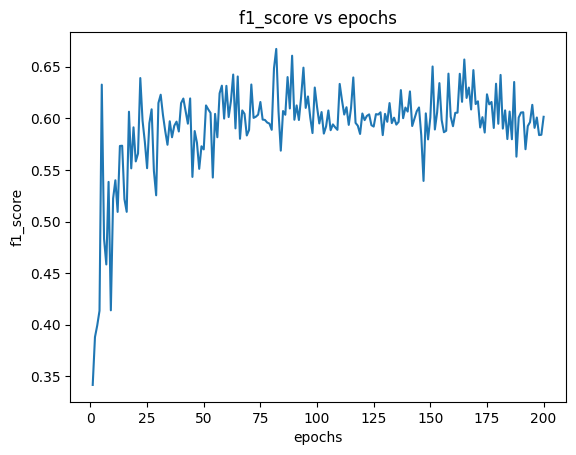

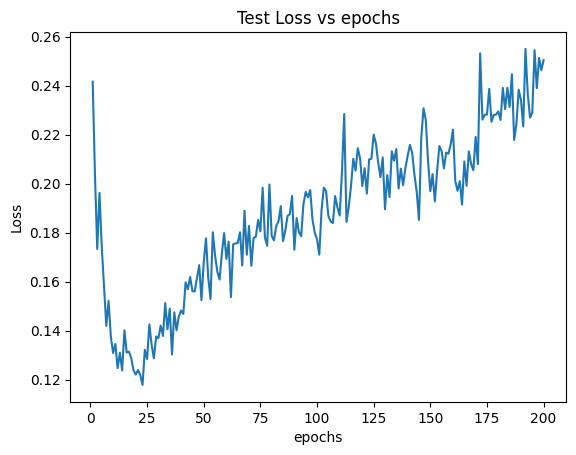

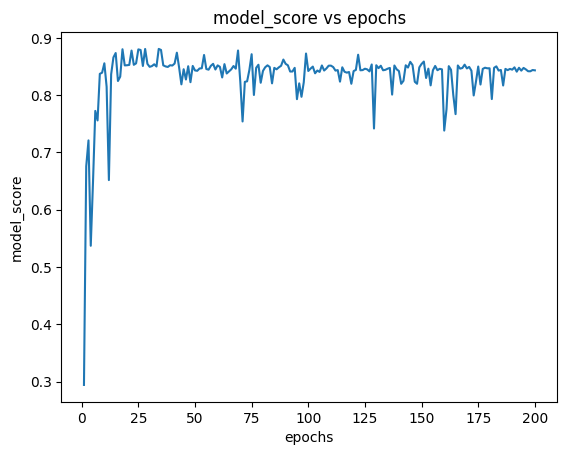

In [7]:
k = len(f1_arr)
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,k+1), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,k+1), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms) 

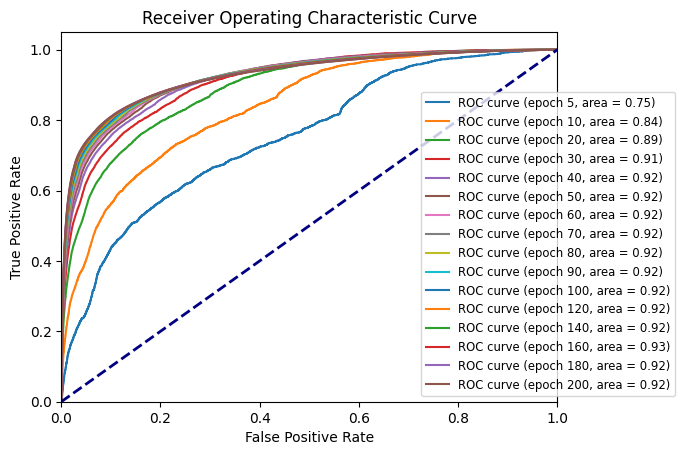

In [8]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [9]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tabulate import tabulate

model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]

  Label    Precision    Recall    F1     AUC
-------  -----------  --------  ----  ------
      0       0.6825    0.6667   1    1
      1       0.3492    0.3333   1    0.95
      2       0.6825    0.6667   1    1
      3       0.6825    0.6667   1    1
      4       0.6825    0.6667   1    1
      5       0.6825    0.6667   1    1
      6       0.6825    0.6667   1    1
      7       0.3492    0.3333   1    0.9
      8       0.3492    0.3333   1    0.95
      9       0.3492    0.3333   1    0.95
     10       0.5238    0.5      0    0.9
     11       0.6825    0.6667   1    1
     12       0.6825    0.6667   1    1
     13       0.5317    0.5      0.5  0.6316
     14       0.6825    0.6667   1    1
     15       0.6825    0.6667   1    1
     16       0.6825    0.6667   1    1
     17       0.6825    0.6667   1    1
     18       0.6825    0.6667   1    1
     19       0.5238    0.5      0    1
     20       0.6825    0.6667   1    1


In [10]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag


{'status': 'ok', 'restart': True}

: 